In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']
X.head()

var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7   var_8  \
0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266 -4.9200   
1  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338  3.1468   
2   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155 -4.9193   
3  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250 -5.8609   
4   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514  6.2654   

    var_9  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0  5.7470  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   7.8784   
1  8.0851  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   8.1267   
2  5.9525  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417  -6.5213   
3  8.2450  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706  -2.9275   
4  7.6784  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   3.9267   

   var_197  var_198  var_199  
0   8.5635  12.7803  -1.0914  
1   8.7889  18.3560   1.9518  
2   8.2675  14.7222   0.3965  
3  10.2922  17.9697  -8.9996  
4   9.5031  17.9974  -8.8104  

[5 rows x 200 columns]

#### Separando Fraudulentos de honestos

In [3]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X.loc[fraud_index]
honest = X.loc[honest_index]

In [4]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Fracionando a Tabela de treino

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.3,random_state=30)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test,test_size=0.5,random_state=30)

# Normalização

In [6]:
meanx = x_train.mean(axis = 0)
stdx = x_train.std(axis = 0)
x_train_norm = (x_train - meanx)/stdx
x_val_norm = (x_val - meanx)/stdx
x_test_norm = (x_test - meanx)/stdx
x_train_norm=np.asarray(x_train_norm)
x_test_norm=np.asarray(x_test_norm)
x_val_norm=np.asarray(x_val_norm)

# RNA

In [7]:
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras.layers import LeakyReLU
from keras import regularizers

Using TensorFlow backend.


In [8]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

In [9]:
def custom_loss(y_true, y_pred):

    zeros = tf.zeros_like(y_true)
    index_of_zeros = tf.where(tf.equal(zeros, y_true))
    ones = tf.ones_like(y_true)
    index_of_ones = tf.where(tf.equal(ones, y_true))

    zero = tf.gather(y_pred, index_of_zeros)
    one = tf.gather(y_pred, index_of_ones)

    loss_0 = 0.1*binary_crossentropy(tf.zeros_like(zero), zero)
    loss_1 = 0.9*binary_crossentropy(tf.ones_like(one), one)

    return mean(tf.concat([loss_0, loss_1], axis=0))

In [10]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
class new_rna:
    def __init__(self,rna_list,loss_list,metrics_list,optimizer_list):
        self.rna_list = rna_list
        self.loss_list = loss_list
        self.metrics_list = metrics_list
        self.optimizer_list = optimizer_list
    
    def train(self, x_train_list,y_train_list,x_val_list,y_val_list,batch_size_list,epochs_list):
        print(type(x_val_list[0]))
        history = []
        self.history_dict = []
        for i in range(len(self.rna_list)):
            self.rna_list[i].compile(loss = [self.loss_list[i]],metrics = [self.metrics_list[i]], optimizer = self.optimizer_list[i])
            history.append(self.rna_list[i].fit(x_train_list[i],y_train_list[i], batch_size = batch_size_list[i],
                                                epochs = epochs_list[i], validation_data = (x_val_list[i],y_val_list[i])))
            self.history_dict.append(history[i].history)
            
            
    def plot(self):
        aux_epocas = []
        cost = []  
        metric = [] 
        val_cost = []
        val_metric = []
        for i in range(len(self.rna_list)):
            cost.append(self.history_dict[i]['loss'])
            metric.append(self.history_dict[i]['f1'])
            val_cost.append(self.history_dict[i]['val_loss'])
            val_metric.append(self.history_dict[i]['val_f1'])
        for i in range(len(self.rna_list)):
            aux_epocas.append(range(1, len(cost[i]) + 1))
            cost.append(self.history_dict[i]['loss'])
            metric.append(self.history_dict[i]['f1'])
            val_cost.append(self.history_dict[i]['val_loss'])
            val_metric.append(self.history_dict[i]['val_f1'])
            plt.plot(aux_epocas[i],cost[i],'b',label = 'Custo - treinamento',color = 'red')
            plt.plot(aux_epocas[i],val_cost[i],'b',label = 'Custo - validacao', color = 'blue')
            plt.title('RNA{}: Valor da Funcao Custo = Treinamento e Validacao'.format(i))
            plt.xlabel('Épocas')
            plt.ylabel('Custo')
            plt.legend()
            plt.show()
            plt.plot(aux_epocas[i], metric[i],'b',label = 'metrica - treinamento',color = 'red')
            plt.plot(aux_epocas[i], val_metric[i],'b',label = 'metrica - validacao', color = 'blue')
            plt.title('RNA{}: Valor da métrica – treinamento e validação'.format(i))
            plt.xlabel('Épocas')
            plt.ylabel('Acertividade')
            plt.legend()
            plt.show()
            
        
    def predict(self,x_test_list,y_test_list):
        class_names = np.array([['Honest'],['Fraud']])
        y_hat = []
        yy_hat = []
        yyy_hat = []
        yyyy_hat = []
        f1_s = []
        for i in range(len(self.rna_list)):
            y_hat.append(self.rna_list[i].predict(x_test_list[i]))
            yy_hat.append(np.round(y_hat[i]))
            yyy_hat.append(yy_hat[i].astype(int)) 
            yyyy_hat.append(np.ravel(yyy_hat[i]))
            f1_s.append(f1_score(y_test_list[i],yyyy_hat[i]))
            plot_confusion_matrix(np.int_(y_test_list[i]), np.int_(yyyy_hat[i]), classes=class_names,
                                  title='F1_Score_RNA{0} = {1}: Confusion matrix'.format(i,f1_s[i]))
            plt.show()

In [12]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

In [13]:
rmsp = optimizers.RMSprop(lr=0.01, rho=0.9, decay=0.0)
mom = optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.99, decay=0.0)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
data_shape = (200,)
rna = models.Sequential()
rna.add(layers.Dense(units = 50, activation = 'tanh', input_shape = data_shape))
rna.add(layers.Dense(units = 1, activation = 'sigmoid'))
# rna.compile(loss = [custom_loss], metrics = [f1] , optimizer = mom)

rna1 = models.Sequential()
rna1.add(layers.Dense(units = 100, activation = 'tanh', input_shape = data_shape))
rna1.add(layers.Dense(units = 1, activation = 'sigmoid'))
# rna1.compile(loss = [custom_loss], metrics = [f1] , optimizer = mom)

rna2 = models.Sequential()
rna2.add(layers.Dense(units = 50, activation = 'tanh', input_shape = data_shape))
rna2.add(layers.Dense(units = 50, activation = 'tanh', input_shape = data_shape))
rna2.add(layers.Dense(units = 1, activation = 'sigmoid'))
# rna2.compile(loss = [custom_loss], metrics = [f1] , optimizer = mom)

rna3 = models.Sequential()
rna3.add(layers.Dense(units = 100, activation = 'tanh', input_shape = data_shape))
rna3.add(layers.Dense(units = 100, activation = 'tanh', input_shape = data_shape))
rna3.add(layers.Dense(units = 1, activation = 'sigmoid'))
# rna3.compile(loss = [custom_loss], metrics = [f1] , optimizer = mom)

rna4 = models.Sequential()
rna4.add(layers.Dense(units = 50, activation = 'tanh', input_shape = data_shape))
rna4.add(layers.Dense(units = 50, activation = 'tanh', input_shape = data_shape))
rna4.add(layers.Dense(units = 50, activation = 'tanh', input_shape = data_shape))
rna4.add(layers.Dense(units = 1, activation = 'sigmoid'))
# rna4.compile(loss = [custom_loss], metrics = [f1] , optimizer = mom)

rna5 = models.Sequential()
rna5.add(layers.Dense(units = 100, activation = 'tanh', input_shape = data_shape))
rna5.add(layers.Dense(units = 100, activation = 'tanh', input_shape = data_shape))
rna5.add(layers.Dense(units = 100, activation = 'tanh', input_shape = data_shape))
rna5.add(layers.Dense(units = 1, activation = 'sigmoid'))
# rna5.compile(loss = [custom_loss], metrics = [f1] , optimizer = mom)

In [15]:
rna_list0 = [rna,rna1,rna2,rna3,rna4,rna5]
loss_list0 = [custom_loss]*5
metrics_list0 = [f1]*5
optimizer_list0 = [mom]*5

x_train_list0 = [x_train_norm]*5
y_train_list0 = [y_train]*5
x_val_list0 = [x_val_norm]*5
y_val_list0 = [y_val]*5
batch_size_list0 = [100]*5
epochs_list0 = [10000]*5

x_test_list0 = [x_test_norm]*5
y_test_list0 = [y_test]*5

In [16]:

rna_test0 = new_rna(rna_list0,loss_list0,metrics_list0,optimizer_list0)

In [17]:
rna_test0.train(x_train_list0,y_train_list0,x_val_list0,y_val_list0,batch_size_list0,epochs_list0)

<class 'numpy.ndarray'>
Instructions for updating:
Use tf.cast instead.
Train on 140000 samples, validate on 30000 samples
Epoch 1/10000


C:\Users\Elvemage\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


140000/140000 [==============================] - 3s 21us/step - loss: 0.1204 - f1: 0.2854 - val_loss: 0.1198 - val_f1: 0.3297
Epoch 2/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1167 - f1: 0.3353 - val_loss: 0.1189 - val_f1: 0.3396
Epoch 3/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1163 - f1: 0.3377 - val_loss: 0.1187 - val_f1: 0.3413
Epoch 4/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1161 - f1: 0.3413 - val_loss: 0.1187 - val_f1: 0.3422
Epoch 5/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1163 - f1: 0.3417 - val_loss: 0.1187 - val_f1: 0.3467
Epoch 6/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1156 - f1: 0.3456 - val_loss: 0.1186 - val_f1: 0.3470
Epoch 7/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1159 - f1: 0.3454 - val_loss: 0.1185 - val_f1: 0.3465
Epoch 8/10000
140000/140000 [=====

140000/140000 [==============================] - 2s 16us/step - loss: 0.1159 - f1: 0.3476 - val_loss: 0.1183 - val_f1: 0.3494
Epoch 60/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3482 - val_loss: 0.1183 - val_f1: 0.3488
Epoch 61/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1154 - f1: 0.3484 - val_loss: 0.1183 - val_f1: 0.3487
Epoch 62/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1151 - f1: 0.3481 - val_loss: 0.1183 - val_f1: 0.3486
Epoch 63/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1156 - f1: 0.3481 - val_loss: 0.1183 - val_f1: 0.3491
Epoch 64/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1154 - f1: 0.3477 - val_loss: 0.1183 - val_f1: 0.3491
Epoch 65/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1154 - f1: 0.3475 - val_loss: 0.1183 - val_f1: 0.3488
Epoch 66/10000
140000/140000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1154 - f1: 0.3503 - val_loss: 0.1183 - val_f1: 0.3504
Epoch 118/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1154 - f1: 0.3502 - val_loss: 0.1183 - val_f1: 0.3505
Epoch 119/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1153 - f1: 0.3507 - val_loss: 0.1183 - val_f1: 0.3506
Epoch 120/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1154 - f1: 0.3496 - val_loss: 0.1183 - val_f1: 0.3507
Epoch 121/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1153 - f1: 0.3499 - val_loss: 0.1183 - val_f1: 0.3508
Epoch 122/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1152 - f1: 0.3499 - val_loss: 0.1183 - val_f1: 0.3508
Epoch 123/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1154 - f1: 0.3504 - val_loss: 0.1182 - val_f1: 0.3509
Epoch 124/10000
140000

Epoch 175/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1156 - f1: 0.3498 - val_loss: 0.1182 - val_f1: 0.3500
Epoch 176/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1153 - f1: 0.3497 - val_loss: 0.1182 - val_f1: 0.3499
Epoch 177/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1153 - f1: 0.3498 - val_loss: 0.1182 - val_f1: 0.3500
Epoch 178/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1151 - f1: 0.3499 - val_loss: 0.1182 - val_f1: 0.3500
Epoch 179/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1159 - f1: 0.3495 - val_loss: 0.1182 - val_f1: 0.3501
Epoch 180/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1156 - f1: 0.3491 - val_loss: 0.1182 - val_f1: 0.3499
Epoch 181/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1156 - f1: 0.3493 - val_loss: 0.1182 - val_f1: 0.3501
Epoch 

140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3501 - val_loss: 0.1182 - val_f1: 0.3503
Epoch 233/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3493 - val_loss: 0.1182 - val_f1: 0.3505
Epoch 234/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3501 - val_loss: 0.1182 - val_f1: 0.3502
Epoch 235/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3495 - val_loss: 0.1182 - val_f1: 0.3503
Epoch 236/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3494 - val_loss: 0.1182 - val_f1: 0.3501
Epoch 237/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3502 - val_loss: 0.1182 - val_f1: 0.3502
Epoch 238/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3498 - val_loss: 0.1182 - val_f1: 0.3500
Epoch 239/10000
140000

Epoch 290/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3502 - val_loss: 0.1182 - val_f1: 0.3510
Epoch 291/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3501 - val_loss: 0.1182 - val_f1: 0.3512
Epoch 292/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3508 - val_loss: 0.1182 - val_f1: 0.3512
Epoch 293/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1155 - f1: 0.3506 - val_loss: 0.1182 - val_f1: 0.3510
Epoch 294/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3500 - val_loss: 0.1182 - val_f1: 0.3510
Epoch 295/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3500 - val_loss: 0.1182 - val_f1: 0.3508
Epoch 296/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3506 - val_loss: 0.1182 - val_f1: 0.3511
Epoch 

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3509 - val_loss: 0.1182 - val_f1: 0.3513
Epoch 348/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3502 - val_loss: 0.1182 - val_f1: 0.3513
Epoch 349/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3504 - val_loss: 0.1182 - val_f1: 0.3514
Epoch 350/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1155 - f1: 0.3509 - val_loss: 0.1182 - val_f1: 0.3514
Epoch 351/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3503 - val_loss: 0.1182 - val_f1: 0.3514
Epoch 352/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3502 - val_loss: 0.1182 - val_f1: 0.3512
Epoch 353/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3507 - val_loss: 0.1182 - val_f1: 0.3511
Epoch 354/10000
140000

Epoch 405/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3508 - val_loss: 0.1182 - val_f1: 0.3511
Epoch 406/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3503 - val_loss: 0.1182 - val_f1: 0.3511
Epoch 407/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3508 - val_loss: 0.1182 - val_f1: 0.3511
Epoch 408/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3506 - val_loss: 0.1182 - val_f1: 0.3512
Epoch 409/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3507 - val_loss: 0.1182 - val_f1: 0.3512
Epoch 410/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3507 - val_loss: 0.1182 - val_f1: 0.3511
Epoch 411/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3507 - val_loss: 0.1182 - val_f1: 0.3512
Epoch 

140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3513 - val_loss: 0.1182 - val_f1: 0.3517
Epoch 463/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3508 - val_loss: 0.1182 - val_f1: 0.3514
Epoch 464/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3513 - val_loss: 0.1182 - val_f1: 0.3515
Epoch 465/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3509 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 466/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3500 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 467/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1150 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 468/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3505 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 469/10000
140000

Epoch 520/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3505 - val_loss: 0.1182 - val_f1: 0.3515
Epoch 521/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3510 - val_loss: 0.1182 - val_f1: 0.3516
Epoch 522/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3510 - val_loss: 0.1182 - val_f1: 0.3515
Epoch 523/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1156 - f1: 0.3510 - val_loss: 0.1182 - val_f1: 0.3516
Epoch 524/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3510 - val_loss: 0.1182 - val_f1: 0.3516
Epoch 525/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3510 - val_loss: 0.1182 - val_f1: 0.3515
Epoch 526/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1155 - f1: 0.3503 - val_loss: 0.1182 - val_f1: 0.3516
Epoch 

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3511 - val_loss: 0.1182 - val_f1: 0.3520
Epoch 578/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3520
Epoch 579/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1155 - f1: 0.3516 - val_loss: 0.1182 - val_f1: 0.3519
Epoch 580/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3509 - val_loss: 0.1182 - val_f1: 0.3519
Epoch 581/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1159 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 582/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3511 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 583/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3509 - val_loss: 0.1182 - val_f1: 0.3517
Epoch 584/10000
140000

Epoch 635/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1150 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3517
Epoch 636/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3513 - val_loss: 0.1182 - val_f1: 0.3517
Epoch 637/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 638/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3510 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 639/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3513 - val_loss: 0.1182 - val_f1: 0.3519
Epoch 640/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3513 - val_loss: 0.1182 - val_f1: 0.3519
Epoch 641/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3511 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3517 - val_loss: 0.1182 - val_f1: 0.3515
Epoch 693/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3516
Epoch 694/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3516 - val_loss: 0.1182 - val_f1: 0.3517
Epoch 695/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3517
Epoch 696/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3515 - val_loss: 0.1182 - val_f1: 0.3516
Epoch 697/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3518 - val_loss: 0.1182 - val_f1: 0.3515
Epoch 698/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3517
Epoch 699/10000
140000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3511 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 750/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3515 - val_loss: 0.1182 - val_f1: 0.3521
Epoch 751/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 752/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3520
Epoch 753/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3520
Epoch 754/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3518 - val_loss: 0.1182 - val_f1: 0.3520
Epoch 755/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3521 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 756/10000
140000

Epoch 807/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3516 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 808/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 809/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1156 - f1: 0.3510 - val_loss: 0.1182 - val_f1: 0.3524
Epoch 810/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3509 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 811/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3516 - val_loss: 0.1182 - val_f1: 0.3524
Epoch 812/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 813/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3519 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3515 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 865/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 866/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3515 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 867/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3510 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 868/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3518 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 869/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 870/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3522 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 871/10000
140000

Epoch 922/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3518 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 923/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3517 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 924/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 925/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3520 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 926/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1158 - f1: 0.3518 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 927/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3519 - val_loss: 0.1182 - val_f1: 0.3524
Epoch 928/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3524
Epoch 

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3511 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 980/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3515 - val_loss: 0.1182 - val_f1: 0.3524
Epoch 981/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3510 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 982/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3516 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 983/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3511 - val_loss: 0.1182 - val_f1: 0.3523
Epoch 984/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 985/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3517 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 986/10000
140000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3511 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 1037/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3511 - val_loss: 0.1182 - val_f1: 0.3521
Epoch 1038/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3516 - val_loss: 0.1182 - val_f1: 0.3521
Epoch 1039/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3516 - val_loss: 0.1182 - val_f1: 0.3521
Epoch 1040/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3521
Epoch 1041/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3512 - val_loss: 0.1182 - val_f1: 0.3521
Epoch 1042/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3516 - val_loss: 0.1182 - val_f1: 0.3522
Epoch 1043/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3513 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 1094/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3511 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1095/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3512 - val_loss: 0.1181 - val_f1: 0.3519
Epoch 1096/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1097/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1098/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1099/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3509 - val_loss: 0.1181 - val_f1: 0.3519
Epoch 1100/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3517
Epoch 1151/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1182 - val_f1: 0.3520
Epoch 1152/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3515 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 1153/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3514 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 1154/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3513 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 1155/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3521 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 1156/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1155 - f1: 0.3516 - val_loss: 0.1182 - val_f1: 0.3518
Epoch 1157/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3511 - val_loss: 0.1181 - val_f1: 0.3515
Epoch 1208/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1157 - f1: 0.3513 - val_loss: 0.1181 - val_f1: 0.3515
Epoch 1209/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3514
Epoch 1210/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3514
Epoch 1211/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3514
Epoch 1212/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3515
Epoch 1213/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3513 - val_loss: 0.1181 - val_f1: 0.3515
Epoch 1214/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3516
Epoch 1265/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3516
Epoch 1266/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3508 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1267/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3509 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1268/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3513 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1269/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3511 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1270/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3508 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1271/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1148 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1322/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1323/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3508 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1324/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1325/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3510 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1326/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1327/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1328/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1379/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1380/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1381/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1382/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1383/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3511 - val_loss: 0.1181 - val_f1: 0.3519
Epoch 1384/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1385/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1436/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1437/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1438/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1153 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3519
Epoch 1439/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3519
Epoch 1440/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3519
Epoch 1441/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3519
Epoch 1442/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1493/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1153 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3517
Epoch 1494/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3519
Epoch 1495/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3519
Epoch 1496/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3519
Epoch 1497/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1498/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3518
Epoch 1499/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1550/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1551/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1552/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1553/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1554/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1555/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1149 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1556/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1607/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1608/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3512 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1609/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1610/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1154 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1611/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1612/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1613/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1664/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1665/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1666/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1667/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1668/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3514 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1669/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3513 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1670/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1721/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1722/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1723/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1724/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1725/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1726/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1727/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1778/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1779/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1155 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1780/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1781/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1782/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1150 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1783/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1784/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1835/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1836/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1837/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1152 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1838/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1839/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1840/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 1841/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1156 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1892/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1893/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1894/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1895/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1896/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1897/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 1898/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 1949/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 1950/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 1951/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 1952/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 1953/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 1954/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 1955/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2006/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3524
Epoch 2007/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3524
Epoch 2008/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1155 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3524
Epoch 2009/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2010/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3524
Epoch 2011/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3524
Epoch 2012/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2063/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2064/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2065/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2066/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2067/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 2068/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 2069/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2120/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2121/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1148 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 2122/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2123/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 2124/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2125/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3514 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2126/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2177/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2178/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3512 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2179/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2180/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2181/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2182/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3513 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2183/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2234/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2235/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2236/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2237/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2238/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2239/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2240/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1149 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2291/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2292/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2293/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2294/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2295/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2296/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2297/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2348/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2349/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2350/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2351/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2352/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2353/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2354/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 2405/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 2406/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 2407/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1155 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 2408/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3521
Epoch 2409/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 2410/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3520
Epoch 2411/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2462/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2463/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2464/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2465/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3513 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2466/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2467/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2468/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2519/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2520/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2521/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2522/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2523/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2524/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2525/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2576/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2577/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2578/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2579/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2580/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1158 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2581/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2582/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3524
Epoch 2633/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2634/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1155 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3522
Epoch 2635/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1150 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2636/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2637/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2638/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3523
Epoch 2639/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1150 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2690/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2691/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1148 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2692/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3524
Epoch 2693/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2694/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2695/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2696/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3526
Epoch 2747/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3525
Epoch 2748/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3526
Epoch 2749/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2750/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2751/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2752/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2753/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2804/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2805/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2806/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2807/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2808/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2809/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3527
Epoch 2810/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2861/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2862/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1155 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2863/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3528
Epoch 2864/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2865/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2866/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2867/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2918/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3528
Epoch 2919/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3528
Epoch 2920/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2921/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3528
Epoch 2922/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1149 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3528
Epoch 2923/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3528
Epoch 2924/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2975/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2976/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2977/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2978/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3528
Epoch 2979/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2980/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 2981/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3032/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3514 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3033/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3034/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3035/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3036/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1155 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3037/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3038/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3089/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3090/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3091/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1156 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3092/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3093/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3511 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3094/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3095/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3146/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3147/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3148/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3149/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3150/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3151/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3152/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3203/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3204/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3205/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3206/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3207/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3208/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3513 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3209/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3260/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1147 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3261/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3262/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3263/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3264/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3265/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3266/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3317/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3318/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3319/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3320/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1155 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3321/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3322/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3323/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3374/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3375/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3376/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3377/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3378/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1148 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3379/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 3380/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3431/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3432/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3433/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3434/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3435/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3436/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3437/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3488/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3489/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3490/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1150 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3491/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3492/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3493/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3494/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3545/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3546/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3547/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3515 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3548/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3514 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3549/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3550/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1152 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3551/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3513 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3602/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3603/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1155 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3604/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3605/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3606/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3607/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3608/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3659/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3660/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3661/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3512 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3662/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1147 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3663/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1155 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 3664/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 3665/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 3716/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 3717/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 3718/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 3719/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 3720/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 3721/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 3722/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3773/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3774/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3775/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3776/10000
140000/140000 [==============================] - 2s 15us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3777/10000
140000/140000 [==============================] - 2s 14us/step - loss: 0.1152 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3778/10000
140000/140000 [==============================] - 2s 14us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3779/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3830/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3831/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1158 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3832/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3833/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3834/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3835/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3836/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3887/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3888/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3889/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3534
Epoch 3890/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3891/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3892/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3893/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3944/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3945/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3946/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3947/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3948/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3949/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 3950/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4001/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1155 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4002/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 4003/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4004/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4005/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4006/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3533
Epoch 4007/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4058/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3514 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4059/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1147 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4060/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4061/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4062/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4063/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4064/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4115/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4116/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4117/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4118/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4119/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4120/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4121/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4172/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4173/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4174/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4175/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4176/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4177/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4178/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4229/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4230/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4231/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4232/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4233/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4234/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4235/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4286/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4287/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4288/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4289/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4290/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1149 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4291/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4292/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4343/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4344/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4345/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4346/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4347/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4348/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4349/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4400/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4401/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4402/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4403/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4404/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4405/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4406/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4457/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4458/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4459/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4460/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4461/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4462/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4463/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4514/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4515/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4516/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1150 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4517/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4518/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1150 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4519/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4520/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4571/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3514 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4572/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4573/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1155 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4574/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4575/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4576/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4577/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4628/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4629/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4630/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4631/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4632/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4633/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4634/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1155 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4685/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4686/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4687/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4688/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4689/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4690/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4691/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4742/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4743/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4744/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4745/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3516 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4746/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4747/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4748/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4799/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4800/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4801/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4802/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4803/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4804/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4805/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4856/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4857/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4858/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4859/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4860/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4861/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4862/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4913/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4914/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4915/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 4916/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4917/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4918/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4919/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4970/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4971/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4972/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1148 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 4973/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1154 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4974/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4975/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 4976/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5027/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5028/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5029/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5030/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5031/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5032/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5033/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5084/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5085/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5086/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5087/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5088/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1157 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5089/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5090/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5141/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5142/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5143/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5144/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5145/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5146/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5147/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5198/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5199/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5200/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5201/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5202/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5203/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5204/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5255/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5256/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5257/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5258/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5259/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5260/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1156 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5261/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5312/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5313/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5314/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5315/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3535 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5316/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5317/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5318/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5369/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5370/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5371/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5372/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5373/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5374/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5375/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1157 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5426/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5427/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5428/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5429/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5430/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5431/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5432/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5483/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5484/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5485/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5486/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5487/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5488/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5489/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5540/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5541/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5542/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1151 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5543/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5544/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5545/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5546/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5597/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1150 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5598/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5599/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5600/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3538 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5601/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5602/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3534 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5603/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5654/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5655/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5656/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5657/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5658/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5659/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5660/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5711/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5712/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5713/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5714/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1151 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5715/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5716/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1148 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5717/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5768/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5769/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5770/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5771/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5772/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5773/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5774/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 5825/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 5826/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 5827/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 5828/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 5829/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 5830/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1148 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 5831/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5882/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5883/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5884/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 5885/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1156 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5886/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5887/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3534 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5888/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5939/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5940/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5941/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5942/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5943/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5944/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1150 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 5945/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1150 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5996/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5997/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5998/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 5999/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6000/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6001/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6002/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3535 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6053/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6054/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6055/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6056/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6057/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1150 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6058/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6059/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6110/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6111/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6112/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6113/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6114/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6115/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6116/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1156 - f1: 0.3535 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6167/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6168/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6169/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6170/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6171/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6172/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6173/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6224/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6225/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6226/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1150 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6227/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6228/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6229/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6230/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6281/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6282/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1156 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6283/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6284/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6285/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6286/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6287/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6338/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6339/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6340/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6341/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6342/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6343/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6344/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6395/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6396/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6397/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6398/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6399/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6400/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6401/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6452/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6453/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6454/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6455/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6456/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6457/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6458/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6509/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1149 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6510/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6511/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6512/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1158 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6513/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6514/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6515/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6566/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6567/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6568/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6569/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6570/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1155 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6571/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6572/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6623/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6624/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6625/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6626/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3518 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6627/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6628/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6629/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1150 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6680/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6681/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6682/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6683/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6684/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6685/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6686/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6737/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6738/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6739/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6740/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6741/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6742/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1150 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6743/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6794/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6795/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6796/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6797/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6798/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6799/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 6800/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6851/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6852/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6853/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6854/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6855/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6856/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 6857/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1148 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6908/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6909/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6910/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6911/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6912/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6913/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6914/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6965/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6966/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6967/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6968/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6969/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6970/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1148 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 6971/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7022/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7023/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7024/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7025/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7026/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7027/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7028/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7079/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7080/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7081/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7082/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7083/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7084/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7085/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7136/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7137/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1154 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7138/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7139/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7140/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7141/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7142/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1151 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7193/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7194/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7195/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7196/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7197/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7198/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7199/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7250/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7251/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7252/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7253/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7254/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3534 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7255/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7256/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7307/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 7308/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 7309/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3534 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 7310/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 7311/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 7312/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 7313/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 7364/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7365/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 7366/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7367/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7368/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7369/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3532
Epoch 7370/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1148 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7421/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7422/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7423/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7424/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7425/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7426/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7427/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7478/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7479/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7480/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7481/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7482/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7483/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7484/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7535/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7536/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7537/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7538/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7539/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7540/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7541/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7592/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7593/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3535 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7594/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7595/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7596/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7597/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7598/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7649/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7650/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7651/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7652/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7653/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7654/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7655/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7706/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7707/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3535 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7708/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7709/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3535 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7710/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7711/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7712/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7763/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7764/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7765/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7766/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7767/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7768/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1155 - f1: 0.3534 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 7769/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7820/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7821/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7822/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7823/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7824/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7825/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7826/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7877/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7878/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7879/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7880/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7881/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7882/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7883/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7934/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7935/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7936/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7937/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7938/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7939/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7940/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7991/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7992/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7993/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7994/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7995/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 7996/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 7997/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8048/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8049/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8050/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8051/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8052/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8053/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8054/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8105/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8106/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8107/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8108/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8109/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8110/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3531
Epoch 8111/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8162/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8163/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1154 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8164/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8165/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8166/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8167/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8168/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8219/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8220/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1146 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8221/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8222/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8223/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8224/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8225/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8276/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1150 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8277/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8278/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8279/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8280/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8281/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8282/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8333/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8334/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1150 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8335/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8336/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1157 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8337/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8338/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8339/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3528
Epoch 8390/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3528
Epoch 8391/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8392/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8393/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8394/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1155 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8395/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8396/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8447/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8448/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8449/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8450/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8451/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1148 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8452/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8453/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8504/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8505/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8506/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8507/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8508/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8509/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8510/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1156 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8561/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8562/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8563/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8564/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8565/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3535 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8566/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8567/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8618/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8619/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8620/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8621/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8622/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8623/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8624/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8675/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8676/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8677/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3535 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8678/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8679/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8680/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8681/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3536 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8732/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1158 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8733/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8734/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8735/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8736/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8737/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8738/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8789/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8790/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8791/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1149 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8792/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1147 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8793/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8794/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8795/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8846/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8847/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8848/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8849/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8850/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8851/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8852/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8903/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8904/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8905/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8906/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1150 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8907/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8908/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8909/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 8960/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8961/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8962/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8963/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1150 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8964/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8965/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 8966/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9017/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9018/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1150 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9019/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9020/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9021/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9022/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9023/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9074/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9075/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9076/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9077/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9078/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9079/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9080/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9131/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9132/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9133/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9134/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9135/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9136/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9137/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9188/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9189/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1149 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9190/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9191/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3517 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9192/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9193/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9194/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1151 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9245/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9246/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9247/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9248/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9249/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9250/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9251/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9302/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9303/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9304/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9305/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9306/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1152 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9307/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9308/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1158 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9359/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9360/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9361/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1149 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9362/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9363/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9364/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9365/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9416/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1150 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9417/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9418/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9419/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9420/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9421/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9422/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9473/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9474/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9475/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9476/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9477/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9478/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1150 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9479/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9530/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9531/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9532/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1149 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9533/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9534/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9535/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9536/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9587/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3519 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9588/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9589/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9590/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9591/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9592/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9593/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9644/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9645/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3533 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9646/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9647/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3532 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9648/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1148 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9649/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9650/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9701/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9702/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1157 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9703/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9704/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9705/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9706/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9707/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9758/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9759/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9760/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9761/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1154 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9762/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1149 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9763/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1155 - f1: 0.3522 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9764/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9815/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3521 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9816/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9817/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9818/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1155 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9819/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9820/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9821/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1150 - f1: 0.3524 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9872/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1149 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9873/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9874/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1156 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9875/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1151 - f1: 0.3527 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9876/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1152 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9877/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9878/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3520 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9929/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1151 - f1: 0.3530 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9930/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9931/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1153 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9932/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1154 - f1: 0.3523 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9933/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1151 - f1: 0.3526 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9934/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1151 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9935/10000

140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3529 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9986/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9987/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1153 - f1: 0.3531 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9988/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1153 - f1: 0.3534 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9989/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3534 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9990/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1152 - f1: 0.3528 - val_loss: 0.1181 - val_f1: 0.3530
Epoch 9991/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1155 - f1: 0.3525 - val_loss: 0.1181 - val_f1: 0.3529
Epoch 9992/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1335 - f1: 0.1846 - val_loss: 0.1370 - val_f1: 0.1882
Epoch 43/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1342 - f1: 0.1847 - val_loss: 0.1370 - val_f1: 0.1883
Epoch 44/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1346 - f1: 0.1850 - val_loss: 0.1369 - val_f1: 0.1883
Epoch 45/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1339 - f1: 0.1851 - val_loss: 0.1369 - val_f1: 0.1883
Epoch 46/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1343 - f1: 0.1846 - val_loss: 0.1369 - val_f1: 0.1883
Epoch 47/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1343 - f1: 0.1847 - val_loss: 0.1369 - val_f1: 0.1883
Epoch 48/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1339 - f1: 0.1849 - val_loss: 0.1369 - val_f1: 0.1884
Epoch 49/10000
140000/140000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1333 - f1: 0.1866 - val_loss: 0.1363 - val_f1: 0.1897
Epoch 101/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1340 - f1: 0.1864 - val_loss: 0.1363 - val_f1: 0.1897
Epoch 102/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1332 - f1: 0.1868 - val_loss: 0.1363 - val_f1: 0.1899
Epoch 103/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1340 - f1: 0.1867 - val_loss: 0.1362 - val_f1: 0.1900
Epoch 104/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1332 - f1: 0.1868 - val_loss: 0.1362 - val_f1: 0.1900
Epoch 105/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1332 - f1: 0.1865 - val_loss: 0.1362 - val_f1: 0.1901
Epoch 106/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1340 - f1: 0.1869 - val_loss: 0.1362 - val_f1: 0.1902
Epoch 107/10000
140000

Epoch 158/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1326 - f1: 0.1892 - val_loss: 0.1356 - val_f1: 0.1913
Epoch 159/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1328 - f1: 0.1888 - val_loss: 0.1356 - val_f1: 0.1914
Epoch 160/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1331 - f1: 0.1892 - val_loss: 0.1356 - val_f1: 0.1917
Epoch 161/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1327 - f1: 0.1886 - val_loss: 0.1356 - val_f1: 0.1920
Epoch 162/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1326 - f1: 0.1893 - val_loss: 0.1356 - val_f1: 0.1920
Epoch 163/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1326 - f1: 0.1891 - val_loss: 0.1356 - val_f1: 0.1921
Epoch 164/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1329 - f1: 0.1893 - val_loss: 0.1356 - val_f1: 0.1921
Epoch 

140000/140000 [==============================] - 2s 17us/step - loss: 0.1325 - f1: 0.1911 - val_loss: 0.1350 - val_f1: 0.1944
Epoch 216/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1323 - f1: 0.1909 - val_loss: 0.1350 - val_f1: 0.1944
Epoch 217/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1323 - f1: 0.1910 - val_loss: 0.1350 - val_f1: 0.1944
Epoch 218/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1322 - f1: 0.1910 - val_loss: 0.1350 - val_f1: 0.1944
Epoch 219/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1326 - f1: 0.1910 - val_loss: 0.1350 - val_f1: 0.1944
Epoch 220/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1327 - f1: 0.1908 - val_loss: 0.1350 - val_f1: 0.1947
Epoch 221/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1320 - f1: 0.1913 - val_loss: 0.1350 - val_f1: 0.1947
Epoch 222/10000
140000

Epoch 273/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1319 - f1: 0.1930 - val_loss: 0.1345 - val_f1: 0.1969
Epoch 274/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1317 - f1: 0.1928 - val_loss: 0.1345 - val_f1: 0.1970
Epoch 275/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1316 - f1: 0.1935 - val_loss: 0.1345 - val_f1: 0.1970
Epoch 276/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1315 - f1: 0.1932 - val_loss: 0.1344 - val_f1: 0.1970
Epoch 277/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1319 - f1: 0.1930 - val_loss: 0.1344 - val_f1: 0.1971
Epoch 278/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1318 - f1: 0.1932 - val_loss: 0.1344 - val_f1: 0.1971
Epoch 279/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1317 - f1: 0.1929 - val_loss: 0.1344 - val_f1: 0.1971
Epoch 

140000/140000 [==============================] - 2s 17us/step - loss: 0.1312 - f1: 0.1946 - val_loss: 0.1339 - val_f1: 0.1991
Epoch 331/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1313 - f1: 0.1947 - val_loss: 0.1339 - val_f1: 0.1992
Epoch 332/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1310 - f1: 0.1950 - val_loss: 0.1339 - val_f1: 0.1992
Epoch 333/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1310 - f1: 0.1948 - val_loss: 0.1339 - val_f1: 0.1992
Epoch 334/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1311 - f1: 0.1952 - val_loss: 0.1339 - val_f1: 0.1992
Epoch 335/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1310 - f1: 0.1952 - val_loss: 0.1339 - val_f1: 0.1993
Epoch 336/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1308 - f1: 0.1950 - val_loss: 0.1339 - val_f1: 0.1993
Epoch 337/10000
140000

Epoch 388/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1304 - f1: 0.1975 - val_loss: 0.1334 - val_f1: 0.2010
Epoch 389/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1306 - f1: 0.1973 - val_loss: 0.1334 - val_f1: 0.2010
Epoch 390/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1312 - f1: 0.1972 - val_loss: 0.1334 - val_f1: 0.2010
Epoch 391/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1304 - f1: 0.1973 - val_loss: 0.1334 - val_f1: 0.2011
Epoch 392/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1306 - f1: 0.1971 - val_loss: 0.1334 - val_f1: 0.2013
Epoch 393/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1307 - f1: 0.1975 - val_loss: 0.1334 - val_f1: 0.2013
Epoch 394/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1307 - f1: 0.1976 - val_loss: 0.1334 - val_f1: 0.2013
Epoch 

140000/140000 [==============================] - 2s 17us/step - loss: 0.1300 - f1: 0.1993 - val_loss: 0.1330 - val_f1: 0.2028
Epoch 446/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1304 - f1: 0.1994 - val_loss: 0.1330 - val_f1: 0.2029
Epoch 447/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1304 - f1: 0.1999 - val_loss: 0.1330 - val_f1: 0.2030
Epoch 448/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1299 - f1: 0.1997 - val_loss: 0.1330 - val_f1: 0.2030
Epoch 449/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1303 - f1: 0.1995 - val_loss: 0.1329 - val_f1: 0.2031
Epoch 450/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1304 - f1: 0.1994 - val_loss: 0.1329 - val_f1: 0.2032
Epoch 451/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1298 - f1: 0.1992 - val_loss: 0.1329 - val_f1: 0.2032
Epoch 452/10000
140000

Epoch 503/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1297 - f1: 0.2009 - val_loss: 0.1325 - val_f1: 0.2043
Epoch 504/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1300 - f1: 0.2012 - val_loss: 0.1325 - val_f1: 0.2043
Epoch 505/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1302 - f1: 0.2016 - val_loss: 0.1325 - val_f1: 0.2043
Epoch 506/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1294 - f1: 0.2016 - val_loss: 0.1325 - val_f1: 0.2044
Epoch 507/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1299 - f1: 0.2010 - val_loss: 0.1325 - val_f1: 0.2044
Epoch 508/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1298 - f1: 0.2014 - val_loss: 0.1325 - val_f1: 0.2045
Epoch 509/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1292 - f1: 0.2013 - val_loss: 0.1325 - val_f1: 0.2045
Epoch 

140000/140000 [==============================] - 2s 17us/step - loss: 0.1292 - f1: 0.2027 - val_loss: 0.1321 - val_f1: 0.2061
Epoch 561/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1291 - f1: 0.2033 - val_loss: 0.1321 - val_f1: 0.2061
Epoch 562/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1295 - f1: 0.2031 - val_loss: 0.1321 - val_f1: 0.2061
Epoch 563/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1296 - f1: 0.2033 - val_loss: 0.1321 - val_f1: 0.2061
Epoch 564/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1290 - f1: 0.2031 - val_loss: 0.1321 - val_f1: 0.2061
Epoch 565/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1289 - f1: 0.2031 - val_loss: 0.1321 - val_f1: 0.2063
Epoch 566/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1292 - f1: 0.2032 - val_loss: 0.1321 - val_f1: 0.2065
Epoch 567/10000
140000

Epoch 618/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1292 - f1: 0.2051 - val_loss: 0.1317 - val_f1: 0.2081
Epoch 619/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1287 - f1: 0.2049 - val_loss: 0.1317 - val_f1: 0.2081
Epoch 620/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1289 - f1: 0.2052 - val_loss: 0.1317 - val_f1: 0.2081
Epoch 621/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1290 - f1: 0.2054 - val_loss: 0.1317 - val_f1: 0.2081
Epoch 622/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1291 - f1: 0.2055 - val_loss: 0.1317 - val_f1: 0.2081
Epoch 623/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1289 - f1: 0.2054 - val_loss: 0.1317 - val_f1: 0.2081
Epoch 624/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1287 - f1: 0.2055 - val_loss: 0.1317 - val_f1: 0.2082
Epoch 

140000/140000 [==============================] - 2s 18us/step - loss: 0.1285 - f1: 0.2071 - val_loss: 0.1313 - val_f1: 0.2096
Epoch 676/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1285 - f1: 0.2068 - val_loss: 0.1313 - val_f1: 0.2097
Epoch 677/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1282 - f1: 0.2071 - val_loss: 0.1313 - val_f1: 0.2097
Epoch 678/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1288 - f1: 0.2071 - val_loss: 0.1313 - val_f1: 0.2098
Epoch 679/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1287 - f1: 0.2068 - val_loss: 0.1313 - val_f1: 0.2098
Epoch 680/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1283 - f1: 0.2071 - val_loss: 0.1313 - val_f1: 0.2097
Epoch 681/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1286 - f1: 0.2073 - val_loss: 0.1313 - val_f1: 0.2097
Epoch 682/10000
140000

Epoch 733/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1284 - f1: 0.2084 - val_loss: 0.1310 - val_f1: 0.2115
Epoch 734/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1281 - f1: 0.2085 - val_loss: 0.1310 - val_f1: 0.2115
Epoch 735/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1281 - f1: 0.2087 - val_loss: 0.1310 - val_f1: 0.2115
Epoch 736/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1283 - f1: 0.2088 - val_loss: 0.1310 - val_f1: 0.2116
Epoch 737/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1283 - f1: 0.2086 - val_loss: 0.1310 - val_f1: 0.2116
Epoch 738/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1283 - f1: 0.2087 - val_loss: 0.1309 - val_f1: 0.2116
Epoch 739/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1282 - f1: 0.2091 - val_loss: 0.1309 - val_f1: 0.2115
Epoch 

140000/140000 [==============================] - 2s 17us/step - loss: 0.1280 - f1: 0.2108 - val_loss: 0.1306 - val_f1: 0.2133
Epoch 791/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1277 - f1: 0.2108 - val_loss: 0.1306 - val_f1: 0.2132
Epoch 792/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1274 - f1: 0.2104 - val_loss: 0.1306 - val_f1: 0.2132
Epoch 793/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1276 - f1: 0.2109 - val_loss: 0.1306 - val_f1: 0.2132
Epoch 794/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1276 - f1: 0.2106 - val_loss: 0.1306 - val_f1: 0.2132
Epoch 795/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.2111 - val_loss: 0.1306 - val_f1: 0.2133
Epoch 796/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.2108 - val_loss: 0.1306 - val_f1: 0.2134
Epoch 797/10000
140000

Epoch 848/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1274 - f1: 0.2123 - val_loss: 0.1303 - val_f1: 0.2147
Epoch 849/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.2120 - val_loss: 0.1303 - val_f1: 0.2147
Epoch 850/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1275 - f1: 0.2126 - val_loss: 0.1303 - val_f1: 0.2147
Epoch 851/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1276 - f1: 0.2122 - val_loss: 0.1303 - val_f1: 0.2147
Epoch 852/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.2125 - val_loss: 0.1303 - val_f1: 0.2147
Epoch 853/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.2123 - val_loss: 0.1303 - val_f1: 0.2147
Epoch 854/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1276 - f1: 0.2122 - val_loss: 0.1303 - val_f1: 0.2148
Epoch 

140000/140000 [==============================] - 2s 18us/step - loss: 0.1270 - f1: 0.2138 - val_loss: 0.1300 - val_f1: 0.2167
Epoch 906/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1275 - f1: 0.2138 - val_loss: 0.1300 - val_f1: 0.2168
Epoch 907/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1277 - f1: 0.2138 - val_loss: 0.1300 - val_f1: 0.2168
Epoch 908/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1273 - f1: 0.2138 - val_loss: 0.1300 - val_f1: 0.2168
Epoch 909/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.2135 - val_loss: 0.1300 - val_f1: 0.2168
Epoch 910/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.2140 - val_loss: 0.1300 - val_f1: 0.2168
Epoch 911/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1274 - f1: 0.2137 - val_loss: 0.1300 - val_f1: 0.2168
Epoch 912/10000
140000

Epoch 963/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1270 - f1: 0.2150 - val_loss: 0.1297 - val_f1: 0.2186
Epoch 964/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1270 - f1: 0.2155 - val_loss: 0.1297 - val_f1: 0.2186
Epoch 965/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1271 - f1: 0.2156 - val_loss: 0.1297 - val_f1: 0.2187
Epoch 966/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1270 - f1: 0.2154 - val_loss: 0.1297 - val_f1: 0.2187
Epoch 967/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1270 - f1: 0.2155 - val_loss: 0.1297 - val_f1: 0.2187
Epoch 968/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1271 - f1: 0.2155 - val_loss: 0.1297 - val_f1: 0.2187
Epoch 969/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.2154 - val_loss: 0.1297 - val_f1: 0.2187
Epoch 

140000/140000 [==============================] - 2s 18us/step - loss: 0.1267 - f1: 0.2169 - val_loss: 0.1294 - val_f1: 0.2204
Epoch 1021/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1267 - f1: 0.2171 - val_loss: 0.1294 - val_f1: 0.2204
Epoch 1022/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1271 - f1: 0.2173 - val_loss: 0.1294 - val_f1: 0.2205
Epoch 1023/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1269 - f1: 0.2172 - val_loss: 0.1294 - val_f1: 0.2205
Epoch 1024/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1268 - f1: 0.2171 - val_loss: 0.1294 - val_f1: 0.2205
Epoch 1025/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1264 - f1: 0.2171 - val_loss: 0.1294 - val_f1: 0.2206
Epoch 1026/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1268 - f1: 0.2175 - val_loss: 0.1294 - val_f1: 0.2206
Epoch 1027/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1266 - f1: 0.2186 - val_loss: 0.1292 - val_f1: 0.2217
Epoch 1078/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1265 - f1: 0.2188 - val_loss: 0.1292 - val_f1: 0.2217
Epoch 1079/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1260 - f1: 0.2184 - val_loss: 0.1292 - val_f1: 0.2217
Epoch 1080/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1269 - f1: 0.2186 - val_loss: 0.1292 - val_f1: 0.2217
Epoch 1081/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1263 - f1: 0.2188 - val_loss: 0.1292 - val_f1: 0.2217
Epoch 1082/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1264 - f1: 0.2191 - val_loss: 0.1292 - val_f1: 0.2218
Epoch 1083/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1267 - f1: 0.2191 - val_loss: 0.1292 - val_f1: 0.2219
Epoch 1084/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1260 - f1: 0.2202 - val_loss: 0.1289 - val_f1: 0.2239
Epoch 1135/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1265 - f1: 0.2205 - val_loss: 0.1289 - val_f1: 0.2239
Epoch 1136/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1262 - f1: 0.2201 - val_loss: 0.1289 - val_f1: 0.2239
Epoch 1137/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.2204 - val_loss: 0.1289 - val_f1: 0.2240
Epoch 1138/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1260 - f1: 0.2204 - val_loss: 0.1289 - val_f1: 0.2240
Epoch 1139/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1263 - f1: 0.2208 - val_loss: 0.1289 - val_f1: 0.2241
Epoch 1140/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1266 - f1: 0.2207 - val_loss: 0.1289 - val_f1: 0.2241
Epoch 1141/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1257 - f1: 0.2222 - val_loss: 0.1287 - val_f1: 0.2255
Epoch 1192/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1260 - f1: 0.2220 - val_loss: 0.1287 - val_f1: 0.2255
Epoch 1193/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1261 - f1: 0.2219 - val_loss: 0.1287 - val_f1: 0.2255
Epoch 1194/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1261 - f1: 0.2215 - val_loss: 0.1287 - val_f1: 0.2256
Epoch 1195/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1262 - f1: 0.2220 - val_loss: 0.1287 - val_f1: 0.2256
Epoch 1196/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1257 - f1: 0.2218 - val_loss: 0.1287 - val_f1: 0.2256
Epoch 1197/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1260 - f1: 0.2221 - val_loss: 0.1287 - val_f1: 0.2256
Epoch 1198/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1256 - f1: 0.2233 - val_loss: 0.1285 - val_f1: 0.2273
Epoch 1249/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1261 - f1: 0.2234 - val_loss: 0.1285 - val_f1: 0.2274
Epoch 1250/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1255 - f1: 0.2239 - val_loss: 0.1285 - val_f1: 0.2273
Epoch 1251/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1258 - f1: 0.2238 - val_loss: 0.1285 - val_f1: 0.2274
Epoch 1252/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.2239 - val_loss: 0.1285 - val_f1: 0.2275
Epoch 1253/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1256 - f1: 0.2238 - val_loss: 0.1284 - val_f1: 0.2275
Epoch 1254/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1256 - f1: 0.2240 - val_loss: 0.1284 - val_f1: 0.2275
Epoch 1255/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1256 - f1: 0.2254 - val_loss: 0.1282 - val_f1: 0.2290
Epoch 1306/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1255 - f1: 0.2250 - val_loss: 0.1282 - val_f1: 0.2290
Epoch 1307/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1256 - f1: 0.2252 - val_loss: 0.1282 - val_f1: 0.2290
Epoch 1308/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1254 - f1: 0.2251 - val_loss: 0.1282 - val_f1: 0.2290
Epoch 1309/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1253 - f1: 0.2252 - val_loss: 0.1282 - val_f1: 0.2290
Epoch 1310/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1254 - f1: 0.2253 - val_loss: 0.1282 - val_f1: 0.2291
Epoch 1311/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1252 - f1: 0.2253 - val_loss: 0.1282 - val_f1: 0.2291
Epoch 1312/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1252 - f1: 0.2265 - val_loss: 0.1280 - val_f1: 0.2307
Epoch 1363/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1248 - f1: 0.2264 - val_loss: 0.1280 - val_f1: 0.2307
Epoch 1364/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1253 - f1: 0.2263 - val_loss: 0.1280 - val_f1: 0.2307
Epoch 1365/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1252 - f1: 0.2262 - val_loss: 0.1280 - val_f1: 0.2307
Epoch 1366/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1250 - f1: 0.2268 - val_loss: 0.1280 - val_f1: 0.2307
Epoch 1367/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.2266 - val_loss: 0.1280 - val_f1: 0.2307
Epoch 1368/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1253 - f1: 0.2265 - val_loss: 0.1280 - val_f1: 0.2308
Epoch 1369/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1252 - f1: 0.2279 - val_loss: 0.1278 - val_f1: 0.2316
Epoch 1420/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1250 - f1: 0.2281 - val_loss: 0.1278 - val_f1: 0.2317
Epoch 1421/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1253 - f1: 0.2281 - val_loss: 0.1278 - val_f1: 0.2317
Epoch 1422/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1249 - f1: 0.2282 - val_loss: 0.1278 - val_f1: 0.2317
Epoch 1423/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1250 - f1: 0.2281 - val_loss: 0.1278 - val_f1: 0.2317
Epoch 1424/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1253 - f1: 0.2281 - val_loss: 0.1278 - val_f1: 0.2318
Epoch 1425/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1250 - f1: 0.2283 - val_loss: 0.1278 - val_f1: 0.2318
Epoch 1426/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1250 - f1: 0.2296 - val_loss: 0.1276 - val_f1: 0.2336
Epoch 1477/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1248 - f1: 0.2295 - val_loss: 0.1276 - val_f1: 0.2335
Epoch 1478/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1251 - f1: 0.2297 - val_loss: 0.1276 - val_f1: 0.2335
Epoch 1479/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1249 - f1: 0.2296 - val_loss: 0.1276 - val_f1: 0.2337
Epoch 1480/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1252 - f1: 0.2293 - val_loss: 0.1276 - val_f1: 0.2336
Epoch 1481/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1250 - f1: 0.2298 - val_loss: 0.1276 - val_f1: 0.2337
Epoch 1482/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1250 - f1: 0.2294 - val_loss: 0.1276 - val_f1: 0.2337
Epoch 1483/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1245 - f1: 0.2307 - val_loss: 0.1275 - val_f1: 0.2353
Epoch 1534/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1249 - f1: 0.2314 - val_loss: 0.1275 - val_f1: 0.2353
Epoch 1535/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1244 - f1: 0.2307 - val_loss: 0.1275 - val_f1: 0.2353
Epoch 1536/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1246 - f1: 0.2308 - val_loss: 0.1275 - val_f1: 0.2353
Epoch 1537/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1251 - f1: 0.2309 - val_loss: 0.1274 - val_f1: 0.2353
Epoch 1538/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1247 - f1: 0.2310 - val_loss: 0.1274 - val_f1: 0.2353
Epoch 1539/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1246 - f1: 0.2309 - val_loss: 0.1274 - val_f1: 0.2355
Epoch 1540/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1244 - f1: 0.2325 - val_loss: 0.1273 - val_f1: 0.2365
Epoch 1591/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1246 - f1: 0.2324 - val_loss: 0.1273 - val_f1: 0.2365
Epoch 1592/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1246 - f1: 0.2323 - val_loss: 0.1273 - val_f1: 0.2366
Epoch 1593/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1243 - f1: 0.2325 - val_loss: 0.1273 - val_f1: 0.2367
Epoch 1594/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1245 - f1: 0.2328 - val_loss: 0.1273 - val_f1: 0.2367
Epoch 1595/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1246 - f1: 0.2325 - val_loss: 0.1273 - val_f1: 0.2367
Epoch 1596/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1246 - f1: 0.2325 - val_loss: 0.1273 - val_f1: 0.2367
Epoch 1597/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1246 - f1: 0.2335 - val_loss: 0.1271 - val_f1: 0.2382
Epoch 1648/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1242 - f1: 0.2335 - val_loss: 0.1271 - val_f1: 0.2382
Epoch 1649/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1244 - f1: 0.2336 - val_loss: 0.1271 - val_f1: 0.2382
Epoch 1650/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1242 - f1: 0.2335 - val_loss: 0.1271 - val_f1: 0.2383
Epoch 1651/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1244 - f1: 0.2336 - val_loss: 0.1271 - val_f1: 0.2383
Epoch 1652/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1243 - f1: 0.2336 - val_loss: 0.1271 - val_f1: 0.2383
Epoch 1653/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1241 - f1: 0.2337 - val_loss: 0.1271 - val_f1: 0.2383
Epoch 1654/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1242 - f1: 0.2347 - val_loss: 0.1270 - val_f1: 0.2394
Epoch 1705/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1241 - f1: 0.2349 - val_loss: 0.1269 - val_f1: 0.2394
Epoch 1706/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1239 - f1: 0.2347 - val_loss: 0.1269 - val_f1: 0.2394
Epoch 1707/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1240 - f1: 0.2347 - val_loss: 0.1269 - val_f1: 0.2394
Epoch 1708/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1242 - f1: 0.2345 - val_loss: 0.1269 - val_f1: 0.2394
Epoch 1709/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1246 - f1: 0.2345 - val_loss: 0.1269 - val_f1: 0.2394
Epoch 1710/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1239 - f1: 0.2347 - val_loss: 0.1269 - val_f1: 0.2396
Epoch 1711/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1239 - f1: 0.2356 - val_loss: 0.1268 - val_f1: 0.2406
Epoch 1762/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1236 - f1: 0.2360 - val_loss: 0.1268 - val_f1: 0.2406
Epoch 1763/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1239 - f1: 0.2353 - val_loss: 0.1268 - val_f1: 0.2406
Epoch 1764/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1240 - f1: 0.2363 - val_loss: 0.1268 - val_f1: 0.2406
Epoch 1765/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1238 - f1: 0.2363 - val_loss: 0.1268 - val_f1: 0.2406
Epoch 1766/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1240 - f1: 0.2361 - val_loss: 0.1268 - val_f1: 0.2406
Epoch 1767/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1239 - f1: 0.2356 - val_loss: 0.1268 - val_f1: 0.2406
Epoch 1768/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1236 - f1: 0.2372 - val_loss: 0.1266 - val_f1: 0.2418
Epoch 1819/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1239 - f1: 0.2368 - val_loss: 0.1266 - val_f1: 0.2418
Epoch 1820/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1236 - f1: 0.2374 - val_loss: 0.1266 - val_f1: 0.2418
Epoch 1821/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1237 - f1: 0.2372 - val_loss: 0.1266 - val_f1: 0.2419
Epoch 1822/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1238 - f1: 0.2371 - val_loss: 0.1266 - val_f1: 0.2419
Epoch 1823/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1239 - f1: 0.2371 - val_loss: 0.1266 - val_f1: 0.2419
Epoch 1824/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1239 - f1: 0.2372 - val_loss: 0.1266 - val_f1: 0.2419
Epoch 1825/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1238 - f1: 0.2381 - val_loss: 0.1265 - val_f1: 0.2427
Epoch 1876/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1237 - f1: 0.2383 - val_loss: 0.1265 - val_f1: 0.2428
Epoch 1877/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1237 - f1: 0.2386 - val_loss: 0.1265 - val_f1: 0.2428
Epoch 1878/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1237 - f1: 0.2382 - val_loss: 0.1265 - val_f1: 0.2428
Epoch 1879/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1241 - f1: 0.2385 - val_loss: 0.1265 - val_f1: 0.2429
Epoch 1880/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1233 - f1: 0.2385 - val_loss: 0.1265 - val_f1: 0.2429
Epoch 1881/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1234 - f1: 0.2383 - val_loss: 0.1265 - val_f1: 0.2429
Epoch 1882/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1236 - f1: 0.2395 - val_loss: 0.1264 - val_f1: 0.2447
Epoch 1933/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1234 - f1: 0.2395 - val_loss: 0.1264 - val_f1: 0.2448
Epoch 1934/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1234 - f1: 0.2395 - val_loss: 0.1264 - val_f1: 0.2448
Epoch 1935/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1232 - f1: 0.2396 - val_loss: 0.1264 - val_f1: 0.2448
Epoch 1936/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1235 - f1: 0.2397 - val_loss: 0.1263 - val_f1: 0.2449
Epoch 1937/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1236 - f1: 0.2399 - val_loss: 0.1263 - val_f1: 0.2449
Epoch 1938/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1234 - f1: 0.2397 - val_loss: 0.1263 - val_f1: 0.2449
Epoch 1939/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1235 - f1: 0.2409 - val_loss: 0.1262 - val_f1: 0.2461
Epoch 1990/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1233 - f1: 0.2407 - val_loss: 0.1262 - val_f1: 0.2462
Epoch 1991/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1232 - f1: 0.2408 - val_loss: 0.1262 - val_f1: 0.2462
Epoch 1992/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1235 - f1: 0.2408 - val_loss: 0.1262 - val_f1: 0.2463
Epoch 1993/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1234 - f1: 0.2406 - val_loss: 0.1262 - val_f1: 0.2463
Epoch 1994/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1231 - f1: 0.2410 - val_loss: 0.1262 - val_f1: 0.2463
Epoch 1995/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1233 - f1: 0.2408 - val_loss: 0.1262 - val_f1: 0.2463
Epoch 1996/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1229 - f1: 0.2417 - val_loss: 0.1261 - val_f1: 0.2471
Epoch 2047/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1232 - f1: 0.2420 - val_loss: 0.1261 - val_f1: 0.2471
Epoch 2048/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1234 - f1: 0.2421 - val_loss: 0.1261 - val_f1: 0.2471
Epoch 2049/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1233 - f1: 0.2423 - val_loss: 0.1261 - val_f1: 0.2471
Epoch 2050/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1234 - f1: 0.2422 - val_loss: 0.1261 - val_f1: 0.2471
Epoch 2051/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1233 - f1: 0.2418 - val_loss: 0.1261 - val_f1: 0.2471
Epoch 2052/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1233 - f1: 0.2424 - val_loss: 0.1261 - val_f1: 0.2471
Epoch 2053/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1230 - f1: 0.2431 - val_loss: 0.1260 - val_f1: 0.2485
Epoch 2104/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1231 - f1: 0.2424 - val_loss: 0.1260 - val_f1: 0.2485
Epoch 2105/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1230 - f1: 0.2430 - val_loss: 0.1260 - val_f1: 0.2485
Epoch 2106/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1229 - f1: 0.2431 - val_loss: 0.1260 - val_f1: 0.2485
Epoch 2107/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1231 - f1: 0.2430 - val_loss: 0.1260 - val_f1: 0.2485
Epoch 2108/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1233 - f1: 0.2431 - val_loss: 0.1260 - val_f1: 0.2485
Epoch 2109/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1232 - f1: 0.2429 - val_loss: 0.1260 - val_f1: 0.2486
Epoch 2110/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1228 - f1: 0.2446 - val_loss: 0.1258 - val_f1: 0.2491
Epoch 2161/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1231 - f1: 0.2442 - val_loss: 0.1258 - val_f1: 0.2491
Epoch 2162/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1230 - f1: 0.2445 - val_loss: 0.1258 - val_f1: 0.2492
Epoch 2163/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1233 - f1: 0.2443 - val_loss: 0.1258 - val_f1: 0.2491
Epoch 2164/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1231 - f1: 0.2446 - val_loss: 0.1258 - val_f1: 0.2491
Epoch 2165/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1229 - f1: 0.2448 - val_loss: 0.1258 - val_f1: 0.2491
Epoch 2166/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1228 - f1: 0.2444 - val_loss: 0.1258 - val_f1: 0.2492
Epoch 2167/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1227 - f1: 0.2457 - val_loss: 0.1257 - val_f1: 0.2504
Epoch 2218/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1230 - f1: 0.2449 - val_loss: 0.1257 - val_f1: 0.2504
Epoch 2219/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1229 - f1: 0.2456 - val_loss: 0.1257 - val_f1: 0.2504
Epoch 2220/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1226 - f1: 0.2456 - val_loss: 0.1257 - val_f1: 0.2505
Epoch 2221/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1230 - f1: 0.2453 - val_loss: 0.1257 - val_f1: 0.2505
Epoch 2222/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1228 - f1: 0.2457 - val_loss: 0.1257 - val_f1: 0.2505
Epoch 2223/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1226 - f1: 0.2456 - val_loss: 0.1257 - val_f1: 0.2505
Epoch 2224/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1228 - f1: 0.2467 - val_loss: 0.1256 - val_f1: 0.2515
Epoch 2275/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1231 - f1: 0.2466 - val_loss: 0.1256 - val_f1: 0.2516
Epoch 2276/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1226 - f1: 0.2470 - val_loss: 0.1256 - val_f1: 0.2516
Epoch 2277/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1226 - f1: 0.2468 - val_loss: 0.1256 - val_f1: 0.2516
Epoch 2278/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1230 - f1: 0.2467 - val_loss: 0.1256 - val_f1: 0.2516
Epoch 2279/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1228 - f1: 0.2473 - val_loss: 0.1256 - val_f1: 0.2515
Epoch 2280/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1225 - f1: 0.2470 - val_loss: 0.1256 - val_f1: 0.2515
Epoch 2281/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1226 - f1: 0.2482 - val_loss: 0.1255 - val_f1: 0.2524
Epoch 2332/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1227 - f1: 0.2484 - val_loss: 0.1255 - val_f1: 0.2524
Epoch 2333/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1228 - f1: 0.2485 - val_loss: 0.1255 - val_f1: 0.2524
Epoch 2334/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1225 - f1: 0.2479 - val_loss: 0.1255 - val_f1: 0.2524
Epoch 2335/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1225 - f1: 0.2482 - val_loss: 0.1255 - val_f1: 0.2524
Epoch 2336/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1225 - f1: 0.2484 - val_loss: 0.1255 - val_f1: 0.2524
Epoch 2337/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1226 - f1: 0.2484 - val_loss: 0.1255 - val_f1: 0.2524
Epoch 2338/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1225 - f1: 0.2491 - val_loss: 0.1254 - val_f1: 0.2532
Epoch 2389/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1227 - f1: 0.2491 - val_loss: 0.1254 - val_f1: 0.2532
Epoch 2390/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1225 - f1: 0.2495 - val_loss: 0.1254 - val_f1: 0.2532
Epoch 2391/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1226 - f1: 0.2492 - val_loss: 0.1254 - val_f1: 0.2532
Epoch 2392/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1225 - f1: 0.2496 - val_loss: 0.1254 - val_f1: 0.2532
Epoch 2393/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1223 - f1: 0.2495 - val_loss: 0.1254 - val_f1: 0.2532
Epoch 2394/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1224 - f1: 0.2489 - val_loss: 0.1254 - val_f1: 0.2532
Epoch 2395/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1228 - f1: 0.2507 - val_loss: 0.1253 - val_f1: 0.2541
Epoch 2446/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1225 - f1: 0.2504 - val_loss: 0.1253 - val_f1: 0.2541
Epoch 2447/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1225 - f1: 0.2508 - val_loss: 0.1253 - val_f1: 0.2541
Epoch 2448/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1222 - f1: 0.2504 - val_loss: 0.1253 - val_f1: 0.2541
Epoch 2449/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1224 - f1: 0.2508 - val_loss: 0.1253 - val_f1: 0.2541
Epoch 2450/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1223 - f1: 0.2498 - val_loss: 0.1253 - val_f1: 0.2541
Epoch 2451/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1226 - f1: 0.2506 - val_loss: 0.1253 - val_f1: 0.2542
Epoch 2452/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1221 - f1: 0.2515 - val_loss: 0.1252 - val_f1: 0.2548
Epoch 2503/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1223 - f1: 0.2513 - val_loss: 0.1252 - val_f1: 0.2548
Epoch 2504/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1222 - f1: 0.2513 - val_loss: 0.1252 - val_f1: 0.2548
Epoch 2505/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1223 - f1: 0.2514 - val_loss: 0.1252 - val_f1: 0.2548
Epoch 2506/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1221 - f1: 0.2515 - val_loss: 0.1252 - val_f1: 0.2549
Epoch 2507/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1224 - f1: 0.2513 - val_loss: 0.1252 - val_f1: 0.2549
Epoch 2508/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1219 - f1: 0.2514 - val_loss: 0.1252 - val_f1: 0.2549
Epoch 2509/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1225 - f1: 0.2526 - val_loss: 0.1251 - val_f1: 0.2565
Epoch 2560/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1222 - f1: 0.2528 - val_loss: 0.1251 - val_f1: 0.2565
Epoch 2561/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1223 - f1: 0.2526 - val_loss: 0.1251 - val_f1: 0.2566
Epoch 2562/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1224 - f1: 0.2526 - val_loss: 0.1251 - val_f1: 0.2566
Epoch 2563/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1223 - f1: 0.2523 - val_loss: 0.1251 - val_f1: 0.2566
Epoch 2564/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1222 - f1: 0.2524 - val_loss: 0.1251 - val_f1: 0.2566
Epoch 2565/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1221 - f1: 0.2523 - val_loss: 0.1251 - val_f1: 0.2566
Epoch 2566/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1222 - f1: 0.2531 - val_loss: 0.1250 - val_f1: 0.2582
Epoch 2617/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1222 - f1: 0.2532 - val_loss: 0.1250 - val_f1: 0.2581
Epoch 2618/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1225 - f1: 0.2536 - val_loss: 0.1250 - val_f1: 0.2582
Epoch 2619/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1222 - f1: 0.2537 - val_loss: 0.1250 - val_f1: 0.2582
Epoch 2620/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1223 - f1: 0.2529 - val_loss: 0.1250 - val_f1: 0.2582
Epoch 2621/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1223 - f1: 0.2535 - val_loss: 0.1250 - val_f1: 0.2583
Epoch 2622/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1224 - f1: 0.2537 - val_loss: 0.1250 - val_f1: 0.2583
Epoch 2623/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1218 - f1: 0.2546 - val_loss: 0.1249 - val_f1: 0.2589
Epoch 2674/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1220 - f1: 0.2541 - val_loss: 0.1249 - val_f1: 0.2589
Epoch 2675/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1220 - f1: 0.2545 - val_loss: 0.1249 - val_f1: 0.2589
Epoch 2676/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1222 - f1: 0.2549 - val_loss: 0.1249 - val_f1: 0.2589
Epoch 2677/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1222 - f1: 0.2542 - val_loss: 0.1249 - val_f1: 0.2589
Epoch 2678/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1221 - f1: 0.2541 - val_loss: 0.1249 - val_f1: 0.2589
Epoch 2679/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1221 - f1: 0.2546 - val_loss: 0.1249 - val_f1: 0.2589
Epoch 2680/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1223 - f1: 0.2554 - val_loss: 0.1248 - val_f1: 0.2602
Epoch 2731/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1219 - f1: 0.2556 - val_loss: 0.1248 - val_f1: 0.2602
Epoch 2732/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1219 - f1: 0.2555 - val_loss: 0.1248 - val_f1: 0.2602
Epoch 2733/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1222 - f1: 0.2555 - val_loss: 0.1248 - val_f1: 0.2602
Epoch 2734/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1220 - f1: 0.2552 - val_loss: 0.1248 - val_f1: 0.2602
Epoch 2735/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1219 - f1: 0.2559 - val_loss: 0.1248 - val_f1: 0.2603
Epoch 2736/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1219 - f1: 0.2553 - val_loss: 0.1248 - val_f1: 0.2603
Epoch 2737/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1216 - f1: 0.2560 - val_loss: 0.1247 - val_f1: 0.2608
Epoch 2788/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1220 - f1: 0.2561 - val_loss: 0.1247 - val_f1: 0.2608
Epoch 2789/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1220 - f1: 0.2560 - val_loss: 0.1247 - val_f1: 0.2609
Epoch 2790/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1220 - f1: 0.2563 - val_loss: 0.1247 - val_f1: 0.2608
Epoch 2791/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1217 - f1: 0.2563 - val_loss: 0.1247 - val_f1: 0.2609
Epoch 2792/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1218 - f1: 0.2566 - val_loss: 0.1247 - val_f1: 0.2610
Epoch 2793/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1217 - f1: 0.2560 - val_loss: 0.1247 - val_f1: 0.2610
Epoch 2794/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1216 - f1: 0.2571 - val_loss: 0.1247 - val_f1: 0.2621
Epoch 2845/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1215 - f1: 0.2571 - val_loss: 0.1247 - val_f1: 0.2621
Epoch 2846/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1216 - f1: 0.2573 - val_loss: 0.1247 - val_f1: 0.2621
Epoch 2847/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1221 - f1: 0.2571 - val_loss: 0.1247 - val_f1: 0.2623
Epoch 2848/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1219 - f1: 0.2572 - val_loss: 0.1247 - val_f1: 0.2623
Epoch 2849/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1215 - f1: 0.2571 - val_loss: 0.1247 - val_f1: 0.2623
Epoch 2850/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1217 - f1: 0.2570 - val_loss: 0.1247 - val_f1: 0.2623
Epoch 2851/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1217 - f1: 0.2579 - val_loss: 0.1246 - val_f1: 0.2627
Epoch 2902/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1216 - f1: 0.2585 - val_loss: 0.1246 - val_f1: 0.2627
Epoch 2903/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1219 - f1: 0.2585 - val_loss: 0.1246 - val_f1: 0.2627
Epoch 2904/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1218 - f1: 0.2582 - val_loss: 0.1246 - val_f1: 0.2627
Epoch 2905/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1217 - f1: 0.2581 - val_loss: 0.1246 - val_f1: 0.2627
Epoch 2906/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1219 - f1: 0.2584 - val_loss: 0.1246 - val_f1: 0.2627
Epoch 2907/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1218 - f1: 0.2586 - val_loss: 0.1246 - val_f1: 0.2627
Epoch 2908/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1216 - f1: 0.2590 - val_loss: 0.1245 - val_f1: 0.2628
Epoch 2959/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1217 - f1: 0.2591 - val_loss: 0.1245 - val_f1: 0.2628
Epoch 2960/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1215 - f1: 0.2591 - val_loss: 0.1245 - val_f1: 0.2628
Epoch 2961/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1215 - f1: 0.2592 - val_loss: 0.1245 - val_f1: 0.2631
Epoch 2962/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1217 - f1: 0.2594 - val_loss: 0.1245 - val_f1: 0.2631
Epoch 2963/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1215 - f1: 0.2592 - val_loss: 0.1245 - val_f1: 0.2631
Epoch 2964/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1216 - f1: 0.2587 - val_loss: 0.1245 - val_f1: 0.2631
Epoch 2965/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1215 - f1: 0.2602 - val_loss: 0.1244 - val_f1: 0.2637
Epoch 3016/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1215 - f1: 0.2599 - val_loss: 0.1244 - val_f1: 0.2637
Epoch 3017/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1214 - f1: 0.2597 - val_loss: 0.1244 - val_f1: 0.2638
Epoch 3018/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1213 - f1: 0.2595 - val_loss: 0.1244 - val_f1: 0.2638
Epoch 3019/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1216 - f1: 0.2599 - val_loss: 0.1244 - val_f1: 0.2639
Epoch 3020/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1216 - f1: 0.2599 - val_loss: 0.1244 - val_f1: 0.2639
Epoch 3021/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1214 - f1: 0.2596 - val_loss: 0.1244 - val_f1: 0.2639
Epoch 3022/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1214 - f1: 0.2609 - val_loss: 0.1244 - val_f1: 0.2645
Epoch 3073/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1216 - f1: 0.2609 - val_loss: 0.1244 - val_f1: 0.2646
Epoch 3074/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1216 - f1: 0.2607 - val_loss: 0.1244 - val_f1: 0.2645
Epoch 3075/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1211 - f1: 0.2610 - val_loss: 0.1244 - val_f1: 0.2645
Epoch 3076/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1214 - f1: 0.2606 - val_loss: 0.1244 - val_f1: 0.2645
Epoch 3077/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1214 - f1: 0.2612 - val_loss: 0.1244 - val_f1: 0.2645
Epoch 3078/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1216 - f1: 0.2607 - val_loss: 0.1244 - val_f1: 0.2646
Epoch 3079/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1215 - f1: 0.2610 - val_loss: 0.1243 - val_f1: 0.2652
Epoch 3130/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1214 - f1: 0.2614 - val_loss: 0.1243 - val_f1: 0.2652
Epoch 3131/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1213 - f1: 0.2611 - val_loss: 0.1243 - val_f1: 0.2652
Epoch 3132/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1211 - f1: 0.2612 - val_loss: 0.1243 - val_f1: 0.2652
Epoch 3133/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1214 - f1: 0.2617 - val_loss: 0.1243 - val_f1: 0.2652
Epoch 3134/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1214 - f1: 0.2611 - val_loss: 0.1243 - val_f1: 0.2652
Epoch 3135/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1215 - f1: 0.2613 - val_loss: 0.1243 - val_f1: 0.2652
Epoch 3136/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1215 - f1: 0.2626 - val_loss: 0.1242 - val_f1: 0.2657
Epoch 3187/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1211 - f1: 0.2627 - val_loss: 0.1242 - val_f1: 0.2658
Epoch 3188/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1216 - f1: 0.2624 - val_loss: 0.1242 - val_f1: 0.2658
Epoch 3189/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1213 - f1: 0.2627 - val_loss: 0.1242 - val_f1: 0.2658
Epoch 3190/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1212 - f1: 0.2628 - val_loss: 0.1242 - val_f1: 0.2658
Epoch 3191/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1212 - f1: 0.2629 - val_loss: 0.1242 - val_f1: 0.2658
Epoch 3192/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1215 - f1: 0.2623 - val_loss: 0.1242 - val_f1: 0.2658
Epoch 3193/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1215 - f1: 0.2635 - val_loss: 0.1242 - val_f1: 0.2669
Epoch 3244/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1213 - f1: 0.2636 - val_loss: 0.1242 - val_f1: 0.2670
Epoch 3245/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1215 - f1: 0.2631 - val_loss: 0.1242 - val_f1: 0.2669
Epoch 3246/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1213 - f1: 0.2634 - val_loss: 0.1242 - val_f1: 0.2670
Epoch 3247/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1217 - f1: 0.2635 - val_loss: 0.1241 - val_f1: 0.2670
Epoch 3248/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1211 - f1: 0.2639 - val_loss: 0.1241 - val_f1: 0.2670
Epoch 3249/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1212 - f1: 0.2634 - val_loss: 0.1241 - val_f1: 0.2670
Epoch 3250/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1213 - f1: 0.2640 - val_loss: 0.1241 - val_f1: 0.2679
Epoch 3301/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1214 - f1: 0.2642 - val_loss: 0.1241 - val_f1: 0.2679
Epoch 3302/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1212 - f1: 0.2635 - val_loss: 0.1241 - val_f1: 0.2679
Epoch 3303/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1210 - f1: 0.2646 - val_loss: 0.1241 - val_f1: 0.2679
Epoch 3304/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1212 - f1: 0.2645 - val_loss: 0.1241 - val_f1: 0.2680
Epoch 3305/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1211 - f1: 0.2643 - val_loss: 0.1241 - val_f1: 0.2680
Epoch 3306/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1211 - f1: 0.2646 - val_loss: 0.1241 - val_f1: 0.2681
Epoch 3307/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1213 - f1: 0.2649 - val_loss: 0.1240 - val_f1: 0.2691
Epoch 3358/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1212 - f1: 0.2654 - val_loss: 0.1240 - val_f1: 0.2692
Epoch 3359/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1213 - f1: 0.2652 - val_loss: 0.1240 - val_f1: 0.2692
Epoch 3360/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1214 - f1: 0.2649 - val_loss: 0.1240 - val_f1: 0.2693
Epoch 3361/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2651 - val_loss: 0.1240 - val_f1: 0.2693
Epoch 3362/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1212 - f1: 0.2655 - val_loss: 0.1240 - val_f1: 0.2693
Epoch 3363/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1212 - f1: 0.2650 - val_loss: 0.1240 - val_f1: 0.2693
Epoch 3364/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1211 - f1: 0.2661 - val_loss: 0.1240 - val_f1: 0.2700
Epoch 3415/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2657 - val_loss: 0.1240 - val_f1: 0.2700
Epoch 3416/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2660 - val_loss: 0.1240 - val_f1: 0.2700
Epoch 3417/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1210 - f1: 0.2657 - val_loss: 0.1240 - val_f1: 0.2700
Epoch 3418/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1214 - f1: 0.2663 - val_loss: 0.1240 - val_f1: 0.2700
Epoch 3419/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1212 - f1: 0.2657 - val_loss: 0.1240 - val_f1: 0.2701
Epoch 3420/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1211 - f1: 0.2654 - val_loss: 0.1240 - val_f1: 0.2701
Epoch 3421/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2665 - val_loss: 0.1239 - val_f1: 0.2713
Epoch 3472/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1208 - f1: 0.2666 - val_loss: 0.1239 - val_f1: 0.2713
Epoch 3473/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1211 - f1: 0.2668 - val_loss: 0.1239 - val_f1: 0.2713
Epoch 3474/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2669 - val_loss: 0.1239 - val_f1: 0.2713
Epoch 3475/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1209 - f1: 0.2665 - val_loss: 0.1239 - val_f1: 0.2713
Epoch 3476/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2664 - val_loss: 0.1239 - val_f1: 0.2713
Epoch 3477/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2670 - val_loss: 0.1239 - val_f1: 0.2713
Epoch 3478/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1210 - f1: 0.2678 - val_loss: 0.1238 - val_f1: 0.2716
Epoch 3529/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2676 - val_loss: 0.1238 - val_f1: 0.2716
Epoch 3530/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2674 - val_loss: 0.1238 - val_f1: 0.2717
Epoch 3531/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1211 - f1: 0.2671 - val_loss: 0.1238 - val_f1: 0.2717
Epoch 3532/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1210 - f1: 0.2677 - val_loss: 0.1238 - val_f1: 0.2717
Epoch 3533/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1209 - f1: 0.2676 - val_loss: 0.1238 - val_f1: 0.2717
Epoch 3534/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2672 - val_loss: 0.1238 - val_f1: 0.2717
Epoch 3535/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1206 - f1: 0.2685 - val_loss: 0.1238 - val_f1: 0.2728
Epoch 3586/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1208 - f1: 0.2677 - val_loss: 0.1238 - val_f1: 0.2729
Epoch 3587/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1208 - f1: 0.2680 - val_loss: 0.1238 - val_f1: 0.2730
Epoch 3588/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1209 - f1: 0.2683 - val_loss: 0.1238 - val_f1: 0.2730
Epoch 3589/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1205 - f1: 0.2684 - val_loss: 0.1238 - val_f1: 0.2730
Epoch 3590/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1208 - f1: 0.2683 - val_loss: 0.1238 - val_f1: 0.2730
Epoch 3591/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1211 - f1: 0.2682 - val_loss: 0.1238 - val_f1: 0.2730
Epoch 3592/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1208 - f1: 0.2690 - val_loss: 0.1237 - val_f1: 0.2737
Epoch 3643/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2685 - val_loss: 0.1237 - val_f1: 0.2737
Epoch 3644/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1208 - f1: 0.2689 - val_loss: 0.1237 - val_f1: 0.2738
Epoch 3645/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2687 - val_loss: 0.1237 - val_f1: 0.2738
Epoch 3646/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2690 - val_loss: 0.1237 - val_f1: 0.2739
Epoch 3647/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2690 - val_loss: 0.1237 - val_f1: 0.2738
Epoch 3648/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1206 - f1: 0.2684 - val_loss: 0.1237 - val_f1: 0.2738
Epoch 3649/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1207 - f1: 0.2693 - val_loss: 0.1237 - val_f1: 0.2743
Epoch 3700/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1205 - f1: 0.2698 - val_loss: 0.1237 - val_f1: 0.2743
Epoch 3701/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1208 - f1: 0.2698 - val_loss: 0.1237 - val_f1: 0.2743
Epoch 3702/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1210 - f1: 0.2697 - val_loss: 0.1237 - val_f1: 0.2743
Epoch 3703/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2693 - val_loss: 0.1237 - val_f1: 0.2743
Epoch 3704/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2698 - val_loss: 0.1237 - val_f1: 0.2744
Epoch 3705/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1206 - f1: 0.2691 - val_loss: 0.1237 - val_f1: 0.2744
Epoch 3706/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1208 - f1: 0.2696 - val_loss: 0.1236 - val_f1: 0.2750
Epoch 3757/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1205 - f1: 0.2703 - val_loss: 0.1236 - val_f1: 0.2750
Epoch 3758/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2704 - val_loss: 0.1236 - val_f1: 0.2751
Epoch 3759/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1205 - f1: 0.2705 - val_loss: 0.1236 - val_f1: 0.2751
Epoch 3760/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2705 - val_loss: 0.1236 - val_f1: 0.2751
Epoch 3761/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1206 - f1: 0.2707 - val_loss: 0.1236 - val_f1: 0.2750
Epoch 3762/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2706 - val_loss: 0.1236 - val_f1: 0.2751
Epoch 3763/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1204 - f1: 0.2706 - val_loss: 0.1236 - val_f1: 0.2755
Epoch 3814/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1210 - f1: 0.2709 - val_loss: 0.1236 - val_f1: 0.2755
Epoch 3815/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2710 - val_loss: 0.1236 - val_f1: 0.2755
Epoch 3816/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1206 - f1: 0.2708 - val_loss: 0.1236 - val_f1: 0.2755
Epoch 3817/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1207 - f1: 0.2711 - val_loss: 0.1236 - val_f1: 0.2755
Epoch 3818/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2714 - val_loss: 0.1236 - val_f1: 0.2755
Epoch 3819/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1209 - f1: 0.2715 - val_loss: 0.1236 - val_f1: 0.2755
Epoch 3820/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1207 - f1: 0.2713 - val_loss: 0.1235 - val_f1: 0.2759
Epoch 3871/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1208 - f1: 0.2712 - val_loss: 0.1235 - val_f1: 0.2759
Epoch 3872/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1209 - f1: 0.2716 - val_loss: 0.1235 - val_f1: 0.2759
Epoch 3873/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1205 - f1: 0.2714 - val_loss: 0.1235 - val_f1: 0.2759
Epoch 3874/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1205 - f1: 0.2716 - val_loss: 0.1235 - val_f1: 0.2760
Epoch 3875/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1204 - f1: 0.2713 - val_loss: 0.1235 - val_f1: 0.2760
Epoch 3876/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1207 - f1: 0.2718 - val_loss: 0.1235 - val_f1: 0.2760
Epoch 3877/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1204 - f1: 0.2723 - val_loss: 0.1235 - val_f1: 0.2764
Epoch 3928/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1205 - f1: 0.2724 - val_loss: 0.1235 - val_f1: 0.2764
Epoch 3929/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1205 - f1: 0.2725 - val_loss: 0.1235 - val_f1: 0.2764
Epoch 3930/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1205 - f1: 0.2721 - val_loss: 0.1235 - val_f1: 0.2764
Epoch 3931/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1207 - f1: 0.2719 - val_loss: 0.1235 - val_f1: 0.2764
Epoch 3932/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1206 - f1: 0.2719 - val_loss: 0.1235 - val_f1: 0.2764
Epoch 3933/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1207 - f1: 0.2719 - val_loss: 0.1235 - val_f1: 0.2764
Epoch 3934/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1205 - f1: 0.2728 - val_loss: 0.1234 - val_f1: 0.2771
Epoch 3985/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1205 - f1: 0.2723 - val_loss: 0.1234 - val_f1: 0.2771
Epoch 3986/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1205 - f1: 0.2730 - val_loss: 0.1234 - val_f1: 0.2771
Epoch 3987/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1205 - f1: 0.2727 - val_loss: 0.1234 - val_f1: 0.2771
Epoch 3988/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1208 - f1: 0.2730 - val_loss: 0.1234 - val_f1: 0.2771
Epoch 3989/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1203 - f1: 0.2729 - val_loss: 0.1234 - val_f1: 0.2771
Epoch 3990/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1205 - f1: 0.2724 - val_loss: 0.1234 - val_f1: 0.2771
Epoch 3991/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1206 - f1: 0.2731 - val_loss: 0.1234 - val_f1: 0.2775
Epoch 4042/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1208 - f1: 0.2737 - val_loss: 0.1234 - val_f1: 0.2775
Epoch 4043/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1204 - f1: 0.2734 - val_loss: 0.1234 - val_f1: 0.2775
Epoch 4044/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1203 - f1: 0.2730 - val_loss: 0.1234 - val_f1: 0.2775
Epoch 4045/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1203 - f1: 0.2728 - val_loss: 0.1234 - val_f1: 0.2775
Epoch 4046/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1206 - f1: 0.2733 - val_loss: 0.1234 - val_f1: 0.2775
Epoch 4047/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1205 - f1: 0.2732 - val_loss: 0.1234 - val_f1: 0.2775
Epoch 4048/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1204 - f1: 0.2735 - val_loss: 0.1233 - val_f1: 0.2780
Epoch 4099/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1206 - f1: 0.2739 - val_loss: 0.1233 - val_f1: 0.2780
Epoch 4100/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1202 - f1: 0.2745 - val_loss: 0.1233 - val_f1: 0.2780
Epoch 4101/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1203 - f1: 0.2740 - val_loss: 0.1233 - val_f1: 0.2780
Epoch 4102/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1205 - f1: 0.2733 - val_loss: 0.1233 - val_f1: 0.2780
Epoch 4103/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1204 - f1: 0.2740 - val_loss: 0.1233 - val_f1: 0.2780
Epoch 4104/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1204 - f1: 0.2741 - val_loss: 0.1233 - val_f1: 0.2779
Epoch 4105/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1202 - f1: 0.2747 - val_loss: 0.1233 - val_f1: 0.2786
Epoch 4156/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1203 - f1: 0.2746 - val_loss: 0.1233 - val_f1: 0.2786
Epoch 4157/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1205 - f1: 0.2747 - val_loss: 0.1233 - val_f1: 0.2786
Epoch 4158/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1206 - f1: 0.2746 - val_loss: 0.1233 - val_f1: 0.2786
Epoch 4159/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1204 - f1: 0.2744 - val_loss: 0.1233 - val_f1: 0.2786
Epoch 4160/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1203 - f1: 0.2749 - val_loss: 0.1233 - val_f1: 0.2786
Epoch 4161/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1202 - f1: 0.2747 - val_loss: 0.1233 - val_f1: 0.2786
Epoch 4162/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1206 - f1: 0.2754 - val_loss: 0.1232 - val_f1: 0.2792
Epoch 4213/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1205 - f1: 0.2753 - val_loss: 0.1232 - val_f1: 0.2792
Epoch 4214/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2750 - val_loss: 0.1232 - val_f1: 0.2792
Epoch 4215/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1204 - f1: 0.2753 - val_loss: 0.1232 - val_f1: 0.2792
Epoch 4216/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1203 - f1: 0.2752 - val_loss: 0.1232 - val_f1: 0.2794
Epoch 4217/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2746 - val_loss: 0.1232 - val_f1: 0.2794
Epoch 4218/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1205 - f1: 0.2751 - val_loss: 0.1232 - val_f1: 0.2793
Epoch 4219/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1202 - f1: 0.2758 - val_loss: 0.1232 - val_f1: 0.2798
Epoch 4270/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2758 - val_loss: 0.1232 - val_f1: 0.2798
Epoch 4271/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1202 - f1: 0.2755 - val_loss: 0.1232 - val_f1: 0.2799
Epoch 4272/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1203 - f1: 0.2762 - val_loss: 0.1232 - val_f1: 0.2800
Epoch 4273/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2754 - val_loss: 0.1232 - val_f1: 0.2800
Epoch 4274/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1203 - f1: 0.2758 - val_loss: 0.1232 - val_f1: 0.2800
Epoch 4275/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1203 - f1: 0.2750 - val_loss: 0.1232 - val_f1: 0.2800
Epoch 4276/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2759 - val_loss: 0.1232 - val_f1: 0.2805
Epoch 4327/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1203 - f1: 0.2765 - val_loss: 0.1232 - val_f1: 0.2805
Epoch 4328/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1206 - f1: 0.2764 - val_loss: 0.1232 - val_f1: 0.2806
Epoch 4329/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1202 - f1: 0.2760 - val_loss: 0.1232 - val_f1: 0.2807
Epoch 4330/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1203 - f1: 0.2764 - val_loss: 0.1232 - val_f1: 0.2807
Epoch 4331/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1202 - f1: 0.2766 - val_loss: 0.1231 - val_f1: 0.2807
Epoch 4332/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1202 - f1: 0.2766 - val_loss: 0.1231 - val_f1: 0.2807
Epoch 4333/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1202 - f1: 0.2771 - val_loss: 0.1231 - val_f1: 0.2814
Epoch 4384/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2768 - val_loss: 0.1231 - val_f1: 0.2815
Epoch 4385/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1200 - f1: 0.2774 - val_loss: 0.1231 - val_f1: 0.2815
Epoch 4386/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1199 - f1: 0.2768 - val_loss: 0.1231 - val_f1: 0.2815
Epoch 4387/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1203 - f1: 0.2767 - val_loss: 0.1231 - val_f1: 0.2815
Epoch 4388/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1199 - f1: 0.2768 - val_loss: 0.1231 - val_f1: 0.2815
Epoch 4389/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1200 - f1: 0.2770 - val_loss: 0.1231 - val_f1: 0.2815
Epoch 4390/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1200 - f1: 0.2776 - val_loss: 0.1231 - val_f1: 0.2821
Epoch 4441/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1200 - f1: 0.2770 - val_loss: 0.1231 - val_f1: 0.2821
Epoch 4442/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1198 - f1: 0.2773 - val_loss: 0.1231 - val_f1: 0.2821
Epoch 4443/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1203 - f1: 0.2772 - val_loss: 0.1231 - val_f1: 0.2821
Epoch 4444/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1203 - f1: 0.2775 - val_loss: 0.1231 - val_f1: 0.2822
Epoch 4445/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2776 - val_loss: 0.1231 - val_f1: 0.2822
Epoch 4446/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1202 - f1: 0.2774 - val_loss: 0.1231 - val_f1: 0.2822
Epoch 4447/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1204 - f1: 0.2783 - val_loss: 0.1230 - val_f1: 0.2825
Epoch 4498/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1202 - f1: 0.2779 - val_loss: 0.1230 - val_f1: 0.2825
Epoch 4499/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1202 - f1: 0.2785 - val_loss: 0.1230 - val_f1: 0.2825
Epoch 4500/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1202 - f1: 0.2781 - val_loss: 0.1230 - val_f1: 0.2825
Epoch 4501/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1203 - f1: 0.2783 - val_loss: 0.1230 - val_f1: 0.2825
Epoch 4502/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2780 - val_loss: 0.1230 - val_f1: 0.2825
Epoch 4503/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1202 - f1: 0.2781 - val_loss: 0.1230 - val_f1: 0.2825
Epoch 4504/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2788 - val_loss: 0.1230 - val_f1: 0.2828
Epoch 4555/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1199 - f1: 0.2785 - val_loss: 0.1230 - val_f1: 0.2828
Epoch 4556/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1199 - f1: 0.2785 - val_loss: 0.1230 - val_f1: 0.2828
Epoch 4557/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2787 - val_loss: 0.1230 - val_f1: 0.2828
Epoch 4558/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1199 - f1: 0.2784 - val_loss: 0.1230 - val_f1: 0.2829
Epoch 4559/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1202 - f1: 0.2787 - val_loss: 0.1230 - val_f1: 0.2829
Epoch 4560/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1201 - f1: 0.2788 - val_loss: 0.1230 - val_f1: 0.2829
Epoch 4561/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1201 - f1: 0.2791 - val_loss: 0.1230 - val_f1: 0.2831
Epoch 4612/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1202 - f1: 0.2792 - val_loss: 0.1230 - val_f1: 0.2831
Epoch 4613/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2789 - val_loss: 0.1230 - val_f1: 0.2832
Epoch 4614/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2792 - val_loss: 0.1230 - val_f1: 0.2832
Epoch 4615/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1202 - f1: 0.2792 - val_loss: 0.1230 - val_f1: 0.2832
Epoch 4616/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1201 - f1: 0.2797 - val_loss: 0.1230 - val_f1: 0.2832
Epoch 4617/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1200 - f1: 0.2788 - val_loss: 0.1230 - val_f1: 0.2832
Epoch 4618/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1200 - f1: 0.2792 - val_loss: 0.1229 - val_f1: 0.2834
Epoch 4669/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1200 - f1: 0.2794 - val_loss: 0.1229 - val_f1: 0.2834
Epoch 4670/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1199 - f1: 0.2801 - val_loss: 0.1229 - val_f1: 0.2834
Epoch 4671/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1200 - f1: 0.2795 - val_loss: 0.1229 - val_f1: 0.2835
Epoch 4672/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1199 - f1: 0.2796 - val_loss: 0.1229 - val_f1: 0.2835
Epoch 4673/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2794 - val_loss: 0.1229 - val_f1: 0.2835
Epoch 4674/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1200 - f1: 0.2793 - val_loss: 0.1229 - val_f1: 0.2834
Epoch 4675/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1200 - f1: 0.2803 - val_loss: 0.1229 - val_f1: 0.2840
Epoch 4726/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1200 - f1: 0.2801 - val_loss: 0.1229 - val_f1: 0.2840
Epoch 4727/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1201 - f1: 0.2806 - val_loss: 0.1229 - val_f1: 0.2840
Epoch 4728/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1197 - f1: 0.2801 - val_loss: 0.1229 - val_f1: 0.2840
Epoch 4729/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1198 - f1: 0.2803 - val_loss: 0.1229 - val_f1: 0.2840
Epoch 4730/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1199 - f1: 0.2801 - val_loss: 0.1229 - val_f1: 0.2840
Epoch 4731/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1201 - f1: 0.2805 - val_loss: 0.1229 - val_f1: 0.2840
Epoch 4732/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1199 - f1: 0.2806 - val_loss: 0.1228 - val_f1: 0.2845
Epoch 4783/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1200 - f1: 0.2805 - val_loss: 0.1228 - val_f1: 0.2845
Epoch 4784/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1200 - f1: 0.2805 - val_loss: 0.1228 - val_f1: 0.2845
Epoch 4785/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1199 - f1: 0.2808 - val_loss: 0.1228 - val_f1: 0.2845
Epoch 4786/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1201 - f1: 0.2804 - val_loss: 0.1228 - val_f1: 0.2845
Epoch 4787/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1200 - f1: 0.2803 - val_loss: 0.1228 - val_f1: 0.2845
Epoch 4788/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1200 - f1: 0.2800 - val_loss: 0.1228 - val_f1: 0.2845
Epoch 4789/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1198 - f1: 0.2814 - val_loss: 0.1228 - val_f1: 0.2849
Epoch 4840/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1198 - f1: 0.2812 - val_loss: 0.1228 - val_f1: 0.2849
Epoch 4841/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1200 - f1: 0.2811 - val_loss: 0.1228 - val_f1: 0.2849
Epoch 4842/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1199 - f1: 0.2811 - val_loss: 0.1228 - val_f1: 0.2849
Epoch 4843/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2810 - val_loss: 0.1228 - val_f1: 0.2850
Epoch 4844/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2813 - val_loss: 0.1228 - val_f1: 0.2850
Epoch 4845/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2814 - val_loss: 0.1228 - val_f1: 0.2850
Epoch 4846/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1197 - f1: 0.2812 - val_loss: 0.1228 - val_f1: 0.2852
Epoch 4897/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2812 - val_loss: 0.1228 - val_f1: 0.2852
Epoch 4898/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2815 - val_loss: 0.1228 - val_f1: 0.2852
Epoch 4899/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1199 - f1: 0.2815 - val_loss: 0.1228 - val_f1: 0.2852
Epoch 4900/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1199 - f1: 0.2816 - val_loss: 0.1228 - val_f1: 0.2852
Epoch 4901/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2814 - val_loss: 0.1228 - val_f1: 0.2852
Epoch 4902/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1200 - f1: 0.2815 - val_loss: 0.1228 - val_f1: 0.2854
Epoch 4903/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2817 - val_loss: 0.1227 - val_f1: 0.2861
Epoch 4954/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2818 - val_loss: 0.1227 - val_f1: 0.2862
Epoch 4955/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1199 - f1: 0.2821 - val_loss: 0.1227 - val_f1: 0.2862
Epoch 4956/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1196 - f1: 0.2823 - val_loss: 0.1227 - val_f1: 0.2862
Epoch 4957/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1197 - f1: 0.2818 - val_loss: 0.1227 - val_f1: 0.2862
Epoch 4958/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1199 - f1: 0.2821 - val_loss: 0.1227 - val_f1: 0.2862
Epoch 4959/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2823 - val_loss: 0.1227 - val_f1: 0.2862
Epoch 4960/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1198 - f1: 0.2827 - val_loss: 0.1227 - val_f1: 0.2868
Epoch 5011/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1197 - f1: 0.2827 - val_loss: 0.1227 - val_f1: 0.2868
Epoch 5012/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1199 - f1: 0.2824 - val_loss: 0.1227 - val_f1: 0.2868
Epoch 5013/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2826 - val_loss: 0.1227 - val_f1: 0.2868
Epoch 5014/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1197 - f1: 0.2821 - val_loss: 0.1227 - val_f1: 0.2868
Epoch 5015/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1197 - f1: 0.2826 - val_loss: 0.1227 - val_f1: 0.2868
Epoch 5016/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2825 - val_loss: 0.1227 - val_f1: 0.2868
Epoch 5017/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1196 - f1: 0.2826 - val_loss: 0.1227 - val_f1: 0.2871
Epoch 5068/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2827 - val_loss: 0.1227 - val_f1: 0.2871
Epoch 5069/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1199 - f1: 0.2829 - val_loss: 0.1227 - val_f1: 0.2871
Epoch 5070/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1197 - f1: 0.2828 - val_loss: 0.1227 - val_f1: 0.2871
Epoch 5071/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1197 - f1: 0.2827 - val_loss: 0.1227 - val_f1: 0.2871
Epoch 5072/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1198 - f1: 0.2829 - val_loss: 0.1227 - val_f1: 0.2871
Epoch 5073/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2829 - val_loss: 0.1227 - val_f1: 0.2871
Epoch 5074/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2836 - val_loss: 0.1226 - val_f1: 0.2878
Epoch 5125/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1197 - f1: 0.2838 - val_loss: 0.1226 - val_f1: 0.2878
Epoch 5126/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2836 - val_loss: 0.1226 - val_f1: 0.2879
Epoch 5127/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1196 - f1: 0.2832 - val_loss: 0.1226 - val_f1: 0.2879
Epoch 5128/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2837 - val_loss: 0.1226 - val_f1: 0.2879
Epoch 5129/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2833 - val_loss: 0.1226 - val_f1: 0.2880
Epoch 5130/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2843 - val_loss: 0.1226 - val_f1: 0.2880
Epoch 5131/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1197 - f1: 0.2837 - val_loss: 0.1226 - val_f1: 0.2888
Epoch 5182/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2841 - val_loss: 0.1226 - val_f1: 0.2888
Epoch 5183/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2842 - val_loss: 0.1226 - val_f1: 0.2887
Epoch 5184/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1196 - f1: 0.2846 - val_loss: 0.1226 - val_f1: 0.2887
Epoch 5185/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1197 - f1: 0.2837 - val_loss: 0.1226 - val_f1: 0.2888
Epoch 5186/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1195 - f1: 0.2841 - val_loss: 0.1226 - val_f1: 0.2888
Epoch 5187/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2843 - val_loss: 0.1226 - val_f1: 0.2888
Epoch 5188/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2847 - val_loss: 0.1226 - val_f1: 0.2892
Epoch 5239/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1195 - f1: 0.2844 - val_loss: 0.1226 - val_f1: 0.2892
Epoch 5240/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1195 - f1: 0.2843 - val_loss: 0.1226 - val_f1: 0.2892
Epoch 5241/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1196 - f1: 0.2842 - val_loss: 0.1226 - val_f1: 0.2892
Epoch 5242/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2842 - val_loss: 0.1226 - val_f1: 0.2893
Epoch 5243/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2846 - val_loss: 0.1226 - val_f1: 0.2892
Epoch 5244/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2843 - val_loss: 0.1226 - val_f1: 0.2892
Epoch 5245/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2847 - val_loss: 0.1226 - val_f1: 0.2898
Epoch 5296/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1197 - f1: 0.2845 - val_loss: 0.1226 - val_f1: 0.2898
Epoch 5297/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2846 - val_loss: 0.1226 - val_f1: 0.2898
Epoch 5298/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1199 - f1: 0.2850 - val_loss: 0.1226 - val_f1: 0.2898
Epoch 5299/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2850 - val_loss: 0.1226 - val_f1: 0.2898
Epoch 5300/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2849 - val_loss: 0.1226 - val_f1: 0.2898
Epoch 5301/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1197 - f1: 0.2846 - val_loss: 0.1226 - val_f1: 0.2898
Epoch 5302/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1197 - f1: 0.2856 - val_loss: 0.1225 - val_f1: 0.2900
Epoch 5353/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1197 - f1: 0.2858 - val_loss: 0.1225 - val_f1: 0.2900
Epoch 5354/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2851 - val_loss: 0.1225 - val_f1: 0.2900
Epoch 5355/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2854 - val_loss: 0.1225 - val_f1: 0.2900
Epoch 5356/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1197 - f1: 0.2859 - val_loss: 0.1225 - val_f1: 0.2900
Epoch 5357/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2856 - val_loss: 0.1225 - val_f1: 0.2899
Epoch 5358/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2858 - val_loss: 0.1225 - val_f1: 0.2899
Epoch 5359/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1195 - f1: 0.2861 - val_loss: 0.1225 - val_f1: 0.2903
Epoch 5410/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2852 - val_loss: 0.1225 - val_f1: 0.2903
Epoch 5411/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1194 - f1: 0.2858 - val_loss: 0.1225 - val_f1: 0.2903
Epoch 5412/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1193 - f1: 0.2861 - val_loss: 0.1225 - val_f1: 0.2903
Epoch 5413/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1195 - f1: 0.2860 - val_loss: 0.1225 - val_f1: 0.2903
Epoch 5414/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1195 - f1: 0.2862 - val_loss: 0.1225 - val_f1: 0.2903
Epoch 5415/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1198 - f1: 0.2860 - val_loss: 0.1225 - val_f1: 0.2903
Epoch 5416/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2860 - val_loss: 0.1225 - val_f1: 0.2909
Epoch 5467/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2862 - val_loss: 0.1225 - val_f1: 0.2910
Epoch 5468/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2863 - val_loss: 0.1225 - val_f1: 0.2910
Epoch 5469/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2863 - val_loss: 0.1225 - val_f1: 0.2910
Epoch 5470/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1195 - f1: 0.2854 - val_loss: 0.1225 - val_f1: 0.2910
Epoch 5471/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1196 - f1: 0.2865 - val_loss: 0.1225 - val_f1: 0.2910
Epoch 5472/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1194 - f1: 0.2861 - val_loss: 0.1225 - val_f1: 0.2910
Epoch 5473/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2865 - val_loss: 0.1224 - val_f1: 0.2913
Epoch 5524/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2861 - val_loss: 0.1224 - val_f1: 0.2913
Epoch 5525/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2867 - val_loss: 0.1224 - val_f1: 0.2913
Epoch 5526/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1196 - f1: 0.2862 - val_loss: 0.1224 - val_f1: 0.2915
Epoch 5527/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2862 - val_loss: 0.1224 - val_f1: 0.2915
Epoch 5528/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2866 - val_loss: 0.1224 - val_f1: 0.2915
Epoch 5529/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2865 - val_loss: 0.1224 - val_f1: 0.2915
Epoch 5530/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2866 - val_loss: 0.1224 - val_f1: 0.2916
Epoch 5581/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2869 - val_loss: 0.1224 - val_f1: 0.2916
Epoch 5582/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2873 - val_loss: 0.1224 - val_f1: 0.2916
Epoch 5583/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2868 - val_loss: 0.1224 - val_f1: 0.2916
Epoch 5584/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2874 - val_loss: 0.1224 - val_f1: 0.2916
Epoch 5585/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1197 - f1: 0.2874 - val_loss: 0.1224 - val_f1: 0.2915
Epoch 5586/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2866 - val_loss: 0.1224 - val_f1: 0.2915
Epoch 5587/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2877 - val_loss: 0.1224 - val_f1: 0.2922
Epoch 5638/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1195 - f1: 0.2882 - val_loss: 0.1224 - val_f1: 0.2922
Epoch 5639/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2876 - val_loss: 0.1224 - val_f1: 0.2923
Epoch 5640/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1192 - f1: 0.2873 - val_loss: 0.1224 - val_f1: 0.2923
Epoch 5641/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2877 - val_loss: 0.1224 - val_f1: 0.2923
Epoch 5642/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2876 - val_loss: 0.1224 - val_f1: 0.2923
Epoch 5643/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2875 - val_loss: 0.1224 - val_f1: 0.2923
Epoch 5644/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1199 - f1: 0.2878 - val_loss: 0.1224 - val_f1: 0.2927
Epoch 5695/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2877 - val_loss: 0.1224 - val_f1: 0.2927
Epoch 5696/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2882 - val_loss: 0.1224 - val_f1: 0.2927
Epoch 5697/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2885 - val_loss: 0.1224 - val_f1: 0.2927
Epoch 5698/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2875 - val_loss: 0.1224 - val_f1: 0.2927
Epoch 5699/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2881 - val_loss: 0.1224 - val_f1: 0.2927
Epoch 5700/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2881 - val_loss: 0.1224 - val_f1: 0.2928
Epoch 5701/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2890 - val_loss: 0.1223 - val_f1: 0.2932
Epoch 5752/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2882 - val_loss: 0.1223 - val_f1: 0.2933
Epoch 5753/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2886 - val_loss: 0.1223 - val_f1: 0.2933
Epoch 5754/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2888 - val_loss: 0.1223 - val_f1: 0.2933
Epoch 5755/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2882 - val_loss: 0.1223 - val_f1: 0.2934
Epoch 5756/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2886 - val_loss: 0.1223 - val_f1: 0.2935
Epoch 5757/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1193 - f1: 0.2884 - val_loss: 0.1223 - val_f1: 0.2935
Epoch 5758/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2889 - val_loss: 0.1223 - val_f1: 0.2940
Epoch 5809/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2889 - val_loss: 0.1223 - val_f1: 0.2940
Epoch 5810/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2886 - val_loss: 0.1223 - val_f1: 0.2940
Epoch 5811/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1194 - f1: 0.2888 - val_loss: 0.1223 - val_f1: 0.2940
Epoch 5812/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1192 - f1: 0.2889 - val_loss: 0.1223 - val_f1: 0.2940
Epoch 5813/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2885 - val_loss: 0.1223 - val_f1: 0.2940
Epoch 5814/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2889 - val_loss: 0.1223 - val_f1: 0.2940
Epoch 5815/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2885 - val_loss: 0.1223 - val_f1: 0.2943
Epoch 5866/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1196 - f1: 0.2888 - val_loss: 0.1223 - val_f1: 0.2943
Epoch 5867/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2887 - val_loss: 0.1223 - val_f1: 0.2943
Epoch 5868/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2890 - val_loss: 0.1223 - val_f1: 0.2943
Epoch 5869/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2887 - val_loss: 0.1223 - val_f1: 0.2943
Epoch 5870/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1195 - f1: 0.2887 - val_loss: 0.1223 - val_f1: 0.2943
Epoch 5871/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1192 - f1: 0.2891 - val_loss: 0.1223 - val_f1: 0.2944
Epoch 5872/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1193 - f1: 0.2900 - val_loss: 0.1223 - val_f1: 0.2948
Epoch 5923/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2896 - val_loss: 0.1223 - val_f1: 0.2947
Epoch 5924/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2895 - val_loss: 0.1223 - val_f1: 0.2947
Epoch 5925/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1192 - f1: 0.2899 - val_loss: 0.1223 - val_f1: 0.2948
Epoch 5926/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1193 - f1: 0.2896 - val_loss: 0.1223 - val_f1: 0.2948
Epoch 5927/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2894 - val_loss: 0.1223 - val_f1: 0.2948
Epoch 5928/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2895 - val_loss: 0.1223 - val_f1: 0.2948
Epoch 5929/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1194 - f1: 0.2899 - val_loss: 0.1222 - val_f1: 0.2952
Epoch 5980/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2902 - val_loss: 0.1222 - val_f1: 0.2952
Epoch 5981/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1193 - f1: 0.2895 - val_loss: 0.1222 - val_f1: 0.2952
Epoch 5982/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2900 - val_loss: 0.1222 - val_f1: 0.2953
Epoch 5983/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2899 - val_loss: 0.1222 - val_f1: 0.2953
Epoch 5984/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2900 - val_loss: 0.1222 - val_f1: 0.2954
Epoch 5985/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2903 - val_loss: 0.1222 - val_f1: 0.2954
Epoch 5986/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2907 - val_loss: 0.1222 - val_f1: 0.2955
Epoch 6037/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1193 - f1: 0.2900 - val_loss: 0.1222 - val_f1: 0.2955
Epoch 6038/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2900 - val_loss: 0.1222 - val_f1: 0.2955
Epoch 6039/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2901 - val_loss: 0.1222 - val_f1: 0.2955
Epoch 6040/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1195 - f1: 0.2905 - val_loss: 0.1222 - val_f1: 0.2955
Epoch 6041/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2906 - val_loss: 0.1222 - val_f1: 0.2956
Epoch 6042/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1193 - f1: 0.2899 - val_loss: 0.1222 - val_f1: 0.2956
Epoch 6043/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1194 - f1: 0.2904 - val_loss: 0.1222 - val_f1: 0.2960
Epoch 6094/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1192 - f1: 0.2907 - val_loss: 0.1222 - val_f1: 0.2961
Epoch 6095/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2906 - val_loss: 0.1222 - val_f1: 0.2961
Epoch 6096/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2907 - val_loss: 0.1222 - val_f1: 0.2961
Epoch 6097/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2906 - val_loss: 0.1222 - val_f1: 0.2962
Epoch 6098/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2907 - val_loss: 0.1222 - val_f1: 0.2962
Epoch 6099/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2907 - val_loss: 0.1222 - val_f1: 0.2962
Epoch 6100/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1191 - f1: 0.2907 - val_loss: 0.1222 - val_f1: 0.2962
Epoch 6151/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2909 - val_loss: 0.1222 - val_f1: 0.2961
Epoch 6152/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2911 - val_loss: 0.1222 - val_f1: 0.2962
Epoch 6153/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2912 - val_loss: 0.1222 - val_f1: 0.2962
Epoch 6154/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2910 - val_loss: 0.1222 - val_f1: 0.2962
Epoch 6155/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1192 - f1: 0.2913 - val_loss: 0.1222 - val_f1: 0.2962
Epoch 6156/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1190 - f1: 0.2907 - val_loss: 0.1222 - val_f1: 0.2962
Epoch 6157/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2914 - val_loss: 0.1221 - val_f1: 0.2966
Epoch 6208/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1192 - f1: 0.2915 - val_loss: 0.1221 - val_f1: 0.2966
Epoch 6209/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2912 - val_loss: 0.1221 - val_f1: 0.2966
Epoch 6210/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2919 - val_loss: 0.1221 - val_f1: 0.2966
Epoch 6211/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2912 - val_loss: 0.1221 - val_f1: 0.2966
Epoch 6212/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1193 - f1: 0.2910 - val_loss: 0.1221 - val_f1: 0.2966
Epoch 6213/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2909 - val_loss: 0.1221 - val_f1: 0.2966
Epoch 6214/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2914 - val_loss: 0.1221 - val_f1: 0.2973
Epoch 6265/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2914 - val_loss: 0.1221 - val_f1: 0.2973
Epoch 6266/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1192 - f1: 0.2913 - val_loss: 0.1221 - val_f1: 0.2973
Epoch 6267/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2911 - val_loss: 0.1221 - val_f1: 0.2973
Epoch 6268/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2917 - val_loss: 0.1221 - val_f1: 0.2973
Epoch 6269/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1192 - f1: 0.2913 - val_loss: 0.1221 - val_f1: 0.2973
Epoch 6270/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2918 - val_loss: 0.1221 - val_f1: 0.2973
Epoch 6271/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2922 - val_loss: 0.1221 - val_f1: 0.2977
Epoch 6322/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2923 - val_loss: 0.1221 - val_f1: 0.2977
Epoch 6323/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2925 - val_loss: 0.1221 - val_f1: 0.2977
Epoch 6324/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2922 - val_loss: 0.1221 - val_f1: 0.2977
Epoch 6325/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1190 - f1: 0.2919 - val_loss: 0.1221 - val_f1: 0.2977
Epoch 6326/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1191 - f1: 0.2922 - val_loss: 0.1221 - val_f1: 0.2977
Epoch 6327/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2921 - val_loss: 0.1221 - val_f1: 0.2977
Epoch 6328/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2922 - val_loss: 0.1221 - val_f1: 0.2979
Epoch 6379/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2924 - val_loss: 0.1221 - val_f1: 0.2979
Epoch 6380/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2927 - val_loss: 0.1221 - val_f1: 0.2979
Epoch 6381/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1191 - f1: 0.2921 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6382/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2921 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6383/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2918 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6384/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1193 - f1: 0.2924 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6385/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2929 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6436/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2931 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6437/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1193 - f1: 0.2931 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6438/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2924 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6439/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2930 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6440/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2925 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6441/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2927 - val_loss: 0.1221 - val_f1: 0.2980
Epoch 6442/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2928 - val_loss: 0.1220 - val_f1: 0.2984
Epoch 6493/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1188 - f1: 0.2929 - val_loss: 0.1220 - val_f1: 0.2984
Epoch 6494/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.2926 - val_loss: 0.1220 - val_f1: 0.2984
Epoch 6495/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2923 - val_loss: 0.1220 - val_f1: 0.2984
Epoch 6496/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.2931 - val_loss: 0.1220 - val_f1: 0.2984
Epoch 6497/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2930 - val_loss: 0.1220 - val_f1: 0.2984
Epoch 6498/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2928 - val_loss: 0.1220 - val_f1: 0.2984
Epoch 6499/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1190 - f1: 0.2932 - val_loss: 0.1220 - val_f1: 0.2986
Epoch 6550/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2933 - val_loss: 0.1220 - val_f1: 0.2986
Epoch 6551/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2928 - val_loss: 0.1220 - val_f1: 0.2986
Epoch 6552/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2936 - val_loss: 0.1220 - val_f1: 0.2986
Epoch 6553/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2931 - val_loss: 0.1220 - val_f1: 0.2986
Epoch 6554/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2928 - val_loss: 0.1220 - val_f1: 0.2987
Epoch 6555/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1191 - f1: 0.2931 - val_loss: 0.1220 - val_f1: 0.2987
Epoch 6556/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.2938 - val_loss: 0.1220 - val_f1: 0.2988
Epoch 6607/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2935 - val_loss: 0.1220 - val_f1: 0.2988
Epoch 6608/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1190 - f1: 0.2941 - val_loss: 0.1220 - val_f1: 0.2989
Epoch 6609/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1190 - f1: 0.2935 - val_loss: 0.1220 - val_f1: 0.2989
Epoch 6610/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1193 - f1: 0.2936 - val_loss: 0.1220 - val_f1: 0.2989
Epoch 6611/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1190 - f1: 0.2937 - val_loss: 0.1220 - val_f1: 0.2989
Epoch 6612/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1190 - f1: 0.2940 - val_loss: 0.1220 - val_f1: 0.2989
Epoch 6613/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2939 - val_loss: 0.1220 - val_f1: 0.2992
Epoch 6664/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2939 - val_loss: 0.1220 - val_f1: 0.2992
Epoch 6665/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1193 - f1: 0.2944 - val_loss: 0.1220 - val_f1: 0.2992
Epoch 6666/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1190 - f1: 0.2939 - val_loss: 0.1220 - val_f1: 0.2992
Epoch 6667/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2945 - val_loss: 0.1220 - val_f1: 0.2992
Epoch 6668/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2940 - val_loss: 0.1220 - val_f1: 0.2992
Epoch 6669/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2938 - val_loss: 0.1220 - val_f1: 0.2992
Epoch 6670/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2946 - val_loss: 0.1220 - val_f1: 0.2996
Epoch 6721/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2939 - val_loss: 0.1220 - val_f1: 0.2997
Epoch 6722/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1192 - f1: 0.2939 - val_loss: 0.1220 - val_f1: 0.2997
Epoch 6723/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2945 - val_loss: 0.1220 - val_f1: 0.2997
Epoch 6724/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2943 - val_loss: 0.1220 - val_f1: 0.2997
Epoch 6725/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2941 - val_loss: 0.1220 - val_f1: 0.2996
Epoch 6726/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1194 - f1: 0.2942 - val_loss: 0.1220 - val_f1: 0.2996
Epoch 6727/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.2942 - val_loss: 0.1219 - val_f1: 0.2997
Epoch 6778/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1191 - f1: 0.2946 - val_loss: 0.1219 - val_f1: 0.2997
Epoch 6779/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1192 - f1: 0.2946 - val_loss: 0.1219 - val_f1: 0.2997
Epoch 6780/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2945 - val_loss: 0.1219 - val_f1: 0.2997
Epoch 6781/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2942 - val_loss: 0.1219 - val_f1: 0.2997
Epoch 6782/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2943 - val_loss: 0.1219 - val_f1: 0.2997
Epoch 6783/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2944 - val_loss: 0.1219 - val_f1: 0.2997
Epoch 6784/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1189 - f1: 0.2949 - val_loss: 0.1219 - val_f1: 0.2999
Epoch 6835/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2947 - val_loss: 0.1219 - val_f1: 0.2999
Epoch 6836/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2947 - val_loss: 0.1219 - val_f1: 0.2999
Epoch 6837/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2946 - val_loss: 0.1219 - val_f1: 0.2999
Epoch 6838/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1192 - f1: 0.2946 - val_loss: 0.1219 - val_f1: 0.2999
Epoch 6839/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2947 - val_loss: 0.1219 - val_f1: 0.2999
Epoch 6840/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1192 - f1: 0.2950 - val_loss: 0.1219 - val_f1: 0.2999
Epoch 6841/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2950 - val_loss: 0.1219 - val_f1: 0.3001
Epoch 6892/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2950 - val_loss: 0.1219 - val_f1: 0.3001
Epoch 6893/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2956 - val_loss: 0.1219 - val_f1: 0.3001
Epoch 6894/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2951 - val_loss: 0.1219 - val_f1: 0.3001
Epoch 6895/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.2949 - val_loss: 0.1219 - val_f1: 0.3001
Epoch 6896/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1190 - f1: 0.2944 - val_loss: 0.1219 - val_f1: 0.3001
Epoch 6897/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2950 - val_loss: 0.1219 - val_f1: 0.3001
Epoch 6898/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2950 - val_loss: 0.1219 - val_f1: 0.3004
Epoch 6949/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2956 - val_loss: 0.1219 - val_f1: 0.3004
Epoch 6950/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1193 - f1: 0.2951 - val_loss: 0.1219 - val_f1: 0.3004
Epoch 6951/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2956 - val_loss: 0.1219 - val_f1: 0.3004
Epoch 6952/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1190 - f1: 0.2956 - val_loss: 0.1219 - val_f1: 0.3004
Epoch 6953/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2957 - val_loss: 0.1219 - val_f1: 0.3004
Epoch 6954/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2954 - val_loss: 0.1219 - val_f1: 0.3004
Epoch 6955/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.2954 - val_loss: 0.1219 - val_f1: 0.3011
Epoch 7006/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2955 - val_loss: 0.1219 - val_f1: 0.3011
Epoch 7007/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2956 - val_loss: 0.1219 - val_f1: 0.3011
Epoch 7008/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1189 - f1: 0.2960 - val_loss: 0.1219 - val_f1: 0.3011
Epoch 7009/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.2956 - val_loss: 0.1219 - val_f1: 0.3011
Epoch 7010/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.2954 - val_loss: 0.1219 - val_f1: 0.3011
Epoch 7011/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2958 - val_loss: 0.1219 - val_f1: 0.3011
Epoch 7012/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1189 - f1: 0.2954 - val_loss: 0.1219 - val_f1: 0.3012
Epoch 7063/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2958 - val_loss: 0.1219 - val_f1: 0.3012
Epoch 7064/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1191 - f1: 0.2963 - val_loss: 0.1219 - val_f1: 0.3012
Epoch 7065/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1190 - f1: 0.2962 - val_loss: 0.1219 - val_f1: 0.3012
Epoch 7066/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1192 - f1: 0.2966 - val_loss: 0.1218 - val_f1: 0.3012
Epoch 7067/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2957 - val_loss: 0.1218 - val_f1: 0.3012
Epoch 7068/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1192 - f1: 0.2963 - val_loss: 0.1218 - val_f1: 0.3013
Epoch 7069/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2969 - val_loss: 0.1218 - val_f1: 0.3013
Epoch 7120/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1187 - f1: 0.2966 - val_loss: 0.1218 - val_f1: 0.3014
Epoch 7121/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2969 - val_loss: 0.1218 - val_f1: 0.3014
Epoch 7122/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.2963 - val_loss: 0.1218 - val_f1: 0.3014
Epoch 7123/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2967 - val_loss: 0.1218 - val_f1: 0.3014
Epoch 7124/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1189 - f1: 0.2965 - val_loss: 0.1218 - val_f1: 0.3014
Epoch 7125/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.2968 - val_loss: 0.1218 - val_f1: 0.3014
Epoch 7126/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1187 - f1: 0.2967 - val_loss: 0.1218 - val_f1: 0.3015
Epoch 7177/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2969 - val_loss: 0.1218 - val_f1: 0.3015
Epoch 7178/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2974 - val_loss: 0.1218 - val_f1: 0.3015
Epoch 7179/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2969 - val_loss: 0.1218 - val_f1: 0.3015
Epoch 7180/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1190 - f1: 0.2967 - val_loss: 0.1218 - val_f1: 0.3015
Epoch 7181/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2968 - val_loss: 0.1218 - val_f1: 0.3015
Epoch 7182/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2965 - val_loss: 0.1218 - val_f1: 0.3015
Epoch 7183/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.2971 - val_loss: 0.1218 - val_f1: 0.3018
Epoch 7234/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.2970 - val_loss: 0.1218 - val_f1: 0.3018
Epoch 7235/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2973 - val_loss: 0.1218 - val_f1: 0.3018
Epoch 7236/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2974 - val_loss: 0.1218 - val_f1: 0.3018
Epoch 7237/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2978 - val_loss: 0.1218 - val_f1: 0.3018
Epoch 7238/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2966 - val_loss: 0.1218 - val_f1: 0.3018
Epoch 7239/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1189 - f1: 0.2971 - val_loss: 0.1218 - val_f1: 0.3018
Epoch 7240/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2978 - val_loss: 0.1218 - val_f1: 0.3022
Epoch 7291/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2972 - val_loss: 0.1218 - val_f1: 0.3022
Epoch 7292/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.2975 - val_loss: 0.1218 - val_f1: 0.3022
Epoch 7293/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2977 - val_loss: 0.1218 - val_f1: 0.3022
Epoch 7294/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2977 - val_loss: 0.1218 - val_f1: 0.3022
Epoch 7295/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1188 - f1: 0.2978 - val_loss: 0.1218 - val_f1: 0.3022
Epoch 7296/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2981 - val_loss: 0.1218 - val_f1: 0.3022
Epoch 7297/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.2973 - val_loss: 0.1218 - val_f1: 0.3024
Epoch 7348/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2976 - val_loss: 0.1218 - val_f1: 0.3024
Epoch 7349/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2981 - val_loss: 0.1218 - val_f1: 0.3024
Epoch 7350/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.2980 - val_loss: 0.1218 - val_f1: 0.3024
Epoch 7351/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1188 - f1: 0.2980 - val_loss: 0.1218 - val_f1: 0.3024
Epoch 7352/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2975 - val_loss: 0.1218 - val_f1: 0.3024
Epoch 7353/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.2978 - val_loss: 0.1218 - val_f1: 0.3024
Epoch 7354/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.2980 - val_loss: 0.1217 - val_f1: 0.3028
Epoch 7405/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2982 - val_loss: 0.1217 - val_f1: 0.3028
Epoch 7406/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2975 - val_loss: 0.1217 - val_f1: 0.3028
Epoch 7407/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.2980 - val_loss: 0.1217 - val_f1: 0.3027
Epoch 7408/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2977 - val_loss: 0.1217 - val_f1: 0.3028
Epoch 7409/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2981 - val_loss: 0.1217 - val_f1: 0.3028
Epoch 7410/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1191 - f1: 0.2974 - val_loss: 0.1217 - val_f1: 0.3028
Epoch 7411/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2982 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7462/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2981 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7463/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1189 - f1: 0.2983 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7464/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.2984 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7465/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2979 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7466/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.2980 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7467/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.2985 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7468/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2982 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7519/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1188 - f1: 0.2982 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7520/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2985 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7521/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2985 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7522/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2980 - val_loss: 0.1217 - val_f1: 0.3029
Epoch 7523/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1188 - f1: 0.2987 - val_loss: 0.1217 - val_f1: 0.3030
Epoch 7524/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2987 - val_loss: 0.1217 - val_f1: 0.3030
Epoch 7525/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1186 - f1: 0.2981 - val_loss: 0.1217 - val_f1: 0.3030
Epoch 7576/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.2986 - val_loss: 0.1217 - val_f1: 0.3030
Epoch 7577/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.2989 - val_loss: 0.1217 - val_f1: 0.3031
Epoch 7578/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2982 - val_loss: 0.1217 - val_f1: 0.3030
Epoch 7579/10000
140000/140000 [==============================] - ETA: 0s - loss: 0.1187 - f1: 0.29 - 2s 18us/step - loss: 0.1188 - f1: 0.2987 - val_loss: 0.1217 - val_f1: 0.3030
Epoch 7580/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2988 - val_loss: 0.1217 - val_f1: 0.3031
Epoch 7581/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1189 - f1: 0.2986 - val_loss: 0.12

Epoch 7632/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.2996 - val_loss: 0.1217 - val_f1: 0.3034
Epoch 7633/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.2993 - val_loss: 0.1217 - val_f1: 0.3034
Epoch 7634/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2989 - val_loss: 0.1217 - val_f1: 0.3034
Epoch 7635/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2986 - val_loss: 0.1217 - val_f1: 0.3034
Epoch 7636/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.2990 - val_loss: 0.1217 - val_f1: 0.3034
Epoch 7637/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1191 - f1: 0.2988 - val_loss: 0.1217 - val_f1: 0.3034
Epoch 7638/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.2989 - val_loss: 0.1217 - val_f1: 0.3034

140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.2986 - val_loss: 0.1217 - val_f1: 0.3040
Epoch 7690/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2995 - val_loss: 0.1217 - val_f1: 0.3041
Epoch 7691/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.2988 - val_loss: 0.1217 - val_f1: 0.3040
Epoch 7692/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.2990 - val_loss: 0.1217 - val_f1: 0.3040
Epoch 7693/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1186 - f1: 0.2991 - val_loss: 0.1217 - val_f1: 0.3040
Epoch 7694/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1191 - f1: 0.2999 - val_loss: 0.1217 - val_f1: 0.3041
Epoch 7695/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.2991 - val_loss: 0.1217 - val_f1: 0.3041
Epoch 7696/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.2992 - val_loss: 0.1217 - val_f1: 0.3042
Epoch 7747/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.2996 - val_loss: 0.1217 - val_f1: 0.3042
Epoch 7748/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.2996 - val_loss: 0.1217 - val_f1: 0.3042
Epoch 7749/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.2997 - val_loss: 0.1217 - val_f1: 0.3042
Epoch 7750/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.2994 - val_loss: 0.1217 - val_f1: 0.3042
Epoch 7751/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2994 - val_loss: 0.1217 - val_f1: 0.3042
Epoch 7752/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.2998 - val_loss: 0.1217 - val_f1: 0.3043
Epoch 7753/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.2999 - val_loss: 0.1216 - val_f1: 0.3046
Epoch 7804/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2998 - val_loss: 0.1216 - val_f1: 0.3046
Epoch 7805/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1188 - f1: 0.2998 - val_loss: 0.1216 - val_f1: 0.3047
Epoch 7806/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.2994 - val_loss: 0.1216 - val_f1: 0.3047
Epoch 7807/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.2998 - val_loss: 0.1216 - val_f1: 0.3047
Epoch 7808/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.3005 - val_loss: 0.1216 - val_f1: 0.3047
Epoch 7809/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.3001 - val_loss: 0.1216 - val_f1: 0.3047
Epoch 7810/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.3003 - val_loss: 0.1216 - val_f1: 0.3048
Epoch 7861/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1188 - f1: 0.3005 - val_loss: 0.1216 - val_f1: 0.3048
Epoch 7862/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.3001 - val_loss: 0.1216 - val_f1: 0.3048
Epoch 7863/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3003 - val_loss: 0.1216 - val_f1: 0.3048
Epoch 7864/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.2998 - val_loss: 0.1216 - val_f1: 0.3048
Epoch 7865/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.3001 - val_loss: 0.1216 - val_f1: 0.3049
Epoch 7866/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.2999 - val_loss: 0.1216 - val_f1: 0.3049
Epoch 7867/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1186 - f1: 0.3005 - val_loss: 0.1216 - val_f1: 0.3050
Epoch 7918/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3001 - val_loss: 0.1216 - val_f1: 0.3050
Epoch 7919/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3002 - val_loss: 0.1216 - val_f1: 0.3050
Epoch 7920/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3006 - val_loss: 0.1216 - val_f1: 0.3050
Epoch 7921/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.3000 - val_loss: 0.1216 - val_f1: 0.3050
Epoch 7922/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3001 - val_loss: 0.1216 - val_f1: 0.3050
Epoch 7923/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.2998 - val_loss: 0.1216 - val_f1: 0.3050
Epoch 7924/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.3004 - val_loss: 0.1216 - val_f1: 0.3056
Epoch 7975/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.3002 - val_loss: 0.1216 - val_f1: 0.3055
Epoch 7976/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.3006 - val_loss: 0.1216 - val_f1: 0.3055
Epoch 7977/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.3007 - val_loss: 0.1216 - val_f1: 0.3055
Epoch 7978/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3002 - val_loss: 0.1216 - val_f1: 0.3055
Epoch 7979/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3004 - val_loss: 0.1216 - val_f1: 0.3055
Epoch 7980/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.3005 - val_loss: 0.1216 - val_f1: 0.3055
Epoch 7981/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1189 - f1: 0.3012 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8032/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3003 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8033/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3006 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8034/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1189 - f1: 0.3010 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8035/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.3007 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8036/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.3008 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8037/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1188 - f1: 0.3006 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8038/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1186 - f1: 0.3009 - val_loss: 0.1216 - val_f1: 0.3058
Epoch 8089/10000
140000/140000 [==============================] - ETA: 0s - loss: 0.1184 - f1: 0.30 - 2s 18us/step - loss: 0.1185 - f1: 0.3007 - val_loss: 0.1216 - val_f1: 0.3058
Epoch 8090/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3007 - val_loss: 0.1216 - val_f1: 0.3058
Epoch 8091/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3009 - val_loss: 0.1216 - val_f1: 0.3058
Epoch 8092/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1187 - f1: 0.3009 - val_loss: 0.1216 - val_f1: 0.3058
Epoch 8093/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.3003 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8094/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3008 - val_loss: 0.12

140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3013 - val_loss: 0.1216 - val_f1: 0.3058
Epoch 8146/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3015 - val_loss: 0.1216 - val_f1: 0.3058
Epoch 8147/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3009 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8148/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1187 - f1: 0.3012 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8149/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3015 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8150/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3011 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8151/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3008 - val_loss: 0.1216 - val_f1: 0.3057
Epoch 8152/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3017 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8203/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3015 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8204/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1187 - f1: 0.3016 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8205/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3016 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8206/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.3009 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8207/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3015 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8208/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.3015 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8209/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3012 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8260/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.3015 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8261/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.3023 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8262/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3015 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8263/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.3015 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8264/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3019 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8265/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3015 - val_loss: 0.1215 - val_f1: 0.3060
Epoch 8266/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.3018 - val_loss: 0.1215 - val_f1: 0.3063
Epoch 8317/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3017 - val_loss: 0.1215 - val_f1: 0.3063
Epoch 8318/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3014 - val_loss: 0.1215 - val_f1: 0.3063
Epoch 8319/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3018 - val_loss: 0.1215 - val_f1: 0.3063
Epoch 8320/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3016 - val_loss: 0.1215 - val_f1: 0.3063
Epoch 8321/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3019 - val_loss: 0.1215 - val_f1: 0.3063
Epoch 8322/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.3016 - val_loss: 0.1215 - val_f1: 0.3063
Epoch 8323/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3025 - val_loss: 0.1215 - val_f1: 0.3067
Epoch 8374/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3024 - val_loss: 0.1215 - val_f1: 0.3067
Epoch 8375/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3019 - val_loss: 0.1215 - val_f1: 0.3067
Epoch 8376/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3014 - val_loss: 0.1215 - val_f1: 0.3067
Epoch 8377/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3017 - val_loss: 0.1215 - val_f1: 0.3067
Epoch 8378/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3026 - val_loss: 0.1215 - val_f1: 0.3067
Epoch 8379/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1187 - f1: 0.3025 - val_loss: 0.1215 - val_f1: 0.3067
Epoch 8380/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1183 - f1: 0.3016 - val_loss: 0.1215 - val_f1: 0.3068
Epoch 8431/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1184 - f1: 0.3023 - val_loss: 0.1215 - val_f1: 0.3068
Epoch 8432/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3027 - val_loss: 0.1215 - val_f1: 0.3068
Epoch 8433/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.3023 - val_loss: 0.1215 - val_f1: 0.3068
Epoch 8434/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3022 - val_loss: 0.1215 - val_f1: 0.3069
Epoch 8435/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1186 - f1: 0.3024 - val_loss: 0.1215 - val_f1: 0.3069
Epoch 8436/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.3020 - val_loss: 0.1215 - val_f1: 0.3069
Epoch 8437/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3024 - val_loss: 0.1215 - val_f1: 0.3070
Epoch 8488/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3026 - val_loss: 0.1215 - val_f1: 0.3070
Epoch 8489/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3029 - val_loss: 0.1215 - val_f1: 0.3070
Epoch 8490/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3025 - val_loss: 0.1215 - val_f1: 0.3070
Epoch 8491/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.3024 - val_loss: 0.1215 - val_f1: 0.3070
Epoch 8492/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1188 - f1: 0.3029 - val_loss: 0.1215 - val_f1: 0.3070
Epoch 8493/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3030 - val_loss: 0.1215 - val_f1: 0.3070
Epoch 8494/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1187 - f1: 0.3029 - val_loss: 0.1215 - val_f1: 0.3071
Epoch 8545/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3028 - val_loss: 0.1215 - val_f1: 0.3071
Epoch 8546/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3023 - val_loss: 0.1215 - val_f1: 0.3071
Epoch 8547/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1183 - f1: 0.3025 - val_loss: 0.1215 - val_f1: 0.3071
Epoch 8548/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3025 - val_loss: 0.1215 - val_f1: 0.3071
Epoch 8549/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3025 - val_loss: 0.1215 - val_f1: 0.3072
Epoch 8550/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3030 - val_loss: 0.1215 - val_f1: 0.3072
Epoch 8551/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3025 - val_loss: 0.1215 - val_f1: 0.3074
Epoch 8602/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1182 - f1: 0.3023 - val_loss: 0.1215 - val_f1: 0.3074
Epoch 8603/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3019 - val_loss: 0.1215 - val_f1: 0.3074
Epoch 8604/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3024 - val_loss: 0.1214 - val_f1: 0.3075
Epoch 8605/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.3025 - val_loss: 0.1214 - val_f1: 0.3075
Epoch 8606/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3026 - val_loss: 0.1214 - val_f1: 0.3075
Epoch 8607/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3026 - val_loss: 0.1214 - val_f1: 0.3075
Epoch 8608/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1181 - f1: 0.3025 - val_loss: 0.1214 - val_f1: 0.3077
Epoch 8659/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3032 - val_loss: 0.1214 - val_f1: 0.3077
Epoch 8660/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3029 - val_loss: 0.1214 - val_f1: 0.3077
Epoch 8661/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3028 - val_loss: 0.1214 - val_f1: 0.3077
Epoch 8662/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3026 - val_loss: 0.1214 - val_f1: 0.3077
Epoch 8663/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1186 - f1: 0.3029 - val_loss: 0.1214 - val_f1: 0.3078
Epoch 8664/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1182 - f1: 0.3029 - val_loss: 0.1214 - val_f1: 0.3078
Epoch 8665/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3032 - val_loss: 0.1214 - val_f1: 0.3079
Epoch 8716/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3028 - val_loss: 0.1214 - val_f1: 0.3079
Epoch 8717/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1183 - f1: 0.3030 - val_loss: 0.1214 - val_f1: 0.3079
Epoch 8718/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.3032 - val_loss: 0.1214 - val_f1: 0.3079
Epoch 8719/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1182 - f1: 0.3034 - val_loss: 0.1214 - val_f1: 0.3079
Epoch 8720/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1187 - f1: 0.3027 - val_loss: 0.1214 - val_f1: 0.3079
Epoch 8721/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.3030 - val_loss: 0.1214 - val_f1: 0.3079
Epoch 8722/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3032 - val_loss: 0.1214 - val_f1: 0.3081
Epoch 8773/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1183 - f1: 0.3032 - val_loss: 0.1214 - val_f1: 0.3081
Epoch 8774/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3030 - val_loss: 0.1214 - val_f1: 0.3081
Epoch 8775/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3031 - val_loss: 0.1214 - val_f1: 0.3081
Epoch 8776/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3032 - val_loss: 0.1214 - val_f1: 0.3081
Epoch 8777/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3031 - val_loss: 0.1214 - val_f1: 0.3081
Epoch 8778/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3033 - val_loss: 0.1214 - val_f1: 0.3081
Epoch 8779/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1183 - f1: 0.3032 - val_loss: 0.1214 - val_f1: 0.3082
Epoch 8830/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.3033 - val_loss: 0.1214 - val_f1: 0.3082
Epoch 8831/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1187 - f1: 0.3037 - val_loss: 0.1214 - val_f1: 0.3082
Epoch 8832/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3038 - val_loss: 0.1214 - val_f1: 0.3082
Epoch 8833/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1181 - f1: 0.3033 - val_loss: 0.1214 - val_f1: 0.3082
Epoch 8834/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3030 - val_loss: 0.1214 - val_f1: 0.3082
Epoch 8835/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1183 - f1: 0.3038 - val_loss: 0.1214 - val_f1: 0.3082
Epoch 8836/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3038 - val_loss: 0.1214 - val_f1: 0.3083
Epoch 8887/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3036 - val_loss: 0.1214 - val_f1: 0.3083
Epoch 8888/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1181 - f1: 0.3042 - val_loss: 0.1214 - val_f1: 0.3083
Epoch 8889/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3036 - val_loss: 0.1214 - val_f1: 0.3083
Epoch 8890/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3043 - val_loss: 0.1214 - val_f1: 0.3083
Epoch 8891/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1184 - f1: 0.3036 - val_loss: 0.1214 - val_f1: 0.3083
Epoch 8892/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3040 - val_loss: 0.1214 - val_f1: 0.3083
Epoch 8893/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3040 - val_loss: 0.1214 - val_f1: 0.3087
Epoch 8944/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3042 - val_loss: 0.1214 - val_f1: 0.3087
Epoch 8945/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3035 - val_loss: 0.1214 - val_f1: 0.3087
Epoch 8946/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3037 - val_loss: 0.1214 - val_f1: 0.3087
Epoch 8947/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.3041 - val_loss: 0.1214 - val_f1: 0.3087
Epoch 8948/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3039 - val_loss: 0.1214 - val_f1: 0.3087
Epoch 8949/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3043 - val_loss: 0.1214 - val_f1: 0.3087
Epoch 8950/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3044 - val_loss: 0.1214 - val_f1: 0.3091
Epoch 9001/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3044 - val_loss: 0.1214 - val_f1: 0.3091
Epoch 9002/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3040 - val_loss: 0.1214 - val_f1: 0.3091
Epoch 9003/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1184 - f1: 0.3042 - val_loss: 0.1214 - val_f1: 0.3091
Epoch 9004/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3042 - val_loss: 0.1214 - val_f1: 0.3091
Epoch 9005/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3043 - val_loss: 0.1214 - val_f1: 0.3091
Epoch 9006/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3034 - val_loss: 0.1214 - val_f1: 0.3091
Epoch 9007/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3043 - val_loss: 0.1214 - val_f1: 0.3094
Epoch 9058/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3039 - val_loss: 0.1214 - val_f1: 0.3094
Epoch 9059/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1182 - f1: 0.3042 - val_loss: 0.1214 - val_f1: 0.3094
Epoch 9060/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3046 - val_loss: 0.1214 - val_f1: 0.3094
Epoch 9061/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3043 - val_loss: 0.1214 - val_f1: 0.3094
Epoch 9062/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3040 - val_loss: 0.1214 - val_f1: 0.3095
Epoch 9063/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3043 - val_loss: 0.1214 - val_f1: 0.3094
Epoch 9064/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1184 - f1: 0.3045 - val_loss: 0.1213 - val_f1: 0.3097
Epoch 9115/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3045 - val_loss: 0.1213 - val_f1: 0.3097
Epoch 9116/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3040 - val_loss: 0.1213 - val_f1: 0.3097
Epoch 9117/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3044 - val_loss: 0.1213 - val_f1: 0.3097
Epoch 9118/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3046 - val_loss: 0.1213 - val_f1: 0.3097
Epoch 9119/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3046 - val_loss: 0.1213 - val_f1: 0.3097
Epoch 9120/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3046 - val_loss: 0.1213 - val_f1: 0.3097
Epoch 9121/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3048 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9172/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3047 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9173/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3046 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9174/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3046 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9175/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3046 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9176/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3051 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9177/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1185 - f1: 0.3047 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9178/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3046 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9229/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3050 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9230/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1186 - f1: 0.3056 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9231/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3046 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9232/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3049 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9233/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1183 - f1: 0.3048 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9234/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1183 - f1: 0.3049 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9235/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3050 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9286/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3055 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9287/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3047 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9288/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3051 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9289/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1184 - f1: 0.3054 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9290/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3053 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9291/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3049 - val_loss: 0.1213 - val_f1: 0.3098
Epoch 9292/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3050 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9343/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1183 - f1: 0.3051 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9344/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3054 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9345/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1184 - f1: 0.3045 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9346/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3053 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9347/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3051 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9348/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3050 - val_loss: 0.1213 - val_f1: 0.3099
Epoch 9349/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3051 - val_loss: 0.1213 - val_f1: 0.3101
Epoch 9400/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1181 - f1: 0.3050 - val_loss: 0.1213 - val_f1: 0.3101
Epoch 9401/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1181 - f1: 0.3054 - val_loss: 0.1213 - val_f1: 0.3101
Epoch 9402/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1181 - f1: 0.3051 - val_loss: 0.1213 - val_f1: 0.3101
Epoch 9403/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3054 - val_loss: 0.1213 - val_f1: 0.3101
Epoch 9404/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3052 - val_loss: 0.1213 - val_f1: 0.3101
Epoch 9405/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3044 - val_loss: 0.1213 - val_f1: 0.3101
Epoch 9406/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1182 - f1: 0.3057 - val_loss: 0.1213 - val_f1: 0.3105
Epoch 9457/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1182 - f1: 0.3048 - val_loss: 0.1213 - val_f1: 0.3106
Epoch 9458/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3054 - val_loss: 0.1213 - val_f1: 0.3106
Epoch 9459/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.3055 - val_loss: 0.1213 - val_f1: 0.3106
Epoch 9460/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1184 - f1: 0.3054 - val_loss: 0.1213 - val_f1: 0.3106
Epoch 9461/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1182 - f1: 0.3056 - val_loss: 0.1213 - val_f1: 0.3106
Epoch 9462/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3052 - val_loss: 0.1213 - val_f1: 0.3106
Epoch 9463/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3056 - val_loss: 0.1213 - val_f1: 0.3107
Epoch 9514/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1183 - f1: 0.3060 - val_loss: 0.1213 - val_f1: 0.3107
Epoch 9515/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3063 - val_loss: 0.1213 - val_f1: 0.3107
Epoch 9516/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3056 - val_loss: 0.1213 - val_f1: 0.3107
Epoch 9517/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1181 - f1: 0.3056 - val_loss: 0.1213 - val_f1: 0.3107
Epoch 9518/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3057 - val_loss: 0.1213 - val_f1: 0.3107
Epoch 9519/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3055 - val_loss: 0.1213 - val_f1: 0.3107
Epoch 9520/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1184 - f1: 0.3060 - val_loss: 0.1213 - val_f1: 0.3112
Epoch 9571/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3051 - val_loss: 0.1213 - val_f1: 0.3113
Epoch 9572/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3064 - val_loss: 0.1213 - val_f1: 0.3113
Epoch 9573/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3060 - val_loss: 0.1213 - val_f1: 0.3113
Epoch 9574/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3061 - val_loss: 0.1213 - val_f1: 0.3113
Epoch 9575/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1186 - f1: 0.3060 - val_loss: 0.1213 - val_f1: 0.3113
Epoch 9576/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1182 - f1: 0.3061 - val_loss: 0.1213 - val_f1: 0.3113
Epoch 9577/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1184 - f1: 0.3061 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9628/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1180 - f1: 0.3058 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9629/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3059 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9630/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1181 - f1: 0.3057 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9631/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3060 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9632/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1183 - f1: 0.3059 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9633/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1180 - f1: 0.3060 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9634/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3062 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9685/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3067 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9686/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1180 - f1: 0.3063 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9687/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1179 - f1: 0.3058 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9688/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1182 - f1: 0.3064 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9689/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1181 - f1: 0.3059 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9690/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3063 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9691/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1180 - f1: 0.3063 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9742/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3069 - val_loss: 0.1212 - val_f1: 0.3115
Epoch 9743/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3065 - val_loss: 0.1212 - val_f1: 0.3116
Epoch 9744/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1184 - f1: 0.3067 - val_loss: 0.1212 - val_f1: 0.3116
Epoch 9745/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1181 - f1: 0.3065 - val_loss: 0.1212 - val_f1: 0.3116
Epoch 9746/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3065 - val_loss: 0.1212 - val_f1: 0.3116
Epoch 9747/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1181 - f1: 0.3067 - val_loss: 0.1212 - val_f1: 0.3116
Epoch 9748/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1185 - f1: 0.3069 - val_loss: 0.1212 - val_f1: 0.3121
Epoch 9799/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3067 - val_loss: 0.1212 - val_f1: 0.3121
Epoch 9800/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1185 - f1: 0.3073 - val_loss: 0.1212 - val_f1: 0.3121
Epoch 9801/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3065 - val_loss: 0.1212 - val_f1: 0.3121
Epoch 9802/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3067 - val_loss: 0.1212 - val_f1: 0.3121
Epoch 9803/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3060 - val_loss: 0.1212 - val_f1: 0.3121
Epoch 9804/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1182 - f1: 0.3066 - val_loss: 0.1212 - val_f1: 0.3121
Epoch 9805/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3072 - val_loss: 0.1212 - val_f1: 0.3122
Epoch 9856/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1183 - f1: 0.3067 - val_loss: 0.1212 - val_f1: 0.3122
Epoch 9857/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3071 - val_loss: 0.1212 - val_f1: 0.3122
Epoch 9858/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3070 - val_loss: 0.1212 - val_f1: 0.3122
Epoch 9859/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1182 - f1: 0.3071 - val_loss: 0.1212 - val_f1: 0.3123
Epoch 9860/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1185 - f1: 0.3066 - val_loss: 0.1212 - val_f1: 0.3123
Epoch 9861/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1184 - f1: 0.3071 - val_loss: 0.1212 - val_f1: 0.3123
Epoch 9862/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1180 - f1: 0.3070 - val_loss: 0.1212 - val_f1: 0.3125
Epoch 9913/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1183 - f1: 0.3069 - val_loss: 0.1212 - val_f1: 0.3125
Epoch 9914/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1181 - f1: 0.3073 - val_loss: 0.1212 - val_f1: 0.3125
Epoch 9915/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1182 - f1: 0.3070 - val_loss: 0.1212 - val_f1: 0.3125
Epoch 9916/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3075 - val_loss: 0.1212 - val_f1: 0.3125
Epoch 9917/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3073 - val_loss: 0.1212 - val_f1: 0.3125
Epoch 9918/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1182 - f1: 0.3072 - val_loss: 0.1212 - val_f1: 0.3125
Epoch 9919/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1181 - f1: 0.3073 - val_loss: 0.1212 - val_f1: 0.3127
Epoch 9970/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1181 - f1: 0.3073 - val_loss: 0.1212 - val_f1: 0.3127
Epoch 9971/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1181 - f1: 0.3078 - val_loss: 0.1212 - val_f1: 0.3127
Epoch 9972/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1182 - f1: 0.3072 - val_loss: 0.1212 - val_f1: 0.3127
Epoch 9973/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1180 - f1: 0.3073 - val_loss: 0.1212 - val_f1: 0.3127
Epoch 9974/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1182 - f1: 0.3074 - val_loss: 0.1212 - val_f1: 0.3127
Epoch 9975/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1183 - f1: 0.3076 - val_loss: 0.1212 - val_f1: 0.3127
Epoch 9976/10000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1364 - f1: 0.1527 - val_loss: 0.1387 - val_f1: 0.1595
Epoch 27/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1363 - f1: 0.1528 - val_loss: 0.1387 - val_f1: 0.1595
Epoch 28/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1362 - f1: 0.1526 - val_loss: 0.1387 - val_f1: 0.1595
Epoch 29/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1365 - f1: 0.1528 - val_loss: 0.1387 - val_f1: 0.1596
Epoch 30/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1364 - f1: 0.1528 - val_loss: 0.1387 - val_f1: 0.1596
Epoch 31/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1363 - f1: 0.1525 - val_loss: 0.1387 - val_f1: 0.1596
Epoch 32/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1363 - f1: 0.1524 - val_loss: 0.1387 - val_f1: 0.1596
Epoch 33/10000
140000/140000

140000/140000 [==============================] - 2s 17us/step - loss: 0.1360 - f1: 0.1534 - val_loss: 0.1384 - val_f1: 0.1606
Epoch 85/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1359 - f1: 0.1533 - val_loss: 0.1384 - val_f1: 0.1606
Epoch 86/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1361 - f1: 0.1532 - val_loss: 0.1384 - val_f1: 0.1606
Epoch 87/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1361 - f1: 0.1532 - val_loss: 0.1384 - val_f1: 0.1605
Epoch 88/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1361 - f1: 0.1533 - val_loss: 0.1384 - val_f1: 0.1607
Epoch 89/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1360 - f1: 0.1534 - val_loss: 0.1383 - val_f1: 0.1608
Epoch 90/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1358 - f1: 0.1533 - val_loss: 0.1383 - val_f1: 0.1608
Epoch 91/10000
140000/140000

Epoch 142/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1358 - f1: 0.1543 - val_loss: 0.1381 - val_f1: 0.1611
Epoch 143/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1360 - f1: 0.1541 - val_loss: 0.1380 - val_f1: 0.1611
Epoch 144/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1359 - f1: 0.1544 - val_loss: 0.1380 - val_f1: 0.1611
Epoch 145/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1360 - f1: 0.1542 - val_loss: 0.1380 - val_f1: 0.1611
Epoch 146/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1357 - f1: 0.1541 - val_loss: 0.1380 - val_f1: 0.1611
Epoch 147/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1355 - f1: 0.1543 - val_loss: 0.1380 - val_f1: 0.1612
Epoch 148/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1353 - f1: 0.1539 - val_loss: 0.1380 - val_f1: 0.1612
Epoch 

140000/140000 [==============================] - 2s 17us/step - loss: 0.1355 - f1: 0.1547 - val_loss: 0.1377 - val_f1: 0.1619
Epoch 200/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1354 - f1: 0.1545 - val_loss: 0.1377 - val_f1: 0.1619
Epoch 201/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1355 - f1: 0.1546 - val_loss: 0.1377 - val_f1: 0.1619
Epoch 202/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1356 - f1: 0.1550 - val_loss: 0.1377 - val_f1: 0.1619
Epoch 203/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1354 - f1: 0.1548 - val_loss: 0.1377 - val_f1: 0.1619
Epoch 204/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1355 - f1: 0.1547 - val_loss: 0.1377 - val_f1: 0.1619
Epoch 205/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1354 - f1: 0.1549 - val_loss: 0.1377 - val_f1: 0.1619
Epoch 206/10000
140000

Epoch 257/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1349 - f1: 0.1552 - val_loss: 0.1375 - val_f1: 0.1622
Epoch 258/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1355 - f1: 0.1554 - val_loss: 0.1374 - val_f1: 0.1624
Epoch 259/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1354 - f1: 0.1556 - val_loss: 0.1374 - val_f1: 0.1624
Epoch 260/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1351 - f1: 0.1557 - val_loss: 0.1374 - val_f1: 0.1624
Epoch 261/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1351 - f1: 0.1551 - val_loss: 0.1374 - val_f1: 0.1624
Epoch 262/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1351 - f1: 0.1556 - val_loss: 0.1374 - val_f1: 0.1624
Epoch 263/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1353 - f1: 0.1554 - val_loss: 0.1374 - val_f1: 0.1624
Epoch 

140000/140000 [==============================] - 2s 17us/step - loss: 0.1349 - f1: 0.1556 - val_loss: 0.1372 - val_f1: 0.1627
Epoch 315/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1350 - f1: 0.1561 - val_loss: 0.1372 - val_f1: 0.1627
Epoch 316/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1351 - f1: 0.1557 - val_loss: 0.1372 - val_f1: 0.1627
Epoch 317/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1351 - f1: 0.1554 - val_loss: 0.1372 - val_f1: 0.1628
Epoch 318/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1350 - f1: 0.1557 - val_loss: 0.1372 - val_f1: 0.1628
Epoch 319/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1350 - f1: 0.1560 - val_loss: 0.1371 - val_f1: 0.1628
Epoch 320/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1352 - f1: 0.1555 - val_loss: 0.1371 - val_f1: 0.1628
Epoch 321/10000
140000

Epoch 372/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1344 - f1: 0.1560 - val_loss: 0.1369 - val_f1: 0.1632
Epoch 373/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1348 - f1: 0.1564 - val_loss: 0.1369 - val_f1: 0.1632
Epoch 374/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1346 - f1: 0.1564 - val_loss: 0.1369 - val_f1: 0.1632
Epoch 375/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1346 - f1: 0.1567 - val_loss: 0.1369 - val_f1: 0.1633
Epoch 376/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1349 - f1: 0.1560 - val_loss: 0.1369 - val_f1: 0.1633
Epoch 377/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1351 - f1: 0.1560 - val_loss: 0.1369 - val_f1: 0.1634
Epoch 378/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1344 - f1: 0.1564 - val_loss: 0.1369 - val_f1: 0.1636
Epoch 

140000/140000 [==============================] - 2s 18us/step - loss: 0.1342 - f1: 0.1570 - val_loss: 0.1366 - val_f1: 0.1638
Epoch 430/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1344 - f1: 0.1566 - val_loss: 0.1366 - val_f1: 0.1638
Epoch 431/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1343 - f1: 0.1568 - val_loss: 0.1366 - val_f1: 0.1639
Epoch 432/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1346 - f1: 0.1567 - val_loss: 0.1366 - val_f1: 0.1639
Epoch 433/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1346 - f1: 0.1570 - val_loss: 0.1366 - val_f1: 0.1640
Epoch 434/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1343 - f1: 0.1569 - val_loss: 0.1366 - val_f1: 0.1640
Epoch 435/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1344 - f1: 0.1568 - val_loss: 0.1366 - val_f1: 0.1640
Epoch 436/10000
140000

Epoch 487/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1343 - f1: 0.1575 - val_loss: 0.1364 - val_f1: 0.1646
Epoch 488/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1343 - f1: 0.1572 - val_loss: 0.1364 - val_f1: 0.1646
Epoch 489/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1344 - f1: 0.1572 - val_loss: 0.1364 - val_f1: 0.1646
Epoch 490/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1341 - f1: 0.1572 - val_loss: 0.1364 - val_f1: 0.1646
Epoch 491/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1339 - f1: 0.1577 - val_loss: 0.1364 - val_f1: 0.1646
Epoch 492/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1346 - f1: 0.1573 - val_loss: 0.1364 - val_f1: 0.1646
Epoch 493/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1344 - f1: 0.1571 - val_loss: 0.1364 - val_f1: 0.1646
Epoch 

140000/140000 [==============================] - 3s 18us/step - loss: 0.1342 - f1: 0.1576 - val_loss: 0.1361 - val_f1: 0.1650
Epoch 545/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1338 - f1: 0.1581 - val_loss: 0.1361 - val_f1: 0.1650
Epoch 546/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1344 - f1: 0.1576 - val_loss: 0.1361 - val_f1: 0.1650
Epoch 547/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1342 - f1: 0.1578 - val_loss: 0.1361 - val_f1: 0.1650
Epoch 548/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1336 - f1: 0.1576 - val_loss: 0.1361 - val_f1: 0.1650
Epoch 549/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1337 - f1: 0.1577 - val_loss: 0.1361 - val_f1: 0.1651
Epoch 550/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1339 - f1: 0.1576 - val_loss: 0.1361 - val_f1: 0.1651
Epoch 551/10000
140000

Epoch 602/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1339 - f1: 0.1586 - val_loss: 0.1359 - val_f1: 0.1660
Epoch 603/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1338 - f1: 0.1584 - val_loss: 0.1359 - val_f1: 0.1660
Epoch 604/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1339 - f1: 0.1585 - val_loss: 0.1359 - val_f1: 0.1660
Epoch 605/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1341 - f1: 0.1586 - val_loss: 0.1359 - val_f1: 0.1660
Epoch 606/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1343 - f1: 0.1586 - val_loss: 0.1359 - val_f1: 0.1660
Epoch 607/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1337 - f1: 0.1581 - val_loss: 0.1359 - val_f1: 0.1660
Epoch 608/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1340 - f1: 0.1584 - val_loss: 0.1359 - val_f1: 0.1660
Epoch 

140000/140000 [==============================] - 2s 18us/step - loss: 0.1341 - f1: 0.1589 - val_loss: 0.1357 - val_f1: 0.1665
Epoch 660/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1334 - f1: 0.1589 - val_loss: 0.1357 - val_f1: 0.1665
Epoch 661/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1334 - f1: 0.1582 - val_loss: 0.1357 - val_f1: 0.1665
Epoch 662/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1334 - f1: 0.1587 - val_loss: 0.1357 - val_f1: 0.1665
Epoch 663/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1336 - f1: 0.1587 - val_loss: 0.1357 - val_f1: 0.1665
Epoch 664/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1338 - f1: 0.1585 - val_loss: 0.1357 - val_f1: 0.1665
Epoch 665/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1334 - f1: 0.1591 - val_loss: 0.1357 - val_f1: 0.1666
Epoch 666/10000
140000

Epoch 717/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1334 - f1: 0.1591 - val_loss: 0.1355 - val_f1: 0.1672
Epoch 718/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1334 - f1: 0.1594 - val_loss: 0.1355 - val_f1: 0.1672
Epoch 719/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1329 - f1: 0.1594 - val_loss: 0.1355 - val_f1: 0.1672
Epoch 720/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1332 - f1: 0.1588 - val_loss: 0.1355 - val_f1: 0.1672
Epoch 721/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1334 - f1: 0.1589 - val_loss: 0.1355 - val_f1: 0.1672
Epoch 722/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1335 - f1: 0.1591 - val_loss: 0.1355 - val_f1: 0.1672
Epoch 723/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1336 - f1: 0.1591 - val_loss: 0.1355 - val_f1: 0.1672
Epoch 

140000/140000 [==============================] - 2s 18us/step - loss: 0.1331 - f1: 0.1589 - val_loss: 0.1353 - val_f1: 0.1679
Epoch 775/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1330 - f1: 0.1594 - val_loss: 0.1353 - val_f1: 0.1679
Epoch 776/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1327 - f1: 0.1595 - val_loss: 0.1353 - val_f1: 0.1679
Epoch 777/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1333 - f1: 0.1596 - val_loss: 0.1353 - val_f1: 0.1679
Epoch 778/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1329 - f1: 0.1594 - val_loss: 0.1353 - val_f1: 0.1679
Epoch 779/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1331 - f1: 0.1592 - val_loss: 0.1352 - val_f1: 0.1679
Epoch 780/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1330 - f1: 0.1594 - val_loss: 0.1352 - val_f1: 0.1679
Epoch 781/10000
140000

Epoch 832/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1327 - f1: 0.1598 - val_loss: 0.1351 - val_f1: 0.1681
Epoch 833/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1335 - f1: 0.1594 - val_loss: 0.1351 - val_f1: 0.1683
Epoch 834/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1330 - f1: 0.1598 - val_loss: 0.1351 - val_f1: 0.1683
Epoch 835/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1327 - f1: 0.1597 - val_loss: 0.1351 - val_f1: 0.1683
Epoch 836/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1330 - f1: 0.1597 - val_loss: 0.1350 - val_f1: 0.1683
Epoch 837/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1329 - f1: 0.1598 - val_loss: 0.1350 - val_f1: 0.1683
Epoch 838/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1333 - f1: 0.1599 - val_loss: 0.1350 - val_f1: 0.1683
Epoch 

140000/140000 [==============================] - 3s 18us/step - loss: 0.1327 - f1: 0.1605 - val_loss: 0.1349 - val_f1: 0.1688
Epoch 890/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1325 - f1: 0.1603 - val_loss: 0.1349 - val_f1: 0.1688
Epoch 891/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1328 - f1: 0.1603 - val_loss: 0.1349 - val_f1: 0.1688
Epoch 892/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1325 - f1: 0.1604 - val_loss: 0.1349 - val_f1: 0.1688
Epoch 893/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1326 - f1: 0.1601 - val_loss: 0.1349 - val_f1: 0.1689
Epoch 894/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1327 - f1: 0.1598 - val_loss: 0.1349 - val_f1: 0.1689
Epoch 895/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1324 - f1: 0.1605 - val_loss: 0.1349 - val_f1: 0.1688
Epoch 896/10000
140000

Epoch 947/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1325 - f1: 0.1606 - val_loss: 0.1347 - val_f1: 0.1692
Epoch 948/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1326 - f1: 0.1606 - val_loss: 0.1347 - val_f1: 0.1692
Epoch 949/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1324 - f1: 0.1606 - val_loss: 0.1347 - val_f1: 0.1692
Epoch 950/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1327 - f1: 0.1603 - val_loss: 0.1347 - val_f1: 0.1692
Epoch 951/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1323 - f1: 0.1605 - val_loss: 0.1347 - val_f1: 0.1692
Epoch 952/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1328 - f1: 0.1611 - val_loss: 0.1347 - val_f1: 0.1692
Epoch 953/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1327 - f1: 0.1608 - val_loss: 0.1347 - val_f1: 0.1692
Epoch 

140000/140000 [==============================] - 2s 18us/step - loss: 0.1325 - f1: 0.1607 - val_loss: 0.1345 - val_f1: 0.1698
Epoch 1005/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1324 - f1: 0.1611 - val_loss: 0.1345 - val_f1: 0.1698
Epoch 1006/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1325 - f1: 0.1613 - val_loss: 0.1345 - val_f1: 0.1698
Epoch 1007/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1324 - f1: 0.1609 - val_loss: 0.1345 - val_f1: 0.1698
Epoch 1008/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1322 - f1: 0.1614 - val_loss: 0.1345 - val_f1: 0.1698
Epoch 1009/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1326 - f1: 0.1614 - val_loss: 0.1345 - val_f1: 0.1698
Epoch 1010/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1323 - f1: 0.1610 - val_loss: 0.1345 - val_f1: 0.1698
Epoch 1011/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1326 - f1: 0.1616 - val_loss: 0.1343 - val_f1: 0.1706
Epoch 1062/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1320 - f1: 0.1616 - val_loss: 0.1343 - val_f1: 0.1706
Epoch 1063/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1322 - f1: 0.1618 - val_loss: 0.1343 - val_f1: 0.1707
Epoch 1064/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1320 - f1: 0.1616 - val_loss: 0.1343 - val_f1: 0.1706
Epoch 1065/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1616 - val_loss: 0.1343 - val_f1: 0.1706
Epoch 1066/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1322 - f1: 0.1615 - val_loss: 0.1343 - val_f1: 0.1706
Epoch 1067/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1319 - f1: 0.1617 - val_loss: 0.1343 - val_f1: 0.1707
Epoch 1068/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1321 - f1: 0.1618 - val_loss: 0.1342 - val_f1: 0.1711
Epoch 1119/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1320 - f1: 0.1620 - val_loss: 0.1342 - val_f1: 0.1711
Epoch 1120/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1321 - f1: 0.1616 - val_loss: 0.1342 - val_f1: 0.1711
Epoch 1121/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1616 - val_loss: 0.1341 - val_f1: 0.1711
Epoch 1122/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1317 - f1: 0.1618 - val_loss: 0.1341 - val_f1: 0.1711
Epoch 1123/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1321 - f1: 0.1614 - val_loss: 0.1341 - val_f1: 0.1712
Epoch 1124/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1321 - f1: 0.1619 - val_loss: 0.1341 - val_f1: 0.1712
Epoch 1125/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1318 - f1: 0.1624 - val_loss: 0.1340 - val_f1: 0.1717
Epoch 1176/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1322 - f1: 0.1624 - val_loss: 0.1340 - val_f1: 0.1717
Epoch 1177/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1319 - f1: 0.1623 - val_loss: 0.1340 - val_f1: 0.1718
Epoch 1178/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1320 - f1: 0.1626 - val_loss: 0.1340 - val_f1: 0.1718
Epoch 1179/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1319 - f1: 0.1620 - val_loss: 0.1340 - val_f1: 0.1718
Epoch 1180/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1320 - f1: 0.1624 - val_loss: 0.1340 - val_f1: 0.1718
Epoch 1181/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1317 - f1: 0.1625 - val_loss: 0.1340 - val_f1: 0.1718
Epoch 1182/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1314 - f1: 0.1627 - val_loss: 0.1338 - val_f1: 0.1718
Epoch 1233/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1316 - f1: 0.1629 - val_loss: 0.1338 - val_f1: 0.1719
Epoch 1234/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1316 - f1: 0.1628 - val_loss: 0.1338 - val_f1: 0.1719
Epoch 1235/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1317 - f1: 0.1626 - val_loss: 0.1338 - val_f1: 0.1719
Epoch 1236/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1318 - f1: 0.1624 - val_loss: 0.1338 - val_f1: 0.1719
Epoch 1237/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1318 - f1: 0.1631 - val_loss: 0.1338 - val_f1: 0.1718
Epoch 1238/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1320 - f1: 0.1632 - val_loss: 0.1338 - val_f1: 0.1718
Epoch 1239/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1314 - f1: 0.1632 - val_loss: 0.1337 - val_f1: 0.1718
Epoch 1290/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1317 - f1: 0.1635 - val_loss: 0.1337 - val_f1: 0.1718
Epoch 1291/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1312 - f1: 0.1633 - val_loss: 0.1337 - val_f1: 0.1718
Epoch 1292/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1316 - f1: 0.1635 - val_loss: 0.1337 - val_f1: 0.1718
Epoch 1293/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1316 - f1: 0.1629 - val_loss: 0.1337 - val_f1: 0.1717
Epoch 1294/10000
140000/140000 [==============================] - ETA: 0s - loss: 0.1309 - f1: 0.16 - 2s 18us/step - loss: 0.1310 - f1: 0.1633 - val_loss: 0.1337 - val_f1: 0.1717
Epoch 1295/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1314 - f1: 0.1633 - val_loss: 0.13

140000/140000 [==============================] - 3s 18us/step - loss: 0.1313 - f1: 0.1643 - val_loss: 0.1335 - val_f1: 0.1719
Epoch 1347/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1312 - f1: 0.1640 - val_loss: 0.1335 - val_f1: 0.1720
Epoch 1348/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1317 - f1: 0.1639 - val_loss: 0.1335 - val_f1: 0.1720
Epoch 1349/10000
140000/140000 [==============================] - ETA: 0s - loss: 0.1309 - f1: 0.16 - 2s 18us/step - loss: 0.1311 - f1: 0.1637 - val_loss: 0.1335 - val_f1: 0.1720
Epoch 1350/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1315 - f1: 0.1642 - val_loss: 0.1335 - val_f1: 0.1720
Epoch 1351/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1312 - f1: 0.1638 - val_loss: 0.1335 - val_f1: 0.1720
Epoch 1352/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1315 - f1: 0.1639 - val_loss: 0.13

Epoch 1403/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1313 - f1: 0.1641 - val_loss: 0.1334 - val_f1: 0.1724
Epoch 1404/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1309 - f1: 0.1641 - val_loss: 0.1334 - val_f1: 0.1724
Epoch 1405/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1314 - f1: 0.1643 - val_loss: 0.1334 - val_f1: 0.1724
Epoch 1406/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1312 - f1: 0.1643 - val_loss: 0.1334 - val_f1: 0.1724
Epoch 1407/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1312 - f1: 0.1645 - val_loss: 0.1334 - val_f1: 0.1724
Epoch 1408/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1313 - f1: 0.1645 - val_loss: 0.1334 - val_f1: 0.1724
Epoch 1409/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1313 - f1: 0.1640 - val_loss: 0.1334 - val_f1: 0.1725

140000/140000 [==============================] - 2s 18us/step - loss: 0.1311 - f1: 0.1644 - val_loss: 0.1332 - val_f1: 0.1728
Epoch 1461/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1311 - f1: 0.1647 - val_loss: 0.1332 - val_f1: 0.1729
Epoch 1462/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1311 - f1: 0.1645 - val_loss: 0.1332 - val_f1: 0.1729
Epoch 1463/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1315 - f1: 0.1645 - val_loss: 0.1332 - val_f1: 0.1729
Epoch 1464/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1313 - f1: 0.1644 - val_loss: 0.1332 - val_f1: 0.1730
Epoch 1465/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1313 - f1: 0.1642 - val_loss: 0.1332 - val_f1: 0.1730
Epoch 1466/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1317 - f1: 0.1646 - val_loss: 0.1332 - val_f1: 0.1730
Epoch 1467/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1312 - f1: 0.1651 - val_loss: 0.1331 - val_f1: 0.1733
Epoch 1518/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1649 - val_loss: 0.1331 - val_f1: 0.1733
Epoch 1519/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1310 - f1: 0.1649 - val_loss: 0.1331 - val_f1: 0.1734
Epoch 1520/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1309 - f1: 0.1652 - val_loss: 0.1331 - val_f1: 0.1734
Epoch 1521/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1313 - f1: 0.1648 - val_loss: 0.1331 - val_f1: 0.1734
Epoch 1522/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1311 - f1: 0.1645 - val_loss: 0.1331 - val_f1: 0.1734
Epoch 1523/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1311 - f1: 0.1644 - val_loss: 0.1331 - val_f1: 0.1734
Epoch 1524/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1650 - val_loss: 0.1330 - val_f1: 0.1739
Epoch 1575/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1310 - f1: 0.1651 - val_loss: 0.1330 - val_f1: 0.1739
Epoch 1576/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1309 - f1: 0.1652 - val_loss: 0.1330 - val_f1: 0.1739
Epoch 1577/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1310 - f1: 0.1655 - val_loss: 0.1330 - val_f1: 0.1739
Epoch 1578/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1309 - f1: 0.1652 - val_loss: 0.1330 - val_f1: 0.1739
Epoch 1579/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1308 - f1: 0.1648 - val_loss: 0.1330 - val_f1: 0.1739
Epoch 1580/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1651 - val_loss: 0.1330 - val_f1: 0.1739
Epoch 1581/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1306 - f1: 0.1661 - val_loss: 0.1328 - val_f1: 0.1741
Epoch 1632/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1307 - f1: 0.1651 - val_loss: 0.1328 - val_f1: 0.1741
Epoch 1633/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1309 - f1: 0.1656 - val_loss: 0.1328 - val_f1: 0.1741
Epoch 1634/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1307 - f1: 0.1655 - val_loss: 0.1328 - val_f1: 0.1740
Epoch 1635/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1311 - f1: 0.1655 - val_loss: 0.1328 - val_f1: 0.1740
Epoch 1636/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1661 - val_loss: 0.1328 - val_f1: 0.1740
Epoch 1637/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1308 - f1: 0.1652 - val_loss: 0.1328 - val_f1: 0.1740
Epoch 1638/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1308 - f1: 0.1656 - val_loss: 0.1327 - val_f1: 0.1746
Epoch 1689/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1306 - f1: 0.1661 - val_loss: 0.1327 - val_f1: 0.1746
Epoch 1690/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1308 - f1: 0.1657 - val_loss: 0.1327 - val_f1: 0.1745
Epoch 1691/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1305 - f1: 0.1657 - val_loss: 0.1327 - val_f1: 0.1745
Epoch 1692/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1305 - f1: 0.1656 - val_loss: 0.1327 - val_f1: 0.1745
Epoch 1693/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1310 - f1: 0.1661 - val_loss: 0.1327 - val_f1: 0.1745
Epoch 1694/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1304 - f1: 0.1658 - val_loss: 0.1327 - val_f1: 0.1745
Epoch 1695/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1304 - f1: 0.1659 - val_loss: 0.1326 - val_f1: 0.1748
Epoch 1746/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1306 - f1: 0.1660 - val_loss: 0.1326 - val_f1: 0.1748
Epoch 1747/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1658 - val_loss: 0.1326 - val_f1: 0.1749
Epoch 1748/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1306 - f1: 0.1662 - val_loss: 0.1326 - val_f1: 0.1749
Epoch 1749/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1308 - f1: 0.1660 - val_loss: 0.1326 - val_f1: 0.1749
Epoch 1750/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1307 - f1: 0.1662 - val_loss: 0.1326 - val_f1: 0.1749
Epoch 1751/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1307 - f1: 0.1662 - val_loss: 0.1326 - val_f1: 0.1750
Epoch 1752/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1303 - f1: 0.1667 - val_loss: 0.1325 - val_f1: 0.1753
Epoch 1803/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1305 - f1: 0.1665 - val_loss: 0.1325 - val_f1: 0.1753
Epoch 1804/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1304 - f1: 0.1667 - val_loss: 0.1325 - val_f1: 0.1753
Epoch 1805/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1306 - f1: 0.1670 - val_loss: 0.1325 - val_f1: 0.1753
Epoch 1806/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1303 - f1: 0.1665 - val_loss: 0.1325 - val_f1: 0.1754
Epoch 1807/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1304 - f1: 0.1664 - val_loss: 0.1325 - val_f1: 0.1754
Epoch 1808/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1304 - f1: 0.1668 - val_loss: 0.1325 - val_f1: 0.1754
Epoch 1809/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1299 - f1: 0.1667 - val_loss: 0.1324 - val_f1: 0.1758
Epoch 1860/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1301 - f1: 0.1667 - val_loss: 0.1324 - val_f1: 0.1758
Epoch 1861/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1305 - f1: 0.1671 - val_loss: 0.1324 - val_f1: 0.1758
Epoch 1862/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1302 - f1: 0.1669 - val_loss: 0.1323 - val_f1: 0.1758
Epoch 1863/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1305 - f1: 0.1669 - val_loss: 0.1323 - val_f1: 0.1758
Epoch 1864/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1303 - f1: 0.1668 - val_loss: 0.1323 - val_f1: 0.1758
Epoch 1865/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1669 - val_loss: 0.1323 - val_f1: 0.1758
Epoch 1866/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1301 - f1: 0.1674 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 1917/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1302 - f1: 0.1674 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 1918/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1301 - f1: 0.1675 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 1919/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1301 - f1: 0.1672 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 1920/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1303 - f1: 0.1671 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 1921/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1301 - f1: 0.1672 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 1922/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1300 - f1: 0.1677 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 1923/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1299 - f1: 0.1678 - val_loss: 0.1321 - val_f1: 0.1770
Epoch 1974/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1302 - f1: 0.1677 - val_loss: 0.1321 - val_f1: 0.1770
Epoch 1975/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1298 - f1: 0.1678 - val_loss: 0.1321 - val_f1: 0.1770
Epoch 1976/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1301 - f1: 0.1676 - val_loss: 0.1321 - val_f1: 0.1770
Epoch 1977/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1300 - f1: 0.1675 - val_loss: 0.1321 - val_f1: 0.1770
Epoch 1978/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1676 - val_loss: 0.1321 - val_f1: 0.1770
Epoch 1979/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1302 - f1: 0.1677 - val_loss: 0.1321 - val_f1: 0.1770
Epoch 1980/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1300 - f1: 0.1677 - val_loss: 0.1320 - val_f1: 0.1778
Epoch 2031/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1300 - f1: 0.1681 - val_loss: 0.1320 - val_f1: 0.1778
Epoch 2032/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1679 - val_loss: 0.1320 - val_f1: 0.1778
Epoch 2033/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1301 - f1: 0.1679 - val_loss: 0.1320 - val_f1: 0.1778
Epoch 2034/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1302 - f1: 0.1676 - val_loss: 0.1320 - val_f1: 0.1778
Epoch 2035/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1300 - f1: 0.1683 - val_loss: 0.1320 - val_f1: 0.1778
Epoch 2036/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1301 - f1: 0.1680 - val_loss: 0.1320 - val_f1: 0.1778
Epoch 2037/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1299 - f1: 0.1683 - val_loss: 0.1319 - val_f1: 0.1781
Epoch 2088/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1295 - f1: 0.1683 - val_loss: 0.1319 - val_f1: 0.1782
Epoch 2089/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1298 - f1: 0.1683 - val_loss: 0.1319 - val_f1: 0.1783
Epoch 2090/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1300 - f1: 0.1685 - val_loss: 0.1319 - val_f1: 0.1783
Epoch 2091/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1298 - f1: 0.1686 - val_loss: 0.1319 - val_f1: 0.1783
Epoch 2092/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1300 - f1: 0.1681 - val_loss: 0.1319 - val_f1: 0.1783
Epoch 2093/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1301 - f1: 0.1682 - val_loss: 0.1319 - val_f1: 0.1783
Epoch 2094/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1298 - f1: 0.1688 - val_loss: 0.1318 - val_f1: 0.1788
Epoch 2145/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1685 - val_loss: 0.1318 - val_f1: 0.1788
Epoch 2146/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1297 - f1: 0.1687 - val_loss: 0.1318 - val_f1: 0.1788
Epoch 2147/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1298 - f1: 0.1685 - val_loss: 0.1318 - val_f1: 0.1788
Epoch 2148/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1684 - val_loss: 0.1318 - val_f1: 0.1788
Epoch 2149/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1300 - f1: 0.1688 - val_loss: 0.1318 - val_f1: 0.1788
Epoch 2150/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1298 - f1: 0.1687 - val_loss: 0.1318 - val_f1: 0.1788
Epoch 2151/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1687 - val_loss: 0.1317 - val_f1: 0.1792
Epoch 2202/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1298 - f1: 0.1689 - val_loss: 0.1317 - val_f1: 0.1792
Epoch 2203/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1296 - f1: 0.1688 - val_loss: 0.1317 - val_f1: 0.1792
Epoch 2204/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1296 - f1: 0.1687 - val_loss: 0.1317 - val_f1: 0.1792
Epoch 2205/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1297 - f1: 0.1692 - val_loss: 0.1317 - val_f1: 0.1792
Epoch 2206/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1300 - f1: 0.1689 - val_loss: 0.1317 - val_f1: 0.1792
Epoch 2207/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1297 - f1: 0.1689 - val_loss: 0.1317 - val_f1: 0.1791
Epoch 2208/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1295 - f1: 0.1689 - val_loss: 0.1316 - val_f1: 0.1794
Epoch 2259/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1293 - f1: 0.1689 - val_loss: 0.1316 - val_f1: 0.1794
Epoch 2260/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1295 - f1: 0.1689 - val_loss: 0.1316 - val_f1: 0.1794
Epoch 2261/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1296 - f1: 0.1693 - val_loss: 0.1316 - val_f1: 0.1794
Epoch 2262/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1296 - f1: 0.1687 - val_loss: 0.1316 - val_f1: 0.1794
Epoch 2263/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1690 - val_loss: 0.1316 - val_f1: 0.1794
Epoch 2264/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1297 - f1: 0.1689 - val_loss: 0.1316 - val_f1: 0.1794
Epoch 2265/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1297 - f1: 0.1693 - val_loss: 0.1315 - val_f1: 0.1795
Epoch 2316/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1293 - f1: 0.1696 - val_loss: 0.1315 - val_f1: 0.1795
Epoch 2317/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1296 - f1: 0.1693 - val_loss: 0.1315 - val_f1: 0.1795
Epoch 2318/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1294 - f1: 0.1694 - val_loss: 0.1315 - val_f1: 0.1795
Epoch 2319/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1295 - f1: 0.1693 - val_loss: 0.1315 - val_f1: 0.1795
Epoch 2320/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1294 - f1: 0.1696 - val_loss: 0.1315 - val_f1: 0.1795
Epoch 2321/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1296 - f1: 0.1696 - val_loss: 0.1315 - val_f1: 0.1795
Epoch 2322/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1292 - f1: 0.1696 - val_loss: 0.1314 - val_f1: 0.1797
Epoch 2373/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1294 - f1: 0.1699 - val_loss: 0.1314 - val_f1: 0.1797
Epoch 2374/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1295 - f1: 0.1699 - val_loss: 0.1314 - val_f1: 0.1797
Epoch 2375/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1294 - f1: 0.1698 - val_loss: 0.1314 - val_f1: 0.1797
Epoch 2376/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1294 - f1: 0.1699 - val_loss: 0.1314 - val_f1: 0.1797
Epoch 2377/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1294 - f1: 0.1697 - val_loss: 0.1314 - val_f1: 0.1797
Epoch 2378/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1293 - f1: 0.1700 - val_loss: 0.1314 - val_f1: 0.1797
Epoch 2379/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1291 - f1: 0.1704 - val_loss: 0.1313 - val_f1: 0.1800
Epoch 2430/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1293 - f1: 0.1701 - val_loss: 0.1313 - val_f1: 0.1800
Epoch 2431/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1294 - f1: 0.1702 - val_loss: 0.1313 - val_f1: 0.1800
Epoch 2432/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1293 - f1: 0.1703 - val_loss: 0.1313 - val_f1: 0.1800
Epoch 2433/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1293 - f1: 0.1704 - val_loss: 0.1313 - val_f1: 0.1801
Epoch 2434/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1294 - f1: 0.1702 - val_loss: 0.1313 - val_f1: 0.1801
Epoch 2435/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1293 - f1: 0.1701 - val_loss: 0.1313 - val_f1: 0.1801
Epoch 2436/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1292 - f1: 0.1702 - val_loss: 0.1313 - val_f1: 0.1805
Epoch 2487/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1703 - val_loss: 0.1313 - val_f1: 0.1805
Epoch 2488/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1293 - f1: 0.1705 - val_loss: 0.1313 - val_f1: 0.1805
Epoch 2489/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1292 - f1: 0.1700 - val_loss: 0.1313 - val_f1: 0.1805
Epoch 2490/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1292 - f1: 0.1706 - val_loss: 0.1313 - val_f1: 0.1806
Epoch 2491/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1291 - f1: 0.1704 - val_loss: 0.1312 - val_f1: 0.1806
Epoch 2492/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1294 - f1: 0.1703 - val_loss: 0.1312 - val_f1: 0.1806
Epoch 2493/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1707 - val_loss: 0.1312 - val_f1: 0.1809
Epoch 2544/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1292 - f1: 0.1707 - val_loss: 0.1312 - val_f1: 0.1809
Epoch 2545/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1290 - f1: 0.1705 - val_loss: 0.1312 - val_f1: 0.1808
Epoch 2546/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1292 - f1: 0.1707 - val_loss: 0.1312 - val_f1: 0.1808
Epoch 2547/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1292 - f1: 0.1707 - val_loss: 0.1312 - val_f1: 0.1808
Epoch 2548/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1290 - f1: 0.1705 - val_loss: 0.1312 - val_f1: 0.1808
Epoch 2549/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1709 - val_loss: 0.1312 - val_f1: 0.1808
Epoch 2550/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1293 - f1: 0.1712 - val_loss: 0.1311 - val_f1: 0.1815
Epoch 2601/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1290 - f1: 0.1713 - val_loss: 0.1311 - val_f1: 0.1815
Epoch 2602/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1291 - f1: 0.1713 - val_loss: 0.1311 - val_f1: 0.1815
Epoch 2603/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1290 - f1: 0.1712 - val_loss: 0.1311 - val_f1: 0.1815
Epoch 2604/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1291 - f1: 0.1715 - val_loss: 0.1311 - val_f1: 0.1816
Epoch 2605/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1712 - val_loss: 0.1311 - val_f1: 0.1816
Epoch 2606/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1289 - f1: 0.1715 - val_loss: 0.1311 - val_f1: 0.1816
Epoch 2607/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1290 - f1: 0.1717 - val_loss: 0.1310 - val_f1: 0.1816
Epoch 2658/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1292 - f1: 0.1716 - val_loss: 0.1310 - val_f1: 0.1816
Epoch 2659/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1292 - f1: 0.1714 - val_loss: 0.1310 - val_f1: 0.1816
Epoch 2660/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1291 - f1: 0.1717 - val_loss: 0.1310 - val_f1: 0.1816
Epoch 2661/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1291 - f1: 0.1715 - val_loss: 0.1310 - val_f1: 0.1816
Epoch 2662/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1291 - f1: 0.1718 - val_loss: 0.1310 - val_f1: 0.1816
Epoch 2663/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1289 - f1: 0.1715 - val_loss: 0.1310 - val_f1: 0.1816
Epoch 2664/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1288 - f1: 0.1722 - val_loss: 0.1309 - val_f1: 0.1821
Epoch 2715/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1291 - f1: 0.1719 - val_loss: 0.1309 - val_f1: 0.1821
Epoch 2716/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1719 - val_loss: 0.1309 - val_f1: 0.1822
Epoch 2717/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1289 - f1: 0.1722 - val_loss: 0.1309 - val_f1: 0.1821
Epoch 2718/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1287 - f1: 0.1719 - val_loss: 0.1309 - val_f1: 0.1821
Epoch 2719/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1287 - f1: 0.1719 - val_loss: 0.1309 - val_f1: 0.1821
Epoch 2720/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1289 - f1: 0.1719 - val_loss: 0.1309 - val_f1: 0.1821
Epoch 2721/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1288 - f1: 0.1723 - val_loss: 0.1309 - val_f1: 0.1825
Epoch 2772/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1724 - val_loss: 0.1308 - val_f1: 0.1824
Epoch 2773/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1289 - f1: 0.1720 - val_loss: 0.1308 - val_f1: 0.1824
Epoch 2774/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1287 - f1: 0.1723 - val_loss: 0.1308 - val_f1: 0.1824
Epoch 2775/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1290 - f1: 0.1724 - val_loss: 0.1308 - val_f1: 0.1824
Epoch 2776/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1288 - f1: 0.1720 - val_loss: 0.1308 - val_f1: 0.1824
Epoch 2777/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1289 - f1: 0.1718 - val_loss: 0.1308 - val_f1: 0.1824
Epoch 2778/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1288 - f1: 0.1724 - val_loss: 0.1308 - val_f1: 0.1826
Epoch 2829/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1287 - f1: 0.1722 - val_loss: 0.1308 - val_f1: 0.1826
Epoch 2830/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1286 - f1: 0.1723 - val_loss: 0.1308 - val_f1: 0.1826
Epoch 2831/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1287 - f1: 0.1727 - val_loss: 0.1308 - val_f1: 0.1826
Epoch 2832/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1289 - f1: 0.1727 - val_loss: 0.1308 - val_f1: 0.1826
Epoch 2833/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1286 - f1: 0.1723 - val_loss: 0.1308 - val_f1: 0.1826
Epoch 2834/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1287 - f1: 0.1721 - val_loss: 0.1308 - val_f1: 0.1825
Epoch 2835/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1287 - f1: 0.1727 - val_loss: 0.1307 - val_f1: 0.1826
Epoch 2886/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1725 - val_loss: 0.1307 - val_f1: 0.1826
Epoch 2887/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1290 - f1: 0.1726 - val_loss: 0.1307 - val_f1: 0.1826
Epoch 2888/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1290 - f1: 0.1727 - val_loss: 0.1307 - val_f1: 0.1826
Epoch 2889/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1287 - f1: 0.1726 - val_loss: 0.1307 - val_f1: 0.1826
Epoch 2890/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1289 - f1: 0.1727 - val_loss: 0.1307 - val_f1: 0.1826
Epoch 2891/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1287 - f1: 0.1730 - val_loss: 0.1307 - val_f1: 0.1826
Epoch 2892/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1733 - val_loss: 0.1306 - val_f1: 0.1825
Epoch 2943/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1288 - f1: 0.1733 - val_loss: 0.1306 - val_f1: 0.1825
Epoch 2944/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1286 - f1: 0.1729 - val_loss: 0.1306 - val_f1: 0.1825
Epoch 2945/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1286 - f1: 0.1727 - val_loss: 0.1306 - val_f1: 0.1825
Epoch 2946/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1288 - f1: 0.1728 - val_loss: 0.1306 - val_f1: 0.1825
Epoch 2947/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1286 - f1: 0.1728 - val_loss: 0.1306 - val_f1: 0.1825
Epoch 2948/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1728 - val_loss: 0.1306 - val_f1: 0.1825
Epoch 2949/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1286 - f1: 0.1730 - val_loss: 0.1306 - val_f1: 0.1827
Epoch 3000/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1286 - f1: 0.1732 - val_loss: 0.1306 - val_f1: 0.1827
Epoch 3001/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1285 - f1: 0.1735 - val_loss: 0.1306 - val_f1: 0.1827
Epoch 3002/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1285 - f1: 0.1733 - val_loss: 0.1306 - val_f1: 0.1827
Epoch 3003/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1731 - val_loss: 0.1306 - val_f1: 0.1827
Epoch 3004/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1286 - f1: 0.1734 - val_loss: 0.1306 - val_f1: 0.1827
Epoch 3005/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1287 - f1: 0.1731 - val_loss: 0.1306 - val_f1: 0.1827
Epoch 3006/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1285 - f1: 0.1736 - val_loss: 0.1305 - val_f1: 0.1831
Epoch 3057/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1286 - f1: 0.1735 - val_loss: 0.1305 - val_f1: 0.1831
Epoch 3058/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1285 - f1: 0.1736 - val_loss: 0.1305 - val_f1: 0.1831
Epoch 3059/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1734 - val_loss: 0.1305 - val_f1: 0.1831
Epoch 3060/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1286 - f1: 0.1737 - val_loss: 0.1305 - val_f1: 0.1831
Epoch 3061/10000
140000/140000 [==============================] - ETA: 0s - loss: 0.1286 - f1: 0.17 - 3s 18us/step - loss: 0.1285 - f1: 0.1735 - val_loss: 0.1305 - val_f1: 0.1831
Epoch 3062/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1288 - f1: 0.1735 - val_loss: 0.13

140000/140000 [==============================] - 3s 18us/step - loss: 0.1285 - f1: 0.1743 - val_loss: 0.1304 - val_f1: 0.1834
Epoch 3114/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1740 - val_loss: 0.1304 - val_f1: 0.1834
Epoch 3115/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1284 - f1: 0.1736 - val_loss: 0.1304 - val_f1: 0.1834
Epoch 3116/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1284 - f1: 0.1737 - val_loss: 0.1304 - val_f1: 0.1834
Epoch 3117/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1284 - f1: 0.1741 - val_loss: 0.1304 - val_f1: 0.1834
Epoch 3118/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1284 - f1: 0.1739 - val_loss: 0.1304 - val_f1: 0.1834
Epoch 3119/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1285 - f1: 0.1740 - val_loss: 0.1304 - val_f1: 0.1834
Epoch 3120/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1286 - f1: 0.1741 - val_loss: 0.1304 - val_f1: 0.1835
Epoch 3171/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1285 - f1: 0.1742 - val_loss: 0.1304 - val_f1: 0.1834
Epoch 3172/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1285 - f1: 0.1742 - val_loss: 0.1304 - val_f1: 0.1835
Epoch 3173/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1286 - f1: 0.1748 - val_loss: 0.1304 - val_f1: 0.1834
Epoch 3174/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1281 - f1: 0.1743 - val_loss: 0.1304 - val_f1: 0.1834
Epoch 3175/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1283 - f1: 0.1743 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 3176/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1745 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 3177/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1283 - f1: 0.1745 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 3228/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1281 - f1: 0.1745 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 3229/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1283 - f1: 0.1743 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 3230/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1285 - f1: 0.1747 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 3231/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1284 - f1: 0.1749 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 3232/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1743 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 3233/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1284 - f1: 0.1748 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 3234/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1281 - f1: 0.1749 - val_loss: 0.1302 - val_f1: 0.1839
Epoch 3285/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1284 - f1: 0.1751 - val_loss: 0.1302 - val_f1: 0.1839
Epoch 3286/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1284 - f1: 0.1749 - val_loss: 0.1302 - val_f1: 0.1839
Epoch 3287/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1282 - f1: 0.1750 - val_loss: 0.1302 - val_f1: 0.1839
Epoch 3288/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1282 - f1: 0.1751 - val_loss: 0.1302 - val_f1: 0.1839
Epoch 3289/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1283 - f1: 0.1752 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 3290/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1283 - f1: 0.1750 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 3291/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1281 - f1: 0.1755 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 3342/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1283 - f1: 0.1754 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 3343/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1282 - f1: 0.1758 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 3344/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1282 - f1: 0.1754 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 3345/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1281 - f1: 0.1757 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 3346/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1283 - f1: 0.1755 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 3347/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1281 - f1: 0.1757 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 3348/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1758 - val_loss: 0.1301 - val_f1: 0.1846
Epoch 3399/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1281 - f1: 0.1763 - val_loss: 0.1301 - val_f1: 0.1846
Epoch 3400/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1280 - f1: 0.1757 - val_loss: 0.1301 - val_f1: 0.1846
Epoch 3401/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1282 - f1: 0.1757 - val_loss: 0.1301 - val_f1: 0.1846
Epoch 3402/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1281 - f1: 0.1759 - val_loss: 0.1301 - val_f1: 0.1846
Epoch 3403/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1281 - f1: 0.1759 - val_loss: 0.1301 - val_f1: 0.1847
Epoch 3404/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1281 - f1: 0.1760 - val_loss: 0.1301 - val_f1: 0.1847
Epoch 3405/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1282 - f1: 0.1756 - val_loss: 0.1300 - val_f1: 0.1853
Epoch 3456/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1280 - f1: 0.1756 - val_loss: 0.1300 - val_f1: 0.1853
Epoch 3457/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1279 - f1: 0.1763 - val_loss: 0.1300 - val_f1: 0.1854
Epoch 3458/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1282 - f1: 0.1759 - val_loss: 0.1300 - val_f1: 0.1854
Epoch 3459/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1278 - f1: 0.1757 - val_loss: 0.1300 - val_f1: 0.1854
Epoch 3460/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1758 - val_loss: 0.1300 - val_f1: 0.1854
Epoch 3461/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1282 - f1: 0.1762 - val_loss: 0.1300 - val_f1: 0.1854
Epoch 3462/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1281 - f1: 0.1762 - val_loss: 0.1300 - val_f1: 0.1855
Epoch 3513/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1280 - f1: 0.1760 - val_loss: 0.1300 - val_f1: 0.1855
Epoch 3514/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1280 - f1: 0.1761 - val_loss: 0.1300 - val_f1: 0.1856
Epoch 3515/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1278 - f1: 0.1762 - val_loss: 0.1300 - val_f1: 0.1856
Epoch 3516/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1279 - f1: 0.1761 - val_loss: 0.1300 - val_f1: 0.1856
Epoch 3517/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1280 - f1: 0.1762 - val_loss: 0.1300 - val_f1: 0.1856
Epoch 3518/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1281 - f1: 0.1762 - val_loss: 0.1300 - val_f1: 0.1856
Epoch 3519/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1280 - f1: 0.1763 - val_loss: 0.1299 - val_f1: 0.1858
Epoch 3570/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1281 - f1: 0.1765 - val_loss: 0.1299 - val_f1: 0.1858
Epoch 3571/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1767 - val_loss: 0.1299 - val_f1: 0.1858
Epoch 3572/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1279 - f1: 0.1766 - val_loss: 0.1299 - val_f1: 0.1858
Epoch 3573/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1278 - f1: 0.1761 - val_loss: 0.1299 - val_f1: 0.1858
Epoch 3574/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1280 - f1: 0.1765 - val_loss: 0.1299 - val_f1: 0.1858
Epoch 3575/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1280 - f1: 0.1764 - val_loss: 0.1299 - val_f1: 0.1858
Epoch 3576/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1280 - f1: 0.1767 - val_loss: 0.1299 - val_f1: 0.1863
Epoch 3627/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1277 - f1: 0.1766 - val_loss: 0.1299 - val_f1: 0.1863
Epoch 3628/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1278 - f1: 0.1771 - val_loss: 0.1299 - val_f1: 0.1863
Epoch 3629/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1768 - val_loss: 0.1299 - val_f1: 0.1863
Epoch 3630/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1279 - f1: 0.1767 - val_loss: 0.1299 - val_f1: 0.1863
Epoch 3631/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1279 - f1: 0.1768 - val_loss: 0.1299 - val_f1: 0.1863
Epoch 3632/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1279 - f1: 0.1766 - val_loss: 0.1299 - val_f1: 0.1864
Epoch 3633/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1278 - f1: 0.1770 - val_loss: 0.1298 - val_f1: 0.1866
Epoch 3684/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1280 - f1: 0.1770 - val_loss: 0.1298 - val_f1: 0.1866
Epoch 3685/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1279 - f1: 0.1769 - val_loss: 0.1298 - val_f1: 0.1866
Epoch 3686/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1279 - f1: 0.1768 - val_loss: 0.1298 - val_f1: 0.1867
Epoch 3687/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1278 - f1: 0.1770 - val_loss: 0.1298 - val_f1: 0.1867
Epoch 3688/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1278 - f1: 0.1769 - val_loss: 0.1298 - val_f1: 0.1867
Epoch 3689/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1278 - f1: 0.1768 - val_loss: 0.1298 - val_f1: 0.1867
Epoch 3690/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1278 - f1: 0.1770 - val_loss: 0.1298 - val_f1: 0.1871
Epoch 3741/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1769 - val_loss: 0.1298 - val_f1: 0.1871
Epoch 3742/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1278 - f1: 0.1769 - val_loss: 0.1298 - val_f1: 0.1872
Epoch 3743/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1278 - f1: 0.1768 - val_loss: 0.1298 - val_f1: 0.1872
Epoch 3744/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1774 - val_loss: 0.1298 - val_f1: 0.1873
Epoch 3745/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1276 - f1: 0.1772 - val_loss: 0.1298 - val_f1: 0.1873
Epoch 3746/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1278 - f1: 0.1773 - val_loss: 0.1298 - val_f1: 0.1873
Epoch 3747/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1776 - val_loss: 0.1297 - val_f1: 0.1876
Epoch 3798/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1774 - val_loss: 0.1297 - val_f1: 0.1876
Epoch 3799/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1774 - val_loss: 0.1297 - val_f1: 0.1876
Epoch 3800/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1278 - f1: 0.1775 - val_loss: 0.1297 - val_f1: 0.1876
Epoch 3801/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1276 - f1: 0.1775 - val_loss: 0.1297 - val_f1: 0.1876
Epoch 3802/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1777 - val_loss: 0.1297 - val_f1: 0.1876
Epoch 3803/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1780 - val_loss: 0.1297 - val_f1: 0.1877
Epoch 3804/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1277 - f1: 0.1778 - val_loss: 0.1297 - val_f1: 0.1877
Epoch 3855/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1276 - f1: 0.1775 - val_loss: 0.1297 - val_f1: 0.1877
Epoch 3856/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1276 - f1: 0.1777 - val_loss: 0.1297 - val_f1: 0.1877
Epoch 3857/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1780 - val_loss: 0.1297 - val_f1: 0.1878
Epoch 3858/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1276 - f1: 0.1777 - val_loss: 0.1297 - val_f1: 0.1878
Epoch 3859/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1780 - val_loss: 0.1297 - val_f1: 0.1878
Epoch 3860/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1279 - f1: 0.1781 - val_loss: 0.1297 - val_f1: 0.1878
Epoch 3861/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1276 - f1: 0.1780 - val_loss: 0.1296 - val_f1: 0.1882
Epoch 3912/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1781 - val_loss: 0.1296 - val_f1: 0.1883
Epoch 3913/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1276 - f1: 0.1781 - val_loss: 0.1296 - val_f1: 0.1883
Epoch 3914/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1277 - f1: 0.1783 - val_loss: 0.1296 - val_f1: 0.1883
Epoch 3915/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1276 - f1: 0.1780 - val_loss: 0.1296 - val_f1: 0.1883
Epoch 3916/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1276 - f1: 0.1779 - val_loss: 0.1296 - val_f1: 0.1883
Epoch 3917/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1276 - f1: 0.1781 - val_loss: 0.1296 - val_f1: 0.1883
Epoch 3918/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1276 - f1: 0.1784 - val_loss: 0.1296 - val_f1: 0.1884
Epoch 3969/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1276 - f1: 0.1786 - val_loss: 0.1296 - val_f1: 0.1884
Epoch 3970/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1279 - f1: 0.1785 - val_loss: 0.1296 - val_f1: 0.1884
Epoch 3971/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1277 - f1: 0.1780 - val_loss: 0.1296 - val_f1: 0.1885
Epoch 3972/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1278 - f1: 0.1785 - val_loss: 0.1296 - val_f1: 0.1885
Epoch 3973/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1277 - f1: 0.1786 - val_loss: 0.1296 - val_f1: 0.1884
Epoch 3974/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1275 - f1: 0.1782 - val_loss: 0.1296 - val_f1: 0.1884
Epoch 3975/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1273 - f1: 0.1782 - val_loss: 0.1295 - val_f1: 0.1887
Epoch 4026/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1276 - f1: 0.1788 - val_loss: 0.1295 - val_f1: 0.1887
Epoch 4027/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1786 - val_loss: 0.1295 - val_f1: 0.1887
Epoch 4028/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.1788 - val_loss: 0.1295 - val_f1: 0.1887
Epoch 4029/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.1792 - val_loss: 0.1295 - val_f1: 0.1887
Epoch 4030/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.1786 - val_loss: 0.1295 - val_f1: 0.1887
Epoch 4031/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1278 - f1: 0.1787 - val_loss: 0.1295 - val_f1: 0.1888
Epoch 4032/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1789 - val_loss: 0.1295 - val_f1: 0.1889
Epoch 4083/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1788 - val_loss: 0.1295 - val_f1: 0.1889
Epoch 4084/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1276 - f1: 0.1792 - val_loss: 0.1295 - val_f1: 0.1889
Epoch 4085/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.1790 - val_loss: 0.1295 - val_f1: 0.1888
Epoch 4086/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.1787 - val_loss: 0.1295 - val_f1: 0.1888
Epoch 4087/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1278 - f1: 0.1790 - val_loss: 0.1295 - val_f1: 0.1889
Epoch 4088/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1791 - val_loss: 0.1295 - val_f1: 0.1889
Epoch 4089/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.1793 - val_loss: 0.1294 - val_f1: 0.1890
Epoch 4140/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.1793 - val_loss: 0.1294 - val_f1: 0.1890
Epoch 4141/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.1794 - val_loss: 0.1294 - val_f1: 0.1890
Epoch 4142/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1793 - val_loss: 0.1294 - val_f1: 0.1890
Epoch 4143/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1277 - f1: 0.1793 - val_loss: 0.1294 - val_f1: 0.1890
Epoch 4144/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1276 - f1: 0.1792 - val_loss: 0.1294 - val_f1: 0.1890
Epoch 4145/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1274 - f1: 0.1795 - val_loss: 0.1294 - val_f1: 0.1891
Epoch 4146/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.1796 - val_loss: 0.1294 - val_f1: 0.1891
Epoch 4197/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1270 - f1: 0.1795 - val_loss: 0.1294 - val_f1: 0.1891
Epoch 4198/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1795 - val_loss: 0.1294 - val_f1: 0.1891
Epoch 4199/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.1798 - val_loss: 0.1294 - val_f1: 0.1891
Epoch 4200/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.1796 - val_loss: 0.1294 - val_f1: 0.1891
Epoch 4201/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1794 - val_loss: 0.1294 - val_f1: 0.1891
Epoch 4202/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1796 - val_loss: 0.1294 - val_f1: 0.1891
Epoch 4203/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1276 - f1: 0.1800 - val_loss: 0.1293 - val_f1: 0.1888
Epoch 4254/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.1803 - val_loss: 0.1293 - val_f1: 0.1887
Epoch 4255/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.1799 - val_loss: 0.1293 - val_f1: 0.1887
Epoch 4256/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1274 - f1: 0.1801 - val_loss: 0.1293 - val_f1: 0.1887
Epoch 4257/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1273 - f1: 0.1799 - val_loss: 0.1293 - val_f1: 0.1887
Epoch 4258/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.1802 - val_loss: 0.1293 - val_f1: 0.1887
Epoch 4259/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.1805 - val_loss: 0.1293 - val_f1: 0.1887
Epoch 4260/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1274 - f1: 0.1805 - val_loss: 0.1293 - val_f1: 0.1888
Epoch 4311/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.1802 - val_loss: 0.1293 - val_f1: 0.1888
Epoch 4312/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.1802 - val_loss: 0.1293 - val_f1: 0.1888
Epoch 4313/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1801 - val_loss: 0.1293 - val_f1: 0.1888
Epoch 4314/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1274 - f1: 0.1802 - val_loss: 0.1293 - val_f1: 0.1888
Epoch 4315/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1800 - val_loss: 0.1293 - val_f1: 0.1888
Epoch 4316/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1273 - f1: 0.1803 - val_loss: 0.1293 - val_f1: 0.1888
Epoch 4317/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1805 - val_loss: 0.1293 - val_f1: 0.1887
Epoch 4368/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1273 - f1: 0.1804 - val_loss: 0.1293 - val_f1: 0.1887
Epoch 4369/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1272 - f1: 0.1807 - val_loss: 0.1293 - val_f1: 0.1887
Epoch 4370/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.1803 - val_loss: 0.1293 - val_f1: 0.1886
Epoch 4371/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1804 - val_loss: 0.1293 - val_f1: 0.1886
Epoch 4372/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.1805 - val_loss: 0.1293 - val_f1: 0.1886
Epoch 4373/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1273 - f1: 0.1806 - val_loss: 0.1293 - val_f1: 0.1886
Epoch 4374/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1804 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4425/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.1810 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4426/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1805 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4427/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1806 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4428/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1273 - f1: 0.1804 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4429/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1275 - f1: 0.1809 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4430/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1809 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4431/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1809 - val_loss: 0.1292 - val_f1: 0.1888
Epoch 4482/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.1811 - val_loss: 0.1292 - val_f1: 0.1888
Epoch 4483/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1272 - f1: 0.1810 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4484/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.1807 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4485/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1271 - f1: 0.1809 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4486/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1271 - f1: 0.1808 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4487/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1274 - f1: 0.1809 - val_loss: 0.1292 - val_f1: 0.1887
Epoch 4488/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1270 - f1: 0.1810 - val_loss: 0.1291 - val_f1: 0.1886
Epoch 4539/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1272 - f1: 0.1811 - val_loss: 0.1291 - val_f1: 0.1886
Epoch 4540/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.1809 - val_loss: 0.1291 - val_f1: 0.1886
Epoch 4541/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.1811 - val_loss: 0.1291 - val_f1: 0.1886
Epoch 4542/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.1812 - val_loss: 0.1291 - val_f1: 0.1887
Epoch 4543/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1809 - val_loss: 0.1291 - val_f1: 0.1887
Epoch 4544/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1271 - f1: 0.1806 - val_loss: 0.1291 - val_f1: 0.1887
Epoch 4545/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1272 - f1: 0.1810 - val_loss: 0.1291 - val_f1: 0.1890
Epoch 4596/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1273 - f1: 0.1810 - val_loss: 0.1291 - val_f1: 0.1890
Epoch 4597/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1274 - f1: 0.1809 - val_loss: 0.1291 - val_f1: 0.1890
Epoch 4598/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1270 - f1: 0.1811 - val_loss: 0.1291 - val_f1: 0.1890
Epoch 4599/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.1813 - val_loss: 0.1291 - val_f1: 0.1890
Epoch 4600/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1809 - val_loss: 0.1291 - val_f1: 0.1890
Epoch 4601/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1272 - f1: 0.1808 - val_loss: 0.1291 - val_f1: 0.1889
Epoch 4602/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1811 - val_loss: 0.1291 - val_f1: 0.1892
Epoch 4653/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1814 - val_loss: 0.1291 - val_f1: 0.1892
Epoch 4654/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1817 - val_loss: 0.1291 - val_f1: 0.1892
Epoch 4655/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.1812 - val_loss: 0.1291 - val_f1: 0.1892
Epoch 4656/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1270 - f1: 0.1815 - val_loss: 0.1291 - val_f1: 0.1893
Epoch 4657/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.1812 - val_loss: 0.1291 - val_f1: 0.1893
Epoch 4658/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1273 - f1: 0.1810 - val_loss: 0.1291 - val_f1: 0.1893
Epoch 4659/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1814 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4710/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.1814 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4711/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.1816 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4712/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.1811 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4713/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1814 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4714/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1269 - f1: 0.1812 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4715/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1270 - f1: 0.1815 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4716/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.1813 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4767/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1270 - f1: 0.1820 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4768/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1271 - f1: 0.1817 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4769/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1269 - f1: 0.1819 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4770/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.1817 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4771/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1819 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4772/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1819 - val_loss: 0.1290 - val_f1: 0.1896
Epoch 4773/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.1820 - val_loss: 0.1289 - val_f1: 0.1899
Epoch 4824/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.1818 - val_loss: 0.1289 - val_f1: 0.1899
Epoch 4825/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1271 - f1: 0.1822 - val_loss: 0.1289 - val_f1: 0.1899
Epoch 4826/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.1817 - val_loss: 0.1289 - val_f1: 0.1899
Epoch 4827/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.1820 - val_loss: 0.1289 - val_f1: 0.1899
Epoch 4828/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.1817 - val_loss: 0.1289 - val_f1: 0.1899
Epoch 4829/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.1820 - val_loss: 0.1289 - val_f1: 0.1899
Epoch 4830/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1269 - f1: 0.1825 - val_loss: 0.1289 - val_f1: 0.1901
Epoch 4881/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.1821 - val_loss: 0.1289 - val_f1: 0.1900
Epoch 4882/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1817 - val_loss: 0.1289 - val_f1: 0.1900
Epoch 4883/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1269 - f1: 0.1821 - val_loss: 0.1289 - val_f1: 0.1900
Epoch 4884/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1270 - f1: 0.1820 - val_loss: 0.1289 - val_f1: 0.1900
Epoch 4885/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1270 - f1: 0.1822 - val_loss: 0.1289 - val_f1: 0.1902
Epoch 4886/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1822 - val_loss: 0.1289 - val_f1: 0.1902
Epoch 4887/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1269 - f1: 0.1827 - val_loss: 0.1289 - val_f1: 0.1904
Epoch 4938/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1269 - f1: 0.1824 - val_loss: 0.1289 - val_f1: 0.1905
Epoch 4939/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1271 - f1: 0.1825 - val_loss: 0.1289 - val_f1: 0.1905
Epoch 4940/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1269 - f1: 0.1826 - val_loss: 0.1289 - val_f1: 0.1905
Epoch 4941/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1828 - val_loss: 0.1289 - val_f1: 0.1905
Epoch 4942/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1269 - f1: 0.1825 - val_loss: 0.1289 - val_f1: 0.1905
Epoch 4943/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1824 - val_loss: 0.1289 - val_f1: 0.1905
Epoch 4944/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1829 - val_loss: 0.1288 - val_f1: 0.1910
Epoch 4995/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1269 - f1: 0.1826 - val_loss: 0.1288 - val_f1: 0.1910
Epoch 4996/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1826 - val_loss: 0.1288 - val_f1: 0.1910
Epoch 4997/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1826 - val_loss: 0.1288 - val_f1: 0.1910
Epoch 4998/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.1826 - val_loss: 0.1288 - val_f1: 0.1910
Epoch 4999/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.1828 - val_loss: 0.1288 - val_f1: 0.1910
Epoch 5000/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.1827 - val_loss: 0.1288 - val_f1: 0.1910
Epoch 5001/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1272 - f1: 0.1830 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5052/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1827 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5053/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1269 - f1: 0.1823 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5054/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1271 - f1: 0.1830 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5055/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1269 - f1: 0.1826 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5056/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1829 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5057/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1826 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5058/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1829 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5109/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1269 - f1: 0.1831 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5110/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1268 - f1: 0.1830 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5111/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1835 - val_loss: 0.1288 - val_f1: 0.1913
Epoch 5112/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1269 - f1: 0.1831 - val_loss: 0.1288 - val_f1: 0.1914
Epoch 5113/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1268 - f1: 0.1832 - val_loss: 0.1288 - val_f1: 0.1914
Epoch 5114/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1835 - val_loss: 0.1288 - val_f1: 0.1914
Epoch 5115/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1268 - f1: 0.1830 - val_loss: 0.1287 - val_f1: 0.1918
Epoch 5166/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1832 - val_loss: 0.1287 - val_f1: 0.1918
Epoch 5167/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1269 - f1: 0.1834 - val_loss: 0.1287 - val_f1: 0.1918
Epoch 5168/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1832 - val_loss: 0.1287 - val_f1: 0.1918
Epoch 5169/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1266 - f1: 0.1832 - val_loss: 0.1287 - val_f1: 0.1918
Epoch 5170/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1268 - f1: 0.1831 - val_loss: 0.1287 - val_f1: 0.1918
Epoch 5171/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1269 - f1: 0.1830 - val_loss: 0.1287 - val_f1: 0.1918
Epoch 5172/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1269 - f1: 0.1834 - val_loss: 0.1287 - val_f1: 0.1922
Epoch 5223/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1267 - f1: 0.1833 - val_loss: 0.1287 - val_f1: 0.1922
Epoch 5224/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1266 - f1: 0.1833 - val_loss: 0.1287 - val_f1: 0.1922
Epoch 5225/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1832 - val_loss: 0.1287 - val_f1: 0.1923
Epoch 5226/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1832 - val_loss: 0.1287 - val_f1: 0.1924
Epoch 5227/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1268 - f1: 0.1835 - val_loss: 0.1287 - val_f1: 0.1924
Epoch 5228/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1835 - val_loss: 0.1287 - val_f1: 0.1924
Epoch 5229/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1269 - f1: 0.1831 - val_loss: 0.1287 - val_f1: 0.1928
Epoch 5280/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1831 - val_loss: 0.1287 - val_f1: 0.1928
Epoch 5281/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1269 - f1: 0.1836 - val_loss: 0.1287 - val_f1: 0.1928
Epoch 5282/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1834 - val_loss: 0.1287 - val_f1: 0.1928
Epoch 5283/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1266 - f1: 0.1834 - val_loss: 0.1287 - val_f1: 0.1928
Epoch 5284/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1833 - val_loss: 0.1287 - val_f1: 0.1928
Epoch 5285/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1268 - f1: 0.1834 - val_loss: 0.1287 - val_f1: 0.1928
Epoch 5286/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1837 - val_loss: 0.1286 - val_f1: 0.1932
Epoch 5337/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1836 - val_loss: 0.1286 - val_f1: 0.1932
Epoch 5338/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1266 - f1: 0.1838 - val_loss: 0.1286 - val_f1: 0.1932
Epoch 5339/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1835 - val_loss: 0.1286 - val_f1: 0.1932
Epoch 5340/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1266 - f1: 0.1835 - val_loss: 0.1286 - val_f1: 0.1933
Epoch 5341/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1269 - f1: 0.1839 - val_loss: 0.1286 - val_f1: 0.1933
Epoch 5342/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1835 - val_loss: 0.1286 - val_f1: 0.1933
Epoch 5343/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1267 - f1: 0.1842 - val_loss: 0.1286 - val_f1: 0.1937
Epoch 5394/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1266 - f1: 0.1840 - val_loss: 0.1286 - val_f1: 0.1936
Epoch 5395/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1841 - val_loss: 0.1286 - val_f1: 0.1936
Epoch 5396/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1844 - val_loss: 0.1286 - val_f1: 0.1936
Epoch 5397/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1842 - val_loss: 0.1286 - val_f1: 0.1936
Epoch 5398/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1839 - val_loss: 0.1286 - val_f1: 0.1937
Epoch 5399/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1266 - f1: 0.1840 - val_loss: 0.1286 - val_f1: 0.1937
Epoch 5400/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1838 - val_loss: 0.1286 - val_f1: 0.1940
Epoch 5451/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1266 - f1: 0.1842 - val_loss: 0.1286 - val_f1: 0.1940
Epoch 5452/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1843 - val_loss: 0.1286 - val_f1: 0.1940
Epoch 5453/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1839 - val_loss: 0.1286 - val_f1: 0.1940
Epoch 5454/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1842 - val_loss: 0.1286 - val_f1: 0.1940
Epoch 5455/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1266 - f1: 0.1844 - val_loss: 0.1286 - val_f1: 0.1940
Epoch 5456/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1839 - val_loss: 0.1286 - val_f1: 0.1940
Epoch 5457/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1842 - val_loss: 0.1286 - val_f1: 0.1943
Epoch 5508/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1841 - val_loss: 0.1286 - val_f1: 0.1943
Epoch 5509/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1266 - f1: 0.1844 - val_loss: 0.1286 - val_f1: 0.1943
Epoch 5510/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1844 - val_loss: 0.1286 - val_f1: 0.1943
Epoch 5511/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.1840 - val_loss: 0.1285 - val_f1: 0.1943
Epoch 5512/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1843 - val_loss: 0.1285 - val_f1: 0.1943
Epoch 5513/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1848 - val_loss: 0.1285 - val_f1: 0.1943
Epoch 5514/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1843 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5565/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1842 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5566/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1265 - f1: 0.1841 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5567/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1842 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5568/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1265 - f1: 0.1842 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5569/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1265 - f1: 0.1845 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5570/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1845 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5571/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1845 - val_loss: 0.1285 - val_f1: 0.1945
Epoch 5622/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1266 - f1: 0.1846 - val_loss: 0.1285 - val_f1: 0.1945
Epoch 5623/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1845 - val_loss: 0.1285 - val_f1: 0.1945
Epoch 5624/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1847 - val_loss: 0.1285 - val_f1: 0.1945
Epoch 5625/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.1847 - val_loss: 0.1285 - val_f1: 0.1945
Epoch 5626/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1849 - val_loss: 0.1285 - val_f1: 0.1945
Epoch 5627/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1265 - f1: 0.1845 - val_loss: 0.1285 - val_f1: 0.1945
Epoch 5628/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1849 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5679/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1846 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5680/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1264 - f1: 0.1850 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5681/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1846 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5682/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1851 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5683/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1848 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5684/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.1849 - val_loss: 0.1285 - val_f1: 0.1948
Epoch 5685/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1851 - val_loss: 0.1284 - val_f1: 0.1949
Epoch 5736/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1854 - val_loss: 0.1284 - val_f1: 0.1949
Epoch 5737/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1852 - val_loss: 0.1284 - val_f1: 0.1950
Epoch 5738/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1850 - val_loss: 0.1284 - val_f1: 0.1950
Epoch 5739/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1264 - f1: 0.1852 - val_loss: 0.1284 - val_f1: 0.1949
Epoch 5740/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1852 - val_loss: 0.1284 - val_f1: 0.1950
Epoch 5741/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1850 - val_loss: 0.1284 - val_f1: 0.1950
Epoch 5742/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1853 - val_loss: 0.1284 - val_f1: 0.1951
Epoch 5793/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1851 - val_loss: 0.1284 - val_f1: 0.1951
Epoch 5794/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1854 - val_loss: 0.1284 - val_f1: 0.1951
Epoch 5795/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1265 - f1: 0.1852 - val_loss: 0.1284 - val_f1: 0.1951
Epoch 5796/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1265 - f1: 0.1852 - val_loss: 0.1284 - val_f1: 0.1951
Epoch 5797/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1265 - f1: 0.1850 - val_loss: 0.1284 - val_f1: 0.1951
Epoch 5798/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1854 - val_loss: 0.1284 - val_f1: 0.1951
Epoch 5799/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1854 - val_loss: 0.1284 - val_f1: 0.1954
Epoch 5850/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1266 - f1: 0.1855 - val_loss: 0.1284 - val_f1: 0.1954
Epoch 5851/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1856 - val_loss: 0.1284 - val_f1: 0.1954
Epoch 5852/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1853 - val_loss: 0.1284 - val_f1: 0.1954
Epoch 5853/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1859 - val_loss: 0.1284 - val_f1: 0.1954
Epoch 5854/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1853 - val_loss: 0.1284 - val_f1: 0.1954
Epoch 5855/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1854 - val_loss: 0.1284 - val_f1: 0.1954
Epoch 5856/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1266 - f1: 0.1859 - val_loss: 0.1284 - val_f1: 0.1959
Epoch 5907/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1265 - f1: 0.1859 - val_loss: 0.1284 - val_f1: 0.1959
Epoch 5908/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1264 - f1: 0.1854 - val_loss: 0.1284 - val_f1: 0.1959
Epoch 5909/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1267 - f1: 0.1855 - val_loss: 0.1284 - val_f1: 0.1959
Epoch 5910/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1855 - val_loss: 0.1284 - val_f1: 0.1959
Epoch 5911/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1857 - val_loss: 0.1284 - val_f1: 0.1959
Epoch 5912/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1264 - f1: 0.1859 - val_loss: 0.1284 - val_f1: 0.1959
Epoch 5913/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1859 - val_loss: 0.1283 - val_f1: 0.1961
Epoch 5964/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1861 - val_loss: 0.1283 - val_f1: 0.1961
Epoch 5965/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1858 - val_loss: 0.1283 - val_f1: 0.1960
Epoch 5966/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1263 - f1: 0.1857 - val_loss: 0.1283 - val_f1: 0.1960
Epoch 5967/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1264 - f1: 0.1859 - val_loss: 0.1283 - val_f1: 0.1960
Epoch 5968/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1266 - f1: 0.1856 - val_loss: 0.1283 - val_f1: 0.1960
Epoch 5969/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1858 - val_loss: 0.1283 - val_f1: 0.1960
Epoch 5970/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1857 - val_loss: 0.1283 - val_f1: 0.1959
Epoch 6021/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1859 - val_loss: 0.1283 - val_f1: 0.1959
Epoch 6022/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1858 - val_loss: 0.1283 - val_f1: 0.1959
Epoch 6023/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1263 - f1: 0.1862 - val_loss: 0.1283 - val_f1: 0.1959
Epoch 6024/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1860 - val_loss: 0.1283 - val_f1: 0.1959
Epoch 6025/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1861 - val_loss: 0.1283 - val_f1: 0.1959
Epoch 6026/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1267 - f1: 0.1857 - val_loss: 0.1283 - val_f1: 0.1959
Epoch 6027/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1263 - f1: 0.1862 - val_loss: 0.1283 - val_f1: 0.1963
Epoch 6078/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1262 - f1: 0.1862 - val_loss: 0.1283 - val_f1: 0.1963
Epoch 6079/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.1861 - val_loss: 0.1283 - val_f1: 0.1963
Epoch 6080/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.1863 - val_loss: 0.1283 - val_f1: 0.1963
Epoch 6081/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1263 - f1: 0.1863 - val_loss: 0.1283 - val_f1: 0.1963
Epoch 6082/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1860 - val_loss: 0.1283 - val_f1: 0.1963
Epoch 6083/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1863 - val_loss: 0.1283 - val_f1: 0.1963
Epoch 6084/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1265 - f1: 0.1865 - val_loss: 0.1283 - val_f1: 0.1965
Epoch 6135/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1264 - f1: 0.1865 - val_loss: 0.1283 - val_f1: 0.1965
Epoch 6136/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1264 - f1: 0.1861 - val_loss: 0.1283 - val_f1: 0.1965
Epoch 6137/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1869 - val_loss: 0.1283 - val_f1: 0.1965
Epoch 6138/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1865 - val_loss: 0.1282 - val_f1: 0.1965
Epoch 6139/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1864 - val_loss: 0.1282 - val_f1: 0.1965
Epoch 6140/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1262 - f1: 0.1869 - val_loss: 0.1282 - val_f1: 0.1965
Epoch 6141/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1261 - f1: 0.1867 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6192/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1864 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6193/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1263 - f1: 0.1866 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6194/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1870 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6195/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1263 - f1: 0.1865 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6196/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1868 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6197/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1868 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6198/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1871 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6249/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1871 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6250/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1868 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6251/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1262 - f1: 0.1869 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6252/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1867 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6253/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1263 - f1: 0.1870 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6254/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1868 - val_loss: 0.1282 - val_f1: 0.1964
Epoch 6255/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1264 - f1: 0.1872 - val_loss: 0.1282 - val_f1: 0.1969
Epoch 6306/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1261 - f1: 0.1869 - val_loss: 0.1282 - val_f1: 0.1969
Epoch 6307/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1262 - f1: 0.1870 - val_loss: 0.1282 - val_f1: 0.1969
Epoch 6308/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1874 - val_loss: 0.1282 - val_f1: 0.1969
Epoch 6309/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1871 - val_loss: 0.1282 - val_f1: 0.1969
Epoch 6310/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1872 - val_loss: 0.1282 - val_f1: 0.1969
Epoch 6311/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1869 - val_loss: 0.1282 - val_f1: 0.1969
Epoch 6312/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1260 - f1: 0.1872 - val_loss: 0.1282 - val_f1: 0.1972
Epoch 6363/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1262 - f1: 0.1871 - val_loss: 0.1282 - val_f1: 0.1972
Epoch 6364/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1264 - f1: 0.1871 - val_loss: 0.1282 - val_f1: 0.1973
Epoch 6365/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1871 - val_loss: 0.1282 - val_f1: 0.1972
Epoch 6366/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1874 - val_loss: 0.1282 - val_f1: 0.1973
Epoch 6367/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1871 - val_loss: 0.1282 - val_f1: 0.1973
Epoch 6368/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1262 - f1: 0.1870 - val_loss: 0.1282 - val_f1: 0.1973
Epoch 6369/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1877 - val_loss: 0.1281 - val_f1: 0.1972
Epoch 6420/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1875 - val_loss: 0.1281 - val_f1: 0.1972
Epoch 6421/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1875 - val_loss: 0.1281 - val_f1: 0.1972
Epoch 6422/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1877 - val_loss: 0.1281 - val_f1: 0.1972
Epoch 6423/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1261 - f1: 0.1871 - val_loss: 0.1281 - val_f1: 0.1973
Epoch 6424/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1260 - f1: 0.1875 - val_loss: 0.1281 - val_f1: 0.1973
Epoch 6425/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1874 - val_loss: 0.1281 - val_f1: 0.1974
Epoch 6426/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1876 - val_loss: 0.1281 - val_f1: 0.1977
Epoch 6477/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1875 - val_loss: 0.1281 - val_f1: 0.1977
Epoch 6478/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1876 - val_loss: 0.1281 - val_f1: 0.1977
Epoch 6479/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1261 - f1: 0.1874 - val_loss: 0.1281 - val_f1: 0.1977
Epoch 6480/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1880 - val_loss: 0.1281 - val_f1: 0.1977
Epoch 6481/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1874 - val_loss: 0.1281 - val_f1: 0.1977
Epoch 6482/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1877 - val_loss: 0.1281 - val_f1: 0.1976
Epoch 6483/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1875 - val_loss: 0.1281 - val_f1: 0.1979
Epoch 6534/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1876 - val_loss: 0.1281 - val_f1: 0.1979
Epoch 6535/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1261 - f1: 0.1877 - val_loss: 0.1281 - val_f1: 0.1978
Epoch 6536/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1876 - val_loss: 0.1281 - val_f1: 0.1978
Epoch 6537/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1873 - val_loss: 0.1281 - val_f1: 0.1978
Epoch 6538/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1878 - val_loss: 0.1281 - val_f1: 0.1978
Epoch 6539/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1879 - val_loss: 0.1281 - val_f1: 0.1978
Epoch 6540/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1263 - f1: 0.1877 - val_loss: 0.1281 - val_f1: 0.1982
Epoch 6591/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1261 - f1: 0.1878 - val_loss: 0.1281 - val_f1: 0.1982
Epoch 6592/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1881 - val_loss: 0.1281 - val_f1: 0.1982
Epoch 6593/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1263 - f1: 0.1877 - val_loss: 0.1281 - val_f1: 0.1982
Epoch 6594/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1882 - val_loss: 0.1281 - val_f1: 0.1982
Epoch 6595/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1877 - val_loss: 0.1281 - val_f1: 0.1982
Epoch 6596/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.1879 - val_loss: 0.1281 - val_f1: 0.1982
Epoch 6597/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1880 - val_loss: 0.1280 - val_f1: 0.1983
Epoch 6648/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1883 - val_loss: 0.1280 - val_f1: 0.1983
Epoch 6649/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1262 - f1: 0.1881 - val_loss: 0.1280 - val_f1: 0.1983
Epoch 6650/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1882 - val_loss: 0.1280 - val_f1: 0.1983
Epoch 6651/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1880 - val_loss: 0.1280 - val_f1: 0.1983
Epoch 6652/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1260 - f1: 0.1886 - val_loss: 0.1280 - val_f1: 0.1983
Epoch 6653/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1880 - val_loss: 0.1280 - val_f1: 0.1983
Epoch 6654/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1883 - val_loss: 0.1280 - val_f1: 0.1985
Epoch 6705/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1887 - val_loss: 0.1280 - val_f1: 0.1985
Epoch 6706/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1884 - val_loss: 0.1280 - val_f1: 0.1985
Epoch 6707/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1261 - f1: 0.1882 - val_loss: 0.1280 - val_f1: 0.1985
Epoch 6708/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1261 - f1: 0.1880 - val_loss: 0.1280 - val_f1: 0.1985
Epoch 6709/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1882 - val_loss: 0.1280 - val_f1: 0.1985
Epoch 6710/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1885 - val_loss: 0.1280 - val_f1: 0.1985
Epoch 6711/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1884 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6762/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1261 - f1: 0.1885 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6763/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1261 - f1: 0.1884 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6764/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1886 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6765/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1886 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6766/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1881 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6767/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1887 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6768/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1260 - f1: 0.1887 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6819/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1886 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6820/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1885 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6821/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1885 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6822/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1889 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6823/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1886 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6824/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.1889 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6825/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1891 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6876/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1885 - val_loss: 0.1280 - val_f1: 0.1987
Epoch 6877/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1259 - f1: 0.1888 - val_loss: 0.1280 - val_f1: 0.1988
Epoch 6878/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1260 - f1: 0.1890 - val_loss: 0.1280 - val_f1: 0.1988
Epoch 6879/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1888 - val_loss: 0.1280 - val_f1: 0.1988
Epoch 6880/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.1889 - val_loss: 0.1280 - val_f1: 0.1988
Epoch 6881/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1890 - val_loss: 0.1280 - val_f1: 0.1988
Epoch 6882/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1892 - val_loss: 0.1279 - val_f1: 0.1989
Epoch 6933/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1888 - val_loss: 0.1279 - val_f1: 0.1989
Epoch 6934/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1892 - val_loss: 0.1279 - val_f1: 0.1989
Epoch 6935/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.1893 - val_loss: 0.1279 - val_f1: 0.1989
Epoch 6936/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1262 - f1: 0.1890 - val_loss: 0.1279 - val_f1: 0.1989
Epoch 6937/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1890 - val_loss: 0.1279 - val_f1: 0.1989
Epoch 6938/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1892 - val_loss: 0.1279 - val_f1: 0.1989
Epoch 6939/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1889 - val_loss: 0.1279 - val_f1: 0.1990
Epoch 6990/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1260 - f1: 0.1892 - val_loss: 0.1279 - val_f1: 0.1990
Epoch 6991/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1260 - f1: 0.1890 - val_loss: 0.1279 - val_f1: 0.1991
Epoch 6992/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1892 - val_loss: 0.1279 - val_f1: 0.1991
Epoch 6993/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1888 - val_loss: 0.1279 - val_f1: 0.1991
Epoch 6994/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1888 - val_loss: 0.1279 - val_f1: 0.1991
Epoch 6995/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1887 - val_loss: 0.1279 - val_f1: 0.1991
Epoch 6996/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1258 - f1: 0.1891 - val_loss: 0.1279 - val_f1: 0.1992
Epoch 7047/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1895 - val_loss: 0.1279 - val_f1: 0.1992
Epoch 7048/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1887 - val_loss: 0.1279 - val_f1: 0.1992
Epoch 7049/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1892 - val_loss: 0.1279 - val_f1: 0.1992
Epoch 7050/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1894 - val_loss: 0.1279 - val_f1: 0.1992
Epoch 7051/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1890 - val_loss: 0.1279 - val_f1: 0.1992
Epoch 7052/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1258 - f1: 0.1891 - val_loss: 0.1279 - val_f1: 0.1992
Epoch 7053/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1891 - val_loss: 0.1279 - val_f1: 0.1994
Epoch 7104/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1894 - val_loss: 0.1279 - val_f1: 0.1994
Epoch 7105/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1894 - val_loss: 0.1279 - val_f1: 0.1994
Epoch 7106/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1893 - val_loss: 0.1279 - val_f1: 0.1994
Epoch 7107/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1260 - f1: 0.1893 - val_loss: 0.1279 - val_f1: 0.1994
Epoch 7108/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1259 - f1: 0.1891 - val_loss: 0.1279 - val_f1: 0.1993
Epoch 7109/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1896 - val_loss: 0.1279 - val_f1: 0.1993
Epoch 7110/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1894 - val_loss: 0.1279 - val_f1: 0.1996
Epoch 7161/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1895 - val_loss: 0.1279 - val_f1: 0.1996
Epoch 7162/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1894 - val_loss: 0.1279 - val_f1: 0.1996
Epoch 7163/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1259 - f1: 0.1897 - val_loss: 0.1279 - val_f1: 0.1996
Epoch 7164/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1892 - val_loss: 0.1279 - val_f1: 0.1996
Epoch 7165/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1890 - val_loss: 0.1279 - val_f1: 0.1996
Epoch 7166/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1895 - val_loss: 0.1279 - val_f1: 0.1996
Epoch 7167/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1890 - val_loss: 0.1278 - val_f1: 0.1996
Epoch 7218/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1258 - f1: 0.1896 - val_loss: 0.1278 - val_f1: 0.1996
Epoch 7219/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1897 - val_loss: 0.1278 - val_f1: 0.1996
Epoch 7220/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1896 - val_loss: 0.1278 - val_f1: 0.1996
Epoch 7221/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1259 - f1: 0.1897 - val_loss: 0.1278 - val_f1: 0.1996
Epoch 7222/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1897 - val_loss: 0.1278 - val_f1: 0.1996
Epoch 7223/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1893 - val_loss: 0.1278 - val_f1: 0.1996
Epoch 7224/10000

140000/140000 [==============================] - 2s 18us/step - loss: 0.1260 - f1: 0.1895 - val_loss: 0.1278 - val_f1: 0.1997
Epoch 7275/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1261 - f1: 0.1898 - val_loss: 0.1278 - val_f1: 0.1997
Epoch 7276/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1902 - val_loss: 0.1278 - val_f1: 0.1997
Epoch 7277/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1900 - val_loss: 0.1278 - val_f1: 0.1997
Epoch 7278/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1261 - f1: 0.1894 - val_loss: 0.1278 - val_f1: 0.1997
Epoch 7279/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1261 - f1: 0.1899 - val_loss: 0.1278 - val_f1: 0.1997
Epoch 7280/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1260 - f1: 0.1897 - val_loss: 0.1278 - val_f1: 0.1997
Epoch 7281/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1899 - val_loss: 0.1278 - val_f1: 0.2000
Epoch 7332/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1901 - val_loss: 0.1278 - val_f1: 0.2000
Epoch 7333/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1896 - val_loss: 0.1278 - val_f1: 0.2000
Epoch 7334/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1898 - val_loss: 0.1278 - val_f1: 0.2000
Epoch 7335/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1260 - f1: 0.1901 - val_loss: 0.1278 - val_f1: 0.2000
Epoch 7336/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1899 - val_loss: 0.1278 - val_f1: 0.2000
Epoch 7337/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1900 - val_loss: 0.1278 - val_f1: 0.2000
Epoch 7338/10000

Epoch 7388/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1903 - val_loss: 0.1278 - val_f1: 0.2004
Epoch 7389/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1901 - val_loss: 0.1278 - val_f1: 0.2004
Epoch 7390/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.1907 - val_loss: 0.1278 - val_f1: 0.2004
Epoch 7391/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1900 - val_loss: 0.1278 - val_f1: 0.2004
Epoch 7392/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1902 - val_loss: 0.1278 - val_f1: 0.2004
Epoch 7393/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1259 - f1: 0.1902 - val_loss: 0.1278 - val_f1: 0.2004
Epoch 7394/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1904 - val_loss: 0.1278 - val_f1: 0.2004

140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1904 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7446/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.1909 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7447/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1902 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7448/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1900 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7449/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1906 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7450/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1905 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7451/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1905 - val_loss: 0.1278 - val_f1: 0.2003
Epoch 7452/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1907 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7503/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1259 - f1: 0.1908 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7504/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.1909 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7505/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1904 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7506/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1907 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7507/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.1900 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7508/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1905 - val_loss: 0.1278 - val_f1: 0.2002
Epoch 7509/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1907 - val_loss: 0.1277 - val_f1: 0.2000
Epoch 7560/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1912 - val_loss: 0.1277 - val_f1: 0.2000
Epoch 7561/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1909 - val_loss: 0.1277 - val_f1: 0.2000
Epoch 7562/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.1910 - val_loss: 0.1277 - val_f1: 0.2000
Epoch 7563/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1908 - val_loss: 0.1277 - val_f1: 0.2000
Epoch 7564/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1908 - val_loss: 0.1277 - val_f1: 0.2000
Epoch 7565/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1911 - val_loss: 0.1277 - val_f1: 0.2001
Epoch 7566/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1912 - val_loss: 0.1277 - val_f1: 0.2002
Epoch 7617/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1909 - val_loss: 0.1277 - val_f1: 0.2003
Epoch 7618/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.1910 - val_loss: 0.1277 - val_f1: 0.2003
Epoch 7619/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1910 - val_loss: 0.1277 - val_f1: 0.2003
Epoch 7620/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1909 - val_loss: 0.1277 - val_f1: 0.2003
Epoch 7621/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1910 - val_loss: 0.1277 - val_f1: 0.2003
Epoch 7622/10000
140000/140000 [==============================] - 2s 18us/step - loss: 0.1257 - f1: 0.1912 - val_loss: 0.1277 - val_f1: 0.2003
Epoch 7623/10000

140000/140000 [==============================] - 3s 25us/step - loss: 0.1256 - f1: 0.1911 - val_loss: 0.1277 - val_f1: 0.2005
Epoch 7674/10000
140000/140000 [==============================] - 4s 26us/step - loss: 0.1259 - f1: 0.1911 - val_loss: 0.1277 - val_f1: 0.2005
Epoch 7675/10000
140000/140000 [==============================] - 4s 26us/step - loss: 0.1258 - f1: 0.1912 - val_loss: 0.1277 - val_f1: 0.2005
Epoch 7676/10000
140000/140000 [==============================] - 4s 26us/step - loss: 0.1255 - f1: 0.1913 - val_loss: 0.1277 - val_f1: 0.2005
Epoch 7677/10000
140000/140000 [==============================] - 4s 25us/step - loss: 0.1258 - f1: 0.1909 - val_loss: 0.1277 - val_f1: 0.2005
Epoch 7678/10000
140000/140000 [==============================] - 4s 25us/step - loss: 0.1257 - f1: 0.1906 - val_loss: 0.1277 - val_f1: 0.2005
Epoch 7679/10000
140000/140000 [==============================] - 3s 25us/step - loss: 0.1258 - f1: 0.1910 - val_loss: 0.1277 - val_f1: 0.2005
Epoch 7680/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1912 - val_loss: 0.1277 - val_f1: 0.2007
Epoch 7731/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1915 - val_loss: 0.1277 - val_f1: 0.2006
Epoch 7732/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1915 - val_loss: 0.1277 - val_f1: 0.2006
Epoch 7733/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.1913 - val_loss: 0.1277 - val_f1: 0.2006
Epoch 7734/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1911 - val_loss: 0.1277 - val_f1: 0.2006
Epoch 7735/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1912 - val_loss: 0.1277 - val_f1: 0.2006
Epoch 7736/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1914 - val_loss: 0.1277 - val_f1: 0.2006
Epoch 7737/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1918 - val_loss: 0.1277 - val_f1: 0.2008
Epoch 7788/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1255 - f1: 0.1913 - val_loss: 0.1277 - val_f1: 0.2008
Epoch 7789/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1913 - val_loss: 0.1277 - val_f1: 0.2009
Epoch 7790/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1911 - val_loss: 0.1277 - val_f1: 0.2009
Epoch 7791/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1912 - val_loss: 0.1277 - val_f1: 0.2009
Epoch 7792/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1913 - val_loss: 0.1277 - val_f1: 0.2009
Epoch 7793/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1914 - val_loss: 0.1277 - val_f1: 0.2009
Epoch 7794/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1915 - val_loss: 0.1277 - val_f1: 0.2010
Epoch 7845/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1915 - val_loss: 0.1277 - val_f1: 0.2010
Epoch 7846/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1919 - val_loss: 0.1277 - val_f1: 0.2010
Epoch 7847/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1917 - val_loss: 0.1277 - val_f1: 0.2010
Epoch 7848/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1917 - val_loss: 0.1277 - val_f1: 0.2011
Epoch 7849/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1256 - f1: 0.1914 - val_loss: 0.1277 - val_f1: 0.2011
Epoch 7850/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1258 - f1: 0.1916 - val_loss: 0.1277 - val_f1: 0.2011
Epoch 7851/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1914 - val_loss: 0.1276 - val_f1: 0.2012
Epoch 7902/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1258 - f1: 0.1918 - val_loss: 0.1276 - val_f1: 0.2012
Epoch 7903/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1916 - val_loss: 0.1276 - val_f1: 0.2012
Epoch 7904/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1256 - f1: 0.1913 - val_loss: 0.1276 - val_f1: 0.2012
Epoch 7905/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1257 - f1: 0.1915 - val_loss: 0.1276 - val_f1: 0.2012
Epoch 7906/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1921 - val_loss: 0.1276 - val_f1: 0.2012
Epoch 7907/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.1914 - val_loss: 0.1276 - val_f1: 0.2012
Epoch 7908/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1919 - val_loss: 0.1276 - val_f1: 0.2010
Epoch 7959/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1921 - val_loss: 0.1276 - val_f1: 0.2010
Epoch 7960/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1256 - f1: 0.1918 - val_loss: 0.1276 - val_f1: 0.2010
Epoch 7961/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1258 - f1: 0.1919 - val_loss: 0.1276 - val_f1: 0.2010
Epoch 7962/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1924 - val_loss: 0.1276 - val_f1: 0.2010
Epoch 7963/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1919 - val_loss: 0.1276 - val_f1: 0.2010
Epoch 7964/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1917 - val_loss: 0.1276 - val_f1: 0.2011
Epoch 7965/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.1919 - val_loss: 0.1276 - val_f1: 0.2015
Epoch 8016/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1917 - val_loss: 0.1276 - val_f1: 0.2015
Epoch 8017/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1256 - f1: 0.1916 - val_loss: 0.1276 - val_f1: 0.2015
Epoch 8018/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1917 - val_loss: 0.1276 - val_f1: 0.2015
Epoch 8019/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1917 - val_loss: 0.1276 - val_f1: 0.2015
Epoch 8020/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1918 - val_loss: 0.1276 - val_f1: 0.2015
Epoch 8021/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1256 - f1: 0.1921 - val_loss: 0.1276 - val_f1: 0.2015
Epoch 8022/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1922 - val_loss: 0.1276 - val_f1: 0.2016
Epoch 8073/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1920 - val_loss: 0.1276 - val_f1: 0.2016
Epoch 8074/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1924 - val_loss: 0.1276 - val_f1: 0.2017
Epoch 8075/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1922 - val_loss: 0.1276 - val_f1: 0.2017
Epoch 8076/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.1923 - val_loss: 0.1276 - val_f1: 0.2017
Epoch 8077/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1920 - val_loss: 0.1276 - val_f1: 0.2017
Epoch 8078/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1925 - val_loss: 0.1276 - val_f1: 0.2017
Epoch 8079/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1923 - val_loss: 0.1276 - val_f1: 0.2018
Epoch 8130/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1925 - val_loss: 0.1276 - val_f1: 0.2019
Epoch 8131/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1927 - val_loss: 0.1276 - val_f1: 0.2019
Epoch 8132/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1258 - f1: 0.1922 - val_loss: 0.1276 - val_f1: 0.2019
Epoch 8133/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1257 - f1: 0.1925 - val_loss: 0.1276 - val_f1: 0.2020
Epoch 8134/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1928 - val_loss: 0.1276 - val_f1: 0.2020
Epoch 8135/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1923 - val_loss: 0.1276 - val_f1: 0.2020
Epoch 8136/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1924 - val_loss: 0.1276 - val_f1: 0.2022
Epoch 8187/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.1923 - val_loss: 0.1276 - val_f1: 0.2022
Epoch 8188/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1927 - val_loss: 0.1276 - val_f1: 0.2022
Epoch 8189/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1923 - val_loss: 0.1276 - val_f1: 0.2022
Epoch 8190/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1921 - val_loss: 0.1276 - val_f1: 0.2022
Epoch 8191/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1923 - val_loss: 0.1276 - val_f1: 0.2022
Epoch 8192/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1256 - f1: 0.1920 - val_loss: 0.1276 - val_f1: 0.2022
Epoch 8193/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1923 - val_loss: 0.1276 - val_f1: 0.2023
Epoch 8244/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1927 - val_loss: 0.1276 - val_f1: 0.2023
Epoch 8245/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1925 - val_loss: 0.1275 - val_f1: 0.2023
Epoch 8246/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1927 - val_loss: 0.1275 - val_f1: 0.2023
Epoch 8247/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1923 - val_loss: 0.1275 - val_f1: 0.2023
Epoch 8248/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1256 - f1: 0.1925 - val_loss: 0.1275 - val_f1: 0.2023
Epoch 8249/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1255 - f1: 0.1923 - val_loss: 0.1275 - val_f1: 0.2023
Epoch 8250/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1925 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8301/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1926 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8302/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1929 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8303/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.1922 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8304/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1928 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8305/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1927 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8306/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1925 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8307/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1931 - val_loss: 0.1275 - val_f1: 0.2025
Epoch 8358/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1256 - f1: 0.1928 - val_loss: 0.1275 - val_f1: 0.2026
Epoch 8359/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1931 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8360/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1930 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8361/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1928 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8362/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1931 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8363/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1928 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8364/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1254 - f1: 0.1929 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8415/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1932 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8416/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1929 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8417/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1255 - f1: 0.1927 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8418/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1928 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8419/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.1933 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8420/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1932 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8421/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1934 - val_loss: 0.1275 - val_f1: 0.2024
Epoch 8472/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1932 - val_loss: 0.1275 - val_f1: 0.2025
Epoch 8473/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1933 - val_loss: 0.1275 - val_f1: 0.2025
Epoch 8474/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1255 - f1: 0.1933 - val_loss: 0.1275 - val_f1: 0.2025
Epoch 8475/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1930 - val_loss: 0.1275 - val_f1: 0.2025
Epoch 8476/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1936 - val_loss: 0.1275 - val_f1: 0.2025
Epoch 8477/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1930 - val_loss: 0.1275 - val_f1: 0.2025
Epoch 8478/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1939 - val_loss: 0.1275 - val_f1: 0.2026
Epoch 8529/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1256 - f1: 0.1935 - val_loss: 0.1275 - val_f1: 0.2026
Epoch 8530/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1254 - f1: 0.1938 - val_loss: 0.1275 - val_f1: 0.2026
Epoch 8531/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1937 - val_loss: 0.1275 - val_f1: 0.2026
Epoch 8532/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1934 - val_loss: 0.1275 - val_f1: 0.2026
Epoch 8533/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1935 - val_loss: 0.1275 - val_f1: 0.2026
Epoch 8534/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1934 - val_loss: 0.1275 - val_f1: 0.2026
Epoch 8535/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.1937 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8586/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1937 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8587/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1934 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8588/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1934 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8589/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1933 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8590/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1935 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8591/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1255 - f1: 0.1933 - val_loss: 0.1275 - val_f1: 0.2027
Epoch 8592/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1257 - f1: 0.1936 - val_loss: 0.1275 - val_f1: 0.2028
Epoch 8643/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1938 - val_loss: 0.1275 - val_f1: 0.2028
Epoch 8644/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1937 - val_loss: 0.1275 - val_f1: 0.2028
Epoch 8645/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1935 - val_loss: 0.1275 - val_f1: 0.2028
Epoch 8646/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1256 - f1: 0.1937 - val_loss: 0.1275 - val_f1: 0.2028
Epoch 8647/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1940 - val_loss: 0.1275 - val_f1: 0.2028
Epoch 8648/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1254 - f1: 0.1937 - val_loss: 0.1275 - val_f1: 0.2028
Epoch 8649/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1942 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8700/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1935 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8701/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.1936 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8702/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1939 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8703/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1942 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8704/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1254 - f1: 0.1937 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8705/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1939 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8706/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1256 - f1: 0.1937 - val_loss: 0.1274 - val_f1: 0.2033
Epoch 8757/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1939 - val_loss: 0.1274 - val_f1: 0.2033
Epoch 8758/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1943 - val_loss: 0.1274 - val_f1: 0.2033
Epoch 8759/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1939 - val_loss: 0.1274 - val_f1: 0.2033
Epoch 8760/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1939 - val_loss: 0.1274 - val_f1: 0.2033
Epoch 8761/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.1938 - val_loss: 0.1274 - val_f1: 0.2033
Epoch 8762/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1944 - val_loss: 0.1274 - val_f1: 0.2033
Epoch 8763/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1942 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8814/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1940 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8815/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1944 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8816/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1255 - f1: 0.1941 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8817/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1941 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8818/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1940 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8819/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1944 - val_loss: 0.1274 - val_f1: 0.2032
Epoch 8820/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.1943 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8871/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1944 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8872/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1939 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8873/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1944 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8874/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1941 - val_loss: 0.1274 - val_f1: 0.2033
Epoch 8875/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1948 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8876/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1256 - f1: 0.1940 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8877/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1944 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8928/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1940 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8929/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1944 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8930/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1943 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8931/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.1943 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8932/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1941 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8933/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1941 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 8934/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1941 - val_loss: 0.1274 - val_f1: 0.2036
Epoch 8985/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1255 - f1: 0.1945 - val_loss: 0.1274 - val_f1: 0.2037
Epoch 8986/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1255 - f1: 0.1946 - val_loss: 0.1274 - val_f1: 0.2036
Epoch 8987/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1945 - val_loss: 0.1274 - val_f1: 0.2037
Epoch 8988/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1946 - val_loss: 0.1274 - val_f1: 0.2036
Epoch 8989/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1945 - val_loss: 0.1274 - val_f1: 0.2037
Epoch 8990/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1942 - val_loss: 0.1274 - val_f1: 0.2036
Epoch 8991/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1946 - val_loss: 0.1274 - val_f1: 0.2035
Epoch 9042/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1944 - val_loss: 0.1274 - val_f1: 0.2035
Epoch 9043/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1947 - val_loss: 0.1274 - val_f1: 0.2035
Epoch 9044/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1944 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9045/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1945 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9046/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.1945 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9047/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1946 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9048/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1942 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9099/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1255 - f1: 0.1949 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9100/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1947 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9101/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.1947 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9102/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1950 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9103/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1948 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9104/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1950 - val_loss: 0.1274 - val_f1: 0.2034
Epoch 9105/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1255 - f1: 0.1952 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9156/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1953 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9157/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1949 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9158/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1951 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9159/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1952 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9160/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1947 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9161/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1254 - f1: 0.1951 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9162/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1949 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9213/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1252 - f1: 0.1950 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9214/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1948 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9215/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1951 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9216/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.1948 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9217/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1950 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9218/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1949 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9219/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1949 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9270/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1254 - f1: 0.1949 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9271/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1253 - f1: 0.1950 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9272/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1950 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9273/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1954 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9274/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1947 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9275/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1949 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9276/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1947 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9327/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1948 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9328/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1253 - f1: 0.1954 - val_loss: 0.1273 - val_f1: 0.2033
Epoch 9329/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1946 - val_loss: 0.1273 - val_f1: 0.2034
Epoch 9330/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1256 - f1: 0.1951 - val_loss: 0.1273 - val_f1: 0.2034
Epoch 9331/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.1950 - val_loss: 0.1273 - val_f1: 0.2034
Epoch 9332/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1952 - val_loss: 0.1273 - val_f1: 0.2034
Epoch 9333/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1953 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9384/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1950 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9385/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1253 - f1: 0.1954 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9386/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1254 - f1: 0.1951 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9387/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1949 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9388/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1954 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9389/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1953 - val_loss: 0.1273 - val_f1: 0.2035
Epoch 9390/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.1959 - val_loss: 0.1273 - val_f1: 0.2037
Epoch 9441/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1954 - val_loss: 0.1273 - val_f1: 0.2037
Epoch 9442/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1252 - f1: 0.1956 - val_loss: 0.1273 - val_f1: 0.2037
Epoch 9443/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1950 - val_loss: 0.1273 - val_f1: 0.2037
Epoch 9444/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1954 - val_loss: 0.1273 - val_f1: 0.2037
Epoch 9445/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1956 - val_loss: 0.1273 - val_f1: 0.2037
Epoch 9446/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.1956 - val_loss: 0.1273 - val_f1: 0.2037
Epoch 9447/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1956 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9498/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1952 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9499/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1954 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9500/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1959 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9501/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.1956 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9502/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1952 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9503/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1955 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9504/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1957 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9555/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.1957 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9556/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1254 - f1: 0.1963 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9557/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1253 - f1: 0.1960 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9558/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1956 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9559/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1956 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9560/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1957 - val_loss: 0.1273 - val_f1: 0.2038
Epoch 9561/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1958 - val_loss: 0.1273 - val_f1: 0.2036
Epoch 9612/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1956 - val_loss: 0.1273 - val_f1: 0.2036
Epoch 9613/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1955 - val_loss: 0.1273 - val_f1: 0.2036
Epoch 9614/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1960 - val_loss: 0.1273 - val_f1: 0.2036
Epoch 9615/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1251 - f1: 0.1961 - val_loss: 0.1273 - val_f1: 0.2036
Epoch 9616/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1957 - val_loss: 0.1273 - val_f1: 0.2036
Epoch 9617/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1960 - val_loss: 0.1273 - val_f1: 0.2036
Epoch 9618/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1251 - f1: 0.1961 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9669/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1252 - f1: 0.1960 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9670/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.1959 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9671/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1957 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9672/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1963 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9673/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1961 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9674/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1961 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9675/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1960 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9726/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1960 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9727/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1961 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9728/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1254 - f1: 0.1963 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9729/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1961 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9730/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.1965 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9731/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1962 - val_loss: 0.1272 - val_f1: 0.2037
Epoch 9732/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1960 - val_loss: 0.1272 - val_f1: 0.2040
Epoch 9783/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1960 - val_loss: 0.1272 - val_f1: 0.2040
Epoch 9784/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.1961 - val_loss: 0.1272 - val_f1: 0.2040
Epoch 9785/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1963 - val_loss: 0.1272 - val_f1: 0.2040
Epoch 9786/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1962 - val_loss: 0.1272 - val_f1: 0.2040
Epoch 9787/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1254 - f1: 0.1964 - val_loss: 0.1272 - val_f1: 0.2040
Epoch 9788/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1255 - f1: 0.1961 - val_loss: 0.1272 - val_f1: 0.2041
Epoch 9789/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.1964 - val_loss: 0.1272 - val_f1: 0.2045
Epoch 9840/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1963 - val_loss: 0.1272 - val_f1: 0.2045
Epoch 9841/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1963 - val_loss: 0.1272 - val_f1: 0.2045
Epoch 9842/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1963 - val_loss: 0.1272 - val_f1: 0.2045
Epoch 9843/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1252 - f1: 0.1967 - val_loss: 0.1272 - val_f1: 0.2045
Epoch 9844/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1253 - f1: 0.1965 - val_loss: 0.1272 - val_f1: 0.2045
Epoch 9845/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.1961 - val_loss: 0.1272 - val_f1: 0.2045
Epoch 9846/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1965 - val_loss: 0.1272 - val_f1: 0.2049
Epoch 9897/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1253 - f1: 0.1966 - val_loss: 0.1272 - val_f1: 0.2049
Epoch 9898/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1252 - f1: 0.1966 - val_loss: 0.1272 - val_f1: 0.2049
Epoch 9899/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.1961 - val_loss: 0.1272 - val_f1: 0.2049
Epoch 9900/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1965 - val_loss: 0.1272 - val_f1: 0.2049
Epoch 9901/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1964 - val_loss: 0.1272 - val_f1: 0.2049
Epoch 9902/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1966 - val_loss: 0.1272 - val_f1: 0.2049
Epoch 9903/10000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1253 - f1: 0.1963 - val_loss: 0.1272 - val_f1: 0.2047
Epoch 9954/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.1969 - val_loss: 0.1272 - val_f1: 0.2047
Epoch 9955/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1968 - val_loss: 0.1272 - val_f1: 0.2047
Epoch 9956/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1251 - f1: 0.1968 - val_loss: 0.1272 - val_f1: 0.2047
Epoch 9957/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1251 - f1: 0.1969 - val_loss: 0.1272 - val_f1: 0.2047
Epoch 9958/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1253 - f1: 0.1970 - val_loss: 0.1272 - val_f1: 0.2046
Epoch 9959/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1252 - f1: 0.1966 - val_loss: 0.1272 - val_f1: 0.2046
Epoch 9960/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1348 - f1: 0.1787 - val_loss: 0.1383 - val_f1: 0.1812
Epoch 11/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1348 - f1: 0.1782 - val_loss: 0.1383 - val_f1: 0.1812
Epoch 12/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1349 - f1: 0.1785 - val_loss: 0.1383 - val_f1: 0.1812
Epoch 13/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1348 - f1: 0.1785 - val_loss: 0.1382 - val_f1: 0.1812
Epoch 14/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1343 - f1: 0.1783 - val_loss: 0.1382 - val_f1: 0.1812
Epoch 15/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1344 - f1: 0.1784 - val_loss: 0.1382 - val_f1: 0.1812
Epoch 16/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1350 - f1: 0.1782 - val_loss: 0.1382 - val_f1: 0.1812
Epoch 17/10000
140000/140000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1343 - f1: 0.1789 - val_loss: 0.1381 - val_f1: 0.1817
Epoch 69/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1345 - f1: 0.1788 - val_loss: 0.1380 - val_f1: 0.1817
Epoch 70/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1343 - f1: 0.1788 - val_loss: 0.1380 - val_f1: 0.1818
Epoch 71/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1351 - f1: 0.1792 - val_loss: 0.1380 - val_f1: 0.1818
Epoch 72/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1344 - f1: 0.1789 - val_loss: 0.1380 - val_f1: 0.1818
Epoch 73/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1348 - f1: 0.1786 - val_loss: 0.1380 - val_f1: 0.1818
Epoch 74/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1341 - f1: 0.1788 - val_loss: 0.1380 - val_f1: 0.1818
Epoch 75/10000
140000/140000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1342 - f1: 0.1793 - val_loss: 0.1378 - val_f1: 0.1819
Epoch 127/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1346 - f1: 0.1792 - val_loss: 0.1378 - val_f1: 0.1819
Epoch 128/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1341 - f1: 0.1794 - val_loss: 0.1378 - val_f1: 0.1819
Epoch 129/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1345 - f1: 0.1793 - val_loss: 0.1378 - val_f1: 0.1819
Epoch 130/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1347 - f1: 0.1793 - val_loss: 0.1378 - val_f1: 0.1819
Epoch 131/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1340 - f1: 0.1790 - val_loss: 0.1378 - val_f1: 0.1819
Epoch 132/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1341 - f1: 0.1795 - val_loss: 0.1378 - val_f1: 0.1819
Epoch 133/10000
140000

Epoch 184/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1342 - f1: 0.1795 - val_loss: 0.1377 - val_f1: 0.1822
Epoch 185/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1341 - f1: 0.1795 - val_loss: 0.1376 - val_f1: 0.1822
Epoch 186/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1340 - f1: 0.1794 - val_loss: 0.1376 - val_f1: 0.1822
Epoch 187/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1344 - f1: 0.1796 - val_loss: 0.1376 - val_f1: 0.1821
Epoch 188/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1341 - f1: 0.1797 - val_loss: 0.1376 - val_f1: 0.1821
Epoch 189/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1341 - f1: 0.1796 - val_loss: 0.1376 - val_f1: 0.1821
Epoch 190/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1340 - f1: 0.1794 - val_loss: 0.1376 - val_f1: 0.1821
Epoch 

140000/140000 [==============================] - 3s 20us/step - loss: 0.1339 - f1: 0.1797 - val_loss: 0.1375 - val_f1: 0.1827
Epoch 242/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1337 - f1: 0.1797 - val_loss: 0.1375 - val_f1: 0.1827
Epoch 243/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1341 - f1: 0.1799 - val_loss: 0.1375 - val_f1: 0.1828
Epoch 244/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1333 - f1: 0.1798 - val_loss: 0.1375 - val_f1: 0.1828
Epoch 245/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1338 - f1: 0.1796 - val_loss: 0.1375 - val_f1: 0.1828
Epoch 246/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1335 - f1: 0.1798 - val_loss: 0.1374 - val_f1: 0.1828
Epoch 247/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1342 - f1: 0.1800 - val_loss: 0.1374 - val_f1: 0.1828
Epoch 248/10000
140000

Epoch 299/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1338 - f1: 0.1799 - val_loss: 0.1373 - val_f1: 0.1829
Epoch 300/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1336 - f1: 0.1799 - val_loss: 0.1373 - val_f1: 0.1829
Epoch 301/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1341 - f1: 0.1804 - val_loss: 0.1373 - val_f1: 0.1829
Epoch 302/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1340 - f1: 0.1806 - val_loss: 0.1373 - val_f1: 0.1829
Epoch 303/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1338 - f1: 0.1802 - val_loss: 0.1373 - val_f1: 0.1829
Epoch 304/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1337 - f1: 0.1801 - val_loss: 0.1373 - val_f1: 0.1829
Epoch 305/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1340 - f1: 0.1803 - val_loss: 0.1373 - val_f1: 0.1829
Epoch 

140000/140000 [==============================] - 3s 20us/step - loss: 0.1335 - f1: 0.1809 - val_loss: 0.1371 - val_f1: 0.1831
Epoch 357/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1337 - f1: 0.1807 - val_loss: 0.1371 - val_f1: 0.1831
Epoch 358/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1339 - f1: 0.1809 - val_loss: 0.1371 - val_f1: 0.1831
Epoch 359/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1338 - f1: 0.1809 - val_loss: 0.1371 - val_f1: 0.1831
Epoch 360/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1338 - f1: 0.1807 - val_loss: 0.1371 - val_f1: 0.1830
Epoch 361/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1334 - f1: 0.1801 - val_loss: 0.1371 - val_f1: 0.1830
Epoch 362/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1333 - f1: 0.1807 - val_loss: 0.1371 - val_f1: 0.1830
Epoch 363/10000
140000

Epoch 414/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1334 - f1: 0.1808 - val_loss: 0.1369 - val_f1: 0.1833
Epoch 415/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1336 - f1: 0.1809 - val_loss: 0.1369 - val_f1: 0.1833
Epoch 416/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1334 - f1: 0.1811 - val_loss: 0.1369 - val_f1: 0.1833
Epoch 417/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1335 - f1: 0.1809 - val_loss: 0.1369 - val_f1: 0.1833
Epoch 418/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1331 - f1: 0.1812 - val_loss: 0.1369 - val_f1: 0.1833
Epoch 419/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1332 - f1: 0.1810 - val_loss: 0.1369 - val_f1: 0.1833
Epoch 420/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1341 - f1: 0.1809 - val_loss: 0.1369 - val_f1: 0.1835
Epoch 

140000/140000 [==============================] - 3s 21us/step - loss: 0.1327 - f1: 0.1813 - val_loss: 0.1367 - val_f1: 0.1835
Epoch 472/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1334 - f1: 0.1813 - val_loss: 0.1367 - val_f1: 0.1835
Epoch 473/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1330 - f1: 0.1814 - val_loss: 0.1367 - val_f1: 0.1835
Epoch 474/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1332 - f1: 0.1814 - val_loss: 0.1367 - val_f1: 0.1835
Epoch 475/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1332 - f1: 0.1815 - val_loss: 0.1367 - val_f1: 0.1835
Epoch 476/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1329 - f1: 0.1813 - val_loss: 0.1367 - val_f1: 0.1835
Epoch 477/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1336 - f1: 0.1817 - val_loss: 0.1367 - val_f1: 0.1835
Epoch 478/10000
140000

Epoch 529/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1817 - val_loss: 0.1366 - val_f1: 0.1839
Epoch 530/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1333 - f1: 0.1816 - val_loss: 0.1366 - val_f1: 0.1839
Epoch 531/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1331 - f1: 0.1817 - val_loss: 0.1366 - val_f1: 0.1839
Epoch 532/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1331 - f1: 0.1817 - val_loss: 0.1366 - val_f1: 0.1838
Epoch 533/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1332 - f1: 0.1818 - val_loss: 0.1366 - val_f1: 0.1838
Epoch 534/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1333 - f1: 0.1818 - val_loss: 0.1366 - val_f1: 0.1838
Epoch 535/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1333 - f1: 0.1819 - val_loss: 0.1366 - val_f1: 0.1838
Epoch 

140000/140000 [==============================] - 3s 22us/step - loss: 0.1330 - f1: 0.1820 - val_loss: 0.1364 - val_f1: 0.1844
Epoch 587/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1334 - f1: 0.1823 - val_loss: 0.1364 - val_f1: 0.1844
Epoch 588/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1330 - f1: 0.1823 - val_loss: 0.1364 - val_f1: 0.1844
Epoch 589/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1329 - f1: 0.1822 - val_loss: 0.1364 - val_f1: 0.1843
Epoch 590/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1332 - f1: 0.1823 - val_loss: 0.1364 - val_f1: 0.1843
Epoch 591/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1327 - f1: 0.1820 - val_loss: 0.1364 - val_f1: 0.1844
Epoch 592/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1327 - f1: 0.1822 - val_loss: 0.1364 - val_f1: 0.1844
Epoch 593/10000
140000

Epoch 644/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1326 - f1: 0.1828 - val_loss: 0.1363 - val_f1: 0.1849
Epoch 645/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1327 - f1: 0.1827 - val_loss: 0.1362 - val_f1: 0.1849
Epoch 646/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1330 - f1: 0.1827 - val_loss: 0.1362 - val_f1: 0.1849
Epoch 647/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1329 - f1: 0.1829 - val_loss: 0.1362 - val_f1: 0.1849
Epoch 648/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1330 - f1: 0.1827 - val_loss: 0.1362 - val_f1: 0.1849
Epoch 649/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1330 - f1: 0.1823 - val_loss: 0.1362 - val_f1: 0.1849
Epoch 650/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1326 - f1: 0.1825 - val_loss: 0.1362 - val_f1: 0.1849
Epoch 

140000/140000 [==============================] - 3s 20us/step - loss: 0.1326 - f1: 0.1830 - val_loss: 0.1361 - val_f1: 0.1850
Epoch 702/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1329 - f1: 0.1829 - val_loss: 0.1361 - val_f1: 0.1850
Epoch 703/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1323 - f1: 0.1829 - val_loss: 0.1361 - val_f1: 0.1850
Epoch 704/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1326 - f1: 0.1827 - val_loss: 0.1361 - val_f1: 0.1850
Epoch 705/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1324 - f1: 0.1828 - val_loss: 0.1361 - val_f1: 0.1850
Epoch 706/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1326 - f1: 0.1827 - val_loss: 0.1361 - val_f1: 0.1850
Epoch 707/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1330 - f1: 0.1834 - val_loss: 0.1361 - val_f1: 0.1850
Epoch 708/10000
140000

Epoch 759/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1834 - val_loss: 0.1359 - val_f1: 0.1853
Epoch 760/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1324 - f1: 0.1833 - val_loss: 0.1359 - val_f1: 0.1853
Epoch 761/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1325 - f1: 0.1835 - val_loss: 0.1359 - val_f1: 0.1853
Epoch 762/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1326 - f1: 0.1836 - val_loss: 0.1359 - val_f1: 0.1853
Epoch 763/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1330 - f1: 0.1835 - val_loss: 0.1359 - val_f1: 0.1854
Epoch 764/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1835 - val_loss: 0.1359 - val_f1: 0.1855
Epoch 765/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1324 - f1: 0.1836 - val_loss: 0.1359 - val_f1: 0.1855
Epoch 

140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1837 - val_loss: 0.1358 - val_f1: 0.1858
Epoch 817/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1323 - f1: 0.1839 - val_loss: 0.1358 - val_f1: 0.1858
Epoch 818/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1326 - f1: 0.1837 - val_loss: 0.1358 - val_f1: 0.1858
Epoch 819/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1322 - f1: 0.1838 - val_loss: 0.1358 - val_f1: 0.1858
Epoch 820/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1322 - f1: 0.1836 - val_loss: 0.1358 - val_f1: 0.1858
Epoch 821/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1322 - f1: 0.1835 - val_loss: 0.1358 - val_f1: 0.1858
Epoch 822/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1325 - f1: 0.1835 - val_loss: 0.1358 - val_f1: 0.1858
Epoch 823/10000
140000

Epoch 874/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1321 - f1: 0.1840 - val_loss: 0.1356 - val_f1: 0.1862
Epoch 875/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1326 - f1: 0.1839 - val_loss: 0.1356 - val_f1: 0.1862
Epoch 876/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1318 - f1: 0.1844 - val_loss: 0.1356 - val_f1: 0.1862
Epoch 877/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1323 - f1: 0.1847 - val_loss: 0.1356 - val_f1: 0.1863
Epoch 878/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1325 - f1: 0.1841 - val_loss: 0.1356 - val_f1: 0.1863
Epoch 879/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1321 - f1: 0.1842 - val_loss: 0.1356 - val_f1: 0.1864
Epoch 880/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1323 - f1: 0.1842 - val_loss: 0.1356 - val_f1: 0.1864
Epoch 

140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1843 - val_loss: 0.1355 - val_f1: 0.1870
Epoch 932/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1319 - f1: 0.1848 - val_loss: 0.1355 - val_f1: 0.1870
Epoch 933/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1847 - val_loss: 0.1355 - val_f1: 0.1870
Epoch 934/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1319 - f1: 0.1849 - val_loss: 0.1355 - val_f1: 0.1869
Epoch 935/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1318 - f1: 0.1848 - val_loss: 0.1355 - val_f1: 0.1869
Epoch 936/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1325 - f1: 0.1847 - val_loss: 0.1355 - val_f1: 0.1869
Epoch 937/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1319 - f1: 0.1848 - val_loss: 0.1355 - val_f1: 0.1869
Epoch 938/10000
140000

Epoch 989/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1317 - f1: 0.1854 - val_loss: 0.1354 - val_f1: 0.1870
Epoch 990/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1318 - f1: 0.1852 - val_loss: 0.1354 - val_f1: 0.1870
Epoch 991/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1325 - f1: 0.1854 - val_loss: 0.1354 - val_f1: 0.1870
Epoch 992/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1318 - f1: 0.1852 - val_loss: 0.1354 - val_f1: 0.1870
Epoch 993/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1316 - f1: 0.1854 - val_loss: 0.1353 - val_f1: 0.1870
Epoch 994/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1319 - f1: 0.1855 - val_loss: 0.1353 - val_f1: 0.1870
Epoch 995/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1320 - f1: 0.1851 - val_loss: 0.1353 - val_f1: 0.1869
Epoch 

140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1854 - val_loss: 0.1352 - val_f1: 0.1875
Epoch 1047/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1318 - f1: 0.1858 - val_loss: 0.1352 - val_f1: 0.1875
Epoch 1048/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1321 - f1: 0.1861 - val_loss: 0.1352 - val_f1: 0.1875
Epoch 1049/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1316 - f1: 0.1859 - val_loss: 0.1352 - val_f1: 0.1875
Epoch 1050/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1320 - f1: 0.1858 - val_loss: 0.1352 - val_f1: 0.1876
Epoch 1051/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1322 - f1: 0.1856 - val_loss: 0.1352 - val_f1: 0.1876
Epoch 1052/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1314 - f1: 0.1851 - val_loss: 0.1352 - val_f1: 0.1876
Epoch 1053/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1311 - f1: 0.1858 - val_loss: 0.1351 - val_f1: 0.1882
Epoch 1104/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1317 - f1: 0.1858 - val_loss: 0.1351 - val_f1: 0.1882
Epoch 1105/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1314 - f1: 0.1860 - val_loss: 0.1351 - val_f1: 0.1882
Epoch 1106/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1319 - f1: 0.1857 - val_loss: 0.1351 - val_f1: 0.1882
Epoch 1107/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1317 - f1: 0.1862 - val_loss: 0.1351 - val_f1: 0.1882
Epoch 1108/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1318 - f1: 0.1861 - val_loss: 0.1351 - val_f1: 0.1882
Epoch 1109/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1316 - f1: 0.1858 - val_loss: 0.1351 - val_f1: 0.1882
Epoch 1110/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1313 - f1: 0.1864 - val_loss: 0.1350 - val_f1: 0.1884
Epoch 1161/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1317 - f1: 0.1862 - val_loss: 0.1350 - val_f1: 0.1884
Epoch 1162/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1317 - f1: 0.1858 - val_loss: 0.1350 - val_f1: 0.1883
Epoch 1163/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1314 - f1: 0.1861 - val_loss: 0.1350 - val_f1: 0.1883
Epoch 1164/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1310 - f1: 0.1862 - val_loss: 0.1350 - val_f1: 0.1883
Epoch 1165/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1315 - f1: 0.1861 - val_loss: 0.1349 - val_f1: 0.1883
Epoch 1166/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1316 - f1: 0.1862 - val_loss: 0.1349 - val_f1: 0.1883
Epoch 1167/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1312 - f1: 0.1864 - val_loss: 0.1348 - val_f1: 0.1885
Epoch 1218/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1310 - f1: 0.1861 - val_loss: 0.1348 - val_f1: 0.1885
Epoch 1219/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1317 - f1: 0.1862 - val_loss: 0.1348 - val_f1: 0.1885
Epoch 1220/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1313 - f1: 0.1866 - val_loss: 0.1348 - val_f1: 0.1885
Epoch 1221/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1312 - f1: 0.1865 - val_loss: 0.1348 - val_f1: 0.1885
Epoch 1222/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1314 - f1: 0.1864 - val_loss: 0.1348 - val_f1: 0.1885
Epoch 1223/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1312 - f1: 0.1863 - val_loss: 0.1348 - val_f1: 0.1885
Epoch 1224/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1318 - f1: 0.1874 - val_loss: 0.1347 - val_f1: 0.1888
Epoch 1275/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1310 - f1: 0.1869 - val_loss: 0.1347 - val_f1: 0.1888
Epoch 1276/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1312 - f1: 0.1871 - val_loss: 0.1347 - val_f1: 0.1888
Epoch 1277/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1309 - f1: 0.1870 - val_loss: 0.1347 - val_f1: 0.1888
Epoch 1278/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1308 - f1: 0.1869 - val_loss: 0.1347 - val_f1: 0.1887
Epoch 1279/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1316 - f1: 0.1870 - val_loss: 0.1347 - val_f1: 0.1887
Epoch 1280/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1312 - f1: 0.1868 - val_loss: 0.1347 - val_f1: 0.1887
Epoch 1281/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1871 - val_loss: 0.1346 - val_f1: 0.1891
Epoch 1332/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1310 - f1: 0.1873 - val_loss: 0.1346 - val_f1: 0.1893
Epoch 1333/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1312 - f1: 0.1870 - val_loss: 0.1346 - val_f1: 0.1893
Epoch 1334/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1872 - val_loss: 0.1346 - val_f1: 0.1893
Epoch 1335/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1316 - f1: 0.1871 - val_loss: 0.1346 - val_f1: 0.1893
Epoch 1336/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1309 - f1: 0.1872 - val_loss: 0.1346 - val_f1: 0.1893
Epoch 1337/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1311 - f1: 0.1873 - val_loss: 0.1346 - val_f1: 0.1893
Epoch 1338/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1874 - val_loss: 0.1345 - val_f1: 0.1895
Epoch 1389/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1875 - val_loss: 0.1345 - val_f1: 0.1895
Epoch 1390/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1314 - f1: 0.1876 - val_loss: 0.1345 - val_f1: 0.1895
Epoch 1391/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1311 - f1: 0.1875 - val_loss: 0.1345 - val_f1: 0.1895
Epoch 1392/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1312 - f1: 0.1879 - val_loss: 0.1345 - val_f1: 0.1895
Epoch 1393/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1310 - f1: 0.1876 - val_loss: 0.1345 - val_f1: 0.1895
Epoch 1394/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1312 - f1: 0.1876 - val_loss: 0.1345 - val_f1: 0.1895
Epoch 1395/10000

140000/140000 [==============================] - 3s 23us/step - loss: 0.1308 - f1: 0.1880 - val_loss: 0.1343 - val_f1: 0.1898
Epoch 1446/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1309 - f1: 0.1881 - val_loss: 0.1343 - val_f1: 0.1899
Epoch 1447/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1310 - f1: 0.1882 - val_loss: 0.1343 - val_f1: 0.1899
Epoch 1448/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1314 - f1: 0.1882 - val_loss: 0.1343 - val_f1: 0.1900
Epoch 1449/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1313 - f1: 0.1880 - val_loss: 0.1343 - val_f1: 0.1900
Epoch 1450/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1311 - f1: 0.1882 - val_loss: 0.1343 - val_f1: 0.1900
Epoch 1451/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1308 - f1: 0.1879 - val_loss: 0.1343 - val_f1: 0.1900
Epoch 1452/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1880 - val_loss: 0.1342 - val_f1: 0.1904
Epoch 1503/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1310 - f1: 0.1885 - val_loss: 0.1342 - val_f1: 0.1904
Epoch 1504/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1311 - f1: 0.1882 - val_loss: 0.1342 - val_f1: 0.1904
Epoch 1505/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1883 - val_loss: 0.1342 - val_f1: 0.1904
Epoch 1506/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1304 - f1: 0.1880 - val_loss: 0.1342 - val_f1: 0.1904
Epoch 1507/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1306 - f1: 0.1881 - val_loss: 0.1342 - val_f1: 0.1904
Epoch 1508/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1880 - val_loss: 0.1342 - val_f1: 0.1904
Epoch 1509/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1309 - f1: 0.1882 - val_loss: 0.1341 - val_f1: 0.1908
Epoch 1560/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1887 - val_loss: 0.1341 - val_f1: 0.1908
Epoch 1561/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1884 - val_loss: 0.1341 - val_f1: 0.1908
Epoch 1562/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1306 - f1: 0.1886 - val_loss: 0.1341 - val_f1: 0.1908
Epoch 1563/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1306 - f1: 0.1887 - val_loss: 0.1341 - val_f1: 0.1908
Epoch 1564/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1309 - f1: 0.1891 - val_loss: 0.1341 - val_f1: 0.1909
Epoch 1565/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1307 - f1: 0.1888 - val_loss: 0.1341 - val_f1: 0.1910
Epoch 1566/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1304 - f1: 0.1890 - val_loss: 0.1340 - val_f1: 0.1914
Epoch 1617/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1307 - f1: 0.1890 - val_loss: 0.1340 - val_f1: 0.1915
Epoch 1618/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1303 - f1: 0.1891 - val_loss: 0.1340 - val_f1: 0.1915
Epoch 1619/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1305 - f1: 0.1888 - val_loss: 0.1340 - val_f1: 0.1915
Epoch 1620/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1306 - f1: 0.1891 - val_loss: 0.1340 - val_f1: 0.1915
Epoch 1621/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1310 - f1: 0.1887 - val_loss: 0.1340 - val_f1: 0.1915
Epoch 1622/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1308 - f1: 0.1892 - val_loss: 0.1340 - val_f1: 0.1915
Epoch 1623/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1306 - f1: 0.1891 - val_loss: 0.1339 - val_f1: 0.1920
Epoch 1674/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1307 - f1: 0.1890 - val_loss: 0.1339 - val_f1: 0.1920
Epoch 1675/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1309 - f1: 0.1890 - val_loss: 0.1339 - val_f1: 0.1920
Epoch 1676/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1306 - f1: 0.1890 - val_loss: 0.1339 - val_f1: 0.1920
Epoch 1677/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1305 - f1: 0.1889 - val_loss: 0.1339 - val_f1: 0.1920
Epoch 1678/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1300 - f1: 0.1889 - val_loss: 0.1339 - val_f1: 0.1920
Epoch 1679/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1307 - f1: 0.1892 - val_loss: 0.1339 - val_f1: 0.1920
Epoch 1680/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1304 - f1: 0.1889 - val_loss: 0.1338 - val_f1: 0.1921
Epoch 1731/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1306 - f1: 0.1892 - val_loss: 0.1338 - val_f1: 0.1922
Epoch 1732/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1306 - f1: 0.1897 - val_loss: 0.1338 - val_f1: 0.1923
Epoch 1733/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1303 - f1: 0.1895 - val_loss: 0.1338 - val_f1: 0.1923
Epoch 1734/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1306 - f1: 0.1895 - val_loss: 0.1338 - val_f1: 0.1923
Epoch 1735/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1306 - f1: 0.1895 - val_loss: 0.1338 - val_f1: 0.1923
Epoch 1736/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1303 - f1: 0.1897 - val_loss: 0.1338 - val_f1: 0.1923
Epoch 1737/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1305 - f1: 0.1896 - val_loss: 0.1337 - val_f1: 0.1923
Epoch 1788/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1303 - f1: 0.1901 - val_loss: 0.1337 - val_f1: 0.1923
Epoch 1789/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1307 - f1: 0.1894 - val_loss: 0.1337 - val_f1: 0.1923
Epoch 1790/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1301 - f1: 0.1899 - val_loss: 0.1337 - val_f1: 0.1923
Epoch 1791/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1303 - f1: 0.1898 - val_loss: 0.1337 - val_f1: 0.1922
Epoch 1792/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1303 - f1: 0.1900 - val_loss: 0.1337 - val_f1: 0.1921
Epoch 1793/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1303 - f1: 0.1897 - val_loss: 0.1337 - val_f1: 0.1922
Epoch 1794/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1301 - f1: 0.1903 - val_loss: 0.1336 - val_f1: 0.1923
Epoch 1845/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1903 - val_loss: 0.1336 - val_f1: 0.1923
Epoch 1846/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1305 - f1: 0.1900 - val_loss: 0.1336 - val_f1: 0.1923
Epoch 1847/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1901 - val_loss: 0.1336 - val_f1: 0.1924
Epoch 1848/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1304 - f1: 0.1904 - val_loss: 0.1336 - val_f1: 0.1924
Epoch 1849/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1900 - val_loss: 0.1336 - val_f1: 0.1924
Epoch 1850/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1900 - val_loss: 0.1336 - val_f1: 0.1924
Epoch 1851/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1906 - val_loss: 0.1335 - val_f1: 0.1924
Epoch 1902/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1904 - val_loss: 0.1335 - val_f1: 0.1924
Epoch 1903/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1904 - val_loss: 0.1335 - val_f1: 0.1924
Epoch 1904/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1301 - f1: 0.1902 - val_loss: 0.1335 - val_f1: 0.1924
Epoch 1905/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1304 - f1: 0.1904 - val_loss: 0.1335 - val_f1: 0.1924
Epoch 1906/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1298 - f1: 0.1904 - val_loss: 0.1335 - val_f1: 0.1924
Epoch 1907/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1901 - val_loss: 0.1335 - val_f1: 0.1924
Epoch 1908/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1906 - val_loss: 0.1334 - val_f1: 0.1928
Epoch 1959/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1907 - val_loss: 0.1334 - val_f1: 0.1928
Epoch 1960/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1305 - f1: 0.1907 - val_loss: 0.1334 - val_f1: 0.1928
Epoch 1961/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1298 - f1: 0.1902 - val_loss: 0.1334 - val_f1: 0.1928
Epoch 1962/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1301 - f1: 0.1909 - val_loss: 0.1334 - val_f1: 0.1928
Epoch 1963/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1304 - f1: 0.1912 - val_loss: 0.1334 - val_f1: 0.1928
Epoch 1964/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1301 - f1: 0.1909 - val_loss: 0.1334 - val_f1: 0.1928
Epoch 1965/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1909 - val_loss: 0.1333 - val_f1: 0.1931
Epoch 2016/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1911 - val_loss: 0.1333 - val_f1: 0.1932
Epoch 2017/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1911 - val_loss: 0.1333 - val_f1: 0.1932
Epoch 2018/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1912 - val_loss: 0.1333 - val_f1: 0.1933
Epoch 2019/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1304 - f1: 0.1911 - val_loss: 0.1333 - val_f1: 0.1933
Epoch 2020/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1300 - f1: 0.1911 - val_loss: 0.1333 - val_f1: 0.1932
Epoch 2021/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1301 - f1: 0.1912 - val_loss: 0.1333 - val_f1: 0.1933
Epoch 2022/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1916 - val_loss: 0.1332 - val_f1: 0.1935
Epoch 2073/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1912 - val_loss: 0.1332 - val_f1: 0.1935
Epoch 2074/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1918 - val_loss: 0.1332 - val_f1: 0.1935
Epoch 2075/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1300 - f1: 0.1919 - val_loss: 0.1332 - val_f1: 0.1935
Epoch 2076/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1296 - f1: 0.1914 - val_loss: 0.1332 - val_f1: 0.1935
Epoch 2077/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1298 - f1: 0.1918 - val_loss: 0.1332 - val_f1: 0.1935
Epoch 2078/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1916 - val_loss: 0.1332 - val_f1: 0.1935
Epoch 2079/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1300 - f1: 0.1923 - val_loss: 0.1331 - val_f1: 0.1936
Epoch 2130/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1916 - val_loss: 0.1331 - val_f1: 0.1936
Epoch 2131/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1917 - val_loss: 0.1331 - val_f1: 0.1936
Epoch 2132/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1918 - val_loss: 0.1331 - val_f1: 0.1936
Epoch 2133/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1914 - val_loss: 0.1331 - val_f1: 0.1936
Epoch 2134/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1301 - f1: 0.1921 - val_loss: 0.1331 - val_f1: 0.1936
Epoch 2135/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1921 - val_loss: 0.1331 - val_f1: 0.1936
Epoch 2136/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1301 - f1: 0.1924 - val_loss: 0.1330 - val_f1: 0.1940
Epoch 2187/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1922 - val_loss: 0.1330 - val_f1: 0.1940
Epoch 2188/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1923 - val_loss: 0.1330 - val_f1: 0.1940
Epoch 2189/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1298 - f1: 0.1922 - val_loss: 0.1330 - val_f1: 0.1940
Epoch 2190/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1926 - val_loss: 0.1330 - val_f1: 0.1940
Epoch 2191/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1925 - val_loss: 0.1330 - val_f1: 0.1940
Epoch 2192/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1921 - val_loss: 0.1330 - val_f1: 0.1940
Epoch 2193/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1294 - f1: 0.1928 - val_loss: 0.1329 - val_f1: 0.1945
Epoch 2244/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1296 - f1: 0.1926 - val_loss: 0.1329 - val_f1: 0.1945
Epoch 2245/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1296 - f1: 0.1930 - val_loss: 0.1329 - val_f1: 0.1945
Epoch 2246/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1295 - f1: 0.1928 - val_loss: 0.1329 - val_f1: 0.1946
Epoch 2247/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1295 - f1: 0.1929 - val_loss: 0.1329 - val_f1: 0.1946
Epoch 2248/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1295 - f1: 0.1930 - val_loss: 0.1329 - val_f1: 0.1946
Epoch 2249/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1294 - f1: 0.1926 - val_loss: 0.1329 - val_f1: 0.1946
Epoch 2250/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1295 - f1: 0.1930 - val_loss: 0.1329 - val_f1: 0.1947
Epoch 2301/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1295 - f1: 0.1928 - val_loss: 0.1329 - val_f1: 0.1948
Epoch 2302/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1296 - f1: 0.1929 - val_loss: 0.1329 - val_f1: 0.1948
Epoch 2303/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1292 - f1: 0.1928 - val_loss: 0.1329 - val_f1: 0.1947
Epoch 2304/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1295 - f1: 0.1928 - val_loss: 0.1329 - val_f1: 0.1947
Epoch 2305/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1295 - f1: 0.1930 - val_loss: 0.1328 - val_f1: 0.1947
Epoch 2306/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1931 - val_loss: 0.1328 - val_f1: 0.1947
Epoch 2307/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1293 - f1: 0.1934 - val_loss: 0.1328 - val_f1: 0.1952
Epoch 2358/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1294 - f1: 0.1932 - val_loss: 0.1328 - val_f1: 0.1952
Epoch 2359/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1294 - f1: 0.1931 - val_loss: 0.1328 - val_f1: 0.1952
Epoch 2360/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1296 - f1: 0.1931 - val_loss: 0.1328 - val_f1: 0.1952
Epoch 2361/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1932 - val_loss: 0.1328 - val_f1: 0.1952
Epoch 2362/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1295 - f1: 0.1933 - val_loss: 0.1328 - val_f1: 0.1952
Epoch 2363/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1294 - f1: 0.1932 - val_loss: 0.1328 - val_f1: 0.1952
Epoch 2364/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1288 - f1: 0.1933 - val_loss: 0.1327 - val_f1: 0.1954
Epoch 2415/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1930 - val_loss: 0.1327 - val_f1: 0.1954
Epoch 2416/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1934 - val_loss: 0.1327 - val_f1: 0.1954
Epoch 2417/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1295 - f1: 0.1935 - val_loss: 0.1327 - val_f1: 0.1954
Epoch 2418/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1294 - f1: 0.1930 - val_loss: 0.1327 - val_f1: 0.1954
Epoch 2419/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1934 - val_loss: 0.1327 - val_f1: 0.1954
Epoch 2420/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1933 - val_loss: 0.1327 - val_f1: 0.1954
Epoch 2421/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1936 - val_loss: 0.1326 - val_f1: 0.1958
Epoch 2472/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1937 - val_loss: 0.1326 - val_f1: 0.1958
Epoch 2473/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1294 - f1: 0.1935 - val_loss: 0.1326 - val_f1: 0.1958
Epoch 2474/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1291 - f1: 0.1937 - val_loss: 0.1326 - val_f1: 0.1958
Epoch 2475/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1936 - val_loss: 0.1326 - val_f1: 0.1958
Epoch 2476/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1294 - f1: 0.1936 - val_loss: 0.1326 - val_f1: 0.1958
Epoch 2477/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1934 - val_loss: 0.1326 - val_f1: 0.1958
Epoch 2478/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1938 - val_loss: 0.1325 - val_f1: 0.1961
Epoch 2529/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1940 - val_loss: 0.1325 - val_f1: 0.1961
Epoch 2530/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1290 - f1: 0.1938 - val_loss: 0.1325 - val_f1: 0.1961
Epoch 2531/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1289 - f1: 0.1939 - val_loss: 0.1325 - val_f1: 0.1961
Epoch 2532/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1291 - f1: 0.1938 - val_loss: 0.1325 - val_f1: 0.1962
Epoch 2533/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1290 - f1: 0.1934 - val_loss: 0.1325 - val_f1: 0.1962
Epoch 2534/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1939 - val_loss: 0.1325 - val_f1: 0.1963
Epoch 2535/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1939 - val_loss: 0.1324 - val_f1: 0.1965
Epoch 2586/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1940 - val_loss: 0.1324 - val_f1: 0.1965
Epoch 2587/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1942 - val_loss: 0.1324 - val_f1: 0.1965
Epoch 2588/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1937 - val_loss: 0.1324 - val_f1: 0.1966
Epoch 2589/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1293 - f1: 0.1940 - val_loss: 0.1324 - val_f1: 0.1966
Epoch 2590/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1289 - f1: 0.1941 - val_loss: 0.1324 - val_f1: 0.1966
Epoch 2591/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1290 - f1: 0.1938 - val_loss: 0.1324 - val_f1: 0.1966
Epoch 2592/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1943 - val_loss: 0.1324 - val_f1: 0.1970
Epoch 2643/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1292 - f1: 0.1943 - val_loss: 0.1324 - val_f1: 0.1970
Epoch 2644/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1291 - f1: 0.1939 - val_loss: 0.1324 - val_f1: 0.1970
Epoch 2645/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1289 - f1: 0.1942 - val_loss: 0.1324 - val_f1: 0.1970
Epoch 2646/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1291 - f1: 0.1948 - val_loss: 0.1324 - val_f1: 0.1970
Epoch 2647/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1943 - val_loss: 0.1324 - val_f1: 0.1970
Epoch 2648/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1288 - f1: 0.1944 - val_loss: 0.1324 - val_f1: 0.1970
Epoch 2649/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1945 - val_loss: 0.1323 - val_f1: 0.1972
Epoch 2700/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1947 - val_loss: 0.1323 - val_f1: 0.1972
Epoch 2701/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1291 - f1: 0.1950 - val_loss: 0.1323 - val_f1: 0.1972
Epoch 2702/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1291 - f1: 0.1945 - val_loss: 0.1323 - val_f1: 0.1973
Epoch 2703/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1290 - f1: 0.1946 - val_loss: 0.1323 - val_f1: 0.1973
Epoch 2704/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1289 - f1: 0.1947 - val_loss: 0.1323 - val_f1: 0.1973
Epoch 2705/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1289 - f1: 0.1948 - val_loss: 0.1323 - val_f1: 0.1973
Epoch 2706/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1291 - f1: 0.1949 - val_loss: 0.1322 - val_f1: 0.1975
Epoch 2757/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1952 - val_loss: 0.1322 - val_f1: 0.1975
Epoch 2758/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1947 - val_loss: 0.1322 - val_f1: 0.1975
Epoch 2759/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1290 - f1: 0.1950 - val_loss: 0.1322 - val_f1: 0.1975
Epoch 2760/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1946 - val_loss: 0.1322 - val_f1: 0.1975
Epoch 2761/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1288 - f1: 0.1950 - val_loss: 0.1322 - val_f1: 0.1975
Epoch 2762/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1290 - f1: 0.1949 - val_loss: 0.1322 - val_f1: 0.1975
Epoch 2763/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1952 - val_loss: 0.1321 - val_f1: 0.1976
Epoch 2814/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1289 - f1: 0.1952 - val_loss: 0.1321 - val_f1: 0.1976
Epoch 2815/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1291 - f1: 0.1953 - val_loss: 0.1321 - val_f1: 0.1976
Epoch 2816/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1952 - val_loss: 0.1321 - val_f1: 0.1976
Epoch 2817/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1290 - f1: 0.1952 - val_loss: 0.1321 - val_f1: 0.1976
Epoch 2818/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1953 - val_loss: 0.1321 - val_f1: 0.1976
Epoch 2819/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1955 - val_loss: 0.1321 - val_f1: 0.1976
Epoch 2820/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1955 - val_loss: 0.1321 - val_f1: 0.1980
Epoch 2871/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1288 - f1: 0.1955 - val_loss: 0.1321 - val_f1: 0.1980
Epoch 2872/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1291 - f1: 0.1954 - val_loss: 0.1321 - val_f1: 0.1980
Epoch 2873/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1291 - f1: 0.1957 - val_loss: 0.1321 - val_f1: 0.1980
Epoch 2874/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1289 - f1: 0.1956 - val_loss: 0.1321 - val_f1: 0.1980
Epoch 2875/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1290 - f1: 0.1954 - val_loss: 0.1321 - val_f1: 0.1980
Epoch 2876/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1289 - f1: 0.1957 - val_loss: 0.1321 - val_f1: 0.1980
Epoch 2877/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1288 - f1: 0.1958 - val_loss: 0.1320 - val_f1: 0.1983
Epoch 2928/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1957 - val_loss: 0.1320 - val_f1: 0.1983
Epoch 2929/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1956 - val_loss: 0.1320 - val_f1: 0.1983
Epoch 2930/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1957 - val_loss: 0.1320 - val_f1: 0.1983
Epoch 2931/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1956 - val_loss: 0.1320 - val_f1: 0.1983
Epoch 2932/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1961 - val_loss: 0.1320 - val_f1: 0.1983
Epoch 2933/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1286 - f1: 0.1959 - val_loss: 0.1320 - val_f1: 0.1983
Epoch 2934/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1288 - f1: 0.1958 - val_loss: 0.1319 - val_f1: 0.1985
Epoch 2985/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1285 - f1: 0.1957 - val_loss: 0.1319 - val_f1: 0.1985
Epoch 2986/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1288 - f1: 0.1962 - val_loss: 0.1319 - val_f1: 0.1985
Epoch 2987/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1958 - val_loss: 0.1319 - val_f1: 0.1985
Epoch 2988/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1289 - f1: 0.1963 - val_loss: 0.1319 - val_f1: 0.1985
Epoch 2989/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1959 - val_loss: 0.1319 - val_f1: 0.1985
Epoch 2990/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1959 - val_loss: 0.1319 - val_f1: 0.1985
Epoch 2991/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1963 - val_loss: 0.1319 - val_f1: 0.1986
Epoch 3042/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1969 - val_loss: 0.1319 - val_f1: 0.1986
Epoch 3043/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1962 - val_loss: 0.1319 - val_f1: 0.1986
Epoch 3044/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1966 - val_loss: 0.1319 - val_f1: 0.1986
Epoch 3045/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1292 - f1: 0.1964 - val_loss: 0.1319 - val_f1: 0.1986
Epoch 3046/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1964 - val_loss: 0.1319 - val_f1: 0.1986
Epoch 3047/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1966 - val_loss: 0.1319 - val_f1: 0.1986
Epoch 3048/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1963 - val_loss: 0.1318 - val_f1: 0.1988
Epoch 3099/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1964 - val_loss: 0.1318 - val_f1: 0.1988
Epoch 3100/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1965 - val_loss: 0.1318 - val_f1: 0.1987
Epoch 3101/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1967 - val_loss: 0.1318 - val_f1: 0.1987
Epoch 3102/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1966 - val_loss: 0.1318 - val_f1: 0.1986
Epoch 3103/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1967 - val_loss: 0.1318 - val_f1: 0.1986
Epoch 3104/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1970 - val_loss: 0.1318 - val_f1: 0.1986
Epoch 3105/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1968 - val_loss: 0.1317 - val_f1: 0.1989
Epoch 3156/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1288 - f1: 0.1972 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3157/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1972 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3158/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1972 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3159/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1288 - f1: 0.1969 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3160/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1970 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3161/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1971 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3162/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1971 - val_loss: 0.1317 - val_f1: 0.1989
Epoch 3213/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1974 - val_loss: 0.1317 - val_f1: 0.1989
Epoch 3214/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1970 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3215/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1979 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3216/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1972 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3217/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1973 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3218/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1284 - f1: 0.1971 - val_loss: 0.1317 - val_f1: 0.1988
Epoch 3219/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1975 - val_loss: 0.1316 - val_f1: 0.1989
Epoch 3270/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1977 - val_loss: 0.1316 - val_f1: 0.1989
Epoch 3271/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1974 - val_loss: 0.1316 - val_f1: 0.1989
Epoch 3272/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1281 - f1: 0.1976 - val_loss: 0.1316 - val_f1: 0.1989
Epoch 3273/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1973 - val_loss: 0.1316 - val_f1: 0.1989
Epoch 3274/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1973 - val_loss: 0.1316 - val_f1: 0.1989
Epoch 3275/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1976 - val_loss: 0.1316 - val_f1: 0.1989
Epoch 3276/10000

140000/140000 [==============================] - 3s 23us/step - loss: 0.1283 - f1: 0.1980 - val_loss: 0.1315 - val_f1: 0.1989
Epoch 3327/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1982 - val_loss: 0.1315 - val_f1: 0.1989
Epoch 3328/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1974 - val_loss: 0.1315 - val_f1: 0.1989
Epoch 3329/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1978 - val_loss: 0.1315 - val_f1: 0.1989
Epoch 3330/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1978 - val_loss: 0.1315 - val_f1: 0.1989
Epoch 3331/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1282 - f1: 0.1974 - val_loss: 0.1315 - val_f1: 0.1989
Epoch 3332/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1975 - val_loss: 0.1315 - val_f1: 0.1989
Epoch 3333/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1980 - val_loss: 0.1315 - val_f1: 0.1988
Epoch 3384/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1983 - val_loss: 0.1315 - val_f1: 0.1988
Epoch 3385/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1284 - f1: 0.1979 - val_loss: 0.1315 - val_f1: 0.1988
Epoch 3386/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1983 - val_loss: 0.1315 - val_f1: 0.1988
Epoch 3387/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1278 - f1: 0.1980 - val_loss: 0.1315 - val_f1: 0.1988
Epoch 3388/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1983 - val_loss: 0.1315 - val_f1: 0.1987
Epoch 3389/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1981 - val_loss: 0.1315 - val_f1: 0.1987
Epoch 3390/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1984 - val_loss: 0.1314 - val_f1: 0.1991
Epoch 3441/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1282 - f1: 0.1983 - val_loss: 0.1314 - val_f1: 0.1991
Epoch 3442/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1280 - f1: 0.1985 - val_loss: 0.1314 - val_f1: 0.1991
Epoch 3443/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1984 - val_loss: 0.1314 - val_f1: 0.1991
Epoch 3444/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1983 - val_loss: 0.1314 - val_f1: 0.1991
Epoch 3445/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1279 - f1: 0.1984 - val_loss: 0.1314 - val_f1: 0.1991
Epoch 3446/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1987 - val_loss: 0.1314 - val_f1: 0.1991
Epoch 3447/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1281 - f1: 0.1987 - val_loss: 0.1314 - val_f1: 0.1996
Epoch 3498/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1987 - val_loss: 0.1314 - val_f1: 0.1996
Epoch 3499/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1990 - val_loss: 0.1314 - val_f1: 0.1996
Epoch 3500/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1984 - val_loss: 0.1314 - val_f1: 0.1996
Epoch 3501/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1279 - f1: 0.1986 - val_loss: 0.1314 - val_f1: 0.1996
Epoch 3502/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1278 - f1: 0.1985 - val_loss: 0.1314 - val_f1: 0.1997
Epoch 3503/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1986 - val_loss: 0.1314 - val_f1: 0.1997
Epoch 3504/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1280 - f1: 0.1991 - val_loss: 0.1313 - val_f1: 0.1999
Epoch 3555/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1987 - val_loss: 0.1313 - val_f1: 0.1999
Epoch 3556/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1987 - val_loss: 0.1313 - val_f1: 0.1999
Epoch 3557/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1280 - f1: 0.1988 - val_loss: 0.1313 - val_f1: 0.1999
Epoch 3558/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1278 - f1: 0.1986 - val_loss: 0.1313 - val_f1: 0.1999
Epoch 3559/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1278 - f1: 0.1992 - val_loss: 0.1313 - val_f1: 0.1999
Epoch 3560/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1991 - val_loss: 0.1313 - val_f1: 0.1999
Epoch 3561/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1281 - f1: 0.1993 - val_loss: 0.1312 - val_f1: 0.2000
Epoch 3612/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1989 - val_loss: 0.1312 - val_f1: 0.2000
Epoch 3613/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1277 - f1: 0.1990 - val_loss: 0.1312 - val_f1: 0.2000
Epoch 3614/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1989 - val_loss: 0.1312 - val_f1: 0.2000
Epoch 3615/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1277 - f1: 0.1990 - val_loss: 0.1312 - val_f1: 0.2001
Epoch 3616/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1279 - f1: 0.1991 - val_loss: 0.1312 - val_f1: 0.2002
Epoch 3617/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1988 - val_loss: 0.1312 - val_f1: 0.2002
Epoch 3618/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1278 - f1: 0.1995 - val_loss: 0.1312 - val_f1: 0.2005
Epoch 3669/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1276 - f1: 0.1991 - val_loss: 0.1312 - val_f1: 0.2005
Epoch 3670/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1993 - val_loss: 0.1312 - val_f1: 0.2006
Epoch 3671/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1281 - f1: 0.1992 - val_loss: 0.1312 - val_f1: 0.2006
Epoch 3672/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1278 - f1: 0.1992 - val_loss: 0.1312 - val_f1: 0.2006
Epoch 3673/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1998 - val_loss: 0.1312 - val_f1: 0.2006
Epoch 3674/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1991 - val_loss: 0.1312 - val_f1: 0.2006
Epoch 3675/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1276 - f1: 0.1996 - val_loss: 0.1311 - val_f1: 0.2008
Epoch 3726/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1278 - f1: 0.1995 - val_loss: 0.1311 - val_f1: 0.2008
Epoch 3727/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1279 - f1: 0.1998 - val_loss: 0.1311 - val_f1: 0.2008
Epoch 3728/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1280 - f1: 0.1995 - val_loss: 0.1311 - val_f1: 0.2009
Epoch 3729/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1277 - f1: 0.1998 - val_loss: 0.1311 - val_f1: 0.2009
Epoch 3730/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1279 - f1: 0.1997 - val_loss: 0.1311 - val_f1: 0.2009
Epoch 3731/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1278 - f1: 0.1997 - val_loss: 0.1311 - val_f1: 0.2010
Epoch 3732/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1278 - f1: 0.1999 - val_loss: 0.1311 - val_f1: 0.2012
Epoch 3783/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1278 - f1: 0.2000 - val_loss: 0.1311 - val_f1: 0.2012
Epoch 3784/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1999 - val_loss: 0.1311 - val_f1: 0.2012
Epoch 3785/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1276 - f1: 0.2000 - val_loss: 0.1311 - val_f1: 0.2012
Epoch 3786/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1276 - f1: 0.2000 - val_loss: 0.1311 - val_f1: 0.2012
Epoch 3787/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1280 - f1: 0.2001 - val_loss: 0.1311 - val_f1: 0.2012
Epoch 3788/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1280 - f1: 0.2000 - val_loss: 0.1311 - val_f1: 0.2012
Epoch 3789/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.2003 - val_loss: 0.1310 - val_f1: 0.2017
Epoch 3840/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1277 - f1: 0.2000 - val_loss: 0.1310 - val_f1: 0.2017
Epoch 3841/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.2005 - val_loss: 0.1310 - val_f1: 0.2017
Epoch 3842/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1279 - f1: 0.2004 - val_loss: 0.1310 - val_f1: 0.2017
Epoch 3843/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1277 - f1: 0.2001 - val_loss: 0.1310 - val_f1: 0.2017
Epoch 3844/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1279 - f1: 0.2003 - val_loss: 0.1310 - val_f1: 0.2017
Epoch 3845/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1278 - f1: 0.2005 - val_loss: 0.1310 - val_f1: 0.2017
Epoch 3846/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1277 - f1: 0.2009 - val_loss: 0.1310 - val_f1: 0.2021
Epoch 3897/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1276 - f1: 0.2008 - val_loss: 0.1310 - val_f1: 0.2022
Epoch 3898/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1280 - f1: 0.2006 - val_loss: 0.1310 - val_f1: 0.2022
Epoch 3899/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1276 - f1: 0.2009 - val_loss: 0.1310 - val_f1: 0.2022
Epoch 3900/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1276 - f1: 0.2007 - val_loss: 0.1310 - val_f1: 0.2022
Epoch 3901/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.2009 - val_loss: 0.1310 - val_f1: 0.2022
Epoch 3902/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1279 - f1: 0.2007 - val_loss: 0.1310 - val_f1: 0.2022
Epoch 3903/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1277 - f1: 0.2009 - val_loss: 0.1309 - val_f1: 0.2029
Epoch 3954/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1278 - f1: 0.2009 - val_loss: 0.1309 - val_f1: 0.2029
Epoch 3955/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1276 - f1: 0.2012 - val_loss: 0.1309 - val_f1: 0.2029
Epoch 3956/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1277 - f1: 0.2009 - val_loss: 0.1309 - val_f1: 0.2029
Epoch 3957/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1275 - f1: 0.2008 - val_loss: 0.1309 - val_f1: 0.2029
Epoch 3958/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1276 - f1: 0.2009 - val_loss: 0.1309 - val_f1: 0.2029
Epoch 3959/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1277 - f1: 0.2013 - val_loss: 0.1309 - val_f1: 0.2029
Epoch 3960/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1278 - f1: 0.2013 - val_loss: 0.1309 - val_f1: 0.2029
Epoch 4011/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1276 - f1: 0.2013 - val_loss: 0.1309 - val_f1: 0.2029
Epoch 4012/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.2007 - val_loss: 0.1309 - val_f1: 0.2030
Epoch 4013/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1274 - f1: 0.2010 - val_loss: 0.1309 - val_f1: 0.2030
Epoch 4014/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1278 - f1: 0.2013 - val_loss: 0.1309 - val_f1: 0.2030
Epoch 4015/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1277 - f1: 0.2012 - val_loss: 0.1309 - val_f1: 0.2030
Epoch 4016/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1280 - f1: 0.2010 - val_loss: 0.1309 - val_f1: 0.2030
Epoch 4017/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1277 - f1: 0.2015 - val_loss: 0.1308 - val_f1: 0.2033
Epoch 4068/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1276 - f1: 0.2016 - val_loss: 0.1308 - val_f1: 0.2033
Epoch 4069/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1278 - f1: 0.2015 - val_loss: 0.1308 - val_f1: 0.2033
Epoch 4070/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1278 - f1: 0.2016 - val_loss: 0.1308 - val_f1: 0.2033
Epoch 4071/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1279 - f1: 0.2013 - val_loss: 0.1308 - val_f1: 0.2033
Epoch 4072/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.2014 - val_loss: 0.1308 - val_f1: 0.2033
Epoch 4073/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1275 - f1: 0.2013 - val_loss: 0.1308 - val_f1: 0.2033
Epoch 4074/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1277 - f1: 0.2021 - val_loss: 0.1308 - val_f1: 0.2034
Epoch 4125/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1276 - f1: 0.2020 - val_loss: 0.1308 - val_f1: 0.2034
Epoch 4126/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1279 - f1: 0.2020 - val_loss: 0.1308 - val_f1: 0.2034
Epoch 4127/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1276 - f1: 0.2012 - val_loss: 0.1308 - val_f1: 0.2034
Epoch 4128/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1271 - f1: 0.2017 - val_loss: 0.1308 - val_f1: 0.2034
Epoch 4129/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1275 - f1: 0.2018 - val_loss: 0.1308 - val_f1: 0.2034
Epoch 4130/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1275 - f1: 0.2017 - val_loss: 0.1308 - val_f1: 0.2034
Epoch 4131/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1273 - f1: 0.2019 - val_loss: 0.1307 - val_f1: 0.2039
Epoch 4182/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1273 - f1: 0.2026 - val_loss: 0.1307 - val_f1: 0.2039
Epoch 4183/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1276 - f1: 0.2019 - val_loss: 0.1307 - val_f1: 0.2039
Epoch 4184/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1275 - f1: 0.2020 - val_loss: 0.1307 - val_f1: 0.2038
Epoch 4185/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1275 - f1: 0.2019 - val_loss: 0.1307 - val_f1: 0.2038
Epoch 4186/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1273 - f1: 0.2018 - val_loss: 0.1307 - val_f1: 0.2038
Epoch 4187/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1277 - f1: 0.2018 - val_loss: 0.1307 - val_f1: 0.2038
Epoch 4188/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1279 - f1: 0.2024 - val_loss: 0.1307 - val_f1: 0.2041
Epoch 4239/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1274 - f1: 0.2022 - val_loss: 0.1307 - val_f1: 0.2041
Epoch 4240/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1275 - f1: 0.2021 - val_loss: 0.1307 - val_f1: 0.2041
Epoch 4241/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1274 - f1: 0.2019 - val_loss: 0.1307 - val_f1: 0.2041
Epoch 4242/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1273 - f1: 0.2021 - val_loss: 0.1307 - val_f1: 0.2041
Epoch 4243/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1278 - f1: 0.2021 - val_loss: 0.1307 - val_f1: 0.2041
Epoch 4244/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1274 - f1: 0.2023 - val_loss: 0.1307 - val_f1: 0.2041
Epoch 4245/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.2022 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4296/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1271 - f1: 0.2023 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4297/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1274 - f1: 0.2025 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4298/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1277 - f1: 0.2024 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4299/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1274 - f1: 0.2023 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4300/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.2027 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4301/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1275 - f1: 0.2026 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4302/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1273 - f1: 0.2028 - val_loss: 0.1306 - val_f1: 0.2045
Epoch 4353/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1274 - f1: 0.2026 - val_loss: 0.1306 - val_f1: 0.2045
Epoch 4354/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1273 - f1: 0.2027 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4355/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1272 - f1: 0.2030 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4356/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1272 - f1: 0.2022 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4357/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1275 - f1: 0.2030 - val_loss: 0.1306 - val_f1: 0.2045
Epoch 4358/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1272 - f1: 0.2026 - val_loss: 0.1306 - val_f1: 0.2044
Epoch 4359/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1275 - f1: 0.2032 - val_loss: 0.1305 - val_f1: 0.2043
Epoch 4410/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1272 - f1: 0.2030 - val_loss: 0.1305 - val_f1: 0.2043
Epoch 4411/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1275 - f1: 0.2033 - val_loss: 0.1305 - val_f1: 0.2043
Epoch 4412/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.2029 - val_loss: 0.1305 - val_f1: 0.2043
Epoch 4413/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1274 - f1: 0.2030 - val_loss: 0.1305 - val_f1: 0.2043
Epoch 4414/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1275 - f1: 0.2031 - val_loss: 0.1305 - val_f1: 0.2043
Epoch 4415/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1276 - f1: 0.2029 - val_loss: 0.1305 - val_f1: 0.2043
Epoch 4416/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1273 - f1: 0.2033 - val_loss: 0.1305 - val_f1: 0.2045
Epoch 4467/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.2032 - val_loss: 0.1305 - val_f1: 0.2045
Epoch 4468/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1273 - f1: 0.2035 - val_loss: 0.1305 - val_f1: 0.2045
Epoch 4469/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1272 - f1: 0.2034 - val_loss: 0.1305 - val_f1: 0.2045
Epoch 4470/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1274 - f1: 0.2029 - val_loss: 0.1305 - val_f1: 0.2045
Epoch 4471/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1272 - f1: 0.2031 - val_loss: 0.1305 - val_f1: 0.2045
Epoch 4472/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.2038 - val_loss: 0.1305 - val_f1: 0.2045
Epoch 4473/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1270 - f1: 0.2035 - val_loss: 0.1304 - val_f1: 0.2049
Epoch 4524/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1274 - f1: 0.2033 - val_loss: 0.1304 - val_f1: 0.2049
Epoch 4525/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.2033 - val_loss: 0.1304 - val_f1: 0.2049
Epoch 4526/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1271 - f1: 0.2035 - val_loss: 0.1304 - val_f1: 0.2049
Epoch 4527/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1271 - f1: 0.2037 - val_loss: 0.1304 - val_f1: 0.2049
Epoch 4528/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1272 - f1: 0.2038 - val_loss: 0.1304 - val_f1: 0.2049
Epoch 4529/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1272 - f1: 0.2034 - val_loss: 0.1304 - val_f1: 0.2049
Epoch 4530/10000

140000/140000 [==============================] - 3s 18us/step - loss: 0.1274 - f1: 0.2038 - val_loss: 0.1304 - val_f1: 0.2051
Epoch 4581/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1268 - f1: 0.2037 - val_loss: 0.1304 - val_f1: 0.2051
Epoch 4582/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1270 - f1: 0.2038 - val_loss: 0.1304 - val_f1: 0.2051
Epoch 4583/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1271 - f1: 0.2039 - val_loss: 0.1304 - val_f1: 0.2051
Epoch 4584/10000
140000/140000 [==============================] - 3s 24us/step - loss: 0.1272 - f1: 0.2034 - val_loss: 0.1304 - val_f1: 0.2051
Epoch 4585/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1273 - f1: 0.2039 - val_loss: 0.1304 - val_f1: 0.2051
Epoch 4586/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1270 - f1: 0.2041 - val_loss: 0.1304 - val_f1: 0.2051
Epoch 4587/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1271 - f1: 0.2038 - val_loss: 0.1303 - val_f1: 0.2052
Epoch 4638/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1275 - f1: 0.2041 - val_loss: 0.1303 - val_f1: 0.2052
Epoch 4639/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1271 - f1: 0.2043 - val_loss: 0.1303 - val_f1: 0.2052
Epoch 4640/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1272 - f1: 0.2044 - val_loss: 0.1303 - val_f1: 0.2053
Epoch 4641/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1271 - f1: 0.2044 - val_loss: 0.1303 - val_f1: 0.2053
Epoch 4642/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1270 - f1: 0.2045 - val_loss: 0.1303 - val_f1: 0.2053
Epoch 4643/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1272 - f1: 0.2040 - val_loss: 0.1303 - val_f1: 0.2053
Epoch 4644/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1271 - f1: 0.2042 - val_loss: 0.1303 - val_f1: 0.2054
Epoch 4695/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.2042 - val_loss: 0.1303 - val_f1: 0.2054
Epoch 4696/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1271 - f1: 0.2046 - val_loss: 0.1303 - val_f1: 0.2054
Epoch 4697/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1270 - f1: 0.2042 - val_loss: 0.1303 - val_f1: 0.2054
Epoch 4698/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1273 - f1: 0.2039 - val_loss: 0.1303 - val_f1: 0.2054
Epoch 4699/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1271 - f1: 0.2041 - val_loss: 0.1303 - val_f1: 0.2054
Epoch 4700/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1273 - f1: 0.2042 - val_loss: 0.1303 - val_f1: 0.2054
Epoch 4701/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1273 - f1: 0.2044 - val_loss: 0.1302 - val_f1: 0.2057
Epoch 4752/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1270 - f1: 0.2045 - val_loss: 0.1302 - val_f1: 0.2057
Epoch 4753/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1271 - f1: 0.2045 - val_loss: 0.1302 - val_f1: 0.2057
Epoch 4754/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1270 - f1: 0.2041 - val_loss: 0.1302 - val_f1: 0.2057
Epoch 4755/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1272 - f1: 0.2042 - val_loss: 0.1302 - val_f1: 0.2057
Epoch 4756/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1271 - f1: 0.2044 - val_loss: 0.1302 - val_f1: 0.2057
Epoch 4757/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2046 - val_loss: 0.1302 - val_f1: 0.2057
Epoch 4758/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1272 - f1: 0.2051 - val_loss: 0.1302 - val_f1: 0.2059
Epoch 4809/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.2045 - val_loss: 0.1302 - val_f1: 0.2059
Epoch 4810/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1271 - f1: 0.2053 - val_loss: 0.1302 - val_f1: 0.2059
Epoch 4811/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1276 - f1: 0.2049 - val_loss: 0.1302 - val_f1: 0.2059
Epoch 4812/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1269 - f1: 0.2049 - val_loss: 0.1302 - val_f1: 0.2060
Epoch 4813/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1272 - f1: 0.2050 - val_loss: 0.1302 - val_f1: 0.2062
Epoch 4814/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1270 - f1: 0.2047 - val_loss: 0.1302 - val_f1: 0.2062
Epoch 4815/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1273 - f1: 0.2053 - val_loss: 0.1302 - val_f1: 0.2062
Epoch 4866/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1271 - f1: 0.2054 - val_loss: 0.1302 - val_f1: 0.2062
Epoch 4867/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1270 - f1: 0.2057 - val_loss: 0.1302 - val_f1: 0.2062
Epoch 4868/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1270 - f1: 0.2052 - val_loss: 0.1302 - val_f1: 0.2062
Epoch 4869/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1270 - f1: 0.2055 - val_loss: 0.1302 - val_f1: 0.2062
Epoch 4870/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1271 - f1: 0.2054 - val_loss: 0.1302 - val_f1: 0.2062
Epoch 4871/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.2053 - val_loss: 0.1302 - val_f1: 0.2062
Epoch 4872/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2054 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4923/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1270 - f1: 0.2057 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4924/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.2054 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4925/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2056 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4926/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1268 - f1: 0.2054 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4927/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1272 - f1: 0.2054 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4928/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1270 - f1: 0.2052 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4929/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.2055 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4980/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.2059 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4981/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1270 - f1: 0.2056 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4982/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2058 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4983/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2058 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4984/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1270 - f1: 0.2057 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4985/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1270 - f1: 0.2063 - val_loss: 0.1301 - val_f1: 0.2066
Epoch 4986/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1268 - f1: 0.2062 - val_loss: 0.1300 - val_f1: 0.2065
Epoch 5037/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1270 - f1: 0.2061 - val_loss: 0.1300 - val_f1: 0.2065
Epoch 5038/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1266 - f1: 0.2059 - val_loss: 0.1300 - val_f1: 0.2065
Epoch 5039/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1271 - f1: 0.2062 - val_loss: 0.1300 - val_f1: 0.2065
Epoch 5040/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1268 - f1: 0.2060 - val_loss: 0.1300 - val_f1: 0.2065
Epoch 5041/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2057 - val_loss: 0.1300 - val_f1: 0.2065
Epoch 5042/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2062 - val_loss: 0.1300 - val_f1: 0.2065
Epoch 5043/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2062 - val_loss: 0.1300 - val_f1: 0.2066
Epoch 5094/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1270 - f1: 0.2065 - val_loss: 0.1300 - val_f1: 0.2066
Epoch 5095/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.2061 - val_loss: 0.1300 - val_f1: 0.2066
Epoch 5096/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.2061 - val_loss: 0.1300 - val_f1: 0.2066
Epoch 5097/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1266 - f1: 0.2062 - val_loss: 0.1300 - val_f1: 0.2066
Epoch 5098/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1267 - f1: 0.2060 - val_loss: 0.1300 - val_f1: 0.2066
Epoch 5099/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1268 - f1: 0.2062 - val_loss: 0.1300 - val_f1: 0.2066
Epoch 5100/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1270 - f1: 0.2065 - val_loss: 0.1300 - val_f1: 0.2071
Epoch 5151/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.2059 - val_loss: 0.1300 - val_f1: 0.2071
Epoch 5152/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2067 - val_loss: 0.1300 - val_f1: 0.2071
Epoch 5153/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1268 - f1: 0.2062 - val_loss: 0.1300 - val_f1: 0.2071
Epoch 5154/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1268 - f1: 0.2065 - val_loss: 0.1300 - val_f1: 0.2071
Epoch 5155/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1267 - f1: 0.2067 - val_loss: 0.1300 - val_f1: 0.2071
Epoch 5156/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1268 - f1: 0.2064 - val_loss: 0.1300 - val_f1: 0.2071
Epoch 5157/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2066 - val_loss: 0.1299 - val_f1: 0.2069
Epoch 5208/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2068 - val_loss: 0.1299 - val_f1: 0.2069
Epoch 5209/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1268 - f1: 0.2068 - val_loss: 0.1299 - val_f1: 0.2069
Epoch 5210/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2066 - val_loss: 0.1299 - val_f1: 0.2069
Epoch 5211/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1268 - f1: 0.2066 - val_loss: 0.1299 - val_f1: 0.2069
Epoch 5212/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1270 - f1: 0.2064 - val_loss: 0.1299 - val_f1: 0.2069
Epoch 5213/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.2064 - val_loss: 0.1299 - val_f1: 0.2070
Epoch 5214/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2066 - val_loss: 0.1299 - val_f1: 0.2073
Epoch 5265/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1268 - f1: 0.2068 - val_loss: 0.1299 - val_f1: 0.2073
Epoch 5266/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2071 - val_loss: 0.1299 - val_f1: 0.2073
Epoch 5267/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1269 - f1: 0.2071 - val_loss: 0.1299 - val_f1: 0.2073
Epoch 5268/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1270 - f1: 0.2065 - val_loss: 0.1299 - val_f1: 0.2074
Epoch 5269/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1265 - f1: 0.2069 - val_loss: 0.1299 - val_f1: 0.2074
Epoch 5270/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1268 - f1: 0.2073 - val_loss: 0.1299 - val_f1: 0.2074
Epoch 5271/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2071 - val_loss: 0.1298 - val_f1: 0.2075
Epoch 5322/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.2072 - val_loss: 0.1298 - val_f1: 0.2076
Epoch 5323/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.2072 - val_loss: 0.1298 - val_f1: 0.2076
Epoch 5324/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1267 - f1: 0.2076 - val_loss: 0.1298 - val_f1: 0.2076
Epoch 5325/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1267 - f1: 0.2075 - val_loss: 0.1298 - val_f1: 0.2076
Epoch 5326/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1268 - f1: 0.2070 - val_loss: 0.1298 - val_f1: 0.2076
Epoch 5327/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1268 - f1: 0.2078 - val_loss: 0.1298 - val_f1: 0.2076
Epoch 5328/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1267 - f1: 0.2076 - val_loss: 0.1298 - val_f1: 0.2079
Epoch 5379/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1266 - f1: 0.2072 - val_loss: 0.1298 - val_f1: 0.2079
Epoch 5380/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1269 - f1: 0.2080 - val_loss: 0.1298 - val_f1: 0.2079
Epoch 5381/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1267 - f1: 0.2075 - val_loss: 0.1298 - val_f1: 0.2079
Epoch 5382/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1268 - f1: 0.2075 - val_loss: 0.1298 - val_f1: 0.2079
Epoch 5383/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2080 - val_loss: 0.1298 - val_f1: 0.2079
Epoch 5384/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1267 - f1: 0.2075 - val_loss: 0.1298 - val_f1: 0.2079
Epoch 5385/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1264 - f1: 0.2076 - val_loss: 0.1298 - val_f1: 0.2081
Epoch 5436/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2079 - val_loss: 0.1298 - val_f1: 0.2081
Epoch 5437/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2077 - val_loss: 0.1298 - val_f1: 0.2081
Epoch 5438/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1265 - f1: 0.2078 - val_loss: 0.1298 - val_f1: 0.2081
Epoch 5439/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.2079 - val_loss: 0.1298 - val_f1: 0.2081
Epoch 5440/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1265 - f1: 0.2077 - val_loss: 0.1298 - val_f1: 0.2081
Epoch 5441/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1266 - f1: 0.2079 - val_loss: 0.1298 - val_f1: 0.2081
Epoch 5442/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1267 - f1: 0.2082 - val_loss: 0.1297 - val_f1: 0.2084
Epoch 5493/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1266 - f1: 0.2082 - val_loss: 0.1297 - val_f1: 0.2084
Epoch 5494/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1266 - f1: 0.2078 - val_loss: 0.1297 - val_f1: 0.2085
Epoch 5495/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1265 - f1: 0.2083 - val_loss: 0.1297 - val_f1: 0.2085
Epoch 5496/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1266 - f1: 0.2084 - val_loss: 0.1297 - val_f1: 0.2085
Epoch 5497/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1265 - f1: 0.2078 - val_loss: 0.1297 - val_f1: 0.2085
Epoch 5498/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1265 - f1: 0.2078 - val_loss: 0.1297 - val_f1: 0.2085
Epoch 5499/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.2081 - val_loss: 0.1297 - val_f1: 0.2087
Epoch 5550/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.2079 - val_loss: 0.1297 - val_f1: 0.2087
Epoch 5551/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1268 - f1: 0.2083 - val_loss: 0.1297 - val_f1: 0.2087
Epoch 5552/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2081 - val_loss: 0.1297 - val_f1: 0.2087
Epoch 5553/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1267 - f1: 0.2084 - val_loss: 0.1297 - val_f1: 0.2087
Epoch 5554/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1265 - f1: 0.2080 - val_loss: 0.1297 - val_f1: 0.2087
Epoch 5555/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1264 - f1: 0.2080 - val_loss: 0.1297 - val_f1: 0.2087
Epoch 5556/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1265 - f1: 0.2087 - val_loss: 0.1297 - val_f1: 0.2091
Epoch 5607/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1264 - f1: 0.2084 - val_loss: 0.1297 - val_f1: 0.2091
Epoch 5608/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1266 - f1: 0.2086 - val_loss: 0.1297 - val_f1: 0.2091
Epoch 5609/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.2084 - val_loss: 0.1297 - val_f1: 0.2091
Epoch 5610/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2081 - val_loss: 0.1297 - val_f1: 0.2091
Epoch 5611/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2081 - val_loss: 0.1297 - val_f1: 0.2091
Epoch 5612/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1266 - f1: 0.2083 - val_loss: 0.1297 - val_f1: 0.2091
Epoch 5613/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2085 - val_loss: 0.1296 - val_f1: 0.2096
Epoch 5664/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1270 - f1: 0.2084 - val_loss: 0.1296 - val_f1: 0.2096
Epoch 5665/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1264 - f1: 0.2086 - val_loss: 0.1296 - val_f1: 0.2096
Epoch 5666/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2084 - val_loss: 0.1296 - val_f1: 0.2096
Epoch 5667/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1264 - f1: 0.2091 - val_loss: 0.1296 - val_f1: 0.2096
Epoch 5668/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1265 - f1: 0.2083 - val_loss: 0.1296 - val_f1: 0.2096
Epoch 5669/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2090 - val_loss: 0.1296 - val_f1: 0.2096
Epoch 5670/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2089 - val_loss: 0.1296 - val_f1: 0.2099
Epoch 5721/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1266 - f1: 0.2087 - val_loss: 0.1296 - val_f1: 0.2099
Epoch 5722/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1263 - f1: 0.2087 - val_loss: 0.1296 - val_f1: 0.2099
Epoch 5723/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1263 - f1: 0.2087 - val_loss: 0.1296 - val_f1: 0.2099
Epoch 5724/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2088 - val_loss: 0.1296 - val_f1: 0.2099
Epoch 5725/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2086 - val_loss: 0.1296 - val_f1: 0.2099
Epoch 5726/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1266 - f1: 0.2087 - val_loss: 0.1296 - val_f1: 0.2099
Epoch 5727/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1264 - f1: 0.2089 - val_loss: 0.1296 - val_f1: 0.2100
Epoch 5778/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1265 - f1: 0.2087 - val_loss: 0.1296 - val_f1: 0.2100
Epoch 5779/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1266 - f1: 0.2087 - val_loss: 0.1296 - val_f1: 0.2100
Epoch 5780/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2085 - val_loss: 0.1296 - val_f1: 0.2099
Epoch 5781/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2087 - val_loss: 0.1296 - val_f1: 0.2100
Epoch 5782/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1264 - f1: 0.2089 - val_loss: 0.1296 - val_f1: 0.2100
Epoch 5783/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1265 - f1: 0.2092 - val_loss: 0.1296 - val_f1: 0.2100
Epoch 5784/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1266 - f1: 0.2091 - val_loss: 0.1295 - val_f1: 0.2101
Epoch 5835/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2094 - val_loss: 0.1295 - val_f1: 0.2101
Epoch 5836/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1265 - f1: 0.2095 - val_loss: 0.1295 - val_f1: 0.2101
Epoch 5837/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1264 - f1: 0.2091 - val_loss: 0.1295 - val_f1: 0.2102
Epoch 5838/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1264 - f1: 0.2089 - val_loss: 0.1295 - val_f1: 0.2102
Epoch 5839/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1262 - f1: 0.2091 - val_loss: 0.1295 - val_f1: 0.2102
Epoch 5840/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2090 - val_loss: 0.1295 - val_f1: 0.2102
Epoch 5841/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2094 - val_loss: 0.1295 - val_f1: 0.2106
Epoch 5892/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2093 - val_loss: 0.1295 - val_f1: 0.2105
Epoch 5893/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2092 - val_loss: 0.1295 - val_f1: 0.2105
Epoch 5894/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1261 - f1: 0.2091 - val_loss: 0.1295 - val_f1: 0.2105
Epoch 5895/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1263 - f1: 0.2097 - val_loss: 0.1295 - val_f1: 0.2105
Epoch 5896/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2095 - val_loss: 0.1295 - val_f1: 0.2105
Epoch 5897/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2092 - val_loss: 0.1295 - val_f1: 0.2105
Epoch 5898/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1264 - f1: 0.2100 - val_loss: 0.1295 - val_f1: 0.2107
Epoch 5949/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1264 - f1: 0.2093 - val_loss: 0.1295 - val_f1: 0.2107
Epoch 5950/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2101 - val_loss: 0.1295 - val_f1: 0.2107
Epoch 5951/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2097 - val_loss: 0.1295 - val_f1: 0.2106
Epoch 5952/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2094 - val_loss: 0.1295 - val_f1: 0.2106
Epoch 5953/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2098 - val_loss: 0.1295 - val_f1: 0.2106
Epoch 5954/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2098 - val_loss: 0.1295 - val_f1: 0.2106
Epoch 5955/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1267 - f1: 0.2099 - val_loss: 0.1294 - val_f1: 0.2106
Epoch 6006/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1264 - f1: 0.2105 - val_loss: 0.1294 - val_f1: 0.2106
Epoch 6007/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2099 - val_loss: 0.1294 - val_f1: 0.2106
Epoch 6008/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2097 - val_loss: 0.1294 - val_f1: 0.2106
Epoch 6009/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1262 - f1: 0.2099 - val_loss: 0.1294 - val_f1: 0.2106
Epoch 6010/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2099 - val_loss: 0.1294 - val_f1: 0.2106
Epoch 6011/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1261 - f1: 0.2097 - val_loss: 0.1294 - val_f1: 0.2106
Epoch 6012/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1265 - f1: 0.2105 - val_loss: 0.1294 - val_f1: 0.2110
Epoch 6063/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1264 - f1: 0.2106 - val_loss: 0.1294 - val_f1: 0.2110
Epoch 6064/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1264 - f1: 0.2107 - val_loss: 0.1294 - val_f1: 0.2110
Epoch 6065/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1266 - f1: 0.2103 - val_loss: 0.1294 - val_f1: 0.2110
Epoch 6066/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2105 - val_loss: 0.1294 - val_f1: 0.2110
Epoch 6067/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1261 - f1: 0.2104 - val_loss: 0.1294 - val_f1: 0.2110
Epoch 6068/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1265 - f1: 0.2101 - val_loss: 0.1294 - val_f1: 0.2110
Epoch 6069/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2105 - val_loss: 0.1294 - val_f1: 0.2112
Epoch 6120/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2108 - val_loss: 0.1294 - val_f1: 0.2112
Epoch 6121/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1264 - f1: 0.2107 - val_loss: 0.1294 - val_f1: 0.2112
Epoch 6122/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2107 - val_loss: 0.1294 - val_f1: 0.2112
Epoch 6123/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1263 - f1: 0.2108 - val_loss: 0.1294 - val_f1: 0.2112
Epoch 6124/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2102 - val_loss: 0.1294 - val_f1: 0.2112
Epoch 6125/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2104 - val_loss: 0.1294 - val_f1: 0.2112
Epoch 6126/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2111 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6177/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1262 - f1: 0.2108 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6178/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1262 - f1: 0.2109 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6179/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1262 - f1: 0.2112 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6180/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2110 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6181/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2109 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6182/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1267 - f1: 0.2109 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6183/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2111 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6234/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1263 - f1: 0.2111 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6235/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1261 - f1: 0.2109 - val_loss: 0.1293 - val_f1: 0.2116
Epoch 6236/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2111 - val_loss: 0.1293 - val_f1: 0.2116
Epoch 6237/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1261 - f1: 0.2110 - val_loss: 0.1293 - val_f1: 0.2116
Epoch 6238/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2113 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6239/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1264 - f1: 0.2109 - val_loss: 0.1293 - val_f1: 0.2115
Epoch 6240/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2115 - val_loss: 0.1293 - val_f1: 0.2118
Epoch 6291/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1263 - f1: 0.2114 - val_loss: 0.1293 - val_f1: 0.2118
Epoch 6292/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1263 - f1: 0.2112 - val_loss: 0.1293 - val_f1: 0.2118
Epoch 6293/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2110 - val_loss: 0.1293 - val_f1: 0.2118
Epoch 6294/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2116 - val_loss: 0.1293 - val_f1: 0.2118
Epoch 6295/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2112 - val_loss: 0.1293 - val_f1: 0.2118
Epoch 6296/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2113 - val_loss: 0.1293 - val_f1: 0.2118
Epoch 6297/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2118 - val_loss: 0.1292 - val_f1: 0.2118
Epoch 6348/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2116 - val_loss: 0.1292 - val_f1: 0.2118
Epoch 6349/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2117 - val_loss: 0.1292 - val_f1: 0.2119
Epoch 6350/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1264 - f1: 0.2115 - val_loss: 0.1292 - val_f1: 0.2119
Epoch 6351/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1261 - f1: 0.2115 - val_loss: 0.1292 - val_f1: 0.2119
Epoch 6352/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2111 - val_loss: 0.1292 - val_f1: 0.2119
Epoch 6353/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1262 - f1: 0.2115 - val_loss: 0.1292 - val_f1: 0.2119
Epoch 6354/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2115 - val_loss: 0.1292 - val_f1: 0.2122
Epoch 6405/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1262 - f1: 0.2117 - val_loss: 0.1292 - val_f1: 0.2122
Epoch 6406/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2118 - val_loss: 0.1292 - val_f1: 0.2122
Epoch 6407/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2119 - val_loss: 0.1292 - val_f1: 0.2122
Epoch 6408/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1264 - f1: 0.2119 - val_loss: 0.1292 - val_f1: 0.2122
Epoch 6409/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2120 - val_loss: 0.1292 - val_f1: 0.2122
Epoch 6410/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1259 - f1: 0.2120 - val_loss: 0.1292 - val_f1: 0.2122
Epoch 6411/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2123 - val_loss: 0.1292 - val_f1: 0.2125
Epoch 6462/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1260 - f1: 0.2119 - val_loss: 0.1292 - val_f1: 0.2125
Epoch 6463/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2123 - val_loss: 0.1292 - val_f1: 0.2125
Epoch 6464/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2119 - val_loss: 0.1292 - val_f1: 0.2125
Epoch 6465/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1260 - f1: 0.2117 - val_loss: 0.1292 - val_f1: 0.2125
Epoch 6466/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2121 - val_loss: 0.1292 - val_f1: 0.2125
Epoch 6467/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2120 - val_loss: 0.1292 - val_f1: 0.2125
Epoch 6468/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.2127 - val_loss: 0.1292 - val_f1: 0.2128
Epoch 6519/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1261 - f1: 0.2124 - val_loss: 0.1292 - val_f1: 0.2128
Epoch 6520/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2124 - val_loss: 0.1292 - val_f1: 0.2128
Epoch 6521/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2121 - val_loss: 0.1292 - val_f1: 0.2128
Epoch 6522/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2125 - val_loss: 0.1291 - val_f1: 0.2128
Epoch 6523/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1264 - f1: 0.2122 - val_loss: 0.1291 - val_f1: 0.2128
Epoch 6524/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2123 - val_loss: 0.1291 - val_f1: 0.2128
Epoch 6525/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2127 - val_loss: 0.1291 - val_f1: 0.2128
Epoch 6576/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2127 - val_loss: 0.1291 - val_f1: 0.2128
Epoch 6577/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1262 - f1: 0.2129 - val_loss: 0.1291 - val_f1: 0.2128
Epoch 6578/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2127 - val_loss: 0.1291 - val_f1: 0.2128
Epoch 6579/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1263 - f1: 0.2123 - val_loss: 0.1291 - val_f1: 0.2127
Epoch 6580/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2124 - val_loss: 0.1291 - val_f1: 0.2127
Epoch 6581/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1258 - f1: 0.2128 - val_loss: 0.1291 - val_f1: 0.2127
Epoch 6582/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2131 - val_loss: 0.1291 - val_f1: 0.2129
Epoch 6633/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2125 - val_loss: 0.1291 - val_f1: 0.2129
Epoch 6634/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1259 - f1: 0.2125 - val_loss: 0.1291 - val_f1: 0.2129
Epoch 6635/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1265 - f1: 0.2128 - val_loss: 0.1291 - val_f1: 0.2129
Epoch 6636/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.2131 - val_loss: 0.1291 - val_f1: 0.2129
Epoch 6637/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1260 - f1: 0.2127 - val_loss: 0.1291 - val_f1: 0.2130
Epoch 6638/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2125 - val_loss: 0.1291 - val_f1: 0.2130
Epoch 6639/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1263 - f1: 0.2125 - val_loss: 0.1291 - val_f1: 0.2131
Epoch 6690/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2127 - val_loss: 0.1291 - val_f1: 0.2131
Epoch 6691/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1260 - f1: 0.2129 - val_loss: 0.1291 - val_f1: 0.2131
Epoch 6692/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2126 - val_loss: 0.1291 - val_f1: 0.2131
Epoch 6693/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1261 - f1: 0.2130 - val_loss: 0.1291 - val_f1: 0.2131
Epoch 6694/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2126 - val_loss: 0.1291 - val_f1: 0.2131
Epoch 6695/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2129 - val_loss: 0.1291 - val_f1: 0.2131
Epoch 6696/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.2133 - val_loss: 0.1290 - val_f1: 0.2132
Epoch 6747/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1262 - f1: 0.2135 - val_loss: 0.1290 - val_f1: 0.2132
Epoch 6748/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2134 - val_loss: 0.1290 - val_f1: 0.2132
Epoch 6749/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2132 - val_loss: 0.1290 - val_f1: 0.2132
Epoch 6750/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2130 - val_loss: 0.1290 - val_f1: 0.2132
Epoch 6751/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2134 - val_loss: 0.1290 - val_f1: 0.2132
Epoch 6752/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2131 - val_loss: 0.1290 - val_f1: 0.2132
Epoch 6753/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1258 - f1: 0.2132 - val_loss: 0.1290 - val_f1: 0.2134
Epoch 6804/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2134 - val_loss: 0.1290 - val_f1: 0.2134
Epoch 6805/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2131 - val_loss: 0.1290 - val_f1: 0.2135
Epoch 6806/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2131 - val_loss: 0.1290 - val_f1: 0.2135
Epoch 6807/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1258 - f1: 0.2129 - val_loss: 0.1290 - val_f1: 0.2135
Epoch 6808/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2134 - val_loss: 0.1290 - val_f1: 0.2135
Epoch 6809/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.2133 - val_loss: 0.1290 - val_f1: 0.2135
Epoch 6810/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2135 - val_loss: 0.1290 - val_f1: 0.2139
Epoch 6861/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1257 - f1: 0.2131 - val_loss: 0.1290 - val_f1: 0.2139
Epoch 6862/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2128 - val_loss: 0.1290 - val_f1: 0.2139
Epoch 6863/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.2134 - val_loss: 0.1290 - val_f1: 0.2139
Epoch 6864/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1258 - f1: 0.2132 - val_loss: 0.1290 - val_f1: 0.2139
Epoch 6865/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2136 - val_loss: 0.1290 - val_f1: 0.2139
Epoch 6866/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1257 - f1: 0.2133 - val_loss: 0.1290 - val_f1: 0.2139
Epoch 6867/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2135 - val_loss: 0.1290 - val_f1: 0.2145
Epoch 6918/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2136 - val_loss: 0.1290 - val_f1: 0.2145
Epoch 6919/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.2133 - val_loss: 0.1290 - val_f1: 0.2144
Epoch 6920/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1256 - f1: 0.2135 - val_loss: 0.1290 - val_f1: 0.2144
Epoch 6921/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2134 - val_loss: 0.1290 - val_f1: 0.2144
Epoch 6922/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2134 - val_loss: 0.1290 - val_f1: 0.2144
Epoch 6923/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2136 - val_loss: 0.1290 - val_f1: 0.2144
Epoch 6924/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2136 - val_loss: 0.1289 - val_f1: 0.2147
Epoch 6975/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1260 - f1: 0.2134 - val_loss: 0.1289 - val_f1: 0.2147
Epoch 6976/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2140 - val_loss: 0.1289 - val_f1: 0.2147
Epoch 6977/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2136 - val_loss: 0.1289 - val_f1: 0.2147
Epoch 6978/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2134 - val_loss: 0.1289 - val_f1: 0.2147
Epoch 6979/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2136 - val_loss: 0.1289 - val_f1: 0.2147
Epoch 6980/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1259 - f1: 0.2132 - val_loss: 0.1289 - val_f1: 0.2147
Epoch 6981/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2140 - val_loss: 0.1289 - val_f1: 0.2145
Epoch 7032/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2138 - val_loss: 0.1289 - val_f1: 0.2145
Epoch 7033/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2137 - val_loss: 0.1289 - val_f1: 0.2145
Epoch 7034/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1260 - f1: 0.2137 - val_loss: 0.1289 - val_f1: 0.2145
Epoch 7035/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1258 - f1: 0.2140 - val_loss: 0.1289 - val_f1: 0.2145
Epoch 7036/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1259 - f1: 0.2141 - val_loss: 0.1289 - val_f1: 0.2145
Epoch 7037/10000
140000/140000 [==============================] - 3s 18us/step - loss: 0.1260 - f1: 0.2138 - val_loss: 0.1289 - val_f1: 0.2145
Epoch 7038/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.2140 - val_loss: 0.1289 - val_f1: 0.2147
Epoch 7089/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1257 - f1: 0.2140 - val_loss: 0.1289 - val_f1: 0.2148
Epoch 7090/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2137 - val_loss: 0.1289 - val_f1: 0.2148
Epoch 7091/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2138 - val_loss: 0.1289 - val_f1: 0.2148
Epoch 7092/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2141 - val_loss: 0.1289 - val_f1: 0.2148
Epoch 7093/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1258 - f1: 0.2141 - val_loss: 0.1289 - val_f1: 0.2148
Epoch 7094/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2139 - val_loss: 0.1289 - val_f1: 0.2148
Epoch 7095/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1261 - f1: 0.2143 - val_loss: 0.1289 - val_f1: 0.2150
Epoch 7146/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2145 - val_loss: 0.1289 - val_f1: 0.2150
Epoch 7147/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2141 - val_loss: 0.1289 - val_f1: 0.2150
Epoch 7148/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1258 - f1: 0.2142 - val_loss: 0.1289 - val_f1: 0.2150
Epoch 7149/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2143 - val_loss: 0.1289 - val_f1: 0.2150
Epoch 7150/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2143 - val_loss: 0.1289 - val_f1: 0.2150
Epoch 7151/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2138 - val_loss: 0.1289 - val_f1: 0.2150
Epoch 7152/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1259 - f1: 0.2143 - val_loss: 0.1288 - val_f1: 0.2153
Epoch 7203/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2143 - val_loss: 0.1288 - val_f1: 0.2153
Epoch 7204/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2138 - val_loss: 0.1288 - val_f1: 0.2153
Epoch 7205/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2141 - val_loss: 0.1288 - val_f1: 0.2153
Epoch 7206/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1257 - f1: 0.2142 - val_loss: 0.1288 - val_f1: 0.2153
Epoch 7207/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2140 - val_loss: 0.1288 - val_f1: 0.2153
Epoch 7208/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1257 - f1: 0.2136 - val_loss: 0.1288 - val_f1: 0.2153
Epoch 7209/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1256 - f1: 0.2145 - val_loss: 0.1288 - val_f1: 0.2154
Epoch 7260/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1255 - f1: 0.2143 - val_loss: 0.1288 - val_f1: 0.2154
Epoch 7261/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2141 - val_loss: 0.1288 - val_f1: 0.2154
Epoch 7262/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1258 - f1: 0.2146 - val_loss: 0.1288 - val_f1: 0.2154
Epoch 7263/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2148 - val_loss: 0.1288 - val_f1: 0.2154
Epoch 7264/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2143 - val_loss: 0.1288 - val_f1: 0.2154
Epoch 7265/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1256 - f1: 0.2146 - val_loss: 0.1288 - val_f1: 0.2154
Epoch 7266/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1256 - f1: 0.2142 - val_loss: 0.1288 - val_f1: 0.2156
Epoch 7317/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2147 - val_loss: 0.1288 - val_f1: 0.2156
Epoch 7318/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2141 - val_loss: 0.1288 - val_f1: 0.2156
Epoch 7319/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1258 - f1: 0.2149 - val_loss: 0.1288 - val_f1: 0.2156
Epoch 7320/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2144 - val_loss: 0.1288 - val_f1: 0.2156
Epoch 7321/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1257 - f1: 0.2142 - val_loss: 0.1288 - val_f1: 0.2156
Epoch 7322/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2141 - val_loss: 0.1288 - val_f1: 0.2156
Epoch 7323/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2146 - val_loss: 0.1288 - val_f1: 0.2158
Epoch 7374/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2149 - val_loss: 0.1288 - val_f1: 0.2157
Epoch 7375/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1256 - f1: 0.2147 - val_loss: 0.1288 - val_f1: 0.2157
Epoch 7376/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.2147 - val_loss: 0.1288 - val_f1: 0.2157
Epoch 7377/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2147 - val_loss: 0.1288 - val_f1: 0.2157
Epoch 7378/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1258 - f1: 0.2145 - val_loss: 0.1288 - val_f1: 0.2157
Epoch 7379/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2153 - val_loss: 0.1288 - val_f1: 0.2157
Epoch 7380/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2149 - val_loss: 0.1287 - val_f1: 0.2155
Epoch 7431/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2153 - val_loss: 0.1287 - val_f1: 0.2155
Epoch 7432/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.2151 - val_loss: 0.1287 - val_f1: 0.2155
Epoch 7433/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2147 - val_loss: 0.1287 - val_f1: 0.2155
Epoch 7434/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2148 - val_loss: 0.1287 - val_f1: 0.2155
Epoch 7435/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1257 - f1: 0.2151 - val_loss: 0.1287 - val_f1: 0.2156
Epoch 7436/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2147 - val_loss: 0.1287 - val_f1: 0.2156
Epoch 7437/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2153 - val_loss: 0.1287 - val_f1: 0.2154
Epoch 7488/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2150 - val_loss: 0.1287 - val_f1: 0.2154
Epoch 7489/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1259 - f1: 0.2151 - val_loss: 0.1287 - val_f1: 0.2154
Epoch 7490/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2153 - val_loss: 0.1287 - val_f1: 0.2154
Epoch 7491/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2150 - val_loss: 0.1287 - val_f1: 0.2155
Epoch 7492/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2157 - val_loss: 0.1287 - val_f1: 0.2155
Epoch 7493/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2153 - val_loss: 0.1287 - val_f1: 0.2155
Epoch 7494/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1259 - f1: 0.2153 - val_loss: 0.1287 - val_f1: 0.2157
Epoch 7545/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.2149 - val_loss: 0.1287 - val_f1: 0.2157
Epoch 7546/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2150 - val_loss: 0.1287 - val_f1: 0.2157
Epoch 7547/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1259 - f1: 0.2155 - val_loss: 0.1287 - val_f1: 0.2157
Epoch 7548/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1257 - f1: 0.2149 - val_loss: 0.1287 - val_f1: 0.2158
Epoch 7549/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1258 - f1: 0.2153 - val_loss: 0.1287 - val_f1: 0.2158
Epoch 7550/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2153 - val_loss: 0.1287 - val_f1: 0.2158
Epoch 7551/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2155 - val_loss: 0.1287 - val_f1: 0.2160
Epoch 7602/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1256 - f1: 0.2153 - val_loss: 0.1287 - val_f1: 0.2160
Epoch 7603/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2154 - val_loss: 0.1287 - val_f1: 0.2160
Epoch 7604/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1258 - f1: 0.2152 - val_loss: 0.1287 - val_f1: 0.2160
Epoch 7605/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2156 - val_loss: 0.1287 - val_f1: 0.2160
Epoch 7606/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2153 - val_loss: 0.1287 - val_f1: 0.2160
Epoch 7607/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2156 - val_loss: 0.1287 - val_f1: 0.2160
Epoch 7608/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1256 - f1: 0.2155 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7659/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2154 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7660/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2156 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7661/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1256 - f1: 0.2155 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7662/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2150 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7663/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2156 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7664/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2158 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7665/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1257 - f1: 0.2155 - val_loss: 0.1286 - val_f1: 0.2164
Epoch 7716/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2158 - val_loss: 0.1286 - val_f1: 0.2164
Epoch 7717/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2156 - val_loss: 0.1286 - val_f1: 0.2164
Epoch 7718/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.2152 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7719/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2154 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7720/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1257 - f1: 0.2157 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7721/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2159 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7722/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1256 - f1: 0.2156 - val_loss: 0.1286 - val_f1: 0.2164
Epoch 7773/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2158 - val_loss: 0.1286 - val_f1: 0.2164
Epoch 7774/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1254 - f1: 0.2154 - val_loss: 0.1286 - val_f1: 0.2164
Epoch 7775/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2157 - val_loss: 0.1286 - val_f1: 0.2164
Epoch 7776/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2156 - val_loss: 0.1286 - val_f1: 0.2164
Epoch 7777/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2156 - val_loss: 0.1286 - val_f1: 0.2164
Epoch 7778/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2161 - val_loss: 0.1286 - val_f1: 0.2164
Epoch 7779/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2156 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7830/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2157 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7831/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1260 - f1: 0.2155 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7832/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2160 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7833/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1257 - f1: 0.2161 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7834/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2159 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7835/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2158 - val_loss: 0.1286 - val_f1: 0.2163
Epoch 7836/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2156 - val_loss: 0.1285 - val_f1: 0.2165
Epoch 7887/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1256 - f1: 0.2155 - val_loss: 0.1285 - val_f1: 0.2165
Epoch 7888/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2157 - val_loss: 0.1285 - val_f1: 0.2165
Epoch 7889/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2159 - val_loss: 0.1285 - val_f1: 0.2165
Epoch 7890/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2158 - val_loss: 0.1285 - val_f1: 0.2165
Epoch 7891/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2156 - val_loss: 0.1285 - val_f1: 0.2165
Epoch 7892/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1258 - f1: 0.2157 - val_loss: 0.1285 - val_f1: 0.2165
Epoch 7893/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2158 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 7944/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2159 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 7945/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2159 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 7946/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2159 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 7947/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1253 - f1: 0.2161 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 7948/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2156 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 7949/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2159 - val_loss: 0.1285 - val_f1: 0.2165
Epoch 7950/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2167 - val_loss: 0.1285 - val_f1: 0.2166
Epoch 8001/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1253 - f1: 0.2162 - val_loss: 0.1285 - val_f1: 0.2166
Epoch 8002/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2162 - val_loss: 0.1285 - val_f1: 0.2166
Epoch 8003/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.2159 - val_loss: 0.1285 - val_f1: 0.2166
Epoch 8004/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2163 - val_loss: 0.1285 - val_f1: 0.2166
Epoch 8005/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2160 - val_loss: 0.1285 - val_f1: 0.2166
Epoch 8006/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1255 - f1: 0.2161 - val_loss: 0.1285 - val_f1: 0.2166
Epoch 8007/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1257 - f1: 0.2161 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 8058/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2161 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 8059/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.2166 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 8060/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1254 - f1: 0.2166 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 8061/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2162 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 8062/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2163 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 8063/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2162 - val_loss: 0.1285 - val_f1: 0.2167
Epoch 8064/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1255 - f1: 0.2163 - val_loss: 0.1285 - val_f1: 0.2169
Epoch 8115/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2162 - val_loss: 0.1285 - val_f1: 0.2169
Epoch 8116/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2166 - val_loss: 0.1285 - val_f1: 0.2169
Epoch 8117/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1254 - f1: 0.2164 - val_loss: 0.1285 - val_f1: 0.2169
Epoch 8118/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1256 - f1: 0.2162 - val_loss: 0.1285 - val_f1: 0.2169
Epoch 8119/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2164 - val_loss: 0.1285 - val_f1: 0.2169
Epoch 8120/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1256 - f1: 0.2165 - val_loss: 0.1285 - val_f1: 0.2169
Epoch 8121/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1256 - f1: 0.2165 - val_loss: 0.1284 - val_f1: 0.2168
Epoch 8172/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2168 - val_loss: 0.1284 - val_f1: 0.2168
Epoch 8173/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2169 - val_loss: 0.1284 - val_f1: 0.2168
Epoch 8174/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1252 - f1: 0.2165 - val_loss: 0.1284 - val_f1: 0.2168
Epoch 8175/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.2162 - val_loss: 0.1284 - val_f1: 0.2168
Epoch 8176/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2166 - val_loss: 0.1284 - val_f1: 0.2168
Epoch 8177/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2168 - val_loss: 0.1284 - val_f1: 0.2168
Epoch 8178/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1256 - f1: 0.2165 - val_loss: 0.1284 - val_f1: 0.2169
Epoch 8229/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2170 - val_loss: 0.1284 - val_f1: 0.2169
Epoch 8230/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2170 - val_loss: 0.1284 - val_f1: 0.2169
Epoch 8231/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2173 - val_loss: 0.1284 - val_f1: 0.2169
Epoch 8232/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2168 - val_loss: 0.1284 - val_f1: 0.2169
Epoch 8233/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1253 - f1: 0.2168 - val_loss: 0.1284 - val_f1: 0.2169
Epoch 8234/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2169 - val_loss: 0.1284 - val_f1: 0.2169
Epoch 8235/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.2172 - val_loss: 0.1284 - val_f1: 0.2170
Epoch 8286/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2166 - val_loss: 0.1284 - val_f1: 0.2170
Epoch 8287/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1255 - f1: 0.2168 - val_loss: 0.1284 - val_f1: 0.2170
Epoch 8288/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2168 - val_loss: 0.1284 - val_f1: 0.2170
Epoch 8289/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1257 - f1: 0.2175 - val_loss: 0.1284 - val_f1: 0.2170
Epoch 8290/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2171 - val_loss: 0.1284 - val_f1: 0.2170
Epoch 8291/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.2173 - val_loss: 0.1284 - val_f1: 0.2170
Epoch 8292/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2170 - val_loss: 0.1284 - val_f1: 0.2172
Epoch 8343/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2169 - val_loss: 0.1284 - val_f1: 0.2172
Epoch 8344/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2171 - val_loss: 0.1284 - val_f1: 0.2172
Epoch 8345/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2174 - val_loss: 0.1284 - val_f1: 0.2172
Epoch 8346/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1258 - f1: 0.2169 - val_loss: 0.1284 - val_f1: 0.2172
Epoch 8347/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2173 - val_loss: 0.1284 - val_f1: 0.2172
Epoch 8348/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1251 - f1: 0.2171 - val_loss: 0.1284 - val_f1: 0.2172
Epoch 8349/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2174 - val_loss: 0.1284 - val_f1: 0.2172
Epoch 8400/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1253 - f1: 0.2172 - val_loss: 0.1284 - val_f1: 0.2172
Epoch 8401/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2174 - val_loss: 0.1284 - val_f1: 0.2173
Epoch 8402/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2168 - val_loss: 0.1284 - val_f1: 0.2173
Epoch 8403/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1255 - f1: 0.2175 - val_loss: 0.1284 - val_f1: 0.2173
Epoch 8404/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2173 - val_loss: 0.1283 - val_f1: 0.2174
Epoch 8405/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2175 - val_loss: 0.1283 - val_f1: 0.2174
Epoch 8406/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2172 - val_loss: 0.1283 - val_f1: 0.2176
Epoch 8457/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2178 - val_loss: 0.1283 - val_f1: 0.2176
Epoch 8458/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.2173 - val_loss: 0.1283 - val_f1: 0.2176
Epoch 8459/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2174 - val_loss: 0.1283 - val_f1: 0.2176
Epoch 8460/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2178 - val_loss: 0.1283 - val_f1: 0.2176
Epoch 8461/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2177 - val_loss: 0.1283 - val_f1: 0.2176
Epoch 8462/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2177 - val_loss: 0.1283 - val_f1: 0.2176
Epoch 8463/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.2174 - val_loss: 0.1283 - val_f1: 0.2174
Epoch 8514/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.2175 - val_loss: 0.1283 - val_f1: 0.2175
Epoch 8515/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1254 - f1: 0.2177 - val_loss: 0.1283 - val_f1: 0.2175
Epoch 8516/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2176 - val_loss: 0.1283 - val_f1: 0.2175
Epoch 8517/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2178 - val_loss: 0.1283 - val_f1: 0.2175
Epoch 8518/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1250 - f1: 0.2174 - val_loss: 0.1283 - val_f1: 0.2175
Epoch 8519/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.2175 - val_loss: 0.1283 - val_f1: 0.2175
Epoch 8520/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1256 - f1: 0.2173 - val_loss: 0.1283 - val_f1: 0.2178
Epoch 8571/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2178 - val_loss: 0.1283 - val_f1: 0.2178
Epoch 8572/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2179 - val_loss: 0.1283 - val_f1: 0.2178
Epoch 8573/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2175 - val_loss: 0.1283 - val_f1: 0.2178
Epoch 8574/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1253 - f1: 0.2177 - val_loss: 0.1283 - val_f1: 0.2178
Epoch 8575/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2179 - val_loss: 0.1283 - val_f1: 0.2178
Epoch 8576/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2179 - val_loss: 0.1283 - val_f1: 0.2178
Epoch 8577/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2179 - val_loss: 0.1283 - val_f1: 0.2179
Epoch 8628/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1252 - f1: 0.2177 - val_loss: 0.1283 - val_f1: 0.2179
Epoch 8629/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1249 - f1: 0.2179 - val_loss: 0.1283 - val_f1: 0.2179
Epoch 8630/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2180 - val_loss: 0.1283 - val_f1: 0.2179
Epoch 8631/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2177 - val_loss: 0.1283 - val_f1: 0.2180
Epoch 8632/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2175 - val_loss: 0.1283 - val_f1: 0.2180
Epoch 8633/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2183 - val_loss: 0.1283 - val_f1: 0.2180
Epoch 8634/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2178 - val_loss: 0.1283 - val_f1: 0.2180
Epoch 8685/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1249 - f1: 0.2183 - val_loss: 0.1283 - val_f1: 0.2180
Epoch 8686/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2182 - val_loss: 0.1283 - val_f1: 0.2181
Epoch 8687/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2183 - val_loss: 0.1283 - val_f1: 0.2181
Epoch 8688/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1254 - f1: 0.2179 - val_loss: 0.1283 - val_f1: 0.2181
Epoch 8689/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2182 - val_loss: 0.1283 - val_f1: 0.2181
Epoch 8690/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.2180 - val_loss: 0.1283 - val_f1: 0.2181
Epoch 8691/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2184 - val_loss: 0.1282 - val_f1: 0.2180
Epoch 8742/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1253 - f1: 0.2184 - val_loss: 0.1282 - val_f1: 0.2180
Epoch 8743/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1255 - f1: 0.2181 - val_loss: 0.1282 - val_f1: 0.2180
Epoch 8744/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1250 - f1: 0.2183 - val_loss: 0.1282 - val_f1: 0.2180
Epoch 8745/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2185 - val_loss: 0.1282 - val_f1: 0.2180
Epoch 8746/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2189 - val_loss: 0.1282 - val_f1: 0.2180
Epoch 8747/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2182 - val_loss: 0.1282 - val_f1: 0.2180
Epoch 8748/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2186 - val_loss: 0.1282 - val_f1: 0.2183
Epoch 8799/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2190 - val_loss: 0.1282 - val_f1: 0.2183
Epoch 8800/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2180 - val_loss: 0.1282 - val_f1: 0.2184
Epoch 8801/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2182 - val_loss: 0.1282 - val_f1: 0.2184
Epoch 8802/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2183 - val_loss: 0.1282 - val_f1: 0.2184
Epoch 8803/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2183 - val_loss: 0.1282 - val_f1: 0.2184
Epoch 8804/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2184 - val_loss: 0.1282 - val_f1: 0.2184
Epoch 8805/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2184 - val_loss: 0.1282 - val_f1: 0.2184
Epoch 8856/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2183 - val_loss: 0.1282 - val_f1: 0.2184
Epoch 8857/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2186 - val_loss: 0.1282 - val_f1: 0.2184
Epoch 8858/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.2185 - val_loss: 0.1282 - val_f1: 0.2183
Epoch 8859/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2181 - val_loss: 0.1282 - val_f1: 0.2183
Epoch 8860/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1253 - f1: 0.2184 - val_loss: 0.1282 - val_f1: 0.2183
Epoch 8861/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2189 - val_loss: 0.1282 - val_f1: 0.2183
Epoch 8862/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1252 - f1: 0.2188 - val_loss: 0.1282 - val_f1: 0.2186
Epoch 8913/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2188 - val_loss: 0.1282 - val_f1: 0.2186
Epoch 8914/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1249 - f1: 0.2185 - val_loss: 0.1282 - val_f1: 0.2186
Epoch 8915/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1251 - f1: 0.2190 - val_loss: 0.1282 - val_f1: 0.2186
Epoch 8916/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2190 - val_loss: 0.1282 - val_f1: 0.2186
Epoch 8917/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2190 - val_loss: 0.1282 - val_f1: 0.2186
Epoch 8918/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2188 - val_loss: 0.1282 - val_f1: 0.2186
Epoch 8919/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2186 - val_loss: 0.1282 - val_f1: 0.2189
Epoch 8970/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2191 - val_loss: 0.1282 - val_f1: 0.2189
Epoch 8971/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2189 - val_loss: 0.1282 - val_f1: 0.2189
Epoch 8972/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2185 - val_loss: 0.1282 - val_f1: 0.2189
Epoch 8973/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1250 - f1: 0.2191 - val_loss: 0.1282 - val_f1: 0.2189
Epoch 8974/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2190 - val_loss: 0.1282 - val_f1: 0.2189
Epoch 8975/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2189 - val_loss: 0.1282 - val_f1: 0.2189
Epoch 8976/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2190 - val_loss: 0.1281 - val_f1: 0.2190
Epoch 9027/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2190
Epoch 9028/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2191 - val_loss: 0.1281 - val_f1: 0.2190
Epoch 9029/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2189 - val_loss: 0.1281 - val_f1: 0.2190
Epoch 9030/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2191 - val_loss: 0.1281 - val_f1: 0.2190
Epoch 9031/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2190
Epoch 9032/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2190
Epoch 9033/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2194 - val_loss: 0.1281 - val_f1: 0.2192
Epoch 9084/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2195 - val_loss: 0.1281 - val_f1: 0.2192
Epoch 9085/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2192
Epoch 9086/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2192
Epoch 9087/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2190 - val_loss: 0.1281 - val_f1: 0.2192
Epoch 9088/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2194 - val_loss: 0.1281 - val_f1: 0.2192
Epoch 9089/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2192
Epoch 9090/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2194 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9141/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1254 - f1: 0.2191 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9142/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2190 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9143/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1253 - f1: 0.2191 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9144/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9145/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9146/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2193 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9147/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2197 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9198/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1250 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9199/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1249 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9200/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2195 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9201/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2196 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9202/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2199 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9203/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2200 - val_loss: 0.1281 - val_f1: 0.2193
Epoch 9204/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1249 - f1: 0.2195 - val_loss: 0.1281 - val_f1: 0.2196
Epoch 9255/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2196 - val_loss: 0.1281 - val_f1: 0.2196
Epoch 9256/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1247 - f1: 0.2194 - val_loss: 0.1281 - val_f1: 0.2196
Epoch 9257/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2199 - val_loss: 0.1281 - val_f1: 0.2196
Epoch 9258/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2198 - val_loss: 0.1281 - val_f1: 0.2196
Epoch 9259/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1250 - f1: 0.2193 - val_loss: 0.1281 - val_f1: 0.2196
Epoch 9260/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2192 - val_loss: 0.1281 - val_f1: 0.2196
Epoch 9261/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2195 - val_loss: 0.1280 - val_f1: 0.2198
Epoch 9312/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2198 - val_loss: 0.1280 - val_f1: 0.2198
Epoch 9313/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2201 - val_loss: 0.1280 - val_f1: 0.2198
Epoch 9314/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2198 - val_loss: 0.1280 - val_f1: 0.2198
Epoch 9315/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1248 - f1: 0.2194 - val_loss: 0.1280 - val_f1: 0.2198
Epoch 9316/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1254 - f1: 0.2200 - val_loss: 0.1280 - val_f1: 0.2198
Epoch 9317/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2198 - val_loss: 0.1280 - val_f1: 0.2198
Epoch 9318/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2202 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9369/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2200 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9370/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2196 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9371/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2202 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9372/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2196 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9373/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1250 - f1: 0.2197 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9374/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2199 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9375/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2200 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9426/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1253 - f1: 0.2201 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9427/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1249 - f1: 0.2201 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9428/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2200 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9429/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2205 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9430/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2204 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9431/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2204 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9432/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2205 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9483/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2204 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9484/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2202 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9485/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2199 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9486/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1248 - f1: 0.2201 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9487/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1254 - f1: 0.2202 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9488/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2205 - val_loss: 0.1280 - val_f1: 0.2199
Epoch 9489/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2204 - val_loss: 0.1280 - val_f1: 0.2202
Epoch 9540/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2204 - val_loss: 0.1280 - val_f1: 0.2202
Epoch 9541/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2205 - val_loss: 0.1280 - val_f1: 0.2202
Epoch 9542/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2203 - val_loss: 0.1280 - val_f1: 0.2202
Epoch 9543/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2207 - val_loss: 0.1280 - val_f1: 0.2202
Epoch 9544/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2201 - val_loss: 0.1280 - val_f1: 0.2202
Epoch 9545/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1249 - f1: 0.2206 - val_loss: 0.1280 - val_f1: 0.2202
Epoch 9546/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1249 - f1: 0.2203 - val_loss: 0.1280 - val_f1: 0.2203
Epoch 9597/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1250 - f1: 0.2202 - val_loss: 0.1280 - val_f1: 0.2203
Epoch 9598/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1247 - f1: 0.2203 - val_loss: 0.1280 - val_f1: 0.2203
Epoch 9599/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1246 - f1: 0.2204 - val_loss: 0.1280 - val_f1: 0.2203
Epoch 9600/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1250 - f1: 0.2206 - val_loss: 0.1280 - val_f1: 0.2202
Epoch 9601/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2206 - val_loss: 0.1280 - val_f1: 0.2203
Epoch 9602/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2206 - val_loss: 0.1280 - val_f1: 0.2203
Epoch 9603/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2209 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9654/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2205 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9655/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2203 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9656/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2205 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9657/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2202 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9658/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2207 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9659/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1250 - f1: 0.2207 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9660/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1252 - f1: 0.2204 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9711/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2206 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9712/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1246 - f1: 0.2206 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9713/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1251 - f1: 0.2205 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9714/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1247 - f1: 0.2206 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9715/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2206 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9716/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2211 - val_loss: 0.1279 - val_f1: 0.2203
Epoch 9717/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1249 - f1: 0.2212 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9768/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1246 - f1: 0.2205 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9769/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2209 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9770/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1247 - f1: 0.2211 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9771/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2212 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9772/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1249 - f1: 0.2209 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9773/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2210 - val_loss: 0.1279 - val_f1: 0.2204
Epoch 9774/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2210 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9825/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2216 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9826/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2208 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9827/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2209 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9828/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2207 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9829/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2212 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9830/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1247 - f1: 0.2209 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9831/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1247 - f1: 0.2211 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9882/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2207 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9883/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2213 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9884/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1247 - f1: 0.2207 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9885/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1248 - f1: 0.2210 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9886/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1249 - f1: 0.2212 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9887/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2209 - val_loss: 0.1279 - val_f1: 0.2206
Epoch 9888/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2213 - val_loss: 0.1279 - val_f1: 0.2209
Epoch 9939/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2214 - val_loss: 0.1279 - val_f1: 0.2209
Epoch 9940/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1250 - f1: 0.2210 - val_loss: 0.1279 - val_f1: 0.2209
Epoch 9941/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2213 - val_loss: 0.1279 - val_f1: 0.2209
Epoch 9942/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1251 - f1: 0.2213 - val_loss: 0.1279 - val_f1: 0.2209
Epoch 9943/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2213 - val_loss: 0.1279 - val_f1: 0.2209
Epoch 9944/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1250 - f1: 0.2216 - val_loss: 0.1279 - val_f1: 0.2209
Epoch 9945/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2215 - val_loss: 0.1278 - val_f1: 0.2211
Epoch 9996/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1246 - f1: 0.2214 - val_loss: 0.1278 - val_f1: 0.2211
Epoch 9997/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1250 - f1: 0.2211 - val_loss: 0.1278 - val_f1: 0.2211
Epoch 9998/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1249 - f1: 0.2214 - val_loss: 0.1278 - val_f1: 0.2211
Epoch 9999/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1248 - f1: 0.2216 - val_loss: 0.1278 - val_f1: 0.2211
Epoch 10000/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1247 - f1: 0.2214 - val_loss: 0.1278 - val_f1: 0.2211
Train on 140000 samples, validate on 30000 samples
Epoch 1/10000
140000/140000 [==============================] - 3s 25us/step - loss: 0.1331 - f1: 0.1642 - v

Epoch 53/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1330 - f1: 0.1640 - val_loss: 0.1345 - val_f1: 0.1706
Epoch 54/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1323 - f1: 0.1648 - val_loss: 0.1345 - val_f1: 0.1706
Epoch 55/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1326 - f1: 0.1640 - val_loss: 0.1345 - val_f1: 0.1706
Epoch 56/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1329 - f1: 0.1646 - val_loss: 0.1345 - val_f1: 0.1706
Epoch 57/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1331 - f1: 0.1644 - val_loss: 0.1345 - val_f1: 0.1706
Epoch 58/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1326 - f1: 0.1643 - val_loss: 0.1345 - val_f1: 0.1706
Epoch 59/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1326 - f1: 0.1642 - val_loss: 0.1345 - val_f1: 0.1706
Epoch 60/1000

140000/140000 [==============================] - 3s 19us/step - loss: 0.1328 - f1: 0.1643 - val_loss: 0.1344 - val_f1: 0.1706
Epoch 112/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1327 - f1: 0.1647 - val_loss: 0.1344 - val_f1: 0.1706
Epoch 113/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1327 - f1: 0.1646 - val_loss: 0.1344 - val_f1: 0.1706
Epoch 114/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1324 - f1: 0.1646 - val_loss: 0.1344 - val_f1: 0.1706
Epoch 115/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1325 - f1: 0.1647 - val_loss: 0.1344 - val_f1: 0.1706
Epoch 116/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1329 - f1: 0.1648 - val_loss: 0.1344 - val_f1: 0.1706
Epoch 117/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1327 - f1: 0.1646 - val_loss: 0.1344 - val_f1: 0.1706
Epoch 118/10000
140000

Epoch 169/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1324 - f1: 0.1648 - val_loss: 0.1343 - val_f1: 0.1708
Epoch 170/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1325 - f1: 0.1645 - val_loss: 0.1343 - val_f1: 0.1708
Epoch 171/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1647 - val_loss: 0.1343 - val_f1: 0.1708
Epoch 172/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1645 - val_loss: 0.1343 - val_f1: 0.1708
Epoch 173/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1326 - f1: 0.1649 - val_loss: 0.1343 - val_f1: 0.1708
Epoch 174/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1648 - val_loss: 0.1343 - val_f1: 0.1708
Epoch 175/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1323 - f1: 0.1647 - val_loss: 0.1343 - val_f1: 0.1708
Epoch 

140000/140000 [==============================] - 3s 19us/step - loss: 0.1322 - f1: 0.1649 - val_loss: 0.1343 - val_f1: 0.1710
Epoch 227/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1323 - f1: 0.1649 - val_loss: 0.1343 - val_f1: 0.1710
Epoch 228/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1325 - f1: 0.1649 - val_loss: 0.1343 - val_f1: 0.1710
Epoch 229/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1326 - f1: 0.1653 - val_loss: 0.1343 - val_f1: 0.1710
Epoch 230/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1324 - f1: 0.1650 - val_loss: 0.1343 - val_f1: 0.1710
Epoch 231/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1327 - f1: 0.1650 - val_loss: 0.1343 - val_f1: 0.1710
Epoch 232/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1327 - f1: 0.1648 - val_loss: 0.1343 - val_f1: 0.1710
Epoch 233/10000
140000

Epoch 284/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1652 - val_loss: 0.1342 - val_f1: 0.1714
Epoch 285/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1325 - f1: 0.1648 - val_loss: 0.1342 - val_f1: 0.1714
Epoch 286/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1325 - f1: 0.1651 - val_loss: 0.1342 - val_f1: 0.1714
Epoch 287/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1322 - f1: 0.1652 - val_loss: 0.1342 - val_f1: 0.1714
Epoch 288/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1325 - f1: 0.1646 - val_loss: 0.1342 - val_f1: 0.1714
Epoch 289/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1652 - val_loss: 0.1342 - val_f1: 0.1714
Epoch 290/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1324 - f1: 0.1648 - val_loss: 0.1342 - val_f1: 0.1714
Epoch 

140000/140000 [==============================] - 3s 21us/step - loss: 0.1326 - f1: 0.1649 - val_loss: 0.1342 - val_f1: 0.1717
Epoch 342/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1321 - f1: 0.1651 - val_loss: 0.1342 - val_f1: 0.1717
Epoch 343/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1323 - f1: 0.1654 - val_loss: 0.1342 - val_f1: 0.1717
Epoch 344/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1651 - val_loss: 0.1342 - val_f1: 0.1717
Epoch 345/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1323 - f1: 0.1648 - val_loss: 0.1342 - val_f1: 0.1717
Epoch 346/10000
140000/140000 [==============================] - 3s 19us/step - loss: 0.1325 - f1: 0.1651 - val_loss: 0.1342 - val_f1: 0.1717
Epoch 347/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1322 - f1: 0.1649 - val_loss: 0.1342 - val_f1: 0.1717
Epoch 348/10000
140000

Epoch 399/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1649 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 400/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1326 - f1: 0.1648 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 401/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1649 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 402/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1326 - f1: 0.1650 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 403/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1325 - f1: 0.1649 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 404/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1321 - f1: 0.1648 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 405/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1321 - f1: 0.1649 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 

140000/140000 [==============================] - 3s 20us/step - loss: 0.1325 - f1: 0.1657 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 457/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1322 - f1: 0.1653 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 458/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1321 - f1: 0.1652 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 459/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1321 - f1: 0.1656 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 460/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1323 - f1: 0.1652 - val_loss: 0.1341 - val_f1: 0.1717
Epoch 461/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1651 - val_loss: 0.1341 - val_f1: 0.1716
Epoch 462/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1653 - val_loss: 0.1341 - val_f1: 0.1716
Epoch 463/10000
140000

Epoch 514/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1322 - f1: 0.1653 - val_loss: 0.1340 - val_f1: 0.1716
Epoch 515/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1322 - f1: 0.1655 - val_loss: 0.1340 - val_f1: 0.1716
Epoch 516/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1322 - f1: 0.1652 - val_loss: 0.1340 - val_f1: 0.1716
Epoch 517/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1322 - f1: 0.1655 - val_loss: 0.1340 - val_f1: 0.1716
Epoch 518/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1319 - f1: 0.1652 - val_loss: 0.1340 - val_f1: 0.1716
Epoch 519/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1321 - f1: 0.1656 - val_loss: 0.1340 - val_f1: 0.1716
Epoch 520/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1321 - f1: 0.1653 - val_loss: 0.1340 - val_f1: 0.1716
Epoch 

140000/140000 [==============================] - 3s 22us/step - loss: 0.1320 - f1: 0.1653 - val_loss: 0.1339 - val_f1: 0.1718
Epoch 572/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1321 - f1: 0.1657 - val_loss: 0.1339 - val_f1: 0.1718
Epoch 573/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1323 - f1: 0.1659 - val_loss: 0.1339 - val_f1: 0.1718
Epoch 574/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1321 - f1: 0.1655 - val_loss: 0.1339 - val_f1: 0.1718
Epoch 575/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1656 - val_loss: 0.1339 - val_f1: 0.1718
Epoch 576/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1319 - f1: 0.1656 - val_loss: 0.1339 - val_f1: 0.1718
Epoch 577/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1322 - f1: 0.1656 - val_loss: 0.1339 - val_f1: 0.1718
Epoch 578/10000
140000

Epoch 629/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1322 - f1: 0.1656 - val_loss: 0.1339 - val_f1: 0.1719
Epoch 630/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1654 - val_loss: 0.1339 - val_f1: 0.1719
Epoch 631/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1322 - f1: 0.1659 - val_loss: 0.1339 - val_f1: 0.1719
Epoch 632/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1321 - f1: 0.1657 - val_loss: 0.1339 - val_f1: 0.1719
Epoch 633/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1659 - val_loss: 0.1339 - val_f1: 0.1719
Epoch 634/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1319 - f1: 0.1655 - val_loss: 0.1339 - val_f1: 0.1719
Epoch 635/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1656 - val_loss: 0.1339 - val_f1: 0.1719
Epoch 

140000/140000 [==============================] - 3s 21us/step - loss: 0.1317 - f1: 0.1658 - val_loss: 0.1338 - val_f1: 0.1720
Epoch 687/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1323 - f1: 0.1656 - val_loss: 0.1338 - val_f1: 0.1720
Epoch 688/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1321 - f1: 0.1657 - val_loss: 0.1338 - val_f1: 0.1720
Epoch 689/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1320 - f1: 0.1657 - val_loss: 0.1338 - val_f1: 0.1720
Epoch 690/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1319 - f1: 0.1659 - val_loss: 0.1338 - val_f1: 0.1720
Epoch 691/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1325 - f1: 0.1654 - val_loss: 0.1338 - val_f1: 0.1720
Epoch 692/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1321 - f1: 0.1655 - val_loss: 0.1338 - val_f1: 0.1720
Epoch 693/10000
140000

Epoch 744/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1318 - f1: 0.1658 - val_loss: 0.1338 - val_f1: 0.1722
Epoch 745/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1661 - val_loss: 0.1338 - val_f1: 0.1722
Epoch 746/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1658 - val_loss: 0.1338 - val_f1: 0.1722
Epoch 747/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1659 - val_loss: 0.1338 - val_f1: 0.1722
Epoch 748/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1319 - f1: 0.1656 - val_loss: 0.1338 - val_f1: 0.1722
Epoch 749/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1658 - val_loss: 0.1338 - val_f1: 0.1722
Epoch 750/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1320 - f1: 0.1659 - val_loss: 0.1338 - val_f1: 0.1722
Epoch 

140000/140000 [==============================] - 3s 20us/step - loss: 0.1319 - f1: 0.1663 - val_loss: 0.1337 - val_f1: 0.1723
Epoch 802/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1660 - val_loss: 0.1337 - val_f1: 0.1723
Epoch 803/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1662 - val_loss: 0.1337 - val_f1: 0.1723
Epoch 804/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1318 - f1: 0.1659 - val_loss: 0.1337 - val_f1: 0.1723
Epoch 805/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1318 - f1: 0.1659 - val_loss: 0.1337 - val_f1: 0.1723
Epoch 806/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1657 - val_loss: 0.1337 - val_f1: 0.1723
Epoch 807/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1662 - val_loss: 0.1337 - val_f1: 0.1723
Epoch 808/10000
140000

Epoch 859/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1321 - f1: 0.1658 - val_loss: 0.1337 - val_f1: 0.1722
Epoch 860/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1663 - val_loss: 0.1337 - val_f1: 0.1722
Epoch 861/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1319 - f1: 0.1661 - val_loss: 0.1337 - val_f1: 0.1722
Epoch 862/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1319 - f1: 0.1661 - val_loss: 0.1337 - val_f1: 0.1722
Epoch 863/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1319 - f1: 0.1661 - val_loss: 0.1337 - val_f1: 0.1722
Epoch 864/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1660 - val_loss: 0.1337 - val_f1: 0.1722
Epoch 865/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1659 - val_loss: 0.1337 - val_f1: 0.1722
Epoch 

140000/140000 [==============================] - 3s 20us/step - loss: 0.1324 - f1: 0.1658 - val_loss: 0.1336 - val_f1: 0.1724
Epoch 917/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1318 - f1: 0.1667 - val_loss: 0.1336 - val_f1: 0.1724
Epoch 918/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1318 - f1: 0.1661 - val_loss: 0.1336 - val_f1: 0.1724
Epoch 919/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1659 - val_loss: 0.1336 - val_f1: 0.1724
Epoch 920/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1318 - f1: 0.1662 - val_loss: 0.1336 - val_f1: 0.1724
Epoch 921/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1319 - f1: 0.1662 - val_loss: 0.1336 - val_f1: 0.1724
Epoch 922/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1660 - val_loss: 0.1336 - val_f1: 0.1724
Epoch 923/10000
140000

Epoch 974/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1664 - val_loss: 0.1336 - val_f1: 0.1726
Epoch 975/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1318 - f1: 0.1664 - val_loss: 0.1336 - val_f1: 0.1726
Epoch 976/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1662 - val_loss: 0.1336 - val_f1: 0.1726
Epoch 977/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1320 - f1: 0.1662 - val_loss: 0.1336 - val_f1: 0.1726
Epoch 978/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1316 - f1: 0.1659 - val_loss: 0.1336 - val_f1: 0.1726
Epoch 979/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1664 - val_loss: 0.1336 - val_f1: 0.1726
Epoch 980/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1660 - val_loss: 0.1336 - val_f1: 0.1726
Epoch 

140000/140000 [==============================] - 3s 20us/step - loss: 0.1318 - f1: 0.1665 - val_loss: 0.1335 - val_f1: 0.1727
Epoch 1032/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1662 - val_loss: 0.1335 - val_f1: 0.1727
Epoch 1033/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1663 - val_loss: 0.1335 - val_f1: 0.1727
Epoch 1034/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1318 - f1: 0.1661 - val_loss: 0.1335 - val_f1: 0.1727
Epoch 1035/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1661 - val_loss: 0.1335 - val_f1: 0.1727
Epoch 1036/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1663 - val_loss: 0.1335 - val_f1: 0.1728
Epoch 1037/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1664 - val_loss: 0.1335 - val_f1: 0.1728
Epoch 1038/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1664 - val_loss: 0.1335 - val_f1: 0.1730
Epoch 1089/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1316 - f1: 0.1665 - val_loss: 0.1335 - val_f1: 0.1730
Epoch 1090/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1317 - f1: 0.1663 - val_loss: 0.1335 - val_f1: 0.1730
Epoch 1091/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1664 - val_loss: 0.1335 - val_f1: 0.1730
Epoch 1092/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1318 - f1: 0.1663 - val_loss: 0.1335 - val_f1: 0.1730
Epoch 1093/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1318 - f1: 0.1663 - val_loss: 0.1335 - val_f1: 0.1730
Epoch 1094/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1319 - f1: 0.1665 - val_loss: 0.1335 - val_f1: 0.1730
Epoch 1095/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1317 - f1: 0.1665 - val_loss: 0.1335 - val_f1: 0.1732
Epoch 1146/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1663 - val_loss: 0.1335 - val_f1: 0.1732
Epoch 1147/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1665 - val_loss: 0.1335 - val_f1: 0.1732
Epoch 1148/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1666 - val_loss: 0.1335 - val_f1: 0.1732
Epoch 1149/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1663 - val_loss: 0.1335 - val_f1: 0.1732
Epoch 1150/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1317 - f1: 0.1665 - val_loss: 0.1335 - val_f1: 0.1732
Epoch 1151/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1317 - f1: 0.1665 - val_loss: 0.1335 - val_f1: 0.1732
Epoch 1152/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1667 - val_loss: 0.1334 - val_f1: 0.1733
Epoch 1203/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1667 - val_loss: 0.1334 - val_f1: 0.1733
Epoch 1204/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1315 - f1: 0.1665 - val_loss: 0.1334 - val_f1: 0.1733
Epoch 1205/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1319 - f1: 0.1669 - val_loss: 0.1334 - val_f1: 0.1732
Epoch 1206/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1318 - f1: 0.1667 - val_loss: 0.1334 - val_f1: 0.1732
Epoch 1207/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1668 - val_loss: 0.1334 - val_f1: 0.1732
Epoch 1208/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1664 - val_loss: 0.1334 - val_f1: 0.1732
Epoch 1209/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1670 - val_loss: 0.1334 - val_f1: 0.1736
Epoch 1260/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1666 - val_loss: 0.1334 - val_f1: 0.1736
Epoch 1261/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1316 - f1: 0.1670 - val_loss: 0.1334 - val_f1: 0.1736
Epoch 1262/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1666 - val_loss: 0.1334 - val_f1: 0.1736
Epoch 1263/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1665 - val_loss: 0.1334 - val_f1: 0.1735
Epoch 1264/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1668 - val_loss: 0.1334 - val_f1: 0.1736
Epoch 1265/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1667 - val_loss: 0.1334 - val_f1: 0.1736
Epoch 1266/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1316 - f1: 0.1670 - val_loss: 0.1333 - val_f1: 0.1737
Epoch 1317/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1670 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1318/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1667 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1319/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1669 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1320/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1667 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1321/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1671 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1322/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1313 - f1: 0.1667 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1323/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1669 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1374/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1670 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1375/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1669 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1376/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1669 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1377/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1313 - f1: 0.1669 - val_loss: 0.1333 - val_f1: 0.1738
Epoch 1378/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1318 - f1: 0.1668 - val_loss: 0.1333 - val_f1: 0.1739
Epoch 1379/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1670 - val_loss: 0.1333 - val_f1: 0.1739
Epoch 1380/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1667 - val_loss: 0.1332 - val_f1: 0.1740
Epoch 1431/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1317 - f1: 0.1669 - val_loss: 0.1332 - val_f1: 0.1740
Epoch 1432/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1314 - f1: 0.1670 - val_loss: 0.1332 - val_f1: 0.1740
Epoch 1433/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1315 - f1: 0.1672 - val_loss: 0.1332 - val_f1: 0.1740
Epoch 1434/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1671 - val_loss: 0.1332 - val_f1: 0.1740
Epoch 1435/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1669 - val_loss: 0.1332 - val_f1: 0.1740
Epoch 1436/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1674 - val_loss: 0.1332 - val_f1: 0.1740
Epoch 1437/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1311 - f1: 0.1671 - val_loss: 0.1332 - val_f1: 0.1740
Epoch 1488/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1315 - f1: 0.1671 - val_loss: 0.1332 - val_f1: 0.1740
Epoch 1489/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1669 - val_loss: 0.1332 - val_f1: 0.1739
Epoch 1490/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1671 - val_loss: 0.1332 - val_f1: 0.1739
Epoch 1491/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1312 - f1: 0.1671 - val_loss: 0.1332 - val_f1: 0.1739
Epoch 1492/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1316 - f1: 0.1671 - val_loss: 0.1332 - val_f1: 0.1739
Epoch 1493/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1668 - val_loss: 0.1332 - val_f1: 0.1739
Epoch 1494/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1669 - val_loss: 0.1332 - val_f1: 0.1743
Epoch 1545/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1670 - val_loss: 0.1332 - val_f1: 0.1743
Epoch 1546/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1674 - val_loss: 0.1332 - val_f1: 0.1743
Epoch 1547/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1669 - val_loss: 0.1332 - val_f1: 0.1743
Epoch 1548/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1674 - val_loss: 0.1332 - val_f1: 0.1743
Epoch 1549/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1312 - f1: 0.1673 - val_loss: 0.1332 - val_f1: 0.1743
Epoch 1550/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1672 - val_loss: 0.1332 - val_f1: 0.1743
Epoch 1551/10000

140000/140000 [==============================] - ETA: 0s - loss: 0.1311 - f1: 0.16 - 3s 20us/step - loss: 0.1312 - f1: 0.1674 - val_loss: 0.1331 - val_f1: 0.1745
Epoch 1602/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1670 - val_loss: 0.1331 - val_f1: 0.1745
Epoch 1603/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1672 - val_loss: 0.1331 - val_f1: 0.1745
Epoch 1604/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1670 - val_loss: 0.1331 - val_f1: 0.1745
Epoch 1605/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1312 - f1: 0.1670 - val_loss: 0.1331 - val_f1: 0.1745
Epoch 1606/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1673 - val_loss: 0.1331 - val_f1: 0.1745
Epoch 1607/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1671 - val_loss: 0.13

Epoch 1658/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1670 - val_loss: 0.1331 - val_f1: 0.1746
Epoch 1659/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1672 - val_loss: 0.1331 - val_f1: 0.1746
Epoch 1660/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1314 - f1: 0.1668 - val_loss: 0.1331 - val_f1: 0.1746
Epoch 1661/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1311 - f1: 0.1670 - val_loss: 0.1331 - val_f1: 0.1746
Epoch 1662/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1311 - f1: 0.1671 - val_loss: 0.1331 - val_f1: 0.1746
Epoch 1663/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1311 - f1: 0.1673 - val_loss: 0.1331 - val_f1: 0.1746
Epoch 1664/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1671 - val_loss: 0.1331 - val_f1: 0.1746

140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1671 - val_loss: 0.1330 - val_f1: 0.1749
Epoch 1716/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1314 - f1: 0.1673 - val_loss: 0.1330 - val_f1: 0.1749
Epoch 1717/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1668 - val_loss: 0.1330 - val_f1: 0.1749
Epoch 1718/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1674 - val_loss: 0.1330 - val_f1: 0.1749
Epoch 1719/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1313 - f1: 0.1672 - val_loss: 0.1330 - val_f1: 0.1749
Epoch 1720/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1674 - val_loss: 0.1330 - val_f1: 0.1749
Epoch 1721/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1311 - f1: 0.1671 - val_loss: 0.1330 - val_f1: 0.1749
Epoch 1722/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1314 - f1: 0.1674 - val_loss: 0.1330 - val_f1: 0.1750
Epoch 1773/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1674 - val_loss: 0.1330 - val_f1: 0.1750
Epoch 1774/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1672 - val_loss: 0.1330 - val_f1: 0.1750
Epoch 1775/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1673 - val_loss: 0.1330 - val_f1: 0.1750
Epoch 1776/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1673 - val_loss: 0.1330 - val_f1: 0.1750
Epoch 1777/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1675 - val_loss: 0.1330 - val_f1: 0.1750
Epoch 1778/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1675 - val_loss: 0.1330 - val_f1: 0.1750
Epoch 1779/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1315 - f1: 0.1675 - val_loss: 0.1330 - val_f1: 0.1751
Epoch 1830/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1675 - val_loss: 0.1330 - val_f1: 0.1751
Epoch 1831/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1677 - val_loss: 0.1330 - val_f1: 0.1751
Epoch 1832/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1307 - f1: 0.1676 - val_loss: 0.1330 - val_f1: 0.1751
Epoch 1833/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1678 - val_loss: 0.1330 - val_f1: 0.1751
Epoch 1834/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1674 - val_loss: 0.1330 - val_f1: 0.1751
Epoch 1835/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1675 - val_loss: 0.1330 - val_f1: 0.1751
Epoch 1836/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1679 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1887/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1308 - f1: 0.1673 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1888/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1676 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1889/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1671 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1890/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1311 - f1: 0.1673 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1891/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1674 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1892/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1311 - f1: 0.1675 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1893/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1313 - f1: 0.1674 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1944/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1675 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1945/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1677 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1946/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1310 - f1: 0.1675 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1947/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1677 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1948/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1312 - f1: 0.1678 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1949/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1678 - val_loss: 0.1329 - val_f1: 0.1750
Epoch 1950/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1678 - val_loss: 0.1328 - val_f1: 0.1751
Epoch 2001/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1679 - val_loss: 0.1328 - val_f1: 0.1751
Epoch 2002/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1311 - f1: 0.1678 - val_loss: 0.1328 - val_f1: 0.1751
Epoch 2003/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1674 - val_loss: 0.1328 - val_f1: 0.1751
Epoch 2004/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1307 - f1: 0.1677 - val_loss: 0.1328 - val_f1: 0.1751
Epoch 2005/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1313 - f1: 0.1681 - val_loss: 0.1328 - val_f1: 0.1751
Epoch 2006/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1678 - val_loss: 0.1328 - val_f1: 0.1751
Epoch 2007/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1681 - val_loss: 0.1328 - val_f1: 0.1750
Epoch 2058/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1677 - val_loss: 0.1328 - val_f1: 0.1750
Epoch 2059/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1309 - f1: 0.1678 - val_loss: 0.1328 - val_f1: 0.1750
Epoch 2060/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1679 - val_loss: 0.1328 - val_f1: 0.1750
Epoch 2061/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1679 - val_loss: 0.1328 - val_f1: 0.1750
Epoch 2062/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1681 - val_loss: 0.1328 - val_f1: 0.1750
Epoch 2063/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1676 - val_loss: 0.1328 - val_f1: 0.1750
Epoch 2064/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1308 - f1: 0.1676 - val_loss: 0.1328 - val_f1: 0.1752
Epoch 2115/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1308 - f1: 0.1676 - val_loss: 0.1328 - val_f1: 0.1752
Epoch 2116/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1674 - val_loss: 0.1328 - val_f1: 0.1752
Epoch 2117/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1678 - val_loss: 0.1328 - val_f1: 0.1752
Epoch 2118/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1679 - val_loss: 0.1328 - val_f1: 0.1752
Epoch 2119/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1311 - f1: 0.1676 - val_loss: 0.1328 - val_f1: 0.1752
Epoch 2120/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1677 - val_loss: 0.1328 - val_f1: 0.1752
Epoch 2121/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1677 - val_loss: 0.1327 - val_f1: 0.1753
Epoch 2172/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1306 - f1: 0.1678 - val_loss: 0.1327 - val_f1: 0.1753
Epoch 2173/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1680 - val_loss: 0.1327 - val_f1: 0.1753
Epoch 2174/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1681 - val_loss: 0.1327 - val_f1: 0.1753
Epoch 2175/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1682 - val_loss: 0.1327 - val_f1: 0.1753
Epoch 2176/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1675 - val_loss: 0.1327 - val_f1: 0.1753
Epoch 2177/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1309 - f1: 0.1679 - val_loss: 0.1327 - val_f1: 0.1753
Epoch 2178/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1681 - val_loss: 0.1327 - val_f1: 0.1756
Epoch 2229/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1681 - val_loss: 0.1327 - val_f1: 0.1756
Epoch 2230/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1679 - val_loss: 0.1327 - val_f1: 0.1756
Epoch 2231/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1310 - f1: 0.1683 - val_loss: 0.1327 - val_f1: 0.1756
Epoch 2232/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1680 - val_loss: 0.1327 - val_f1: 0.1756
Epoch 2233/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1310 - f1: 0.1682 - val_loss: 0.1327 - val_f1: 0.1756
Epoch 2234/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1311 - f1: 0.1677 - val_loss: 0.1327 - val_f1: 0.1756
Epoch 2235/10000

Epoch 2285/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1682 - val_loss: 0.1327 - val_f1: 0.1758
Epoch 2286/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1684 - val_loss: 0.1327 - val_f1: 0.1758
Epoch 2287/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1683 - val_loss: 0.1327 - val_f1: 0.1758
Epoch 2288/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1311 - f1: 0.1682 - val_loss: 0.1327 - val_f1: 0.1758
Epoch 2289/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1682 - val_loss: 0.1327 - val_f1: 0.1758
Epoch 2290/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1312 - f1: 0.1681 - val_loss: 0.1327 - val_f1: 0.1758
Epoch 2291/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1680 - val_loss: 0.1327 - val_f1: 0.1758

140000/140000 [==============================] - 3s 21us/step - loss: 0.1308 - f1: 0.1680 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2343/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1307 - f1: 0.1683 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2344/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1307 - f1: 0.1679 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2345/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1307 - f1: 0.1682 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2346/10000
140000/140000 [==============================] - 3s 24us/step - loss: 0.1306 - f1: 0.1681 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2347/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1306 - f1: 0.1683 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2348/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1305 - f1: 0.1677 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2349/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1309 - f1: 0.1685 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2400/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1684 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2401/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1307 - f1: 0.1684 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2402/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1685 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2403/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1681 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2404/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1684 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2405/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1306 - f1: 0.1681 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2406/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1681 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2457/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1309 - f1: 0.1684 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2458/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1682 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2459/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1682 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2460/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1306 - f1: 0.1685 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2461/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1687 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2462/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1685 - val_loss: 0.1326 - val_f1: 0.1761
Epoch 2463/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1684 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2514/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1681 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2515/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1307 - f1: 0.1687 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2516/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1684 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2517/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1687 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2518/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1686 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2519/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1681 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2520/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1304 - f1: 0.1686 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2571/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1689 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2572/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1688 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2573/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1689 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2574/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1690 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2575/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1309 - f1: 0.1687 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2576/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1305 - f1: 0.1685 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2577/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1686 - val_loss: 0.1325 - val_f1: 0.1761
Epoch 2628/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1688 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2629/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1688 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2630/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1307 - f1: 0.1690 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2631/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1306 - f1: 0.1687 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2632/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1687 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2633/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1691 - val_loss: 0.1325 - val_f1: 0.1760
Epoch 2634/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1686 - val_loss: 0.1324 - val_f1: 0.1761
Epoch 2685/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1686 - val_loss: 0.1324 - val_f1: 0.1761
Epoch 2686/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1305 - f1: 0.1689 - val_loss: 0.1324 - val_f1: 0.1761
Epoch 2687/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1686 - val_loss: 0.1324 - val_f1: 0.1761
Epoch 2688/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1686 - val_loss: 0.1324 - val_f1: 0.1761
Epoch 2689/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1686 - val_loss: 0.1324 - val_f1: 0.1761
Epoch 2690/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1685 - val_loss: 0.1324 - val_f1: 0.1761
Epoch 2691/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1304 - f1: 0.1693 - val_loss: 0.1324 - val_f1: 0.1762
Epoch 2742/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1687 - val_loss: 0.1324 - val_f1: 0.1762
Epoch 2743/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1685 - val_loss: 0.1324 - val_f1: 0.1762
Epoch 2744/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1688 - val_loss: 0.1324 - val_f1: 0.1762
Epoch 2745/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1690 - val_loss: 0.1324 - val_f1: 0.1762
Epoch 2746/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1302 - f1: 0.1690 - val_loss: 0.1324 - val_f1: 0.1762
Epoch 2747/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1690 - val_loss: 0.1324 - val_f1: 0.1763
Epoch 2748/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1689 - val_loss: 0.1324 - val_f1: 0.1763
Epoch 2799/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1689 - val_loss: 0.1324 - val_f1: 0.1763
Epoch 2800/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1691 - val_loss: 0.1324 - val_f1: 0.1763
Epoch 2801/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1306 - f1: 0.1691 - val_loss: 0.1324 - val_f1: 0.1764
Epoch 2802/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1689 - val_loss: 0.1324 - val_f1: 0.1764
Epoch 2803/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1688 - val_loss: 0.1324 - val_f1: 0.1764
Epoch 2804/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1688 - val_loss: 0.1324 - val_f1: 0.1764
Epoch 2805/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1693 - val_loss: 0.1323 - val_f1: 0.1764
Epoch 2856/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1306 - f1: 0.1687 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2857/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1693 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2858/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1693 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2859/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1692 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2860/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1691 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2861/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1693 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2862/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1697 - val_loss: 0.1323 - val_f1: 0.1764
Epoch 2913/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1694 - val_loss: 0.1323 - val_f1: 0.1764
Epoch 2914/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1692 - val_loss: 0.1323 - val_f1: 0.1764
Epoch 2915/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1307 - f1: 0.1693 - val_loss: 0.1323 - val_f1: 0.1765
Epoch 2916/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1308 - f1: 0.1689 - val_loss: 0.1323 - val_f1: 0.1765
Epoch 2917/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1303 - f1: 0.1694 - val_loss: 0.1323 - val_f1: 0.1765
Epoch 2918/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1693 - val_loss: 0.1323 - val_f1: 0.1765
Epoch 2919/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1692 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2970/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1696 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2971/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1691 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2972/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1302 - f1: 0.1690 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2973/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1692 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2974/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1692 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2975/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1689 - val_loss: 0.1323 - val_f1: 0.1763
Epoch 2976/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1689 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3027/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1303 - f1: 0.1695 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3028/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1304 - f1: 0.1692 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3029/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1694 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3030/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1692 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3031/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1695 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3032/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1691 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3033/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1302 - f1: 0.1693 - val_loss: 0.1322 - val_f1: 0.1763
Epoch 3084/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1694 - val_loss: 0.1322 - val_f1: 0.1763
Epoch 3085/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1698 - val_loss: 0.1322 - val_f1: 0.1763
Epoch 3086/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1694 - val_loss: 0.1322 - val_f1: 0.1763
Epoch 3087/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1306 - f1: 0.1689 - val_loss: 0.1322 - val_f1: 0.1763
Epoch 3088/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1301 - f1: 0.1693 - val_loss: 0.1322 - val_f1: 0.1763
Epoch 3089/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1306 - f1: 0.1694 - val_loss: 0.1322 - val_f1: 0.1763
Epoch 3090/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1698 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3141/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1697 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3142/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1696 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3143/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1301 - f1: 0.1693 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3144/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1697 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3145/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1697 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3146/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1695 - val_loss: 0.1322 - val_f1: 0.1762
Epoch 3147/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1696 - val_loss: 0.1321 - val_f1: 0.1763
Epoch 3198/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1303 - f1: 0.1694 - val_loss: 0.1321 - val_f1: 0.1764
Epoch 3199/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1696 - val_loss: 0.1321 - val_f1: 0.1764
Epoch 3200/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1695 - val_loss: 0.1321 - val_f1: 0.1764
Epoch 3201/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1696 - val_loss: 0.1321 - val_f1: 0.1764
Epoch 3202/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1698 - val_loss: 0.1321 - val_f1: 0.1764
Epoch 3203/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1692 - val_loss: 0.1321 - val_f1: 0.1764
Epoch 3204/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1303 - f1: 0.1695 - val_loss: 0.1321 - val_f1: 0.1765
Epoch 3255/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1698 - val_loss: 0.1321 - val_f1: 0.1765
Epoch 3256/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1697 - val_loss: 0.1321 - val_f1: 0.1765
Epoch 3257/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1696 - val_loss: 0.1321 - val_f1: 0.1765
Epoch 3258/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1698 - val_loss: 0.1321 - val_f1: 0.1765
Epoch 3259/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1304 - f1: 0.1697 - val_loss: 0.1321 - val_f1: 0.1765
Epoch 3260/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1696 - val_loss: 0.1321 - val_f1: 0.1765
Epoch 3261/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1695 - val_loss: 0.1321 - val_f1: 0.1766
Epoch 3312/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1698 - val_loss: 0.1321 - val_f1: 0.1766
Epoch 3313/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1698 - val_loss: 0.1321 - val_f1: 0.1766
Epoch 3314/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1299 - f1: 0.1695 - val_loss: 0.1321 - val_f1: 0.1766
Epoch 3315/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1305 - f1: 0.1697 - val_loss: 0.1321 - val_f1: 0.1766
Epoch 3316/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1304 - f1: 0.1698 - val_loss: 0.1321 - val_f1: 0.1766
Epoch 3317/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1699 - val_loss: 0.1321 - val_f1: 0.1766
Epoch 3318/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1304 - f1: 0.1699 - val_loss: 0.1321 - val_f1: 0.1767
Epoch 3369/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1300 - f1: 0.1698 - val_loss: 0.1321 - val_f1: 0.1767
Epoch 3370/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1700 - val_loss: 0.1321 - val_f1: 0.1768
Epoch 3371/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1301 - f1: 0.1699 - val_loss: 0.1321 - val_f1: 0.1768
Epoch 3372/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1692 - val_loss: 0.1321 - val_f1: 0.1768
Epoch 3373/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1698 - val_loss: 0.1321 - val_f1: 0.1768
Epoch 3374/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1697 - val_loss: 0.1321 - val_f1: 0.1768
Epoch 3375/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1697 - val_loss: 0.1320 - val_f1: 0.1769
Epoch 3426/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1694 - val_loss: 0.1320 - val_f1: 0.1769
Epoch 3427/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1697 - val_loss: 0.1320 - val_f1: 0.1769
Epoch 3428/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1701 - val_loss: 0.1320 - val_f1: 0.1769
Epoch 3429/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1698 - val_loss: 0.1320 - val_f1: 0.1769
Epoch 3430/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1301 - f1: 0.1697 - val_loss: 0.1320 - val_f1: 0.1769
Epoch 3431/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1303 - f1: 0.1697 - val_loss: 0.1320 - val_f1: 0.1769
Epoch 3432/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1701 - val_loss: 0.1320 - val_f1: 0.1770
Epoch 3483/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1697 - val_loss: 0.1320 - val_f1: 0.1770
Epoch 3484/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1701 - val_loss: 0.1320 - val_f1: 0.1770
Epoch 3485/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1303 - f1: 0.1702 - val_loss: 0.1320 - val_f1: 0.1770
Epoch 3486/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1702 - val_loss: 0.1320 - val_f1: 0.1770
Epoch 3487/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1704 - val_loss: 0.1320 - val_f1: 0.1770
Epoch 3488/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1701 - val_loss: 0.1320 - val_f1: 0.1770
Epoch 3489/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1699 - val_loss: 0.1320 - val_f1: 0.1770
Epoch 3540/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1301 - f1: 0.1701 - val_loss: 0.1320 - val_f1: 0.1770
Epoch 3541/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1703 - val_loss: 0.1320 - val_f1: 0.1771
Epoch 3542/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1699 - val_loss: 0.1320 - val_f1: 0.1771
Epoch 3543/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1700 - val_loss: 0.1320 - val_f1: 0.1771
Epoch 3544/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1702 - val_loss: 0.1320 - val_f1: 0.1771
Epoch 3545/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1300 - f1: 0.1701 - val_loss: 0.1320 - val_f1: 0.1771
Epoch 3546/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1702 - val_loss: 0.1320 - val_f1: 0.1773
Epoch 3597/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1700 - val_loss: 0.1320 - val_f1: 0.1773
Epoch 3598/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1702 - val_loss: 0.1320 - val_f1: 0.1773
Epoch 3599/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1704 - val_loss: 0.1320 - val_f1: 0.1773
Epoch 3600/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1701 - val_loss: 0.1320 - val_f1: 0.1773
Epoch 3601/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1304 - f1: 0.1700 - val_loss: 0.1320 - val_f1: 0.1773
Epoch 3602/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1698 - val_loss: 0.1320 - val_f1: 0.1773
Epoch 3603/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1702 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3654/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1703 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3655/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1705 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3656/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1300 - f1: 0.1701 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3657/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1703 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3658/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1706 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3659/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1703 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3660/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1302 - f1: 0.1702 - val_loss: 0.1319 - val_f1: 0.1776
Epoch 3711/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1299 - f1: 0.1703 - val_loss: 0.1319 - val_f1: 0.1776
Epoch 3712/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1703 - val_loss: 0.1319 - val_f1: 0.1776
Epoch 3713/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1704 - val_loss: 0.1319 - val_f1: 0.1776
Epoch 3714/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1702 - val_loss: 0.1319 - val_f1: 0.1776
Epoch 3715/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1705 - val_loss: 0.1319 - val_f1: 0.1776
Epoch 3716/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1302 - f1: 0.1703 - val_loss: 0.1319 - val_f1: 0.1776
Epoch 3717/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1704 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3768/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1705 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3769/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1704 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3770/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1705 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3771/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1706 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3772/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1299 - f1: 0.1703 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3773/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1702 - val_loss: 0.1319 - val_f1: 0.1774
Epoch 3774/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1706 - val_loss: 0.1319 - val_f1: 0.1775
Epoch 3825/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1705 - val_loss: 0.1319 - val_f1: 0.1775
Epoch 3826/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1703 - val_loss: 0.1319 - val_f1: 0.1775
Epoch 3827/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1300 - f1: 0.1704 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3828/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1704 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3829/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1703 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3830/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1705 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3831/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1709 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3882/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1299 - f1: 0.1704 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3883/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1705 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3884/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1705 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3885/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1707 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3886/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1707 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3887/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1299 - f1: 0.1710 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3888/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1704 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3939/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1707 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3940/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1297 - f1: 0.1707 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3941/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1710 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3942/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1299 - f1: 0.1704 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3943/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1301 - f1: 0.1707 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3944/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1706 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 3945/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1708 - val_loss: 0.1318 - val_f1: 0.1774
Epoch 3996/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1707 - val_loss: 0.1318 - val_f1: 0.1774
Epoch 3997/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1297 - f1: 0.1707 - val_loss: 0.1318 - val_f1: 0.1774
Epoch 3998/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1704 - val_loss: 0.1318 - val_f1: 0.1774
Epoch 3999/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1707 - val_loss: 0.1318 - val_f1: 0.1774
Epoch 4000/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1707 - val_loss: 0.1318 - val_f1: 0.1774
Epoch 4001/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1708 - val_loss: 0.1318 - val_f1: 0.1774
Epoch 4002/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1299 - f1: 0.1709 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 4053/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1705 - val_loss: 0.1318 - val_f1: 0.1775
Epoch 4054/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1709 - val_loss: 0.1318 - val_f1: 0.1776
Epoch 4055/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1706 - val_loss: 0.1317 - val_f1: 0.1776
Epoch 4056/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1710 - val_loss: 0.1317 - val_f1: 0.1776
Epoch 4057/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1300 - f1: 0.1708 - val_loss: 0.1317 - val_f1: 0.1776
Epoch 4058/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1299 - f1: 0.1710 - val_loss: 0.1317 - val_f1: 0.1776
Epoch 4059/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1709 - val_loss: 0.1317 - val_f1: 0.1777
Epoch 4110/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1707 - val_loss: 0.1317 - val_f1: 0.1777
Epoch 4111/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1708 - val_loss: 0.1317 - val_f1: 0.1777
Epoch 4112/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1710 - val_loss: 0.1317 - val_f1: 0.1777
Epoch 4113/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1298 - f1: 0.1710 - val_loss: 0.1317 - val_f1: 0.1777
Epoch 4114/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1707 - val_loss: 0.1317 - val_f1: 0.1778
Epoch 4115/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1707 - val_loss: 0.1317 - val_f1: 0.1778
Epoch 4116/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1708 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4167/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1707 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4168/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1298 - f1: 0.1711 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4169/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1708 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4170/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1710 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4171/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1705 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4172/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1707 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4173/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1299 - f1: 0.1706 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4224/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1708 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4225/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1707 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4226/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1710 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4227/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1710 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4228/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1711 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4229/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1711 - val_loss: 0.1317 - val_f1: 0.1779
Epoch 4230/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1713 - val_loss: 0.1317 - val_f1: 0.1782
Epoch 4281/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1708 - val_loss: 0.1317 - val_f1: 0.1782
Epoch 4282/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1712 - val_loss: 0.1317 - val_f1: 0.1782
Epoch 4283/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1708 - val_loss: 0.1317 - val_f1: 0.1782
Epoch 4284/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1295 - f1: 0.1709 - val_loss: 0.1317 - val_f1: 0.1782
Epoch 4285/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1715 - val_loss: 0.1317 - val_f1: 0.1782
Epoch 4286/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1710 - val_loss: 0.1317 - val_f1: 0.1782
Epoch 4287/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1710 - val_loss: 0.1316 - val_f1: 0.1783
Epoch 4338/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1710 - val_loss: 0.1316 - val_f1: 0.1783
Epoch 4339/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1298 - f1: 0.1711 - val_loss: 0.1316 - val_f1: 0.1783
Epoch 4340/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1710 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4341/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1711 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4342/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1711 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4343/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1713 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4344/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1296 - f1: 0.1712 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4395/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1711 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4396/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1713 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4397/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1296 - f1: 0.1713 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4398/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1711 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4399/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1295 - f1: 0.1710 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4400/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1710 - val_loss: 0.1316 - val_f1: 0.1784
Epoch 4401/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1712 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4452/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1713 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4453/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1714 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4454/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1296 - f1: 0.1712 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4455/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1715 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4456/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1715 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4457/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1714 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4458/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1714 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4509/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1711 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4510/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1294 - f1: 0.1715 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4511/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1299 - f1: 0.1710 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4512/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1713 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4513/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1715 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4514/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1714 - val_loss: 0.1316 - val_f1: 0.1785
Epoch 4515/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1297 - f1: 0.1718 - val_loss: 0.1315 - val_f1: 0.1784
Epoch 4566/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1718 - val_loss: 0.1315 - val_f1: 0.1784
Epoch 4567/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1713 - val_loss: 0.1315 - val_f1: 0.1784
Epoch 4568/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1714 - val_loss: 0.1315 - val_f1: 0.1784
Epoch 4569/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1716 - val_loss: 0.1315 - val_f1: 0.1784
Epoch 4570/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1294 - f1: 0.1717 - val_loss: 0.1315 - val_f1: 0.1784
Epoch 4571/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1714 - val_loss: 0.1315 - val_f1: 0.1784
Epoch 4572/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1715 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4623/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1717 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4624/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1720 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4625/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1297 - f1: 0.1720 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4626/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1715 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4627/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1718 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4628/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1717 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4629/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1719 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4680/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1299 - f1: 0.1720 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4681/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1296 - f1: 0.1716 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4682/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1716 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4683/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1717 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4684/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1718 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4685/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1716 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4686/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1298 - f1: 0.1721 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4737/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1720 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4738/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1298 - f1: 0.1721 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4739/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1718 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4740/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1718 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4741/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1295 - f1: 0.1716 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4742/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1718 - val_loss: 0.1315 - val_f1: 0.1787
Epoch 4743/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1715 - val_loss: 0.1315 - val_f1: 0.1788
Epoch 4794/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1720 - val_loss: 0.1315 - val_f1: 0.1788
Epoch 4795/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1720 - val_loss: 0.1315 - val_f1: 0.1788
Epoch 4796/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1296 - f1: 0.1718 - val_loss: 0.1315 - val_f1: 0.1789
Epoch 4797/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1718 - val_loss: 0.1315 - val_f1: 0.1789
Epoch 4798/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1721 - val_loss: 0.1315 - val_f1: 0.1789
Epoch 4799/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1719 - val_loss: 0.1315 - val_f1: 0.1789
Epoch 4800/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1721 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4851/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1292 - f1: 0.1721 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4852/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1297 - f1: 0.1722 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4853/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1719 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4854/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1294 - f1: 0.1719 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4855/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1718 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4856/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1296 - f1: 0.1720 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4857/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1720 - val_loss: 0.1314 - val_f1: 0.1793
Epoch 4908/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1723 - val_loss: 0.1314 - val_f1: 0.1794
Epoch 4909/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1722 - val_loss: 0.1314 - val_f1: 0.1794
Epoch 4910/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1721 - val_loss: 0.1314 - val_f1: 0.1794
Epoch 4911/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1721 - val_loss: 0.1314 - val_f1: 0.1794
Epoch 4912/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1293 - f1: 0.1721 - val_loss: 0.1314 - val_f1: 0.1794
Epoch 4913/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1723 - val_loss: 0.1314 - val_f1: 0.1794
Epoch 4914/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1721 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4965/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1722 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4966/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1294 - f1: 0.1720 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4967/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1722 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4968/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1722 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4969/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1722 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4970/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1721 - val_loss: 0.1314 - val_f1: 0.1792
Epoch 4971/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1295 - f1: 0.1722 - val_loss: 0.1314 - val_f1: 0.1791
Epoch 5022/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1723 - val_loss: 0.1314 - val_f1: 0.1791
Epoch 5023/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1295 - f1: 0.1721 - val_loss: 0.1314 - val_f1: 0.1791
Epoch 5024/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1716 - val_loss: 0.1314 - val_f1: 0.1791
Epoch 5025/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1719 - val_loss: 0.1314 - val_f1: 0.1791
Epoch 5026/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1721 - val_loss: 0.1314 - val_f1: 0.1791
Epoch 5027/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1291 - f1: 0.1725 - val_loss: 0.1314 - val_f1: 0.1791
Epoch 5028/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1723 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5079/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1726 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5080/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1722 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5081/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1723 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5082/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1293 - f1: 0.1720 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5083/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1723 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5084/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1724 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5085/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1720 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5136/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1295 - f1: 0.1722 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5137/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1293 - f1: 0.1725 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5138/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1726 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5139/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1724 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5140/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1724 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5141/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1725 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5142/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1723 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5193/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1720 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5194/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1724 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5195/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1720 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5196/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1726 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5197/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1293 - f1: 0.1729 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5198/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1723 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5199/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1724 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5250/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1724 - val_loss: 0.1313 - val_f1: 0.1793
Epoch 5251/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1724 - val_loss: 0.1313 - val_f1: 0.1794
Epoch 5252/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1294 - f1: 0.1723 - val_loss: 0.1313 - val_f1: 0.1794
Epoch 5253/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1725 - val_loss: 0.1313 - val_f1: 0.1794
Epoch 5254/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1725 - val_loss: 0.1313 - val_f1: 0.1794
Epoch 5255/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1726 - val_loss: 0.1313 - val_f1: 0.1794
Epoch 5256/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1728 - val_loss: 0.1313 - val_f1: 0.1795
Epoch 5307/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1292 - f1: 0.1729 - val_loss: 0.1313 - val_f1: 0.1795
Epoch 5308/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1728 - val_loss: 0.1313 - val_f1: 0.1795
Epoch 5309/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1724 - val_loss: 0.1313 - val_f1: 0.1795
Epoch 5310/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1294 - f1: 0.1725 - val_loss: 0.1313 - val_f1: 0.1795
Epoch 5311/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1721 - val_loss: 0.1313 - val_f1: 0.1795
Epoch 5312/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1293 - f1: 0.1725 - val_loss: 0.1313 - val_f1: 0.1795
Epoch 5313/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1725 - val_loss: 0.1312 - val_f1: 0.1795
Epoch 5364/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1725 - val_loss: 0.1312 - val_f1: 0.1795
Epoch 5365/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1724 - val_loss: 0.1312 - val_f1: 0.1795
Epoch 5366/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1727 - val_loss: 0.1312 - val_f1: 0.1795
Epoch 5367/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1729 - val_loss: 0.1312 - val_f1: 0.1795
Epoch 5368/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1295 - f1: 0.1727 - val_loss: 0.1312 - val_f1: 0.1795
Epoch 5369/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1728 - val_loss: 0.1312 - val_f1: 0.1795
Epoch 5370/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1727 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5421/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1727 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5422/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1291 - f1: 0.1725 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5423/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1726 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5424/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1726 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5425/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1726 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5426/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1726 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5427/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1295 - f1: 0.1727 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5478/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1729 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5479/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1731 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5480/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1727 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5481/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1726 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5482/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1726 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5483/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1294 - f1: 0.1728 - val_loss: 0.1312 - val_f1: 0.1796
Epoch 5484/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1728 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5535/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1727 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5536/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1729 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5537/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1727 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5538/10000
140000/140000 [==============================] - 3s 24us/step - loss: 0.1295 - f1: 0.1729 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5539/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1290 - f1: 0.1729 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5540/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1729 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5541/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1728 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5592/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1730 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5593/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1291 - f1: 0.1727 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5594/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1295 - f1: 0.1728 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5595/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1730 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5596/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1730 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5597/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1730 - val_loss: 0.1312 - val_f1: 0.1797
Epoch 5598/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1291 - f1: 0.1728 - val_loss: 0.1312 - val_f1: 0.1798
Epoch 5649/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1727 - val_loss: 0.1312 - val_f1: 0.1798
Epoch 5650/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1731 - val_loss: 0.1312 - val_f1: 0.1799
Epoch 5651/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1731 - val_loss: 0.1312 - val_f1: 0.1799
Epoch 5652/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1728 - val_loss: 0.1312 - val_f1: 0.1799
Epoch 5653/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1293 - f1: 0.1728 - val_loss: 0.1312 - val_f1: 0.1799
Epoch 5654/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1732 - val_loss: 0.1312 - val_f1: 0.1799
Epoch 5655/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1801
Epoch 5706/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1801
Epoch 5707/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1730 - val_loss: 0.1311 - val_f1: 0.1801
Epoch 5708/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1292 - f1: 0.1734 - val_loss: 0.1311 - val_f1: 0.1801
Epoch 5709/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1801
Epoch 5710/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1801
Epoch 5711/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1728 - val_loss: 0.1311 - val_f1: 0.1801
Epoch 5712/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1732 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5763/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1290 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5764/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1729 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5765/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1730 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5766/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1293 - f1: 0.1729 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5767/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5768/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1293 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5769/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5820/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1733 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5821/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5822/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5823/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1291 - f1: 0.1734 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5824/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1729 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5825/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1729 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5826/10000

Epoch 5876/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1730 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5877/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1296 - f1: 0.1732 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5878/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1293 - f1: 0.1732 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5879/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1735 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5880/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1734 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5881/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1730 - val_loss: 0.1311 - val_f1: 0.1804
Epoch 5882/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1732 - val_loss: 0.1311 - val_f1: 0.1804

140000/140000 [==============================] - 3s 21us/step - loss: 0.1290 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1805
Epoch 5934/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1732 - val_loss: 0.1311 - val_f1: 0.1805
Epoch 5935/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1731 - val_loss: 0.1311 - val_f1: 0.1805
Epoch 5936/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1728 - val_loss: 0.1311 - val_f1: 0.1805
Epoch 5937/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1735 - val_loss: 0.1311 - val_f1: 0.1805
Epoch 5938/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1292 - f1: 0.1729 - val_loss: 0.1311 - val_f1: 0.1805
Epoch 5939/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1728 - val_loss: 0.1311 - val_f1: 0.1805
Epoch 5940/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1731 - val_loss: 0.1310 - val_f1: 0.1805
Epoch 5991/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1736 - val_loss: 0.1310 - val_f1: 0.1805
Epoch 5992/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1290 - f1: 0.1732 - val_loss: 0.1310 - val_f1: 0.1805
Epoch 5993/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1733 - val_loss: 0.1310 - val_f1: 0.1805
Epoch 5994/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1732 - val_loss: 0.1310 - val_f1: 0.1805
Epoch 5995/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1731 - val_loss: 0.1310 - val_f1: 0.1805
Epoch 5996/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1731 - val_loss: 0.1310 - val_f1: 0.1805
Epoch 5997/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1290 - f1: 0.1733 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6048/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1736 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6049/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1733 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6050/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1736 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6051/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1294 - f1: 0.1730 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6052/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1291 - f1: 0.1736 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6053/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1290 - f1: 0.1731 - val_loss: 0.1310 - val_f1: 0.1807
Epoch 6054/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1735 - val_loss: 0.1310 - val_f1: 0.1807
Epoch 6105/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1736 - val_loss: 0.1310 - val_f1: 0.1807
Epoch 6106/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1293 - f1: 0.1734 - val_loss: 0.1310 - val_f1: 0.1807
Epoch 6107/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1732 - val_loss: 0.1310 - val_f1: 0.1807
Epoch 6108/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1289 - f1: 0.1734 - val_loss: 0.1310 - val_f1: 0.1807
Epoch 6109/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1735 - val_loss: 0.1310 - val_f1: 0.1807
Epoch 6110/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1733 - val_loss: 0.1310 - val_f1: 0.1807
Epoch 6111/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1737 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6162/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1733 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6163/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1293 - f1: 0.1733 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6164/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1735 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6165/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1734 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6166/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1735 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6167/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1733 - val_loss: 0.1310 - val_f1: 0.1806
Epoch 6168/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1736 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6219/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1291 - f1: 0.1730 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6220/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1736 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6221/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1731 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6222/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1291 - f1: 0.1737 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6223/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1731 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6224/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1290 - f1: 0.1736 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6225/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1735 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6276/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1737 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6277/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1735 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6278/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1738 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6279/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1292 - f1: 0.1736 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6280/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1740 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6281/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1733 - val_loss: 0.1310 - val_f1: 0.1804
Epoch 6282/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1739 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6333/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1741 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6334/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1736 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6335/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1289 - f1: 0.1735 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6336/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1740 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6337/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1736 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6338/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1734 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6339/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1739 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6390/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1290 - f1: 0.1739 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6391/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1740 - val_loss: 0.1309 - val_f1: 0.1805
Epoch 6392/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1735 - val_loss: 0.1309 - val_f1: 0.1805
Epoch 6393/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1736 - val_loss: 0.1309 - val_f1: 0.1805
Epoch 6394/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1737 - val_loss: 0.1309 - val_f1: 0.1805
Epoch 6395/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1291 - f1: 0.1736 - val_loss: 0.1309 - val_f1: 0.1805
Epoch 6396/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1737 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6447/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1737 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6448/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1738 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6449/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1734 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6450/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1739 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6451/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1290 - f1: 0.1740 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6452/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1739 - val_loss: 0.1309 - val_f1: 0.1804
Epoch 6453/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1740 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6504/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1738 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6505/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1740 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6506/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1739 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6507/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1738 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6508/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1738 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6509/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1741 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6510/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1740 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6561/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1739 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6562/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1738 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6563/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1740 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6564/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1741 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6565/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1738 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6566/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1740 - val_loss: 0.1309 - val_f1: 0.1807
Epoch 6567/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1741 - val_loss: 0.1309 - val_f1: 0.1806
Epoch 6618/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1741 - val_loss: 0.1309 - val_f1: 0.1806
Epoch 6619/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1738 - val_loss: 0.1309 - val_f1: 0.1806
Epoch 6620/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1739 - val_loss: 0.1309 - val_f1: 0.1806
Epoch 6621/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1740 - val_loss: 0.1309 - val_f1: 0.1806
Epoch 6622/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1292 - f1: 0.1742 - val_loss: 0.1309 - val_f1: 0.1806
Epoch 6623/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1743 - val_loss: 0.1309 - val_f1: 0.1806
Epoch 6624/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1742 - val_loss: 0.1308 - val_f1: 0.1807
Epoch 6675/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1742 - val_loss: 0.1308 - val_f1: 0.1807
Epoch 6676/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1741 - val_loss: 0.1308 - val_f1: 0.1807
Epoch 6677/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1745 - val_loss: 0.1308 - val_f1: 0.1807
Epoch 6678/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1742 - val_loss: 0.1308 - val_f1: 0.1807
Epoch 6679/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1744 - val_loss: 0.1308 - val_f1: 0.1807
Epoch 6680/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1741 - val_loss: 0.1308 - val_f1: 0.1808
Epoch 6681/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1742 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6732/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1744 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6733/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1741 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6734/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1743 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6735/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1741 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6736/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1743 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6737/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1745 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6738/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1743 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6789/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1743 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6790/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1289 - f1: 0.1740 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6791/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1746 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6792/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1744 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6793/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1740 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6794/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1744 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6795/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1743 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6846/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1745 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6847/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1740 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6848/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1744 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6849/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1740 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6850/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1744 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6851/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1743 - val_loss: 0.1308 - val_f1: 0.1809
Epoch 6852/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1744 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6903/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1744 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6904/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1742 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6905/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1747 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6906/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1745 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6907/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1740 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6908/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1741 - val_loss: 0.1308 - val_f1: 0.1810
Epoch 6909/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1742 - val_loss: 0.1308 - val_f1: 0.1812
Epoch 6960/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1289 - f1: 0.1741 - val_loss: 0.1308 - val_f1: 0.1812
Epoch 6961/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1742 - val_loss: 0.1308 - val_f1: 0.1812
Epoch 6962/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1744 - val_loss: 0.1308 - val_f1: 0.1812
Epoch 6963/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1291 - f1: 0.1742 - val_loss: 0.1308 - val_f1: 0.1812
Epoch 6964/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1742 - val_loss: 0.1308 - val_f1: 0.1812
Epoch 6965/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1743 - val_loss: 0.1308 - val_f1: 0.1812
Epoch 6966/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1743 - val_loss: 0.1308 - val_f1: 0.1812
Epoch 7017/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1745 - val_loss: 0.1308 - val_f1: 0.1813
Epoch 7018/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1745 - val_loss: 0.1308 - val_f1: 0.1813
Epoch 7019/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1745 - val_loss: 0.1308 - val_f1: 0.1813
Epoch 7020/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1742 - val_loss: 0.1308 - val_f1: 0.1813
Epoch 7021/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1744 - val_loss: 0.1308 - val_f1: 0.1813
Epoch 7022/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1740 - val_loss: 0.1308 - val_f1: 0.1813
Epoch 7023/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1289 - f1: 0.1747 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7074/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1743 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7075/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1748 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7076/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1747 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7077/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1746 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7078/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1287 - f1: 0.1743 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7079/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1748 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7080/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1747 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7131/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1747 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7132/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1747 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7133/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1288 - f1: 0.1744 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7134/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1744 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7135/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1743 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7136/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1745 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7137/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1290 - f1: 0.1746 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7188/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1746 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7189/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1287 - f1: 0.1747 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7190/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1288 - f1: 0.1748 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7191/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1746 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7192/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1287 - f1: 0.1745 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7193/10000
140000/140000 [==============================] - 2s 16us/step - loss: 0.1286 - f1: 0.1749 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7194/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1286 - f1: 0.1746 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7245/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1747 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7246/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1751 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7247/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1746 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7248/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1750 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7249/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1749 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7250/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1287 - f1: 0.1749 - val_loss: 0.1307 - val_f1: 0.1812
Epoch 7251/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1750 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7302/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1748 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7303/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1745 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7304/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1287 - f1: 0.1750 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7305/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1288 - f1: 0.1748 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7306/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1747 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7307/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1747 - val_loss: 0.1307 - val_f1: 0.1813
Epoch 7308/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1750 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7359/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1751 - val_loss: 0.1307 - val_f1: 0.1814
Epoch 7360/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1750 - val_loss: 0.1307 - val_f1: 0.1814
Epoch 7361/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1750 - val_loss: 0.1307 - val_f1: 0.1814
Epoch 7362/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1749 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7363/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1751 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7364/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1750 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7365/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1747 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7416/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1748 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7417/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1750 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7418/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1751 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7419/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1749 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7420/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1751 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7421/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1286 - f1: 0.1751 - val_loss: 0.1307 - val_f1: 0.1815
Epoch 7422/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1749 - val_loss: 0.1306 - val_f1: 0.1816
Epoch 7473/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1749 - val_loss: 0.1306 - val_f1: 0.1817
Epoch 7474/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1746 - val_loss: 0.1306 - val_f1: 0.1817
Epoch 7475/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1748 - val_loss: 0.1306 - val_f1: 0.1817
Epoch 7476/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1748 - val_loss: 0.1306 - val_f1: 0.1817
Epoch 7477/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1288 - f1: 0.1750 - val_loss: 0.1306 - val_f1: 0.1817
Epoch 7478/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1748 - val_loss: 0.1306 - val_f1: 0.1817
Epoch 7479/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1751 - val_loss: 0.1306 - val_f1: 0.1819
Epoch 7530/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1819
Epoch 7531/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1749 - val_loss: 0.1306 - val_f1: 0.1819
Epoch 7532/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1288 - f1: 0.1749 - val_loss: 0.1306 - val_f1: 0.1819
Epoch 7533/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1285 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1819
Epoch 7534/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1751 - val_loss: 0.1306 - val_f1: 0.1819
Epoch 7535/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1746 - val_loss: 0.1306 - val_f1: 0.1819
Epoch 7536/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1748 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7587/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1286 - f1: 0.1750 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7588/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7589/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1749 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7590/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1750 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7591/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1751 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7592/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1287 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7593/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1747 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7644/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1752 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7645/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7646/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1750 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7647/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7648/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1751 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7649/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1751 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7650/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1750 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7701/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1749 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7702/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1749 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7703/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1752 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7704/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1750 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7705/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7706/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1751 - val_loss: 0.1306 - val_f1: 0.1821
Epoch 7707/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1823
Epoch 7758/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1284 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1823
Epoch 7759/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1750 - val_loss: 0.1306 - val_f1: 0.1823
Epoch 7760/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1751 - val_loss: 0.1306 - val_f1: 0.1823
Epoch 7761/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1289 - f1: 0.1754 - val_loss: 0.1306 - val_f1: 0.1823
Epoch 7762/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1823
Epoch 7763/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1752 - val_loss: 0.1306 - val_f1: 0.1823
Epoch 7764/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1753 - val_loss: 0.1306 - val_f1: 0.1822
Epoch 7815/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1288 - f1: 0.1754 - val_loss: 0.1306 - val_f1: 0.1822
Epoch 7816/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1750 - val_loss: 0.1306 - val_f1: 0.1822
Epoch 7817/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1754 - val_loss: 0.1306 - val_f1: 0.1822
Epoch 7818/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1755 - val_loss: 0.1306 - val_f1: 0.1822
Epoch 7819/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1751 - val_loss: 0.1306 - val_f1: 0.1822
Epoch 7820/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1752 - val_loss: 0.1306 - val_f1: 0.1822
Epoch 7821/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1748 - val_loss: 0.1306 - val_f1: 0.1822
Epoch 7872/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1822
Epoch 7873/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1752 - val_loss: 0.1305 - val_f1: 0.1822
Epoch 7874/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1285 - f1: 0.1752 - val_loss: 0.1305 - val_f1: 0.1822
Epoch 7875/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1752 - val_loss: 0.1305 - val_f1: 0.1822
Epoch 7876/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1753 - val_loss: 0.1305 - val_f1: 0.1822
Epoch 7877/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1752 - val_loss: 0.1305 - val_f1: 0.1822
Epoch 7878/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1757 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7929/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1285 - f1: 0.1755 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7930/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1751 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7931/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1755 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7932/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1752 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7933/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1752 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7934/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1753 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7935/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7986/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1751 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7987/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1753 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7988/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1753 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7989/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1753 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7990/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1284 - f1: 0.1756 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7991/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1288 - f1: 0.1756 - val_loss: 0.1305 - val_f1: 0.1823
Epoch 7992/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1824
Epoch 8043/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1756 - val_loss: 0.1305 - val_f1: 0.1824
Epoch 8044/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1752 - val_loss: 0.1305 - val_f1: 0.1824
Epoch 8045/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1286 - f1: 0.1752 - val_loss: 0.1305 - val_f1: 0.1824
Epoch 8046/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1755 - val_loss: 0.1305 - val_f1: 0.1824
Epoch 8047/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1285 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1824
Epoch 8048/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1824
Epoch 8049/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1755 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8100/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1284 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8101/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1752 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8102/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1758 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8103/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1755 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8104/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1755 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8105/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1285 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8106/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1758 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8157/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1758 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8158/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1756 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8159/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1759 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8160/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1759 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8161/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1753 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8162/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8163/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8214/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1757 - val_loss: 0.1305 - val_f1: 0.1826
Epoch 8215/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1285 - f1: 0.1759 - val_loss: 0.1305 - val_f1: 0.1826
Epoch 8216/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1758 - val_loss: 0.1305 - val_f1: 0.1826
Epoch 8217/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1756 - val_loss: 0.1305 - val_f1: 0.1826
Epoch 8218/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1757 - val_loss: 0.1305 - val_f1: 0.1826
Epoch 8219/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1757 - val_loss: 0.1305 - val_f1: 0.1826
Epoch 8220/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1287 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8271/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1757 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8272/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1759 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8273/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1756 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8274/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1755 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8275/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1756 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8276/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1286 - f1: 0.1754 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8277/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1760 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8328/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1757 - val_loss: 0.1305 - val_f1: 0.1825
Epoch 8329/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1755 - val_loss: 0.1304 - val_f1: 0.1825
Epoch 8330/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1758 - val_loss: 0.1304 - val_f1: 0.1825
Epoch 8331/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1284 - f1: 0.1753 - val_loss: 0.1304 - val_f1: 0.1825
Epoch 8332/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1757 - val_loss: 0.1304 - val_f1: 0.1825
Epoch 8333/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1755 - val_loss: 0.1304 - val_f1: 0.1825
Epoch 8334/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1758 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8385/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8386/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1285 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8387/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1758 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8388/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8389/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8390/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1759 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8391/10000

140000/140000 [==============================] - 3s 23us/step - loss: 0.1283 - f1: 0.1758 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8442/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1758 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8443/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8444/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8445/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1759 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8446/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1753 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8447/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1284 - f1: 0.1756 - val_loss: 0.1304 - val_f1: 0.1827
Epoch 8448/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1762 - val_loss: 0.1304 - val_f1: 0.1829
Epoch 8499/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1759 - val_loss: 0.1304 - val_f1: 0.1829
Epoch 8500/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1758 - val_loss: 0.1304 - val_f1: 0.1829
Epoch 8501/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1829
Epoch 8502/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1286 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1829
Epoch 8503/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1829
Epoch 8504/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1759 - val_loss: 0.1304 - val_f1: 0.1829
Epoch 8505/10000

140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1759 - val_loss: 0.1304 - val_f1: 0.1830
Epoch 8556/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1762 - val_loss: 0.1304 - val_f1: 0.1830
Epoch 8557/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1764 - val_loss: 0.1304 - val_f1: 0.1830
Epoch 8558/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1758 - val_loss: 0.1304 - val_f1: 0.1830
Epoch 8559/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1830
Epoch 8560/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1830
Epoch 8561/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1762 - val_loss: 0.1304 - val_f1: 0.1830
Epoch 8562/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1287 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8613/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1284 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8614/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1758 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8615/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1762 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8616/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8617/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8618/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8619/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8670/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8671/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8672/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8673/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1282 - f1: 0.1759 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8674/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1762 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8675/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1831
Epoch 8676/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8727/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1758 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8728/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1759 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8729/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8730/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1765 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8731/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8732/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8733/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1759 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8784/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1760 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8785/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1763 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8786/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1763 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8787/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8788/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1282 - f1: 0.1764 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8789/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1761 - val_loss: 0.1304 - val_f1: 0.1833
Epoch 8790/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1765 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8841/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8842/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1765 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8843/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1285 - f1: 0.1762 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8844/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1765 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8845/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1762 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8846/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8847/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8898/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1766 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8899/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8900/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1763 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8901/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1763 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 8902/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8903/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1282 - f1: 0.1765 - val_loss: 0.1303 - val_f1: 0.1833
Epoch 8904/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1766 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 8955/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1762 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 8956/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1284 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 8957/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1282 - f1: 0.1768 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 8958/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1770 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 8959/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1762 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 8960/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1287 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 8961/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 9012/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1284 - f1: 0.1768 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 9013/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 9014/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1286 - f1: 0.1766 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 9015/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 9016/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 9017/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1834
Epoch 9018/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1766 - val_loss: 0.1303 - val_f1: 0.1835
Epoch 9069/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1835
Epoch 9070/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1769 - val_loss: 0.1303 - val_f1: 0.1835
Epoch 9071/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1763 - val_loss: 0.1303 - val_f1: 0.1835
Epoch 9072/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1285 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1836
Epoch 9073/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1765 - val_loss: 0.1303 - val_f1: 0.1836
Epoch 9074/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1836
Epoch 9075/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1765 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9126/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9127/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9128/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9129/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9130/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9131/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1286 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9132/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1282 - f1: 0.1764 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9183/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1763 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9184/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9185/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1769 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9186/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1768 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9187/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1282 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9188/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1766 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9189/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1767 - val_loss: 0.1303 - val_f1: 0.1839
Epoch 9240/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1766 - val_loss: 0.1303 - val_f1: 0.1839
Epoch 9241/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1769 - val_loss: 0.1303 - val_f1: 0.1839
Epoch 9242/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1766 - val_loss: 0.1303 - val_f1: 0.1839
Epoch 9243/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1769 - val_loss: 0.1303 - val_f1: 0.1839
Epoch 9244/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1769 - val_loss: 0.1303 - val_f1: 0.1839
Epoch 9245/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1766 - val_loss: 0.1303 - val_f1: 0.1839
Epoch 9246/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1769 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9297/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1285 - f1: 0.1773 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9298/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1770 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9299/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1768 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9300/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1279 - f1: 0.1769 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9301/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1772 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9302/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1768 - val_loss: 0.1303 - val_f1: 0.1838
Epoch 9303/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1767 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9354/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1765 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9355/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9356/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1765 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9357/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1768 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9358/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1764 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9359/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1768 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9360/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1279 - f1: 0.1766 - val_loss: 0.1302 - val_f1: 0.1839
Epoch 9411/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1768 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9412/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1281 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9413/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9414/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9415/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1769 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9416/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1767 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9417/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1769 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9468/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1768 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9469/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1767 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9470/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1279 - f1: 0.1769 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9471/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9472/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1281 - f1: 0.1770 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9473/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1768 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9474/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9525/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1767 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9526/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1770 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9527/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9528/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1769 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9529/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1774 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9530/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9531/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1768 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9582/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1765 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9583/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9584/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1766 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9585/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1278 - f1: 0.1770 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9586/10000
140000/140000 [==============================] - 2s 17us/step - loss: 0.1281 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9587/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1283 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1838
Epoch 9588/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1285 - f1: 0.1769 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9639/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9640/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1769 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9641/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9642/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1283 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9643/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9644/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1775 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9645/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1768 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9696/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9697/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1281 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9698/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9699/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1773 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9700/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9701/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1283 - f1: 0.1776 - val_loss: 0.1302 - val_f1: 0.1840
Epoch 9702/10000

140000/140000 [==============================] - 3s 22us/step - loss: 0.1282 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9753/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1279 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9754/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9755/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1776 - val_loss: 0.1302 - val_f1: 0.1841
Epoch 9756/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1775 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9757/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1773 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9758/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1284 - f1: 0.1777 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9759/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1283 - f1: 0.1773 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9810/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1279 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1843
Epoch 9811/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1843
Epoch 9812/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1843
Epoch 9813/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1280 - f1: 0.1771 - val_loss: 0.1302 - val_f1: 0.1843
Epoch 9814/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1767 - val_loss: 0.1302 - val_f1: 0.1843
Epoch 9815/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9816/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1774 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9867/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1773 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9868/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1282 - f1: 0.1773 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9869/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1280 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9870/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1773 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9871/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1775 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9872/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1772 - val_loss: 0.1302 - val_f1: 0.1842
Epoch 9873/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1771 - val_loss: 0.1301 - val_f1: 0.1843
Epoch 9924/10000
140000/140000 [==============================] - 3s 22us/step - loss: 0.1280 - f1: 0.1774 - val_loss: 0.1301 - val_f1: 0.1843
Epoch 9925/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1777 - val_loss: 0.1301 - val_f1: 0.1843
Epoch 9926/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1279 - f1: 0.1773 - val_loss: 0.1301 - val_f1: 0.1843
Epoch 9927/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1280 - f1: 0.1774 - val_loss: 0.1301 - val_f1: 0.1843
Epoch 9928/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1773 - val_loss: 0.1301 - val_f1: 0.1843
Epoch 9929/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1770 - val_loss: 0.1301 - val_f1: 0.1843
Epoch 9930/10000

140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1772 - val_loss: 0.1301 - val_f1: 0.1845
Epoch 9981/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1776 - val_loss: 0.1301 - val_f1: 0.1845
Epoch 9982/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1282 - f1: 0.1773 - val_loss: 0.1301 - val_f1: 0.1845
Epoch 9983/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1772 - val_loss: 0.1301 - val_f1: 0.1845
Epoch 9984/10000
140000/140000 [==============================] - 3s 21us/step - loss: 0.1281 - f1: 0.1773 - val_loss: 0.1301 - val_f1: 0.1845
Epoch 9985/10000
140000/140000 [==============================] - 3s 23us/step - loss: 0.1281 - f1: 0.1772 - val_loss: 0.1301 - val_f1: 0.1845
Epoch 9986/10000
140000/140000 [==============================] - 3s 20us/step - loss: 0.1281 - f1: 0.1775 - val_loss: 0.1301 - val_f1: 0.1845
Epoch 9987/10000

IndexError: list index out of range

In [18]:
rna_test0.plot()

IndexError: list index out of range

Confusion matrix, without normalization
[[85466 40592]
 [ 2065 11877]]


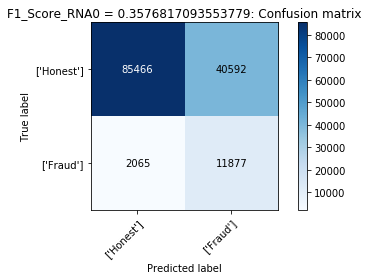

Confusion matrix, without normalization
[[79767 46291]
 [ 2821 11121]]


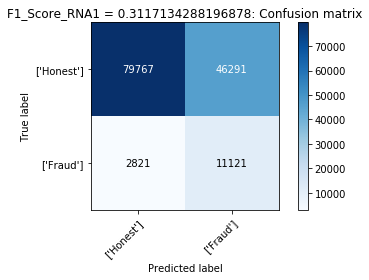

Confusion matrix, without normalization
[[67437 58621]
 [ 5895  8047]]


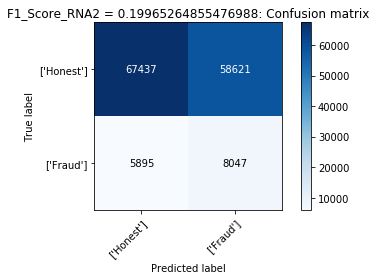

Confusion matrix, without normalization
[[70169 55889]
 [ 5110  8832]]


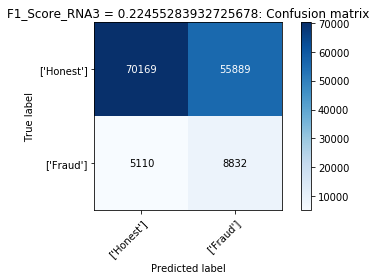

Confusion matrix, without normalization
[[65106 60952]
 [ 6540  7402]]


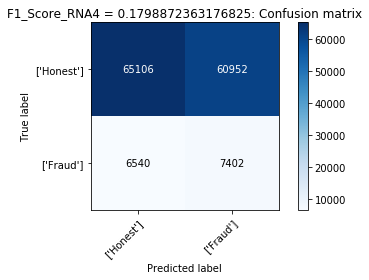

IndexError: list index out of range

In [19]:
rna_test0.predict(x_train_list0,y_train_list0)

In [20]:
K.clear_session()
K.reset_uids()

### Irei modificar a função custo, nao mudarei em nada mais as redes.colocarei 0.8 para a classe0 e 0.2 para a classe1


In [21]:
def custom_loss(y_true, y_pred):

    zeros = tf.zeros_like(y_true)
    index_of_zeros = tf.where(tf.equal(zeros, y_true))
    ones = tf.ones_like(y_true)
    index_of_ones = tf.where(tf.equal(ones, y_true))

    zero = tf.gather(y_pred, index_of_zeros)
    one = tf.gather(y_pred, index_of_ones)

    loss_0 = 0.2*binary_crossentropy(tf.zeros_like(zero), zero)
    loss_1 = 0.8*binary_crossentropy(tf.ones_like(one), one)

    return mean(tf.concat([loss_0, loss_1], axis=0))

In [22]:
rna_list1 = [rna1,rna2,rna3,rna4,rna5]
loss_list1 = [custom_loss]*5
metrics_list1 = [f1]*5
optimizer_list1 = [mom]*5

x_train_list1 = [x_train_norm]*5
y_train_list1 = [y_train]*5
x_val_list1 = [x_val_norm]*5
y_val_list1 = [y_val]*5
batch_size_list1 = [100]*5
epochs_list1 = [10000]*5

x_test_list1 = [x_test_norm]*5
y_test_list1 = [y_test]*5

In [ ]:
rna_test1 = new_rna(rna_list1,loss_list1,metrics_list1,optimizer_list1)

In [ ]:
rna_test1.train(x_train_list1,y_train_list1,x_val_list1,y_val_list1,batch_size_list1,epochs_list1)

In [ ]:
rna_test1.plot()

In [ ]:
rna_test1.predict(x_train_list1,y_train_list1)

In [ ]:
K.clear_session()
K.reset_uids()